In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!rsync -ah --info=progress2 "/content/drive/MyDrive/Fum/term9/img300/img300.zip" "/content/img.zip"

         53.69M 100%   42.61MB/s    0:00:01 (xfr#1, to-chk=0/1)


In [ ]:
!unzip -q "/content/img.zip" -d "/content"

replace /content/test/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
%%writefile /content/model.py

import torch
import torch.nn as nn
import json

num_class=35
hidden_size =256
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
ocr_model_P = "/content/ocr_finetuned.pth"
vocab_P="/content/vocab.json"

with open(vocab_P,'r',encoding='utf-8') as f:
    vocab = json.load(f)
idx_to_char={v:k for k,v in vocab.items()}


        
class CRNN(nn.Module):
    def __init__(self,num_class, hidden_size =256):
        super(CRNN,self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3 ,padding=1),
            nn.ReLU(True),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,256,kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512,kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=(4,1)),
            nn.Conv2d(512,512,kernel_size=2,stride=1),
            nn.ReLU(True),
        )
        self.dropout_rnn= nn.Dropout(0.2)

        self.rnn=nn.Sequential(
            nn.LSTM(input_size=512,hidden_size=hidden_size,num_layers=2,
                    bidirectional=True,batch_first=True)
        )

        self.fc = nn.Linear(hidden_size*2, num_class)

    def forward(self, x):
        conv=self.cnn(x)
        batch_size,channels,height,width=conv.size()
        conv=conv.squeeze(2)
        conv =conv.permute(0,2,1)
        conv=self.dropout_rnn(conv)
        rnn_out,_=self.rnn(conv)
        out=self.fc(rnn_out)
        return out


state_dict=torch.load(pth_file, map_location='cpu')

ocr_model=CRNN(num_class=num_class, hidden_size=hidden_size).to(device)
ocr_model.load_state_dict(state_dict)
ocr_model.eval()
ctc_loss=nn.CTCLoss(blank=0, zero_infinity=True)

def ctc_decode(output,idx_to_char):
    output=output.softmax(2)
    output=output.argmax(2).squeeze(0).detach().cpu().numpy()
    pred_str=[]
    last = -1
    for ch in output:
        if ch != last and ch != 0:
            pred_str.append(idx_to_char[ch])
        last=ch
    return ''.join(pred_str)


Overwriting /content/model.py


In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



In [ ]:
class lp(Dataset):
    def __init__(self,root,split,transform=None):
        self.root=os.path.join(root,split)
        self.transform=transform
        self.csv_data= pd.read_csv(os.path.join(root, f'{split}_labels.csv'))
        self.image_pair=[]
        for h,row in self.csv_data.iterrows():
            filename=os.path.join(self.root,row['filename'])
            plateL=row['plate']
            noisyName = []
            base = row['filename'].split('.')[0]
            for i in range(1, 6):
                file_path = os.path.join(self.root, f"{base}_{i}.png")
                noisyName.append(file_path)
            if os.path.exists(filename) and all(os.path.exists(noisy) for noisy in noisyName):
                self.image_pair.append((filename, noisyName, plateL))
    def __len__(self):
        return len(self.image_pair)
    def __getitem__(self,idx):
        filename,noisyName,plateL=self.image_pair[idx]
        real_image=Image.open(filename).convert('L')
        noisyImage = []
        for noisy in noisyName:
            z = Image.open(noisy)
            z = z.convert('L')
            noisyImage.append(z)
        if self.transform:
            real_image=self.transform(real_image)
            T = []
            for img in noisyImage:
                Ti = self.transform(img)
                T.append(Ti)
            noisyImage = T
        noisyS= torch.stack(noisyImage,dim=0)
        noisyS = noisyS.permute(1, 2, 3, 0)
        noisyS = noisyS.squeeze(0)

        return noisyS,real_image,plateL


Number of data in train: 300
  Sample 1: main=/content/train/1.png,noisy=['/content/train/1_1.png', '/content/train/1_2.png', '/content/train/1_3.png', '/content/train/1_4.png', '/content/train/1_5.png'],label=14س56914


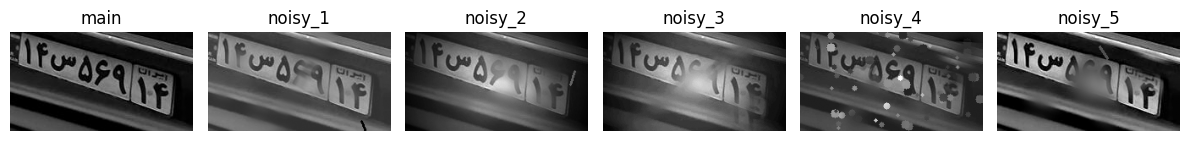

  Sample 2: main=/content/train/2.png,noisy=['/content/train/2_1.png', '/content/train/2_2.png', '/content/train/2_3.png', '/content/train/2_4.png', '/content/train/2_5.png'],label=66د86824
  Sample 3: main=/content/train/3.png,noisy=['/content/train/3_1.png', '/content/train/3_2.png', '/content/train/3_3.png', '/content/train/3_4.png', '/content/train/3_5.png'],label=46د85710
  Sample 4: main=/content/train/4.png,noisy=['/content/train/4_1.png', '/content/train/4_2.png', '/content/train/4_3.png', '/content/train/4_4.png', '/content/train/4_5.png'],label=72ص39810
  Sample 5: main=/content/train/5.png,noisy=['/content/train/5_1.png', '/content/train/5_2.png', '/content/train/5_3.png', '/content/train/5_4.png', '/content/train/5_5.png'],label=64س85488

Number of data in validation: 50
  Sample 1: main=/content/validation/1.png,noisy=['/content/validation/1_1.png', '/content/validation/1_2.png', '/content/validation/1_3.png', '/content/validation/1_4.png', '/content/validation/1_5.png'],l

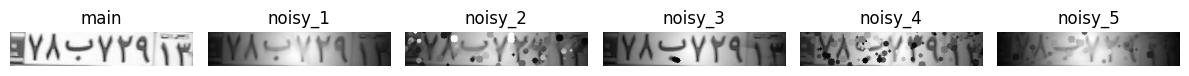

  Sample 2: main=/content/validation/2.png,noisy=['/content/validation/2_1.png', '/content/validation/2_2.png', '/content/validation/2_3.png', '/content/validation/2_4.png', '/content/validation/2_5.png'],label=11و91688
  Sample 3: main=/content/validation/3.png,noisy=['/content/validation/3_1.png', '/content/validation/3_2.png', '/content/validation/3_3.png', '/content/validation/3_4.png', '/content/validation/3_5.png'],label=82ه38991
  Sample 4: main=/content/validation/4.png,noisy=['/content/validation/4_1.png', '/content/validation/4_2.png', '/content/validation/4_3.png', '/content/validation/4_4.png', '/content/validation/4_5.png'],label=99و76299
  Sample 5: main=/content/validation/5.png,noisy=['/content/validation/5_1.png', '/content/validation/5_2.png', '/content/validation/5_3.png', '/content/validation/5_4.png', '/content/validation/5_5.png'],label=31ط37544

Number of data in test: 50
  Sample 1: main=/content/test/1.png,noisy=['/content/test/1_1.png', '/content/test/1_2.png'

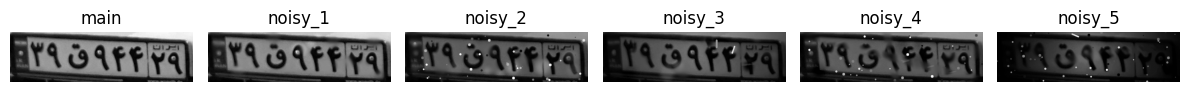

  Sample 2: main=/content/test/2.png,noisy=['/content/test/2_1.png', '/content/test/2_2.png', '/content/test/2_3.png', '/content/test/2_4.png', '/content/test/2_5.png'],label=79ط44213
  Sample 3: main=/content/test/3.png,noisy=['/content/test/3_1.png', '/content/test/3_2.png', '/content/test/3_3.png', '/content/test/3_4.png', '/content/test/3_5.png'],label=37ل48469
  Sample 4: main=/content/test/4.png,noisy=['/content/test/4_1.png', '/content/test/4_2.png', '/content/test/4_3.png', '/content/test/4_4.png', '/content/test/4_5.png'],label=45ق61429
  Sample 5: main=/content/test/5.png,noisy=['/content/test/5_1.png', '/content/test/5_2.png', '/content/test/5_3.png', '/content/test/5_4.png', '/content/test/5_5.png'],label=25ی46173


In [ ]:
def get_transforms(split):
    transform_list=[transforms.Resize((64,128)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]
    if split=='train':
        transform_list.insert(1,transforms.ColorJitter(brightness=0.2,contrast=0.2))
    return transforms.Compose(transform_list)

root='/content'
train=lp(root,split='train',transform=get_transforms('train'))
val= lp(root,split='validation',transform=get_transforms('validation'))
test=lp(root,split='test',transform=get_transforms('test'))

SP=['train','validation','test']
datasets ={'train':train,'validation':val,'test':test}

for i in SP:
    dataset=datasets[i]
    print(f"\nNumber of data in {i}: {len(dataset)}")
    for i in range(5):
        filename,noisyName,plateL=dataset.image_pair[i]
        print(f"  Sample {i+1}: main={filename},noisy={noisyName},label={plateL}")
        if i==0:
            try:
                fig,X=plt.subplots(1,6,figsize=(12,2))
                X[0].imshow(Image.open(filename), cmap='gray')
                X[0].set_title('main')
                X[0].axis('off')
                for j in range(5):
                    X[j+1].imshow(Image.open(noisyName[j]) ,cmap='gray')
                    X[j+1].set_title(f'noisy_{j+1}')
                    X[j+1].axis('off')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error loading images: {e}")

In [ ]:
def ctc_decode(output,idx_to_char):
    output=output.softmax(2)
    output =output.argmax(2)    
    output =output.squeeze(0)
    output =output.detach()
    output=output.cpu()             
    output=output.numpy()  
    pred_str=[]
    last = -1
    for ch in output:
        if ch != last and ch != 0:
            pred_str.append(idx_to_char[ch])
        last=ch
    return ''.join(pred_str)


In [ ]:
ocr_model_P = "/content/ocr_finetuned.pth"
vocab_P="/content/vocab.json"



In [ ]:
import json


with open(vocab_P, 'r', encoding='utf-8') as f:
    vocab = json.load(f)
idx_to_char = {v: k for k, v in vocab.items()}

In [ ]:
import torch.nn as nn
import torch

In [ ]:
from model import CRNN


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
root='/content'
train=lp(root,split='train',transform=get_transforms('train'))
noisyImage,real_image,plateL=train[0]
ocr_model=CRNN(num_class=35,hidden_size=256).to(device)
ocr_model.load_state_dict(torch.load(ocr_model_P,map_location=device))
ocr_model.eval()
with torch.no_grad():
    for i in range(5):
        image= noisyImage[:,:,i]
        image= image.unsqueeze(0).unsqueeze(0).to(device)
        output=ocr_model(image)
        pred=ctc_decode(output,idx_to_char)
        print(f"Noisy image {i+1} prediction: {pred}, True label: {plateL}")

In [ ]:
batch_size =128

In [ ]:
from torch.utils.data import DataLoader
trainLoader=DataLoader(train,batch_size=batch_size,shuffle=True)
valLoader=DataLoader(val,batch_size=batch_size,shuffle=False)
testLoader=DataLoader(test,batch_size=batch_size,shuffle=False)

In [ ]:
print(len(trainLoader.dataset))

300


In [ ]:
print(len(testLoader))

1


No need to run everytime

In [ ]:
# device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ocr_model=CRNN(num_class=35,hidden_size=256).to(device)
# ocr_model.load_state_dict(torch.load(ocr_model_P,map_location=device))
# ocr_model.eval()

# for split,loader in [('train',trainLoader),('validation',valLoader),('test',testLoader)]:
#     total_correctP=0
#     total_correct_char=0
#     totalC=0
#     totalS=0
#     with torch.no_grad():
#         for noisyImage,real_image,plateLabel in loader:
#             batch_size=noisyImage.size(0)
#             noisyImage=noisyImage.permute(0,3,1,2).reshape(-1,1,64,128).to(device)
#             output=ocr_model(noisyImage)
#             output=output.reshape(batch_size,5,-1,35)
#             for i in range(batch_size):
#                 true_label=plateLabel[i]
#                 for j in range(5):
#                     pred=ctc_decode(output[i:i+1,j],idx_to_char)
#                     if pred==true_label:
#                         total_correctP+=1
#                     min_len=min(len(pred),len(true_label))
#                     correct_chars=sum(1 for p,g in zip(pred[:min_len],true_label[:min_len]) if p==g)
#                     total_correct_char+=correct_chars
#                     totalc+=len(true_label)
#                     totalS+=1
#     plate_accuracy=(total_correctP/totalS)*100
#     char_accuracy=(total_correct_char/total)*100
#     print(f"Plate accuracy for {split} : {plate_accuracy:.2f}%")
#     print(f"Character accuracy for {split} : {char_accuracy:.2f}%")

In [ ]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.enc1 =nn.Sequential(nn.Conv2d(5,32,kernel_size=4,stride=2,padding=1),nn.BatchNorm2d(32),nn.LeakyReLU(0.2,inplace=True))
        self.enc2 =nn.Sequential(nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1),nn.BatchNorm2d(64),nn.LeakyReLU(0.2,inplace=True))
        self.enc3 =nn.Sequential(nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),nn.BatchNorm2d(128),nn.LeakyReLU(0.2,inplace=True))

        self.enc4 =nn.Sequential(nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1),nn.BatchNorm2d(256),nn.LeakyReLU(0.2,inplace=True))
        self.dec1 =nn.Sequential(nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1),nn.BatchNorm2d(128),nn.ReLU(inplace=True))
        self.dec2 =nn.Sequential(nn.ConvTranspose2d(128+128,64,kernel_size=4,stride=2,padding=1),nn.BatchNorm2d(64),nn.ReLU(inplace=True))
        self.dec3 =nn.Sequential(nn.ConvTranspose2d(64+64,32,kernel_size=4,stride=2,padding=1),nn.BatchNorm2d(32),nn.ReLU(inplace=True))

        self.dec4 =nn.Sequential(nn.ConvTranspose2d(32+32,1,kernel_size=4,stride=2,padding=1),nn.Tanh())
    def forward(self,x):
        E1=self.enc1(x)
        E2=self.enc2(E1)
        E3=self.enc3(E2)
        E4=self.enc4(E3)

        D1=self.dec1(E4)
        D2=self.dec2(torch.cat([D1,E3],dim=1))
        D3=self.dec3(torch.cat([D2,E2],dim=1))
        out=self.dec4(torch.cat([D3,E1],dim=1))
        
        return out
    


def init_weights(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data,0.0,0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data,0)
    elif isinstance(m,nn.BatchNorm2d):
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)


gen=Generator()
gen.apply(init_weights)

Generator(
  (enc1): Sequential(
    (0): Conv2d(5, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dec1): Seq

In [ ]:
import torch.nn.init as init

In [ ]:
class RaGANDiscriminator(nn.Module):
    def __init__(self):
        super(RaGANDiscriminator, self).__init__()
        self.model=nn.Sequential(
            nn.Conv2d(1,16,kernel_size=4,stride=2,padding=1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(16,32,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(32),

            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),

            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128,1,kernel_size=1 ,stride=1,padding=0,bias=False),
        )
        self._initialize_weights()

    def forward(self,x):
        output=self.model(x)
        return output.view(-1,1)




    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                init.normal_(m.weight,mean=0, std=0.02)
            elif isinstance(m,nn.BatchNorm2d):
                init.normal_(m.weight,mean=1,std=0.02)
                init.constant_(m.bias,0)

In [ ]:
sample_input=torch.randn(128, 1,64,128)
model=RaGANDiscriminator()
output=model(sample_input)


In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

gen=Generator()
dis=RaGANDiscriminator()

gen_params= count_params(gen)
disc_params=count_params(dis)
print(f"gen p: {gen_params}")
print(f"dis p: {disc_params}")

gen p: 1545793
dis p: 172864


In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainLoader=DataLoader(train,batch_size=batch_size,shuffle=True)
valLoader=DataLoader(val,batch_size=batch_size,shuffle=False)
gen =Generator().to(device)
dis=RaGANDiscriminator().to(device)
ocr_model=CRNN(num_class=35,hidden_size=256).to(device)
ocr_model.load_state_dict(torch.load(ocr_model_P,map_location=device))
ocr_model.eval()
gen_optimizer=torch.optim.Adam( gen.parameters(),lr=0.0002,betas=(0.5,0.999))
disc_optimizer=torch.optim.Adam( dis.parameters(),lr=0.0001,betas=(0.5,0.999))
adv_loss=nn.BCEWithLogitsLoss()
ctc_loss=nn.CTCLoss(blank=0,zero_infinity=True)
max_epch= 600
real_label=1.0
fake_label=0.0
output_folder="./output"
os.makedirs(output_folder,exist_ok=True)
print(f"Output directory created at: {os.path.abspath(output_folder)}")
bestValCTCloss=float("inf")


Output directory created at: /content/output


In [ ]:
def compute_grad_norm(model):
    total_norm =0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm=p.grad.data.norm(2)
            total_norm+=param_norm.item()**2
    return total_norm**0.5

In [ ]:

def save_images(noisyImage,real_image,fakeImg,output_folder,epoch,i,ocr_model,idx_to_char):
    fig,X=plt.subplots(1,7,figsize=(14,2))
    for j in range(5):
        img=noisyImage[0,j].cpu().numpy()
        img=(img+1)/2
        X[j].imshow(img,cmap="gray")
        pred= ctc_decode(ocr_model(noisyImage[0:1,j:j+1].to(device)),idx_to_char)
        X[j].set_title(f"Noisy {j+1}\n{pred}")
        X[j].axis("off")
    fake_img=fakeImg[0].cpu().numpy()
    fake_img=(fake_img+1)/2
    X[5].imshow(fake_img[0],cmap="gray")
    fake_pred =ctc_decode(ocr_model(fakeImg[0:1].to(device)),idx_to_char)
    X[5].set_title(f"Gen\n{fake_pred}")
    X[5].axis("off")
    real_img=real_image[0].cpu().numpy()
    real_img =(real_img+1)/2
    X[6].imshow(real_img[0],cmap="gray")
    real_pred=ctc_decode(ocr_model(real_image[0:1].to(device)),idx_to_char)
    X[6].set_title(f"Real\n{real_pred}")
    X[6].axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder,f"epoch{(epoch+1)}_img{(i+1)}.png"))
    plt.close()

In [ ]:
def compute_mse_loss(real_image, fakeImg):
    mse_loss = nn.MSELoss()
    
    return mse_loss(fakeImg, real_image)

In [ ]:
from torchvision.models import  VGG16_Weights
class percLoss(nn.Module):
    def __init__(self, device):
        super(percLoss, self).__init__()
        vgg = models.vgg16(weights=VGG16_Weights.DEFAULT).features.eval().to(device)
        self.layers = nn.Sequential(*list(vgg)[:16])
        self.mse = nn.MSELoss()
        
        for param in self.layers.parameters():
            param.requires_grad = False
    def forward(self, x, y):
        x = (x+1) / 2
        y = (y+1) / 2
        x = x.repeat(1,3,1,1)
        y = y.repeat(1,3,1,1)
        x_features = self.layers(x)
        y_features = self.layers(y)
        return self.mse(x_features, y_features)

In [ ]:
def calculate_psnr_ssim(real_image, fakeImg):
    with torch.no_grad():
        real_image_np = ((real_image.permute(0,2,3,1).cpu().numpy()+1)*127.5).clip(0,255).astype(np.uint8)
        fakeImg_np = ((fakeImg.permute(0,2,3,1).cpu().numpy()+1)*127.5).clip(0,255).astype(np.uint8)
    psnr_scores = []
    ssim_scores = []


    for i in range(real_image_np.shape[0]):
        real_img = real_image_np[i,:,:,0]  
        fake_img = fakeImg_np[i,:,:,0]  
        psnr_score = psnr(real_img, fake_img, data_range=255)
        ssim_score = ssim(real_img, fake_img, data_range=255)
        psnr_scores.append(psnr_score)
        ssim_scores.append(ssim_score)
        return np.mean(psnr_scores), np.mean(ssim_scores)

In [ ]:
def ragan_loss_dis(dis, real_imgs, fake_imgs):
    realScore = dis(real_imgs)
    fakeScore = dis(fake_imgs.detach())
    Re = realScore - fakeScore.mean()
    Fa = fakeScore - realScore.mean()
    lossRe = torch.mean(torch.log1p(torch.exp(-Re)))
    lossFa = torch.mean(torch.log1p(torch.exp(Fa)))
    lossDis = (lossRe + lossFa) / 2
    return lossDis
def ragan_loss_gen(dis, real_imgs, fake_imgs):
    realScore = dis(real_imgs)
    fakeScore = dis(fake_imgs)
    Fa = fakeScore - realScore.mean()
    lossGen = torch.mean(torch.log1p(torch.exp(-Fa)))
    return lossGen

In [ ]:
import torchvision.models as models
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import numpy as np

log_data=[]
bestValCTCloss=float('inf')
vgg_loss_fn=percLoss(device).to(device)

for epoch in range(max_epch):
    sum_g_adv_loss=0.0
    g_loss_sum=0.0
    d_loss_sum=0.0
    sum_train_ocr_loss=0.0
    sum_train_char_acc=0.0
    sum_mse_loss=0.0
    sum_vgg_loss=0.0
    sum_grad_norm_mse=0.0

    grad_norm_vgg_sum=0.0
    grad_norm_adv_sum=0.0
    batch_count=0
    gen_grad_norm_sum=0.0
    disc_grad_norm_sum=0.0
    sumpsnr=0.0
    sumssim=0.0

    for i, (noisyImage, real_image, plateLabel) in enumerate(tqdm(trainLoader, desc=f"Epoch {epoch+1}/{max_epch}")):
        ocr_model.train()

        batch_size=noisyImage.size(0)
        r_i=real_image.to(device)
        noisyImage=noisyImage.permute(0,3,1,2).to(device)
        real_labels=torch.full((batch_size,1), 1.0, device=device)
        fake_labels=torch.full((batch_size,1), 0.0, device=device)

        #dis
        #if epoch<10:
        #  loss_d = torch.tensor(0.0)
        #  disc_grad_norm=0.0
        #else:
        #  disc_optimizer.zero_grad()
        disc_optimizer.zero_grad()
        f_i=gen(noisyImage)
        loss_d = ragan_loss_dis(dis, r_i, f_i)
        loss_d.backward()
        disc_grad_norm=compute_grad_norm(dis)
        disc_optimizer.step()

        # gen
        gen_optimizer.zero_grad()
        f_i=gen(noisyImage)
        adv_g = ragan_loss_gen(dis, r_i, f_i)
        adv_g.backward(retain_graph=True)
        grad_norm_adv=compute_grad_norm(gen)
        gen_optimizer.zero_grad()

        mse_loss=compute_mse_loss(r_i, f_i)
        mse_loss.backward(retain_graph=True)
        grad_norm_mse=compute_grad_norm(gen)

        gen_optimizer.zero_grad()
        vgg_loss=vgg_loss_fn(r_i, f_i)
        vgg_loss.backward(retain_graph=True)
        grad_norm_vgg=compute_grad_norm(gen)
        gen_optimizer.zero_grad()

        fake_output_ocr=ocr_model(f_i)
        log_probs=fake_output_ocr.log_softmax(2)
        inputLen=torch.full((batch_size,), log_probs.size(1), dtype=torch.long, device=device)

        targetLen=torch.tensor([len(label) for label in plateLabel], dtype=torch.long, device=device)
        target=torch.tensor([vocab[c] for label in plateLabel for c in label], dtype=torch.long, device=device)

        ocr_loss=ctc_loss(log_probs.permute(1,0,2), target, inputLen, targetLen)
        #if epoch<10:
        #  gen_loss= 1*mse_loss
        #else:
        #  gen_loss=1*adv_g + 1*vgg_loss + 1*ocr_loss + 1*mse_loss
        gen_loss=10*adv_g + 1*vgg_loss + 1*ocr_loss + 1*mse_loss

        gen_loss.backward()
        gen_grad_norm=compute_grad_norm(gen)

        gen_optimizer.step()

        with torch.no_grad():
            preds=[ctc_decode(fake_output_ocr[i:i+1], idx_to_char) for i in range(batch_size)]
            correct_chars=sum(sum(1 for p,g in zip(pred[:min(len(pred),len(true_label))],true_label[:min(len(pred),len(true_label))]) if p==g) for pred,true_label in zip(preds,plateLabel))
            totalC=sum(len(label) for label in plateLabel)
            char_acc=correct_chars / totalC
            sum_train_ocr_loss+=ocr_loss.item()
            sum_train_char_acc+=char_acc
            sum_mse_loss+=mse_loss.item()
            sum_vgg_loss+=vgg_loss.item()

            sum_grad_norm_mse+=grad_norm_mse
            grad_norm_vgg_sum+=grad_norm_vgg
            grad_norm_adv_sum+=grad_norm_adv
            psnr_score, ssim_score=calculate_psnr_ssim(r_i, f_i)
            sumpsnr+=psnr_score
            sumssim+=ssim_score

        sum_g_adv_loss+=adv_g.item()
        g_loss_sum+=gen_loss.item()
        d_loss_sum+=loss_d.item()
        gen_grad_norm_sum+=gen_grad_norm
        disc_grad_norm_sum+=disc_grad_norm
        batch_count+=1

    val_char_acc_sum=0.0
    val_ocr_loss_sum=0.0
    val_sum_mse_loss=0.0
    val_sum_vgg_loss=0.0
    val_sumpsnr=0.0

    val_sumssim=0.0
    val_batch_count=0
    with torch.no_grad():
        ocr_model.eval()
        for noisyImage, real_image, plateLabel in valLoader:
            batch_size=noisyImage.size(0)
            noisyImage=noisyImage.permute(0,3,1,2).to(device)
            real_image=real_image.to(device)
            fakeImg=gen(noisyImage)
            fake_output=ocr_model(fakeImg)
            log_probs=fake_output.log_softmax(2)
            inputLen=torch.full((batch_size,), log_probs.size(1), dtype=torch.long, device=device)
            targetLen=torch.tensor([len(label) for label in plateLabel], dtype=torch.long, device=device)
            target=torch.tensor([vocab[c] for label in plateLabel for c in label], dtype=torch.long, device=device)

            ocr_loss =ctc_loss(log_probs.permute(1,0,2), target, inputLen, targetLen)
            mse_loss =compute_mse_loss(real_image, fakeImg)
            vgg_loss=vgg_loss_fn(real_image, fakeImg)
            preds=[ctc_decode(fake_output[i:i+1], idx_to_char) for i in range(batch_size)]
            correct_chars=sum(sum(1 for p,g in zip(pred[:min(len(pred),len(true_label))],true_label[:min(len(pred),len(true_label))]) if p==g) for pred,true_label in zip(preds,plateLabel))
            totalC=sum(len(label) for label in plateLabel)
            char_acc=correct_chars / totalC
            val_char_acc_sum+=char_acc
            val_ocr_loss_sum+=ocr_loss.item()
            val_sum_mse_loss+=mse_loss.item()
            val_sum_vgg_loss+=vgg_loss.item()

            psnr_score, ssim_score=calculate_psnr_ssim(real_image, fakeImg)
            val_sumpsnr+=psnr_score
            val_sumssim+=ssim_score
            val_batch_count+=1

    avg_g_adv_loss=sum_g_adv_loss/batch_count
    avg_g_loss=g_loss_sum/batch_count
    avg_d_loss=d_loss_sum/batch_count

    norm_avg_gen_grad=gen_grad_norm_sum/batch_count
    norm_avg_disc_grad=disc_grad_norm_sum/batch_count
    avg_train_ocr_loss=sum_train_ocr_loss/batch_count
    avg_train_char_acc=sum_train_char_acc/batch_count
    avg_mse_loss=sum_mse_loss/batch_count
    avg_vgg_loss=sum_vgg_loss/batch_count

    avg_grad_norm_mse=sum_grad_norm_mse/batch_count
    avg_grad_norm_vgg=grad_norm_vgg_sum/batch_count
    avg_grad_norm_adv=grad_norm_adv_sum/batch_count
    avgpsnr=sumpsnr/batch_count
    avgssim=sumssim/batch_count
    avg_val_char_acc=val_char_acc_sum/val_batch_count

    avg_val_ocr_loss=val_ocr_loss_sum/val_batch_count
    avg_val_mse_loss=val_sum_mse_loss/val_batch_count
    avg_val_vgg_loss=val_sum_vgg_loss/val_batch_count
    avg_val_psnr=val_sumpsnr/val_batch_count
    avg_val_ssim=val_sumssim/val_batch_count

    print(f"Epoch: {epoch+1}/{max_epch}")
    print(f"D Real Acc: {avg_g_adv_loss:.4f}")
    print(f"G Loss: {avg_g_loss:.4f}")
    print(f"Adv D Loss: {avg_d_loss:.4f}")
    print(f"Adv G Loss: {avg_g_adv_loss:.4f}")
    print(f"Gen Grad Norm: {norm_avg_gen_grad:.4f}")

    print(f"Disc Grad Norm: {norm_avg_disc_grad:.4f}")
    print(f"Train Char Acc: {avg_train_char_acc:.4f}")
    print(f"Val OCR Loss: {avg_val_ocr_loss:.4f}")
    print(f"Val Char Acc: {avg_val_char_acc:.4f}")
    print(f"Train MSE Loss: {avg_mse_loss:.4f} (Grad Norm: {avg_grad_norm_mse:.4f})")
    print(f"Val MSE Loss: {avg_val_mse_loss:.4f}")
    print(f"Train VGG Loss: {avg_vgg_loss:.4f} (Grad Norm: {avg_grad_norm_vgg:.4f})")
    print(f"Val VGG Loss: {avg_val_vgg_loss:.4f}")
    print(f"Train Adv Grad Norm: {avg_grad_norm_adv:.4f}")
    print(f"Train PSNR: {avgpsnr:.4f}")
    print(f"Val PSNR: {avg_val_psnr:.4f}")
    print(f"Train SSIM: {avgssim:.4f}")
    print(f"Val SSIM: {avg_val_ssim:.4f}")

    log_entry={
        "epoch": epoch+1,
        "g_loss": avg_g_loss,
        "adv_d_loss": avg_d_loss,
        "adv_loss": avg_g_adv_loss,
        "gen_grad_norm": norm_avg_gen_grad,
        "disc_grad_norm": norm_avg_disc_grad,
        "train_ocr_loss": avg_train_ocr_loss,
        "train_char_acc": avg_train_char_acc,
        "val_char_acc": avg_val_char_acc,
        "val_ocr_loss": avg_val_ocr_loss,
        "train_mse_loss": avg_mse_loss,
        "val_mse_loss": avg_val_mse_loss,
        "train_vgg_loss": avg_vgg_loss,
        "val_vgg_loss": avg_val_vgg_loss,
        "grad_norm_mse": avg_grad_norm_mse,
        "grad_norm_vgg": avg_grad_norm_vgg,
        "grad_norm_adv": avg_grad_norm_adv,
        "train_psnr": avgpsnr,
        "val_psnr": avg_val_psnr,
        "train_ssim": avgssim,
        "val_ssim": avg_val_ssim
    }
    log_data.append(log_entry)
    with open(os.path.join(output_folder, "training_log.json"), "w", encoding="utf-8") as f:
        json.dump(log_data, f, ensure_ascii=False, indent=2)

    if avg_val_ocr_loss < bestValCTCloss:
        bestValCTCloss=avg_val_ocr_loss
        torch.save(gen.state_dict(), os.path.join(output_folder, "best.pth"))
        print(f"Saved best model with val_ocr_loss: {bestValCTCloss:.4f}, val_psnr: {avg_val_psnr:.4f}")

    if (epoch+1)%175==0:
        torch.save(gen.state_dict(), os.path.join(output_folder, f"epoch{epoch+1}.pth"))
        print(f"Saved model at epoch {epoch+1}")

    if epoch==0 or (epoch+1)%10==0:
        with torch.no_grad():
            for i, (noisyImage, real_image, plateLabel) in enumerate(trainLoader):
                if i>=5: break
                noisyImage=noisyImage.permute(0,3,1,2).to(device)
                real_image=real_image.to(device)

                fakeImg=gen(noisyImage)
                save_images(noisyImage, real_image, fakeImg, output_folder, epoch, i, ocr_model, idx_to_char)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.6MB/s]
Epoch 1/600: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Epoch: 1/600
D Real Acc: 0.6975
G Loss: 18.0671
Adv D Loss: 0.6914
Adv G Loss: 0.6975
Gen Grad Norm: 37.8626
Disc Grad Norm: 0.1386
Train Char Acc: 0.1220
Val OCR Loss: 3.0572
Val Char Acc: 0.0925
Train MSE Loss: 0.7642 (Grad Norm: 2.6741)
Val MSE Loss: 0.7807
Train VGG Loss: 7.0919 (Grad Norm: 20.2003)
Val VGG Loss: 7.1343
Train Adv Grad Norm: 0.0980
Train PSNR: 8.6484
Val PSNR: 5.2224
Train SSIM: 0.0022
Val SSIM: -0.0091
Saved best model with val_ocr_loss: 3.0572, val_psnr: 5.2224


Epoch 2/600: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch: 2/600
D Real Acc: 0.7005
G Loss: 17.3532
Adv D Loss: 0.6883
Adv G Loss: 0.7005
Gen Grad Norm: 31.3873
Disc Grad Norm: 0.1443
Train Char Acc: 0.1056
Val OCR Loss: 3.0449
Val Char Acc: 0.0750
Train MSE Loss: 0.7730 (Grad Norm: 2.7869)
Val MSE Loss: 0.7503
Train VGG Loss: 6.3544 (Grad Norm: 8.3139)
Val VGG Loss: 6.8080
Train Adv Grad Norm: 0.0949
Train PSNR: 7.7575
Val PSNR: 5.3888
Train SSIM: -0.0298
Val SSIM: -0.0059
Saved best model with val_ocr_loss: 3.0449, val_psnr: 5.3888


Epoch 3/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 3/600
D Real Acc: 0.7030
G Loss: 17.1259
Adv D Loss: 0.6858
Adv G Loss: 0.7030
Gen Grad Norm: 28.5609
Disc Grad Norm: 0.1524
Train Char Acc: 0.1138
Val OCR Loss: 3.0213
Val Char Acc: 0.0950
Train MSE Loss: 0.7370 (Grad Norm: 2.5327)
Val MSE Loss: 0.7148
Train VGG Loss: 6.0991 (Grad Norm: 6.4528)
Val VGG Loss: 6.6120
Train Adv Grad Norm: 0.0894
Train PSNR: 7.1093
Val PSNR: 5.7490
Train SSIM: -0.0196
Val SSIM: 0.0044
Saved best model with val_ocr_loss: 3.0213, val_psnr: 5.7490


Epoch 4/600: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


Epoch: 4/600
D Real Acc: 0.7068
G Loss: 16.8378
Adv D Loss: 0.6821
Adv G Loss: 0.7068
Gen Grad Norm: 25.2865
Disc Grad Norm: 0.1628
Train Char Acc: 0.1122
Val OCR Loss: 2.9769
Val Char Acc: 0.0950
Train MSE Loss: 0.7039 (Grad Norm: 2.5689)
Val MSE Loss: 0.6964
Train VGG Loss: 5.9163 (Grad Norm: 5.2694)
Val VGG Loss: 6.4779
Train Adv Grad Norm: 0.0896
Train PSNR: 8.5776
Val PSNR: 5.9263
Train SSIM: -0.0080
Val SSIM: 0.0100
Saved best model with val_ocr_loss: 2.9769, val_psnr: 5.9263


Epoch 5/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 5/600
D Real Acc: 0.7102
G Loss: 16.6790
Adv D Loss: 0.6792
Adv G Loss: 0.7102
Gen Grad Norm: 23.3252
Disc Grad Norm: 0.1755
Train Char Acc: 0.1322
Val OCR Loss: 2.9686
Val Char Acc: 0.0925
Train MSE Loss: 0.6721 (Grad Norm: 2.3701)
Val MSE Loss: 0.6801
Train VGG Loss: 5.8248 (Grad Norm: 4.5507)
Val VGG Loss: 6.3923
Train Adv Grad Norm: 0.0911
Train PSNR: 7.5308
Val PSNR: 6.0296
Train SSIM: -0.0019
Val SSIM: 0.0136
Saved best model with val_ocr_loss: 2.9686, val_psnr: 6.0296


Epoch 6/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 6/600
D Real Acc: 0.7148
G Loss: 16.5791
Adv D Loss: 0.6750
Adv G Loss: 0.7148
Gen Grad Norm: 20.2437
Disc Grad Norm: 0.2042
Train Char Acc: 0.1218
Val OCR Loss: 2.9377
Val Char Acc: 0.0950
Train MSE Loss: 0.6671 (Grad Norm: 2.3058)
Val MSE Loss: 0.6632
Train VGG Loss: 5.7125 (Grad Norm: 3.9087)
Val VGG Loss: 6.3214
Train Adv Grad Norm: 0.0975
Train PSNR: 8.6741
Val PSNR: 6.1706
Train SSIM: 0.0418
Val SSIM: 0.0197
Saved best model with val_ocr_loss: 2.9377, val_psnr: 6.1706


Epoch 7/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 7/600
D Real Acc: 0.7204
G Loss: 16.4009
Adv D Loss: 0.6700
Adv G Loss: 0.7204
Gen Grad Norm: 19.9155
Disc Grad Norm: 0.2101
Train Char Acc: 0.1253
Val OCR Loss: 2.9306
Val Char Acc: 0.1050
Train MSE Loss: 0.6301 (Grad Norm: 2.1504)
Val MSE Loss: 0.6448
Train VGG Loss: 5.5358 (Grad Norm: 3.6914)
Val VGG Loss: 6.2492
Train Adv Grad Norm: 0.1035
Train PSNR: 7.5084
Val PSNR: 6.2946
Train SSIM: 0.0142
Val SSIM: 0.0253
Saved best model with val_ocr_loss: 2.9306, val_psnr: 6.2946


Epoch 8/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 8/600
D Real Acc: 0.7257
G Loss: 16.3201
Adv D Loss: 0.6656
Adv G Loss: 0.7257
Gen Grad Norm: 18.9804
Disc Grad Norm: 0.2381
Train Char Acc: 0.1141
Val OCR Loss: 2.8963
Val Char Acc: 0.1025
Train MSE Loss: 0.6087 (Grad Norm: 1.9531)
Val MSE Loss: 0.6249
Train VGG Loss: 5.4534 (Grad Norm: 3.1158)
Val VGG Loss: 6.2010
Train Adv Grad Norm: 0.1179
Train PSNR: 7.2223
Val PSNR: 6.4357
Train SSIM: 0.0086
Val SSIM: 0.0278
Saved best model with val_ocr_loss: 2.8963, val_psnr: 6.4357


Epoch 9/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 9/600
D Real Acc: 0.7331
G Loss: 16.4533
Adv D Loss: 0.6590
Adv G Loss: 0.7331
Gen Grad Norm: 18.6107
Disc Grad Norm: 0.2613
Train Char Acc: 0.1117
Val OCR Loss: 2.8806
Val Char Acc: 0.0975
Train MSE Loss: 0.5991 (Grad Norm: 1.8877)
Val MSE Loss: 0.6036
Train VGG Loss: 5.5169 (Grad Norm: 3.5534)
Val VGG Loss: 6.1712
Train Adv Grad Norm: 0.1233
Train PSNR: 9.2333
Val PSNR: 6.6517
Train SSIM: 0.0196
Val SSIM: 0.0339
Saved best model with val_ocr_loss: 2.8806, val_psnr: 6.6517


Epoch 10/600: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch: 10/600
D Real Acc: 0.7389
G Loss: 16.2247
Adv D Loss: 0.6542
Adv G Loss: 0.7389
Gen Grad Norm: 17.7022
Disc Grad Norm: 0.3151
Train Char Acc: 0.1295
Val OCR Loss: 2.9166
Val Char Acc: 0.1025
Train MSE Loss: 0.5585 (Grad Norm: 1.7754)
Val MSE Loss: 0.5821
Train VGG Loss: 5.3368 (Grad Norm: 3.1116)
Val VGG Loss: 6.1371
Train Adv Grad Norm: 0.1392
Train PSNR: 9.3510
Val PSNR: 6.8448
Train SSIM: 0.0223
Val SSIM: 0.0385


Epoch 11/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 11/600
D Real Acc: 0.7495
G Loss: 16.5526
Adv D Loss: 0.6449
Adv G Loss: 0.7495
Gen Grad Norm: 16.7609
Disc Grad Norm: 0.3597
Train Char Acc: 0.1179
Val OCR Loss: 2.8900
Val Char Acc: 0.1050
Train MSE Loss: 0.5536 (Grad Norm: 1.6866)
Val MSE Loss: 0.5707
Train VGG Loss: 5.5497 (Grad Norm: 3.0205)
Val VGG Loss: 6.1167
Train Adv Grad Norm: 0.1583
Train PSNR: 8.4118
Val PSNR: 6.9036
Train SSIM: 0.0278
Val SSIM: 0.0436


Epoch 12/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 12/600
D Real Acc: 0.7583
G Loss: 16.4167
Adv D Loss: 0.6373
Adv G Loss: 0.7583
Gen Grad Norm: 16.3400
Disc Grad Norm: 0.3668
Train Char Acc: 0.1314
Val OCR Loss: 2.8556
Val Char Acc: 0.1100
Train MSE Loss: 0.5362 (Grad Norm: 1.5937)
Val MSE Loss: 0.5630
Train VGG Loss: 5.4129 (Grad Norm: 3.2420)
Val VGG Loss: 6.0946
Train Adv Grad Norm: 0.1704
Train PSNR: 9.3336
Val PSNR: 6.8772
Train SSIM: 0.0424
Val SSIM: 0.0467
Saved best model with val_ocr_loss: 2.8556, val_psnr: 6.8772


Epoch 13/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 13/600
D Real Acc: 0.7699
G Loss: 16.3868
Adv D Loss: 0.6274
Adv G Loss: 0.7699
Gen Grad Norm: 16.6771
Disc Grad Norm: 0.4416
Train Char Acc: 0.1425
Val OCR Loss: 2.8488
Val Char Acc: 0.0725
Train MSE Loss: 0.5208 (Grad Norm: 1.6269)
Val MSE Loss: 0.5656
Train VGG Loss: 5.3312 (Grad Norm: 3.0297)
Val VGG Loss: 6.0492
Train Adv Grad Norm: 0.1593
Train PSNR: 9.9575
Val PSNR: 6.7868
Train SSIM: 0.0177
Val SSIM: 0.0433
Saved best model with val_ocr_loss: 2.8488, val_psnr: 6.7868


Epoch 14/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 14/600
D Real Acc: 0.7767
G Loss: 16.4574
Adv D Loss: 0.6215
Adv G Loss: 0.7767
Gen Grad Norm: 15.3045
Disc Grad Norm: 0.4128
Train Char Acc: 0.1282
Val OCR Loss: 2.8514
Val Char Acc: 0.0675
Train MSE Loss: 0.5188 (Grad Norm: 1.5006)
Val MSE Loss: 0.5512
Train VGG Loss: 5.3153 (Grad Norm: 3.0618)
Val VGG Loss: 6.0327
Train Adv Grad Norm: 0.1750
Train PSNR: 10.0206
Val PSNR: 6.8903
Train SSIM: 0.0399
Val SSIM: 0.0467


Epoch 15/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 15/600
D Real Acc: 0.7859
G Loss: 16.5658
Adv D Loss: 0.6137
Adv G Loss: 0.7859
Gen Grad Norm: 14.6824
Disc Grad Norm: 0.4200
Train Char Acc: 0.1403
Val OCR Loss: 2.8375
Val Char Acc: 0.0900
Train MSE Loss: 0.5212 (Grad Norm: 1.4677)
Val MSE Loss: 0.5431
Train VGG Loss: 5.3526 (Grad Norm: 3.0223)
Val VGG Loss: 6.0054
Train Adv Grad Norm: 0.1930
Train PSNR: 7.8862
Val PSNR: 6.9112
Train SSIM: 0.0527
Val SSIM: 0.0509
Saved best model with val_ocr_loss: 2.8375, val_psnr: 6.9112


Epoch 16/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 16/600
D Real Acc: 0.7928
G Loss: 16.6048
Adv D Loss: 0.6083
Adv G Loss: 0.7928
Gen Grad Norm: 14.2748
Disc Grad Norm: 0.5472
Train Char Acc: 0.1480
Val OCR Loss: 2.8297
Val Char Acc: 0.0925
Train MSE Loss: 0.5013 (Grad Norm: 1.4082)
Val MSE Loss: 0.5309
Train VGG Loss: 5.3661 (Grad Norm: 3.0545)
Val VGG Loss: 5.9943
Train Adv Grad Norm: 0.2220
Train PSNR: 8.2506
Val PSNR: 6.9756
Train SSIM: 0.0210
Val SSIM: 0.0475
Saved best model with val_ocr_loss: 2.8297, val_psnr: 6.9756


Epoch 17/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 17/600
D Real Acc: 0.8017
G Loss: 16.5999
Adv D Loss: 0.6018
Adv G Loss: 0.8017
Gen Grad Norm: 14.2817
Disc Grad Norm: 0.6414
Train Char Acc: 0.1443
Val OCR Loss: 2.7912
Val Char Acc: 0.1050
Train MSE Loss: 0.5060 (Grad Norm: 1.3824)
Val MSE Loss: 0.5224
Train VGG Loss: 5.3107 (Grad Norm: 3.1637)
Val VGG Loss: 5.9834
Train Adv Grad Norm: 0.2353
Train PSNR: 9.2699
Val PSNR: 7.0403
Train SSIM: 0.0463
Val SSIM: 0.0493
Saved best model with val_ocr_loss: 2.7912, val_psnr: 7.0403


Epoch 18/600: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch: 18/600
D Real Acc: 0.8103
G Loss: 16.7321
Adv D Loss: 0.5944
Adv G Loss: 0.8103
Gen Grad Norm: 15.7301
Disc Grad Norm: 0.6370
Train Char Acc: 0.1297
Val OCR Loss: 2.8131
Val Char Acc: 0.1200
Train MSE Loss: 0.5009 (Grad Norm: 1.3089)
Val MSE Loss: 0.5116
Train VGG Loss: 5.2932 (Grad Norm: 3.5136)
Val VGG Loss: 5.9782
Train Adv Grad Norm: 0.2407
Train PSNR: 9.1300
Val PSNR: 7.1544
Train SSIM: 0.0558
Val SSIM: 0.0514


Epoch 19/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 19/600
D Real Acc: 0.8156
G Loss: 16.6355
Adv D Loss: 0.5899
Adv G Loss: 0.8156
Gen Grad Norm: 16.8826
Disc Grad Norm: 0.6486
Train Char Acc: 0.1353
Val OCR Loss: 2.7826
Val Char Acc: 0.1075
Train MSE Loss: 0.4654 (Grad Norm: 1.3486)
Val MSE Loss: 0.5020
Train VGG Loss: 5.1427 (Grad Norm: 3.0126)
Val VGG Loss: 5.9490
Train Adv Grad Norm: 0.2349
Train PSNR: 10.9538
Val PSNR: 7.1565
Train SSIM: 0.0368
Val SSIM: 0.0554
Saved best model with val_ocr_loss: 2.7826, val_psnr: 7.1565


Epoch 20/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 20/600
D Real Acc: 0.8184
G Loss: 16.7737
Adv D Loss: 0.5887
Adv G Loss: 0.8184
Gen Grad Norm: 14.0588
Disc Grad Norm: 0.7957
Train Char Acc: 0.1491
Val OCR Loss: 2.8411
Val Char Acc: 0.1075
Train MSE Loss: 0.4747 (Grad Norm: 1.2684)
Val MSE Loss: 0.4948
Train VGG Loss: 5.3087 (Grad Norm: 3.2183)
Val VGG Loss: 5.9412
Train Adv Grad Norm: 0.2691
Train PSNR: 7.0734
Val PSNR: 7.1360
Train SSIM: 0.0547
Val SSIM: 0.0571


Epoch 21/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 21/600
D Real Acc: 0.8283
G Loss: 16.7749
Adv D Loss: 0.5804
Adv G Loss: 0.8283
Gen Grad Norm: 14.4792
Disc Grad Norm: 0.6788
Train Char Acc: 0.1431
Val OCR Loss: 2.7933
Val Char Acc: 0.1325
Train MSE Loss: 0.4521 (Grad Norm: 1.2587)
Val MSE Loss: 0.4896
Train VGG Loss: 5.1891 (Grad Norm: 3.0683)
Val VGG Loss: 5.9181
Train Adv Grad Norm: 0.2463
Train PSNR: 9.6689
Val PSNR: 7.1155
Train SSIM: 0.0319
Val SSIM: 0.0561


Epoch 22/600: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch: 22/600
D Real Acc: 0.8339
G Loss: 16.8473
Adv D Loss: 0.5759
Adv G Loss: 0.8339
Gen Grad Norm: 15.2303
Disc Grad Norm: 0.7469
Train Char Acc: 0.1374
Val OCR Loss: 2.6919
Val Char Acc: 0.1200
Train MSE Loss: 0.4568 (Grad Norm: 1.2258)
Val MSE Loss: 0.4826
Train VGG Loss: 5.2655 (Grad Norm: 2.7406)
Val VGG Loss: 5.9070
Train Adv Grad Norm: 0.2749
Train PSNR: 9.0382
Val PSNR: 7.0572
Train SSIM: 0.0980
Val SSIM: 0.0603
Saved best model with val_ocr_loss: 2.6919, val_psnr: 7.0572


Epoch 23/600: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch: 23/600
D Real Acc: 0.8370
G Loss: 16.7586
Adv D Loss: 0.5742
Adv G Loss: 0.8370
Gen Grad Norm: 14.1504
Disc Grad Norm: 0.9828
Train Char Acc: 0.1456
Val OCR Loss: 2.7204
Val Char Acc: 0.1475
Train MSE Loss: 0.4409 (Grad Norm: 1.1790)
Val MSE Loss: 0.4779
Train VGG Loss: 5.1776 (Grad Norm: 3.0580)
Val VGG Loss: 5.8955
Train Adv Grad Norm: 0.3168
Train PSNR: 7.9503
Val PSNR: 7.0466
Train SSIM: 0.0563
Val SSIM: 0.0624


Epoch 24/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 24/600
D Real Acc: 0.8432
G Loss: 16.9459
Adv D Loss: 0.5697
Adv G Loss: 0.8432
Gen Grad Norm: 14.2629
Disc Grad Norm: 0.8565
Train Char Acc: 0.1364
Val OCR Loss: 2.7797
Val Char Acc: 0.1300
Train MSE Loss: 0.4503 (Grad Norm: 1.3108)
Val MSE Loss: 0.4730
Train VGG Loss: 5.2862 (Grad Norm: 2.7899)
Val VGG Loss: 5.8607
Train Adv Grad Norm: 0.3050
Train PSNR: 9.7394
Val PSNR: 7.0555
Train SSIM: 0.0983
Val SSIM: 0.0636


Epoch 25/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 25/600
D Real Acc: 0.8502
G Loss: 16.7660
Adv D Loss: 0.5631
Adv G Loss: 0.8502
Gen Grad Norm: 15.0462
Disc Grad Norm: 0.5411
Train Char Acc: 0.1536
Val OCR Loss: 2.8431
Val Char Acc: 0.1000
Train MSE Loss: 0.4378 (Grad Norm: 1.2671)
Val MSE Loss: 0.4599
Train VGG Loss: 5.0140 (Grad Norm: 2.7248)
Val VGG Loss: 5.8646
Train Adv Grad Norm: 0.2913
Train PSNR: 10.9382
Val PSNR: 7.0982
Train SSIM: 0.0799
Val SSIM: 0.0700


Epoch 26/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 26/600
D Real Acc: 0.8566
G Loss: 16.8759
Adv D Loss: 0.5584
Adv G Loss: 0.8566
Gen Grad Norm: 14.5508
Disc Grad Norm: 0.6161
Train Char Acc: 0.1608
Val OCR Loss: 2.8245
Val Char Acc: 0.1100
Train MSE Loss: 0.4299 (Grad Norm: 1.2149)
Val MSE Loss: 0.4525
Train VGG Loss: 5.1334 (Grad Norm: 2.9606)
Val VGG Loss: 5.8644
Train Adv Grad Norm: 0.3195
Train PSNR: 12.4551
Val PSNR: 7.1867
Train SSIM: 0.0878
Val SSIM: 0.0738


Epoch 27/600: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Epoch: 27/600
D Real Acc: 0.8525
G Loss: 16.8349
Adv D Loss: 0.5631
Adv G Loss: 0.8525
Gen Grad Norm: 14.9756
Disc Grad Norm: 0.9987
Train Char Acc: 0.1520
Val OCR Loss: 2.7840
Val Char Acc: 0.1200
Train MSE Loss: 0.4177 (Grad Norm: 1.2062)
Val MSE Loss: 0.4451
Train VGG Loss: 5.1319 (Grad Norm: 3.0674)
Val VGG Loss: 5.8563
Train Adv Grad Norm: 0.3405
Train PSNR: 11.9510
Val PSNR: 7.0989
Train SSIM: 0.0624
Val SSIM: 0.0686


Epoch 28/600: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


Epoch: 28/600
D Real Acc: 0.8582
G Loss: 16.9461
Adv D Loss: 0.5578
Adv G Loss: 0.8582
Gen Grad Norm: 14.8012
Disc Grad Norm: 0.9411
Train Char Acc: 0.1581
Val OCR Loss: 2.8029
Val Char Acc: 0.1175
Train MSE Loss: 0.4223 (Grad Norm: 1.2115)
Val MSE Loss: 0.4392
Train VGG Loss: 5.1543 (Grad Norm: 3.2597)
Val VGG Loss: 5.8406
Train Adv Grad Norm: 0.3167
Train PSNR: 9.5012
Val PSNR: 7.0930
Train SSIM: 0.1161
Val SSIM: 0.0736


Epoch 29/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 29/600
D Real Acc: 0.8585
G Loss: 16.8361
Adv D Loss: 0.5601
Adv G Loss: 0.8585
Gen Grad Norm: 15.4544
Disc Grad Norm: 1.5709
Train Char Acc: 0.1563
Val OCR Loss: 2.7473
Val Char Acc: 0.1475
Train MSE Loss: 0.4086 (Grad Norm: 1.1785)
Val MSE Loss: 0.4237
Train VGG Loss: 5.0731 (Grad Norm: 3.4120)
Val VGG Loss: 5.8368
Train Adv Grad Norm: 0.3992
Train PSNR: 10.4595
Val PSNR: 7.3434
Train SSIM: 0.0775
Val SSIM: 0.0833


Epoch 30/600: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Epoch: 30/600
D Real Acc: 0.8661
G Loss: 16.8345
Adv D Loss: 0.5521
Adv G Loss: 0.8661
Gen Grad Norm: 15.2971
Disc Grad Norm: 0.6812
Train Char Acc: 0.1725
Val OCR Loss: 2.7984
Val Char Acc: 0.1425
Train MSE Loss: 0.3898 (Grad Norm: 1.0150)
Val MSE Loss: 0.4166
Train VGG Loss: 5.0572 (Grad Norm: 3.5340)
Val VGG Loss: 5.8219
Train Adv Grad Norm: 0.3429
Train PSNR: 12.6014
Val PSNR: 7.4473
Train SSIM: 0.0691
Val SSIM: 0.0879


Epoch 31/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 31/600
D Real Acc: 0.8669
G Loss: 16.9071
Adv D Loss: 0.5516
Adv G Loss: 0.8669
Gen Grad Norm: 16.7551
Disc Grad Norm: 0.7883
Train Char Acc: 0.1773
Val OCR Loss: 2.7801
Val Char Acc: 0.1975
Train MSE Loss: 0.3842 (Grad Norm: 1.0303)
Val MSE Loss: 0.3940
Train VGG Loss: 5.0455 (Grad Norm: 3.3587)
Val VGG Loss: 5.8368
Train Adv Grad Norm: 0.3795
Train PSNR: 10.1334
Val PSNR: 7.7718
Train SSIM: 0.0949
Val SSIM: 0.1040


Epoch 32/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 32/600
D Real Acc: 0.8588
G Loss: 16.9606
Adv D Loss: 0.5568
Adv G Loss: 0.8588
Gen Grad Norm: 18.4805
Disc Grad Norm: 1.9533
Train Char Acc: 0.2056
Val OCR Loss: 2.7354
Val Char Acc: 0.2075
Train MSE Loss: 0.3726 (Grad Norm: 0.8464)
Val MSE Loss: 0.3799
Train VGG Loss: 5.2733 (Grad Norm: 4.4051)
Val VGG Loss: 5.8279
Train Adv Grad Norm: 0.5098
Train PSNR: 8.9703
Val PSNR: 7.9556
Train SSIM: 0.1017
Val SSIM: 0.1187


Epoch 33/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 33/600
D Real Acc: 0.8564
G Loss: 16.7774
Adv D Loss: 0.5650
Adv G Loss: 0.8564
Gen Grad Norm: 17.8712
Disc Grad Norm: 2.7045
Train Char Acc: 0.2204
Val OCR Loss: 2.5239
Val Char Acc: 0.2475
Train MSE Loss: 0.3431 (Grad Norm: 0.7702)
Val MSE Loss: 0.3642
Train VGG Loss: 5.1300 (Grad Norm: 4.3480)
Val VGG Loss: 5.8049
Train Adv Grad Norm: 0.4756
Train PSNR: 10.1209
Val PSNR: 8.2869
Train SSIM: 0.1392
Val SSIM: 0.1355
Saved best model with val_ocr_loss: 2.5239, val_psnr: 8.2869


Epoch 34/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 34/600
D Real Acc: 0.8523
G Loss: 16.5475
Adv D Loss: 0.5642
Adv G Loss: 0.8523
Gen Grad Norm: 18.8704
Disc Grad Norm: 1.4268
Train Char Acc: 0.2464
Val OCR Loss: 2.2323
Val Char Acc: 0.3550
Train MSE Loss: 0.3285 (Grad Norm: 0.6664)
Val MSE Loss: 0.3457
Train VGG Loss: 5.0848 (Grad Norm: 4.6791)
Val VGG Loss: 5.8180
Train Adv Grad Norm: 0.5445
Train PSNR: 10.2036
Val PSNR: 8.6434
Train SSIM: 0.0832
Val SSIM: 0.1662
Saved best model with val_ocr_loss: 2.2323, val_psnr: 8.6434


Epoch 35/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 35/600
D Real Acc: 0.8483
G Loss: 16.3373
Adv D Loss: 0.5679
Adv G Loss: 0.8483
Gen Grad Norm: 19.0287
Disc Grad Norm: 2.3989
Train Char Acc: 0.3018
Val OCR Loss: 1.9034
Val Char Acc: 0.4400
Train MSE Loss: 0.3232 (Grad Norm: 0.7327)
Val MSE Loss: 0.3276
Train VGG Loss: 5.1263 (Grad Norm: 5.3555)
Val VGG Loss: 5.7474
Train Adv Grad Norm: 0.5837
Train PSNR: 10.5570
Val PSNR: 9.0179
Train SSIM: 0.1564
Val SSIM: 0.2036
Saved best model with val_ocr_loss: 1.9034, val_psnr: 9.0179


Epoch 36/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 36/600
D Real Acc: 0.8456
G Loss: 15.9642
Adv D Loss: 0.5699
Adv G Loss: 0.8456
Gen Grad Norm: 19.0577
Disc Grad Norm: 2.0986
Train Char Acc: 0.3722
Val OCR Loss: 1.6160
Val Char Acc: 0.5475
Train MSE Loss: 0.2982 (Grad Norm: 0.6138)
Val MSE Loss: 0.3145
Train VGG Loss: 5.0796 (Grad Norm: 5.6896)
Val VGG Loss: 5.6834
Train Adv Grad Norm: 0.5807
Train PSNR: 11.4118
Val PSNR: 9.3256
Train SSIM: 0.2421
Val SSIM: 0.2425
Saved best model with val_ocr_loss: 1.6160, val_psnr: 9.3256


Epoch 37/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 37/600
D Real Acc: 0.8497
G Loss: 15.7386
Adv D Loss: 0.5652
Adv G Loss: 0.8497
Gen Grad Norm: 17.4675
Disc Grad Norm: 1.5504
Train Char Acc: 0.4411
Val OCR Loss: 1.5388
Val Char Acc: 0.5825
Train MSE Loss: 0.2929 (Grad Norm: 0.6674)
Val MSE Loss: 0.3005
Train VGG Loss: 5.0604 (Grad Norm: 6.0089)
Val VGG Loss: 5.6732
Train Adv Grad Norm: 0.5879
Train PSNR: 13.0291
Val PSNR: 9.5678
Train SSIM: 0.2434
Val SSIM: 0.2740
Saved best model with val_ocr_loss: 1.5388, val_psnr: 9.5678


Epoch 38/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 38/600
D Real Acc: 0.8500
G Loss: 15.5696
Adv D Loss: 0.5637
Adv G Loss: 0.8500
Gen Grad Norm: 17.4202
Disc Grad Norm: 2.7070
Train Char Acc: 0.4873
Val OCR Loss: 1.4315
Val Char Acc: 0.6225
Train MSE Loss: 0.2753 (Grad Norm: 0.5682)
Val MSE Loss: 0.2909
Train VGG Loss: 5.0036 (Grad Norm: 6.4336)
Val VGG Loss: 5.5857
Train Adv Grad Norm: 0.6638
Train PSNR: 12.3399
Val PSNR: 9.6898
Train SSIM: 0.2634
Val SSIM: 0.2943
Saved best model with val_ocr_loss: 1.4315, val_psnr: 9.6898


Epoch 39/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 39/600
D Real Acc: 0.8377
G Loss: 15.1829
Adv D Loss: 0.5675
Adv G Loss: 0.8377
Gen Grad Norm: 15.5284
Disc Grad Norm: 2.5795
Train Char Acc: 0.5067
Val OCR Loss: 1.2403
Val Char Acc: 0.6625
Train MSE Loss: 0.2752 (Grad Norm: 0.5925)
Val MSE Loss: 0.2821
Train VGG Loss: 4.9022 (Grad Norm: 6.0453)
Val VGG Loss: 5.5319
Train Adv Grad Norm: 0.6133
Train PSNR: 10.5912
Val PSNR: 9.7990
Train SSIM: 0.3011
Val SSIM: 0.3131
Saved best model with val_ocr_loss: 1.2403, val_psnr: 9.7990


Epoch 40/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 40/600
D Real Acc: 0.8218
G Loss: 14.8354
Adv D Loss: 0.5932
Adv G Loss: 0.8218
Gen Grad Norm: 15.1513
Disc Grad Norm: 6.9815
Train Char Acc: 0.5528
Val OCR Loss: 1.1550
Val Char Acc: 0.6800
Train MSE Loss: 0.2611 (Grad Norm: 0.5960)
Val MSE Loss: 0.2769
Train VGG Loss: 4.8828 (Grad Norm: 5.8363)
Val VGG Loss: 5.4866
Train Adv Grad Norm: 0.8867
Train PSNR: 10.4764
Val PSNR: 10.0951
Train SSIM: 0.2334
Val SSIM: 0.3395
Saved best model with val_ocr_loss: 1.1550, val_psnr: 10.0951


Epoch 41/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 41/600
D Real Acc: 0.8269
G Loss: 14.7917
Adv D Loss: 0.5871
Adv G Loss: 0.8269
Gen Grad Norm: 13.8966
Disc Grad Norm: 2.8858
Train Char Acc: 0.5977
Val OCR Loss: 1.0877
Val Char Acc: 0.7050
Train MSE Loss: 0.2689 (Grad Norm: 0.5650)
Val MSE Loss: 0.2678
Train VGG Loss: 4.9123 (Grad Norm: 6.5818)
Val VGG Loss: 5.4103
Train Adv Grad Norm: 0.7050
Train PSNR: 11.9783
Val PSNR: 10.3212
Train SSIM: 0.2439
Val SSIM: 0.3632
Saved best model with val_ocr_loss: 1.0877, val_psnr: 10.3212


Epoch 42/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 42/600
D Real Acc: 0.8298
G Loss: 14.6535
Adv D Loss: 0.5796
Adv G Loss: 0.8298
Gen Grad Norm: 15.9999
Disc Grad Norm: 3.4224
Train Char Acc: 0.6193
Val OCR Loss: 1.0075
Val Char Acc: 0.7225
Train MSE Loss: 0.2584 (Grad Norm: 0.6000)
Val MSE Loss: 0.2630
Train VGG Loss: 4.8611 (Grad Norm: 5.7752)
Val VGG Loss: 5.3722
Train Adv Grad Norm: 1.0884
Train PSNR: 11.5331
Val PSNR: 10.4373
Train SSIM: 0.3951
Val SSIM: 0.3681
Saved best model with val_ocr_loss: 1.0075, val_psnr: 10.4373


Epoch 43/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 43/600
D Real Acc: 0.8435
G Loss: 14.5557
Adv D Loss: 0.5713
Adv G Loss: 0.8435
Gen Grad Norm: 15.3007
Disc Grad Norm: 1.9513
Train Char Acc: 0.6241
Val OCR Loss: 0.9400
Val Char Acc: 0.7350
Train MSE Loss: 0.2470 (Grad Norm: 0.6160)
Val MSE Loss: 0.2547
Train VGG Loss: 4.6517 (Grad Norm: 5.7917)
Val VGG Loss: 5.3069
Train Adv Grad Norm: 0.9580
Train PSNR: 12.6272
Val PSNR: 10.6797
Train SSIM: 0.2942
Val SSIM: 0.3964
Saved best model with val_ocr_loss: 0.9400, val_psnr: 10.6797


Epoch 44/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 44/600
D Real Acc: 0.8391
G Loss: 14.5063
Adv D Loss: 0.5736
Adv G Loss: 0.8391
Gen Grad Norm: 16.2229
Disc Grad Norm: 4.0685
Train Char Acc: 0.6526
Val OCR Loss: 0.9047
Val Char Acc: 0.7525
Train MSE Loss: 0.2443 (Grad Norm: 0.5876)
Val MSE Loss: 0.2489
Train VGG Loss: 4.7583 (Grad Norm: 6.3948)
Val VGG Loss: 5.2350
Train Adv Grad Norm: 1.1209
Train PSNR: 10.5265
Val PSNR: 10.8007
Train SSIM: 0.3376
Val SSIM: 0.4064
Saved best model with val_ocr_loss: 0.9047, val_psnr: 10.8007


Epoch 45/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 45/600
D Real Acc: 0.8339
G Loss: 14.3033
Adv D Loss: 0.5778
Adv G Loss: 0.8339
Gen Grad Norm: 17.1348
Disc Grad Norm: 4.3096
Train Char Acc: 0.6649
Val OCR Loss: 0.8969
Val Char Acc: 0.7500
Train MSE Loss: 0.2453 (Grad Norm: 0.6257)
Val MSE Loss: 0.2448
Train VGG Loss: 4.6251 (Grad Norm: 5.5964)
Val VGG Loss: 5.2043
Train Adv Grad Norm: 1.2831
Train PSNR: 12.0293
Val PSNR: 10.9127
Train SSIM: 0.2269
Val SSIM: 0.4130
Saved best model with val_ocr_loss: 0.8969, val_psnr: 10.9127


Epoch 46/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 46/600
D Real Acc: 0.8335
G Loss: 14.2142
Adv D Loss: 0.5806
Adv G Loss: 0.8335
Gen Grad Norm: 21.4724
Disc Grad Norm: 6.1727
Train Char Acc: 0.6820
Val OCR Loss: 0.8924
Val Char Acc: 0.7400
Train MSE Loss: 0.2536 (Grad Norm: 0.6790)
Val MSE Loss: 0.2387
Train VGG Loss: 4.6261 (Grad Norm: 6.6030)
Val VGG Loss: 5.1181
Train Adv Grad Norm: 1.6318
Train PSNR: 13.5733
Val PSNR: 11.0091
Train SSIM: 0.3982
Val SSIM: 0.4245
Saved best model with val_ocr_loss: 0.8924, val_psnr: 11.0091


Epoch 47/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 47/600
D Real Acc: 0.8415
G Loss: 14.1987
Adv D Loss: 0.5743
Adv G Loss: 0.8415
Gen Grad Norm: 21.7546
Disc Grad Norm: 4.4605
Train Char Acc: 0.6871
Val OCR Loss: 0.8553
Val Char Acc: 0.7775
Train MSE Loss: 0.2378 (Grad Norm: 0.6462)
Val MSE Loss: 0.2358
Train VGG Loss: 4.5300 (Grad Norm: 6.6814)
Val VGG Loss: 5.0533
Train Adv Grad Norm: 1.5635
Train PSNR: 12.6477
Val PSNR: 11.1212
Train SSIM: 0.3197
Val SSIM: 0.4279
Saved best model with val_ocr_loss: 0.8553, val_psnr: 11.1212


Epoch 48/600: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch: 48/600
D Real Acc: 0.8444
G Loss: 14.2283
Adv D Loss: 0.5707
Adv G Loss: 0.8444
Gen Grad Norm: 23.5461
Disc Grad Norm: 5.0561
Train Char Acc: 0.6882
Val OCR Loss: 0.8136
Val Char Acc: 0.7800
Train MSE Loss: 0.2317 (Grad Norm: 0.5888)
Val MSE Loss: 0.2327
Train VGG Loss: 4.5973 (Grad Norm: 6.6429)
Val VGG Loss: 5.0086
Train Adv Grad Norm: 1.8475
Train PSNR: 13.8999
Val PSNR: 11.3540
Train SSIM: 0.4046
Val SSIM: 0.4566
Saved best model with val_ocr_loss: 0.8136, val_psnr: 11.3540


Epoch 49/600: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


Epoch: 49/600
D Real Acc: 0.8503
G Loss: 14.1304
Adv D Loss: 0.5648
Adv G Loss: 0.8503
Gen Grad Norm: 23.6527
Disc Grad Norm: 3.8766
Train Char Acc: 0.7207
Val OCR Loss: 0.8150
Val Char Acc: 0.7875
Train MSE Loss: 0.2386 (Grad Norm: 0.6626)
Val MSE Loss: 0.2330
Train VGG Loss: 4.5263 (Grad Norm: 6.7295)
Val VGG Loss: 4.9795
Train Adv Grad Norm: 2.0439
Train PSNR: 9.9675
Val PSNR: 11.3715
Train SSIM: 0.3390
Val SSIM: 0.4652


Epoch 50/600: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch: 50/600
D Real Acc: 0.8671
G Loss: 14.2808
Adv D Loss: 0.5526
Adv G Loss: 0.8671
Gen Grad Norm: 21.1463
Disc Grad Norm: 3.9179
Train Char Acc: 0.7069
Val OCR Loss: 0.7760
Val Char Acc: 0.7975
Train MSE Loss: 0.2273 (Grad Norm: 0.6661)
Val MSE Loss: 0.2252
Train VGG Loss: 4.4608 (Grad Norm: 7.1644)
Val VGG Loss: 4.9021
Train Adv Grad Norm: 1.7007
Train PSNR: 15.3942
Val PSNR: 11.4675
Train SSIM: 0.3365
Val SSIM: 0.4733
Saved best model with val_ocr_loss: 0.7760, val_psnr: 11.4675


Epoch 51/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 51/600
D Real Acc: 0.8484
G Loss: 14.0140
Adv D Loss: 0.5623
Adv G Loss: 0.8484
Gen Grad Norm: 25.6106
Disc Grad Norm: 5.9790
Train Char Acc: 0.7083
Val OCR Loss: 0.7714
Val Char Acc: 0.7850
Train MSE Loss: 0.2233 (Grad Norm: 0.6556)
Val MSE Loss: 0.2234
Train VGG Loss: 4.3970 (Grad Norm: 7.0831)
Val VGG Loss: 4.8604
Train Adv Grad Norm: 2.1519
Train PSNR: 13.7154
Val PSNR: 11.5323
Train SSIM: 0.4443
Val SSIM: 0.4748
Saved best model with val_ocr_loss: 0.7714, val_psnr: 11.5323


Epoch 52/600: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch: 52/600
D Real Acc: 0.8691
G Loss: 14.2255
Adv D Loss: 0.5618
Adv G Loss: 0.8691
Gen Grad Norm: 26.2237
Disc Grad Norm: 9.2198
Train Char Acc: 0.7083
Val OCR Loss: 0.7914
Val Char Acc: 0.7850
Train MSE Loss: 0.2241 (Grad Norm: 0.6346)
Val MSE Loss: 0.2238
Train VGG Loss: 4.4366 (Grad Norm: 6.3389)
Val VGG Loss: 4.8521
Train Adv Grad Norm: 2.3090
Train PSNR: 12.9306
Val PSNR: 11.5936
Train SSIM: 0.3237
Val SSIM: 0.4834


Epoch 53/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 53/600
D Real Acc: 0.8736
G Loss: 14.0156
Adv D Loss: 0.5478
Adv G Loss: 0.8736
Gen Grad Norm: 25.0315
Disc Grad Norm: 8.2360
Train Char Acc: 0.7333
Val OCR Loss: 0.7217
Val Char Acc: 0.8100
Train MSE Loss: 0.2221 (Grad Norm: 0.6600)
Val MSE Loss: 0.2200
Train VGG Loss: 4.2516 (Grad Norm: 6.1327)
Val VGG Loss: 4.7629
Train Adv Grad Norm: 2.0282
Train PSNR: 12.5088
Val PSNR: 11.6812
Train SSIM: 0.3760
Val SSIM: 0.4944
Saved best model with val_ocr_loss: 0.7217, val_psnr: 11.6812


Epoch 54/600: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Epoch: 54/600
D Real Acc: 0.8843
G Loss: 14.1071
Adv D Loss: 0.5444
Adv G Loss: 0.8843
Gen Grad Norm: 22.6942
Disc Grad Norm: 7.5345
Train Char Acc: 0.7427
Val OCR Loss: 0.7424
Val Char Acc: 0.7900
Train MSE Loss: 0.2236 (Grad Norm: 0.6768)
Val MSE Loss: 0.2166
Train VGG Loss: 4.2403 (Grad Norm: 6.1795)
Val VGG Loss: 4.7482
Train Adv Grad Norm: 1.8171
Train PSNR: 14.5288
Val PSNR: 11.6428
Train SSIM: 0.4650
Val SSIM: 0.4875


Epoch 55/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 55/600
D Real Acc: 0.8778
G Loss: 14.0015
Adv D Loss: 0.5496
Adv G Loss: 0.8778
Gen Grad Norm: 31.6077
Disc Grad Norm: 7.6878
Train Char Acc: 0.7341
Val OCR Loss: 0.6893
Val Char Acc: 0.8025
Train MSE Loss: 0.2126 (Grad Norm: 0.6210)
Val MSE Loss: 0.2178
Train VGG Loss: 4.1921 (Grad Norm: 5.9686)
Val VGG Loss: 4.7592
Train Adv Grad Norm: 2.8603
Train PSNR: 12.7605
Val PSNR: 11.8187
Train SSIM: 0.4359
Val SSIM: 0.5033
Saved best model with val_ocr_loss: 0.6893, val_psnr: 11.8187


Epoch 56/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 56/600
D Real Acc: 0.9135
G Loss: 14.4057
Adv D Loss: 0.5227
Adv G Loss: 0.9135
Gen Grad Norm: 22.6104
Disc Grad Norm: 3.3871
Train Char Acc: 0.7408
Val OCR Loss: 0.7041
Val Char Acc: 0.7900
Train MSE Loss: 0.2100 (Grad Norm: 0.5903)
Val MSE Loss: 0.2149
Train VGG Loss: 4.2987 (Grad Norm: 9.0971)
Val VGG Loss: 4.6654
Train Adv Grad Norm: 1.6089
Train PSNR: 13.8439
Val PSNR: 11.8093
Train SSIM: 0.4667
Val SSIM: 0.5058


Epoch 57/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 57/600
D Real Acc: 0.8754
G Loss: 13.8722
Adv D Loss: 0.5511
Adv G Loss: 0.8754
Gen Grad Norm: 29.4453
Disc Grad Norm: 12.4163
Train Char Acc: 0.7690
Val OCR Loss: 0.6640
Val Char Acc: 0.8075
Train MSE Loss: 0.2064 (Grad Norm: 0.6118)
Val MSE Loss: 0.2123
Train VGG Loss: 4.1835 (Grad Norm: 6.7203)
Val VGG Loss: 4.6456
Train Adv Grad Norm: 2.7459
Train PSNR: 14.0430
Val PSNR: 11.8431
Train SSIM: 0.4903
Val SSIM: 0.5163
Saved best model with val_ocr_loss: 0.6640, val_psnr: 11.8431


Epoch 58/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 58/600
D Real Acc: 0.8793
G Loss: 13.8568
Adv D Loss: 0.5583
Adv G Loss: 0.8793
Gen Grad Norm: 37.6444
Disc Grad Norm: 9.8430
Train Char Acc: 0.7638
Val OCR Loss: 0.7013
Val Char Acc: 0.8000
Train MSE Loss: 0.2158 (Grad Norm: 0.7037)
Val MSE Loss: 0.2158
Train VGG Loss: 4.1160 (Grad Norm: 7.9116)
Val VGG Loss: 4.6095
Train Adv Grad Norm: 3.3265
Train PSNR: 12.3423
Val PSNR: 11.8669
Train SSIM: 0.4070
Val SSIM: 0.5054


Epoch 59/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 59/600
D Real Acc: 0.8810
G Loss: 13.9405
Adv D Loss: 0.5502
Adv G Loss: 0.8810
Gen Grad Norm: 27.2643
Disc Grad Norm: 9.1338
Train Char Acc: 0.7567
Val OCR Loss: 0.6837
Val Char Acc: 0.8050
Train MSE Loss: 0.2209 (Grad Norm: 0.6459)
Val MSE Loss: 0.2124
Train VGG Loss: 4.1622 (Grad Norm: 7.2398)
Val VGG Loss: 4.5828
Train Adv Grad Norm: 2.4148
Train PSNR: 11.4203
Val PSNR: 11.9426
Train SSIM: 0.4573
Val SSIM: 0.5156


Epoch 60/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 60/600
D Real Acc: 0.9033
G Loss: 14.0416
Adv D Loss: 0.5373
Adv G Loss: 0.9033
Gen Grad Norm: 40.6652
Disc Grad Norm: 9.2164
Train Char Acc: 0.7684
Val OCR Loss: 0.6474
Val Char Acc: 0.8100
Train MSE Loss: 0.2114 (Grad Norm: 0.6056)
Val MSE Loss: 0.2123
Train VGG Loss: 4.1034 (Grad Norm: 7.0141)
Val VGG Loss: 4.5372
Train Adv Grad Norm: 3.8238
Train PSNR: 14.4146
Val PSNR: 12.0455
Train SSIM: 0.5288
Val SSIM: 0.5263
Saved best model with val_ocr_loss: 0.6474, val_psnr: 12.0455


Epoch 61/600: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch: 61/600
D Real Acc: 0.9259
G Loss: 14.2173
Adv D Loss: 0.5201
Adv G Loss: 0.9259
Gen Grad Norm: 32.3462
Disc Grad Norm: 6.6047
Train Char Acc: 0.7608
Val OCR Loss: 0.6590
Val Char Acc: 0.8000
Train MSE Loss: 0.2194 (Grad Norm: 0.6715)
Val MSE Loss: 0.2112
Train VGG Loss: 4.0451 (Grad Norm: 5.7481)
Val VGG Loss: 4.5447
Train Adv Grad Norm: 2.8509
Train PSNR: 14.0165
Val PSNR: 11.9412
Train SSIM: 0.4738
Val SSIM: 0.5183


Epoch 62/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 62/600
D Real Acc: 0.9250
G Loss: 14.2352
Adv D Loss: 0.5119
Adv G Loss: 0.9250
Gen Grad Norm: 35.2014
Disc Grad Norm: 9.4698
Train Char Acc: 0.7725
Val OCR Loss: 0.6286
Val Char Acc: 0.8175
Train MSE Loss: 0.2062 (Grad Norm: 0.5937)
Val MSE Loss: 0.2068
Train VGG Loss: 4.1090 (Grad Norm: 7.8917)
Val VGG Loss: 4.4721
Train Adv Grad Norm: 3.1332
Train PSNR: 14.4815
Val PSNR: 12.0084
Train SSIM: 0.4230
Val SSIM: 0.5360
Saved best model with val_ocr_loss: 0.6286, val_psnr: 12.0084


Epoch 63/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 63/600
D Real Acc: 0.9267
G Loss: 14.1741
Adv D Loss: 0.5121
Adv G Loss: 0.9267
Gen Grad Norm: 33.7616
Disc Grad Norm: 9.9892
Train Char Acc: 0.7640
Val OCR Loss: 0.6524
Val Char Acc: 0.8225
Train MSE Loss: 0.2170 (Grad Norm: 0.6355)
Val MSE Loss: 0.2044
Train VGG Loss: 4.0017 (Grad Norm: 7.1864)
Val VGG Loss: 4.4564
Train Adv Grad Norm: 3.0235
Train PSNR: 13.5727
Val PSNR: 11.9358
Train SSIM: 0.3847
Val SSIM: 0.5328


Epoch 64/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 64/600
D Real Acc: 0.9246
G Loss: 14.1031
Adv D Loss: 0.5219
Adv G Loss: 0.9246
Gen Grad Norm: 37.9226
Disc Grad Norm: 7.5122
Train Char Acc: 0.7744
Val OCR Loss: 0.6087
Val Char Acc: 0.8075
Train MSE Loss: 0.2052 (Grad Norm: 0.6059)
Val MSE Loss: 0.2035
Train VGG Loss: 3.9808 (Grad Norm: 6.3124)
Val VGG Loss: 4.4229
Train Adv Grad Norm: 3.5299
Train PSNR: 13.5396
Val PSNR: 11.9581
Train SSIM: 0.5456
Val SSIM: 0.5377
Saved best model with val_ocr_loss: 0.6087, val_psnr: 11.9581


Epoch 65/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 65/600
D Real Acc: 0.9385
G Loss: 14.1715
Adv D Loss: 0.5102
Adv G Loss: 0.9385
Gen Grad Norm: 35.0301
Disc Grad Norm: 16.2996
Train Char Acc: 0.7997
Val OCR Loss: 0.6161
Val Char Acc: 0.8125
Train MSE Loss: 0.1984 (Grad Norm: 0.5543)
Val MSE Loss: 0.2032
Train VGG Loss: 3.9983 (Grad Norm: 6.9515)
Val VGG Loss: 4.3754
Train Adv Grad Norm: 3.1166
Train PSNR: 12.9766
Val PSNR: 11.9153
Train SSIM: 0.4394
Val SSIM: 0.5311


Epoch 66/600: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch: 66/600
D Real Acc: 0.9792
G Loss: 14.5305
Adv D Loss: 0.4868
Adv G Loss: 0.9792
Gen Grad Norm: 31.4152
Disc Grad Norm: 4.2455
Train Char Acc: 0.7911
Val OCR Loss: 0.6577
Val Char Acc: 0.7825
Train MSE Loss: 0.1914 (Grad Norm: 0.5496)
Val MSE Loss: 0.2061
Train VGG Loss: 3.9095 (Grad Norm: 7.3229)
Val VGG Loss: 4.4033
Train Adv Grad Norm: 2.6033
Train PSNR: 12.8377
Val PSNR: 11.6032
Train SSIM: 0.5161
Val SSIM: 0.4931


Epoch 67/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 67/600
D Real Acc: 1.0076
G Loss: 14.9513
Adv D Loss: 0.4640
Adv G Loss: 1.0076
Gen Grad Norm: 11.7663
Disc Grad Norm: 1.5614
Train Char Acc: 0.7491
Val OCR Loss: 0.6319
Val Char Acc: 0.8150
Train MSE Loss: 0.2040 (Grad Norm: 0.5950)
Val MSE Loss: 0.1976
Train VGG Loss: 3.9752 (Grad Norm: 5.8711)
Val VGG Loss: 4.3685
Train Adv Grad Norm: 0.5273
Train PSNR: 13.8800
Val PSNR: 11.6491
Train SSIM: 0.3863
Val SSIM: 0.5071


Epoch 68/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 68/600
D Real Acc: 1.0147
G Loss: 14.8639
Adv D Loss: 0.4597
Adv G Loss: 1.0147
Gen Grad Norm: 14.6862
Disc Grad Norm: 1.7674
Train Char Acc: 0.7765
Val OCR Loss: 0.6447
Val Char Acc: 0.8175
Train MSE Loss: 0.1949 (Grad Norm: 0.5859)
Val MSE Loss: 0.1913
Train VGG Loss: 3.8376 (Grad Norm: 4.7812)
Val VGG Loss: 4.3359
Train Adv Grad Norm: 1.0983
Train PSNR: 13.6203
Val PSNR: 11.8649
Train SSIM: 0.3549
Val SSIM: 0.5362


Epoch 69/600: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch: 69/600
D Real Acc: 0.9817
G Loss: 14.3474
Adv D Loss: 0.4809
Adv G Loss: 0.9817
Gen Grad Norm: 35.5887
Disc Grad Norm: 4.9418
Train Char Acc: 0.7843
Val OCR Loss: 0.5995
Val Char Acc: 0.8275
Train MSE Loss: 0.1802 (Grad Norm: 0.5431)
Val MSE Loss: 0.1956
Train VGG Loss: 3.7452 (Grad Norm: 5.8090)
Val VGG Loss: 4.3995
Train Adv Grad Norm: 3.3750
Train PSNR: 15.3929
Val PSNR: 11.9265
Train SSIM: 0.4487
Val SSIM: 0.5415
Saved best model with val_ocr_loss: 0.5995, val_psnr: 11.9265


Epoch 70/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 70/600
D Real Acc: 0.9661
G Loss: 14.4620
Adv D Loss: 0.4931
Adv G Loss: 0.9661
Gen Grad Norm: 44.6223
Disc Grad Norm: 11.6714
Train Char Acc: 0.7822
Val OCR Loss: 0.5959
Val Char Acc: 0.8325
Train MSE Loss: 0.2034 (Grad Norm: 0.6370)
Val MSE Loss: 0.1995
Train VGG Loss: 3.9708 (Grad Norm: 9.5159)
Val VGG Loss: 4.3163
Train Adv Grad Norm: 3.9197
Train PSNR: 13.6156
Val PSNR: 12.0311
Train SSIM: 0.4153
Val SSIM: 0.5420
Saved best model with val_ocr_loss: 0.5959, val_psnr: 12.0311


Epoch 71/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 71/600
D Real Acc: 0.9808
G Loss: 14.5705
Adv D Loss: 0.4854
Adv G Loss: 0.9808
Gen Grad Norm: 46.3002
Disc Grad Norm: 11.3853
Train Char Acc: 0.7883
Val OCR Loss: 0.5828
Val Char Acc: 0.8275
Train MSE Loss: 0.2050 (Grad Norm: 0.6555)
Val MSE Loss: 0.1998
Train VGG Loss: 3.9292 (Grad Norm: 8.0019)
Val VGG Loss: 4.3026
Train Adv Grad Norm: 4.2942
Train PSNR: 17.6136
Val PSNR: 12.1680
Train SSIM: 0.4517
Val SSIM: 0.5594
Saved best model with val_ocr_loss: 0.5828, val_psnr: 12.1680


Epoch 72/600: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch: 72/600
D Real Acc: 0.9730
G Loss: 14.3765
Adv D Loss: 0.4819
Adv G Loss: 0.9730
Gen Grad Norm: 41.7151
Disc Grad Norm: 10.5009
Train Char Acc: 0.7968
Val OCR Loss: 0.5549
Val Char Acc: 0.8375
Train MSE Loss: 0.1935 (Grad Norm: 0.5677)
Val MSE Loss: 0.1972
Train VGG Loss: 3.8472 (Grad Norm: 6.7328)
Val VGG Loss: 4.2906
Train Adv Grad Norm: 3.8265
Train PSNR: 12.8856
Val PSNR: 12.0858
Train SSIM: 0.5322
Val SSIM: 0.5416
Saved best model with val_ocr_loss: 0.5549, val_psnr: 12.0858


Epoch 73/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 73/600
D Real Acc: 0.9651
G Loss: 14.2140
Adv D Loss: 0.4925
Adv G Loss: 0.9651
Gen Grad Norm: 65.2593
Disc Grad Norm: 20.0924
Train Char Acc: 0.8127
Val OCR Loss: 0.5735
Val Char Acc: 0.8225
Train MSE Loss: 0.2012 (Grad Norm: 0.6363)
Val MSE Loss: 0.2012
Train VGG Loss: 3.8018 (Grad Norm: 6.2725)
Val VGG Loss: 4.2693
Train Adv Grad Norm: 6.3044
Train PSNR: 15.2560
Val PSNR: 12.2399
Train SSIM: 0.6245
Val SSIM: 0.5627


Epoch 74/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 74/600
D Real Acc: 1.0036
G Loss: 14.6347
Adv D Loss: 0.4732
Adv G Loss: 1.0036
Gen Grad Norm: 49.1585
Disc Grad Norm: 5.0820
Train Char Acc: 0.7875
Val OCR Loss: 0.5871
Val Char Acc: 0.8300
Train MSE Loss: 0.1956 (Grad Norm: 0.6237)
Val MSE Loss: 0.2000
Train VGG Loss: 3.7878 (Grad Norm: 7.0389)
Val VGG Loss: 4.2962
Train Adv Grad Norm: 4.7065
Train PSNR: 11.7254
Val PSNR: 12.2948
Train SSIM: 0.4710
Val SSIM: 0.5529


Epoch 75/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 75/600
D Real Acc: 1.0341
G Loss: 14.9551
Adv D Loss: 0.4555
Adv G Loss: 1.0341
Gen Grad Norm: 29.4739
Disc Grad Norm: 6.3469
Train Char Acc: 0.7926
Val OCR Loss: 0.5811
Val Char Acc: 0.8275
Train MSE Loss: 0.1994 (Grad Norm: 0.5710)
Val MSE Loss: 0.1944
Train VGG Loss: 3.8142 (Grad Norm: 6.7738)
Val VGG Loss: 4.2117
Train Adv Grad Norm: 2.5379
Train PSNR: 14.2365
Val PSNR: 12.0774
Train SSIM: 0.4721
Val SSIM: 0.5545


Epoch 76/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 76/600
D Real Acc: 0.9833
G Loss: 14.3217
Adv D Loss: 0.4816
Adv G Loss: 0.9833
Gen Grad Norm: 56.9000
Disc Grad Norm: 10.8997
Train Char Acc: 0.7955
Val OCR Loss: 0.5531
Val Char Acc: 0.8250
Train MSE Loss: 0.1931 (Grad Norm: 0.6003)
Val MSE Loss: 0.1962
Train VGG Loss: 3.7288 (Grad Norm: 7.4599)
Val VGG Loss: 4.2467
Train Adv Grad Norm: 5.5292
Train PSNR: 12.3276
Val PSNR: 12.1839
Train SSIM: 0.3265
Val SSIM: 0.5595
Saved best model with val_ocr_loss: 0.5531, val_psnr: 12.1839


Epoch 77/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 77/600
D Real Acc: 1.0147
G Loss: 14.6522
Adv D Loss: 0.4652
Adv G Loss: 1.0147
Gen Grad Norm: 49.3843
Disc Grad Norm: 10.5741
Train Char Acc: 0.7946
Val OCR Loss: 0.5107
Val Char Acc: 0.8375
Train MSE Loss: 0.1975 (Grad Norm: 0.6305)
Val MSE Loss: 0.1958
Train VGG Loss: 3.7367 (Grad Norm: 7.8747)
Val VGG Loss: 4.2609
Train Adv Grad Norm: 4.6364
Train PSNR: 9.6040
Val PSNR: 12.0538
Train SSIM: 0.3476
Val SSIM: 0.5492
Saved best model with val_ocr_loss: 0.5107, val_psnr: 12.0538


Epoch 78/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 78/600
D Real Acc: 1.0290
G Loss: 14.8351
Adv D Loss: 0.4592
Adv G Loss: 1.0290
Gen Grad Norm: 52.4219
Disc Grad Norm: 17.3793
Train Char Acc: 0.7938
Val OCR Loss: 0.5521
Val Char Acc: 0.8300
Train MSE Loss: 0.2032 (Grad Norm: 0.6447)
Val MSE Loss: 0.1963
Train VGG Loss: 3.7352 (Grad Norm: 8.9633)
Val VGG Loss: 4.2477
Train Adv Grad Norm: 5.0252
Train PSNR: 17.0266
Val PSNR: 12.3198
Train SSIM: 0.5228
Val SSIM: 0.5479


Epoch 79/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 79/600
D Real Acc: 1.0720
G Loss: 15.2405
Adv D Loss: 0.4369
Adv G Loss: 1.0720
Gen Grad Norm: 21.5059
Disc Grad Norm: 9.1082
Train Char Acc: 0.7930
Val OCR Loss: 0.5320
Val Char Acc: 0.8350
Train MSE Loss: 0.1946 (Grad Norm: 0.5662)
Val MSE Loss: 0.1906
Train VGG Loss: 3.7326 (Grad Norm: 7.4233)
Val VGG Loss: 4.1720
Train Adv Grad Norm: 1.6943
Train PSNR: 12.2540
Val PSNR: 12.2583
Train SSIM: 0.4556
Val SSIM: 0.5603


Epoch 80/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 80/600
D Real Acc: 1.0213
G Loss: 14.6712
Adv D Loss: 0.4661
Adv G Loss: 1.0213
Gen Grad Norm: 48.6437
Disc Grad Norm: 7.4151
Train Char Acc: 0.8093
Val OCR Loss: 0.5487
Val Char Acc: 0.8375
Train MSE Loss: 0.1955 (Grad Norm: 0.6374)
Val MSE Loss: 0.1926
Train VGG Loss: 3.7154 (Grad Norm: 8.7020)
Val VGG Loss: 4.1386
Train Adv Grad Norm: 4.4011
Train PSNR: 10.0747
Val PSNR: 12.3214
Train SSIM: 0.3431
Val SSIM: 0.5728


Epoch 81/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 81/600
D Real Acc: 1.0420
G Loss: 14.9325
Adv D Loss: 0.4523
Adv G Loss: 1.0420
Gen Grad Norm: 50.9181
Disc Grad Norm: 10.4929
Train Char Acc: 0.8058
Val OCR Loss: 0.5646
Val Char Acc: 0.8200
Train MSE Loss: 0.2033 (Grad Norm: 0.6524)
Val MSE Loss: 0.1955
Train VGG Loss: 3.7296 (Grad Norm: 6.2945)
Val VGG Loss: 4.1711
Train Adv Grad Norm: 4.8395
Train PSNR: 11.5585
Val PSNR: 12.3955
Train SSIM: 0.5021
Val SSIM: 0.5701


Epoch 82/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 82/600
D Real Acc: 1.0634
G Loss: 15.0974
Adv D Loss: 0.4412
Adv G Loss: 1.0634
Gen Grad Norm: 36.6946
Disc Grad Norm: 8.9759
Train Char Acc: 0.7912
Val OCR Loss: 0.5335
Val Char Acc: 0.8275
Train MSE Loss: 0.2057 (Grad Norm: 0.7239)
Val MSE Loss: 0.1914
Train VGG Loss: 3.6729 (Grad Norm: 7.3375)
Val VGG Loss: 4.1247
Train Adv Grad Norm: 3.3750
Train PSNR: 14.4814
Val PSNR: 12.2983
Train SSIM: 0.5865
Val SSIM: 0.5695


Epoch 83/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 83/600
D Real Acc: 1.0386
G Loss: 14.8036
Adv D Loss: 0.4591
Adv G Loss: 1.0386
Gen Grad Norm: 39.0908
Disc Grad Norm: 16.9700
Train Char Acc: 0.8136
Val OCR Loss: 0.5651
Val Char Acc: 0.8325
Train MSE Loss: 0.1861 (Grad Norm: 0.5675)
Val MSE Loss: 0.1944
Train VGG Loss: 3.6885 (Grad Norm: 7.6822)
Val VGG Loss: 4.1151
Train Adv Grad Norm: 3.4898
Train PSNR: 12.0219
Val PSNR: 12.0990
Train SSIM: 0.5211
Val SSIM: 0.5522


Epoch 84/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 84/600
D Real Acc: 1.0976
G Loss: 15.4103
Adv D Loss: 0.4230
Adv G Loss: 1.0976
Gen Grad Norm: 30.3572
Disc Grad Norm: 7.6111
Train Char Acc: 0.8116
Val OCR Loss: 0.5540
Val Char Acc: 0.8425
Train MSE Loss: 0.1984 (Grad Norm: 0.5913)
Val MSE Loss: 0.1915
Train VGG Loss: 3.6829 (Grad Norm: 8.1846)
Val VGG Loss: 4.1199
Train Adv Grad Norm: 2.7871
Train PSNR: 12.9209
Val PSNR: 12.3357
Train SSIM: 0.4574
Val SSIM: 0.5736


Epoch 85/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 85/600
D Real Acc: 1.0665
G Loss: 15.0776
Adv D Loss: 0.4363
Adv G Loss: 1.0665
Gen Grad Norm: 46.9482
Disc Grad Norm: 10.2636
Train Char Acc: 0.8219
Val OCR Loss: 0.5459
Val Char Acc: 0.8250
Train MSE Loss: 0.1933 (Grad Norm: 0.5773)
Val MSE Loss: 0.1922
Train VGG Loss: 3.7016 (Grad Norm: 8.5352)
Val VGG Loss: 4.1218
Train Adv Grad Norm: 4.3572
Train PSNR: 12.6290
Val PSNR: 12.2882
Train SSIM: 0.5318
Val SSIM: 0.5648


Epoch 86/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 86/600
D Real Acc: 1.0948
G Loss: 15.3701
Adv D Loss: 0.4241
Adv G Loss: 1.0948
Gen Grad Norm: 13.4643
Disc Grad Norm: 9.0134
Train Char Acc: 0.7980
Val OCR Loss: 0.5459
Val Char Acc: 0.8400
Train MSE Loss: 0.2017 (Grad Norm: 0.6399)
Val MSE Loss: 0.1817
Train VGG Loss: 3.6593 (Grad Norm: 6.2238)
Val VGG Loss: 4.1085
Train Adv Grad Norm: 0.8475
Train PSNR: 11.5385
Val PSNR: 11.8753
Train SSIM: 0.4884
Val SSIM: 0.5581


Epoch 87/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 87/600
D Real Acc: 1.1185
G Loss: 15.4817
Adv D Loss: 0.4053
Adv G Loss: 1.1185
Gen Grad Norm: 10.7682
Disc Grad Norm: 1.9317
Train Char Acc: 0.8228
Val OCR Loss: 0.5566
Val Char Acc: 0.8325
Train MSE Loss: 0.1862 (Grad Norm: 0.5573)
Val MSE Loss: 0.1765
Train VGG Loss: 3.5911 (Grad Norm: 6.8811)
Val VGG Loss: 4.0687
Train Adv Grad Norm: 0.7766
Train PSNR: 14.7805
Val PSNR: 11.7200
Train SSIM: 0.5446
Val SSIM: 0.5496


Epoch 88/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 88/600
D Real Acc: 1.1381
G Loss: 15.6315
Adv D Loss: 0.3943
Adv G Loss: 1.1381
Gen Grad Norm: 17.5107
Disc Grad Norm: 1.0988
Train Char Acc: 0.8161
Val OCR Loss: 0.5300
Val Char Acc: 0.8600
Train MSE Loss: 0.1800 (Grad Norm: 0.5263)
Val MSE Loss: 0.1717
Train VGG Loss: 3.5583 (Grad Norm: 5.9353)
Val VGG Loss: 4.0419
Train Adv Grad Norm: 1.3945
Train PSNR: 15.8492
Val PSNR: 11.8641
Train SSIM: 0.5292
Val SSIM: 0.5636


Epoch 89/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 89/600
D Real Acc: 1.1301
G Loss: 15.5103
Adv D Loss: 0.4017
Adv G Loss: 1.1301
Gen Grad Norm: 23.2954
Disc Grad Norm: 3.5352
Train Char Acc: 0.8310
Val OCR Loss: 0.5209
Val Char Acc: 0.8550
Train MSE Loss: 0.1724 (Grad Norm: 0.4368)
Val MSE Loss: 0.1736
Train VGG Loss: 3.5306 (Grad Norm: 5.6795)
Val VGG Loss: 4.0257
Train Adv Grad Norm: 2.0269
Train PSNR: 13.6158
Val PSNR: 11.9927
Train SSIM: 0.5622
Val SSIM: 0.5703


Epoch 90/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 90/600
D Real Acc: 1.0761
G Loss: 15.0131
Adv D Loss: 0.4396
Adv G Loss: 1.0761
Gen Grad Norm: 63.3936
Disc Grad Norm: 8.2418
Train Char Acc: 0.8314
Val OCR Loss: 0.5391
Val Char Acc: 0.8225
Train MSE Loss: 0.1788 (Grad Norm: 0.5308)
Val MSE Loss: 0.1860
Train VGG Loss: 3.5974 (Grad Norm: 6.6138)
Val VGG Loss: 4.0551
Train Adv Grad Norm: 6.1613
Train PSNR: 14.2653
Val PSNR: 12.2981
Train SSIM: 0.5073
Val SSIM: 0.5823


Epoch 91/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 91/600
D Real Acc: 1.1076
G Loss: 15.2814
Adv D Loss: 0.4184
Adv G Loss: 1.1076
Gen Grad Norm: 84.0064
Disc Grad Norm: 6.8211
Train Char Acc: 0.8066
Val OCR Loss: 0.5271
Val Char Acc: 0.8225
Train MSE Loss: 0.1797 (Grad Norm: 0.5759)
Val MSE Loss: 0.1912
Train VGG Loss: 3.5159 (Grad Norm: 8.2247)
Val VGG Loss: 4.0455
Train Adv Grad Norm: 8.0687
Train PSNR: 13.4516
Val PSNR: 12.2763
Train SSIM: 0.5112
Val SSIM: 0.5791


Epoch 92/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 92/600
D Real Acc: 1.0928
G Loss: 15.1397
Adv D Loss: 0.4217
Adv G Loss: 1.0928
Gen Grad Norm: 61.6772
Disc Grad Norm: 18.5595
Train Char Acc: 0.8315
Val OCR Loss: 0.5402
Val Char Acc: 0.8325
Train MSE Loss: 0.1805 (Grad Norm: 0.5464)
Val MSE Loss: 0.1848
Train VGG Loss: 3.5301 (Grad Norm: 7.0730)
Val VGG Loss: 3.9941
Train Adv Grad Norm: 5.8765
Train PSNR: 15.8232
Val PSNR: 12.1576
Train SSIM: 0.5112
Val SSIM: 0.5778


Epoch 93/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 93/600
D Real Acc: 1.1332
G Loss: 15.6952
Adv D Loss: 0.4036
Adv G Loss: 1.1332
Gen Grad Norm: 49.7316
Disc Grad Norm: 13.9758
Train Char Acc: 0.8142
Val OCR Loss: 0.6261
Val Char Acc: 0.7900
Train MSE Loss: 0.1932 (Grad Norm: 0.5755)
Val MSE Loss: 0.1958
Train VGG Loss: 3.6586 (Grad Norm: 8.6844)
Val VGG Loss: 4.0787
Train Adv Grad Norm: 4.4257
Train PSNR: 13.3147
Val PSNR: 11.8669
Train SSIM: 0.4583
Val SSIM: 0.5288


Epoch 94/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 94/600
D Real Acc: 1.1780
G Loss: 16.1172
Adv D Loss: 0.3782
Adv G Loss: 1.1780
Gen Grad Norm: 10.7464
Disc Grad Norm: 1.7771
Train Char Acc: 0.8168
Val OCR Loss: 0.6129
Val Char Acc: 0.8150
Train MSE Loss: 0.1839 (Grad Norm: 0.5532)
Val MSE Loss: 0.1863
Train VGG Loss: 3.6324 (Grad Norm: 5.6330)
Val VGG Loss: 4.0693
Train Adv Grad Norm: 0.6835
Train PSNR: 14.3673
Val PSNR: 11.6497
Train SSIM: 0.5738
Val SSIM: 0.5238


Epoch 95/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 95/600
D Real Acc: 1.1826
G Loss: 16.0871
Adv D Loss: 0.3745
Adv G Loss: 1.1826
Gen Grad Norm: 10.8170
Disc Grad Norm: 1.2924
Train Char Acc: 0.8063
Val OCR Loss: 0.6115
Val Char Acc: 0.8275
Train MSE Loss: 0.1731 (Grad Norm: 0.4667)
Val MSE Loss: 0.1768
Train VGG Loss: 3.5098 (Grad Norm: 5.0238)
Val VGG Loss: 4.0452
Train Adv Grad Norm: 0.8112
Train PSNR: 14.1472
Val PSNR: 11.4832
Train SSIM: 0.4812
Val SSIM: 0.5250


Epoch 96/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 96/600
D Real Acc: 1.1945
G Loss: 16.1608
Adv D Loss: 0.3688
Adv G Loss: 1.1945
Gen Grad Norm: 10.5723
Disc Grad Norm: 1.7918
Train Char Acc: 0.8292
Val OCR Loss: 0.5914
Val Char Acc: 0.8200
Train MSE Loss: 0.1765 (Grad Norm: 0.4790)
Val MSE Loss: 0.1710
Train VGG Loss: 3.5466 (Grad Norm: 4.5045)
Val VGG Loss: 4.0283
Train Adv Grad Norm: 0.8352
Train PSNR: 15.4372
Val PSNR: 11.2271
Train SSIM: 0.4413
Val SSIM: 0.5250


Epoch 97/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 97/600
D Real Acc: 1.1933
G Loss: 16.2003
Adv D Loss: 0.3688
Adv G Loss: 1.1933
Gen Grad Norm: 12.2126
Disc Grad Norm: 1.2979
Train Char Acc: 0.8220
Val OCR Loss: 0.5824
Val Char Acc: 0.8250
Train MSE Loss: 0.1650 (Grad Norm: 0.3744)
Val MSE Loss: 0.1674
Train VGG Loss: 3.5954 (Grad Norm: 5.0241)
Val VGG Loss: 4.0143
Train Adv Grad Norm: 1.0033
Train PSNR: 16.8015
Val PSNR: 11.2725
Train SSIM: 0.4329
Val SSIM: 0.5371


Epoch 98/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 98/600
D Real Acc: 1.2137
G Loss: 16.3241
Adv D Loss: 0.3600
Adv G Loss: 1.2137
Gen Grad Norm: 17.0705
Disc Grad Norm: 1.0236
Train Char Acc: 0.8199
Val OCR Loss: 0.5761
Val Char Acc: 0.8225
Train MSE Loss: 0.1637 (Grad Norm: 0.4102)
Val MSE Loss: 0.1672
Train VGG Loss: 3.5377 (Grad Norm: 5.0162)
Val VGG Loss: 4.0071
Train Adv Grad Norm: 1.4388
Train PSNR: 14.9184
Val PSNR: 11.1991
Train SSIM: 0.5326
Val SSIM: 0.5374


Epoch 99/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 99/600
D Real Acc: 1.2056
G Loss: 16.1471
Adv D Loss: 0.3645
Adv G Loss: 1.2056
Gen Grad Norm: 16.8177
Disc Grad Norm: 1.2052
Train Char Acc: 0.8412
Val OCR Loss: 0.5859
Val Char Acc: 0.8325
Train MSE Loss: 0.1627 (Grad Norm: 0.4251)
Val MSE Loss: 0.1671
Train VGG Loss: 3.4623 (Grad Norm: 6.3806)
Val VGG Loss: 4.0372
Train Adv Grad Norm: 1.3112
Train PSNR: 13.7668
Val PSNR: 10.9498
Train SSIM: 0.5290
Val SSIM: 0.5267


Epoch 100/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 100/600
D Real Acc: 1.2201
G Loss: 16.3260
Adv D Loss: 0.3575
Adv G Loss: 1.2201
Gen Grad Norm: 23.1805
Disc Grad Norm: 0.9506
Train Char Acc: 0.8279
Val OCR Loss: 0.5789
Val Char Acc: 0.8350
Train MSE Loss: 0.1714 (Grad Norm: 0.4388)
Val MSE Loss: 0.1675
Train VGG Loss: 3.4811 (Grad Norm: 6.4734)
Val VGG Loss: 4.0117
Train Adv Grad Norm: 1.9499
Train PSNR: 16.2289
Val PSNR: 10.8535
Train SSIM: 0.5101
Val SSIM: 0.5320


Epoch 101/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 101/600
D Real Acc: 1.1955
G Loss: 16.0587
Adv D Loss: 0.3685
Adv G Loss: 1.1955
Gen Grad Norm: 15.6375
Disc Grad Norm: 0.9525
Train Char Acc: 0.8438
Val OCR Loss: 0.5786
Val Char Acc: 0.8200
Train MSE Loss: 0.1582 (Grad Norm: 0.4942)
Val MSE Loss: 0.1705
Train VGG Loss: 3.4989 (Grad Norm: 6.4672)
Val VGG Loss: 4.0502
Train Adv Grad Norm: 1.3622
Train PSNR: 12.1620
Val PSNR: 10.6680
Train SSIM: 0.2297
Val SSIM: 0.5291


Epoch 102/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 102/600
D Real Acc: 1.1903
G Loss: 16.0142
Adv D Loss: 0.3726
Adv G Loss: 1.1903
Gen Grad Norm: 39.1881
Disc Grad Norm: 1.8895
Train Char Acc: 0.8155
Val OCR Loss: 0.5528
Val Char Acc: 0.8325
Train MSE Loss: 0.1621 (Grad Norm: 0.6312)
Val MSE Loss: 0.1728
Train VGG Loss: 3.4731 (Grad Norm: 5.5226)
Val VGG Loss: 4.2059
Train Adv Grad Norm: 3.6949
Train PSNR: 13.9623
Val PSNR: 10.6317
Train SSIM: 0.4367
Val SSIM: 0.5343


Epoch 103/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 103/600
D Real Acc: 1.2346
G Loss: 16.7080
Adv D Loss: 0.3540
Adv G Loss: 1.2346
Gen Grad Norm: 18.4643
Disc Grad Norm: 1.5193
Train Char Acc: 0.8113
Val OCR Loss: 0.5504
Val Char Acc: 0.8575
Train MSE Loss: 0.1705 (Grad Norm: 0.5884)
Val MSE Loss: 0.1686
Train VGG Loss: 3.6743 (Grad Norm: 11.4832)
Val VGG Loss: 4.0393
Train Adv Grad Norm: 1.1386
Train PSNR: 14.0133
Val PSNR: 10.5487
Train SSIM: 0.3139
Val SSIM: 0.5276


Epoch 104/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 104/600
D Real Acc: 1.2450
G Loss: 16.7013
Adv D Loss: 0.3485
Adv G Loss: 1.2450
Gen Grad Norm: 13.7613
Disc Grad Norm: 0.9005
Train Char Acc: 0.8282
Val OCR Loss: 0.5616
Val Char Acc: 0.8500
Train MSE Loss: 0.1607 (Grad Norm: 0.5468)
Val MSE Loss: 0.1659
Train VGG Loss: 3.5901 (Grad Norm: 5.8630)
Val VGG Loss: 4.0222
Train Adv Grad Norm: 1.1496
Train PSNR: 14.9170
Val PSNR: 10.5650
Train SSIM: 0.5254
Val SSIM: 0.5348


Epoch 105/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 105/600
D Real Acc: 1.2244
G Loss: 16.3116
Adv D Loss: 0.3566
Adv G Loss: 1.2244
Gen Grad Norm: 19.1804
Disc Grad Norm: 1.1440
Train Char Acc: 0.8182
Val OCR Loss: 0.5548
Val Char Acc: 0.8550
Train MSE Loss: 0.1545 (Grad Norm: 0.5662)
Val MSE Loss: 0.1654
Train VGG Loss: 3.4416 (Grad Norm: 5.2131)
Val VGG Loss: 4.0224
Train Adv Grad Norm: 1.7938
Train PSNR: 14.0901
Val PSNR: 10.4159
Train SSIM: 0.5662
Val SSIM: 0.5350


Epoch 106/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 106/600
D Real Acc: 1.2344
G Loss: 16.5414
Adv D Loss: 0.3534
Adv G Loss: 1.2344
Gen Grad Norm: 38.3803
Disc Grad Norm: 1.1280
Train Char Acc: 0.8147
Val OCR Loss: 0.5329
Val Char Acc: 0.8300
Train MSE Loss: 0.1709 (Grad Norm: 0.6153)
Val MSE Loss: 0.1743
Train VGG Loss: 3.5301 (Grad Norm: 8.1131)
Val VGG Loss: 4.0498
Train Adv Grad Norm: 3.3771
Train PSNR: 14.8655
Val PSNR: 10.1662
Train SSIM: 0.3976
Val SSIM: 0.5121


Epoch 107/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 107/600
D Real Acc: 1.2113
G Loss: 16.3204
Adv D Loss: 0.3617
Adv G Loss: 1.2113
Gen Grad Norm: 24.1344
Disc Grad Norm: 0.8922
Train Char Acc: 0.8379
Val OCR Loss: 0.5452
Val Char Acc: 0.8350
Train MSE Loss: 0.1759 (Grad Norm: 0.7600)
Val MSE Loss: 0.1781
Train VGG Loss: 3.6152 (Grad Norm: 7.2417)
Val VGG Loss: 4.0449
Train Adv Grad Norm: 2.1105
Train PSNR: 15.1864
Val PSNR: 10.1040
Train SSIM: 0.5756
Val SSIM: 0.5220


Epoch 108/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 108/600
D Real Acc: 1.2037
G Loss: 16.2251
Adv D Loss: 0.3682
Adv G Loss: 1.2037
Gen Grad Norm: 31.5079
Disc Grad Norm: 1.3907
Train Char Acc: 0.8358
Val OCR Loss: 0.5519
Val Char Acc: 0.8600
Train MSE Loss: 0.1789 (Grad Norm: 0.7485)
Val MSE Loss: 0.1701
Train VGG Loss: 3.5675 (Grad Norm: 9.4583)
Val VGG Loss: 4.0061
Train Adv Grad Norm: 2.8421
Train PSNR: 14.1762
Val PSNR: 10.2155
Train SSIM: 0.3800
Val SSIM: 0.5303


Epoch 109/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 109/600
D Real Acc: 1.2106
G Loss: 16.1716
Adv D Loss: 0.3644
Adv G Loss: 1.2106
Gen Grad Norm: 52.4382
Disc Grad Norm: 1.6063
Train Char Acc: 0.8448
Val OCR Loss: 0.5080
Val Char Acc: 0.8650
Train MSE Loss: 0.1585 (Grad Norm: 0.6463)
Val MSE Loss: 0.1618
Train VGG Loss: 3.4780 (Grad Norm: 8.3480)
Val VGG Loss: 3.9558
Train Adv Grad Norm: 4.9046
Train PSNR: 13.6217
Val PSNR: 10.5528
Train SSIM: 0.3471
Val SSIM: 0.5460
Saved best model with val_ocr_loss: 0.5080, val_psnr: 10.5528


Epoch 110/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 110/600
D Real Acc: 1.2195
G Loss: 16.3578
Adv D Loss: 0.3625
Adv G Loss: 1.2195
Gen Grad Norm: 63.1538
Disc Grad Norm: 2.0820
Train Char Acc: 0.8387
Val OCR Loss: 0.5170
Val Char Acc: 0.8525
Train MSE Loss: 0.1654 (Grad Norm: 0.5634)
Val MSE Loss: 0.1608
Train VGG Loss: 3.5289 (Grad Norm: 7.3569)
Val VGG Loss: 4.0391
Train Adv Grad Norm: 6.0772
Train PSNR: 15.7935
Val PSNR: 10.8693
Train SSIM: 0.6142
Val SSIM: 0.5548


Epoch 111/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 111/600
D Real Acc: 1.2559
G Loss: 16.7234
Adv D Loss: 0.3484
Adv G Loss: 1.2559
Gen Grad Norm: 27.4270
Disc Grad Norm: 3.6697
Train Char Acc: 0.8360
Val OCR Loss: 0.5449
Val Char Acc: 0.8500
Train MSE Loss: 0.1647 (Grad Norm: 0.4544)
Val MSE Loss: 0.1615
Train VGG Loss: 3.5116 (Grad Norm: 8.1478)
Val VGG Loss: 4.0275
Train Adv Grad Norm: 2.3865
Train PSNR: 15.5911
Val PSNR: 10.7439
Train SSIM: 0.4326
Val SSIM: 0.5526


Epoch 112/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 112/600
D Real Acc: 1.2453
G Loss: 16.5514
Adv D Loss: 0.3595
Adv G Loss: 1.2453
Gen Grad Norm: 59.2758
Disc Grad Norm: 6.3433
Train Char Acc: 0.8365
Val OCR Loss: 0.5277
Val Char Acc: 0.8425
Train MSE Loss: 0.1632 (Grad Norm: 0.4319)
Val MSE Loss: 0.1581
Train VGG Loss: 3.4810 (Grad Norm: 7.0811)
Val VGG Loss: 3.9373
Train Adv Grad Norm: 5.6976
Train PSNR: 13.8102
Val PSNR: 10.9026
Train SSIM: 0.3930
Val SSIM: 0.5582


Epoch 113/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 113/600
D Real Acc: 1.2441
G Loss: 16.5752
Adv D Loss: 0.3548
Adv G Loss: 1.2441
Gen Grad Norm: 73.0819
Disc Grad Norm: 7.5184
Train Char Acc: 0.8240
Val OCR Loss: 0.4983
Val Char Acc: 0.8450
Train MSE Loss: 0.1589 (Grad Norm: 0.3622)
Val MSE Loss: 0.1612
Train VGG Loss: 3.4759 (Grad Norm: 7.2056)
Val VGG Loss: 4.0041
Train Adv Grad Norm: 7.1393
Train PSNR: 14.2488
Val PSNR: 11.4837
Train SSIM: 0.5333
Val SSIM: 0.5722
Saved best model with val_ocr_loss: 0.4983, val_psnr: 11.4837


Epoch 114/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 114/600
D Real Acc: 1.2417
G Loss: 16.6329
Adv D Loss: 0.3533
Adv G Loss: 1.2417
Gen Grad Norm: 61.1246
Disc Grad Norm: 9.8030
Train Char Acc: 0.8229
Val OCR Loss: 0.5337
Val Char Acc: 0.8400
Train MSE Loss: 0.1614 (Grad Norm: 0.3985)
Val MSE Loss: 0.1676
Train VGG Loss: 3.5549 (Grad Norm: 7.4112)
Val VGG Loss: 4.0002
Train Adv Grad Norm: 5.8930
Train PSNR: 14.1008
Val PSNR: 11.9084
Train SSIM: 0.5023
Val SSIM: 0.5896


Epoch 115/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 115/600
D Real Acc: 1.1285
G Loss: 15.4484
Adv D Loss: 0.3758
Adv G Loss: 1.1285
Gen Grad Norm: 71.6708
Disc Grad Norm: 23.7068
Train Char Acc: 0.8206
Val OCR Loss: 0.5370
Val Char Acc: 0.8325
Train MSE Loss: 0.1682 (Grad Norm: 0.4161)
Val MSE Loss: 0.1677
Train VGG Loss: 3.5172 (Grad Norm: 8.5543)
Val VGG Loss: 3.9148
Train Adv Grad Norm: 6.8831
Train PSNR: 13.1801
Val PSNR: 11.8762
Train SSIM: 0.4581
Val SSIM: 0.5746


Epoch 116/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 116/600
D Real Acc: 1.1318
G Loss: 15.5373
Adv D Loss: 0.4511
Adv G Loss: 1.1318
Gen Grad Norm: 123.8879
Disc Grad Norm: 25.8022
Train Char Acc: 0.8387
Val OCR Loss: 0.5641
Val Char Acc: 0.8350
Train MSE Loss: 0.1823 (Grad Norm: 0.4999)
Val MSE Loss: 0.1849
Train VGG Loss: 3.5728 (Grad Norm: 11.0064)
Val VGG Loss: 3.9726
Train Adv Grad Norm: 12.1194
Train PSNR: 12.0124
Val PSNR: 12.4486
Train SSIM: 0.3354
Val SSIM: 0.6049


Epoch 117/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 117/600
D Real Acc: 1.1968
G Loss: 16.4125
Adv D Loss: 0.3999
Adv G Loss: 1.1968
Gen Grad Norm: 77.4670
Disc Grad Norm: 10.5723
Train Char Acc: 0.8004
Val OCR Loss: 0.6222
Val Char Acc: 0.8050
Train MSE Loss: 0.1941 (Grad Norm: 0.5961)
Val MSE Loss: 0.1873
Train VGG Loss: 3.6757 (Grad Norm: 10.7474)
Val VGG Loss: 4.0949
Train Adv Grad Norm: 7.2524
Train PSNR: 14.6623
Val PSNR: 12.1652
Train SSIM: 0.5102
Val SSIM: 0.5269


Epoch 118/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 118/600
D Real Acc: 1.2930
G Loss: 17.2611
Adv D Loss: 0.3327
Adv G Loss: 1.2930
Gen Grad Norm: 13.8624
Disc Grad Norm: 2.8975
Train Char Acc: 0.7934
Val OCR Loss: 0.6230
Val Char Acc: 0.8125
Train MSE Loss: 0.1775 (Grad Norm: 0.5137)
Val MSE Loss: 0.1799
Train VGG Loss: 3.5808 (Grad Norm: 6.5506)
Val VGG Loss: 4.0076
Train Adv Grad Norm: 0.9681
Train PSNR: 13.8456
Val PSNR: 12.0938
Train SSIM: 0.5352
Val SSIM: 0.5380


Epoch 119/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 119/600
D Real Acc: 1.3099
G Loss: 17.3290
Adv D Loss: 0.3245
Adv G Loss: 1.3099
Gen Grad Norm: 9.3626
Disc Grad Norm: 1.8332
Train Char Acc: 0.7973
Val OCR Loss: 0.5924
Val Char Acc: 0.8225
Train MSE Loss: 0.1747 (Grad Norm: 0.4944)
Val MSE Loss: 0.1752
Train VGG Loss: 3.4914 (Grad Norm: 5.4116)
Val VGG Loss: 3.9284
Train Adv Grad Norm: 0.6393
Train PSNR: 15.1655
Val PSNR: 11.9691
Train SSIM: 0.5029
Val SSIM: 0.5437


Epoch 120/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 120/600
D Real Acc: 1.3252
G Loss: 17.4681
Adv D Loss: 0.3169
Adv G Loss: 1.3252
Gen Grad Norm: 8.6776
Disc Grad Norm: 1.1565
Train Char Acc: 0.8107
Val OCR Loss: 0.5842
Val Char Acc: 0.8250
Train MSE Loss: 0.1697 (Grad Norm: 0.5047)
Val MSE Loss: 0.1707
Train VGG Loss: 3.4931 (Grad Norm: 4.2659)
Val VGG Loss: 3.8817
Train Adv Grad Norm: 0.4515
Train PSNR: 13.2067
Val PSNR: 11.8538
Train SSIM: 0.3643
Val SSIM: 0.5541


Epoch 121/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 121/600
D Real Acc: 1.3355
G Loss: 17.3375
Adv D Loss: 0.3122
Adv G Loss: 1.3355
Gen Grad Norm: 10.0177
Disc Grad Norm: 0.8414
Train Char Acc: 0.8514
Val OCR Loss: 0.5800
Val Char Acc: 0.8325
Train MSE Loss: 0.1718 (Grad Norm: 0.4999)
Val MSE Loss: 0.1664
Train VGG Loss: 3.4088 (Grad Norm: 4.9826)
Val VGG Loss: 3.8567
Train Adv Grad Norm: 0.5916
Train PSNR: 12.8258
Val PSNR: 11.7609
Train SSIM: 0.4535
Val SSIM: 0.5645


Epoch 122/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 122/600
D Real Acc: 1.3264
G Loss: 17.2265
Adv D Loss: 0.3160
Adv G Loss: 1.3264
Gen Grad Norm: 10.6354
Disc Grad Norm: 1.5340
Train Char Acc: 0.8375
Val OCR Loss: 0.5618
Val Char Acc: 0.8400
Train MSE Loss: 0.1689 (Grad Norm: 0.5482)
Val MSE Loss: 0.1636
Train VGG Loss: 3.3427 (Grad Norm: 4.5370)
Val VGG Loss: 3.8385
Train Adv Grad Norm: 0.8131
Train PSNR: 14.3504
Val PSNR: 11.6671
Train SSIM: 0.5506
Val SSIM: 0.5633


Epoch 123/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 123/600
D Real Acc: 1.3358
G Loss: 17.2715
Adv D Loss: 0.3138
Adv G Loss: 1.3358
Gen Grad Norm: 11.6189
Disc Grad Norm: 2.0390
Train Char Acc: 0.8463
Val OCR Loss: 0.5215
Val Char Acc: 0.8600
Train MSE Loss: 0.1634 (Grad Norm: 0.4522)
Val MSE Loss: 0.1616
Train VGG Loss: 3.3141 (Grad Norm: 5.3366)
Val VGG Loss: 3.8216
Train Adv Grad Norm: 0.8820
Train PSNR: 15.2381
Val PSNR: 11.4105
Train SSIM: 0.5152
Val SSIM: 0.5605


Epoch 124/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 124/600
D Real Acc: 1.3487
G Loss: 17.3792
Adv D Loss: 0.3085
Adv G Loss: 1.3487
Gen Grad Norm: 14.0363
Disc Grad Norm: 0.9467
Train Char Acc: 0.8504
Val OCR Loss: 0.5360
Val Char Acc: 0.8475
Train MSE Loss: 0.1584 (Grad Norm: 0.4766)
Val MSE Loss: 0.1601
Train VGG Loss: 3.3263 (Grad Norm: 4.6185)
Val VGG Loss: 3.8224
Train Adv Grad Norm: 1.1062
Train PSNR: 15.2940
Val PSNR: 11.1846
Train SSIM: 0.5253
Val SSIM: 0.5615


Epoch 125/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 125/600
D Real Acc: 1.3539
G Loss: 17.4278
Adv D Loss: 0.3055
Adv G Loss: 1.3539
Gen Grad Norm: 13.4769
Disc Grad Norm: 0.9954
Train Char Acc: 0.8491
Val OCR Loss: 0.5230
Val Char Acc: 0.8550
Train MSE Loss: 0.1568 (Grad Norm: 0.4567)
Val MSE Loss: 0.1600
Train VGG Loss: 3.3215 (Grad Norm: 5.0053)
Val VGG Loss: 3.8153
Train Adv Grad Norm: 1.1297
Train PSNR: 14.5691
Val PSNR: 10.9452
Train SSIM: 0.5085
Val SSIM: 0.5575


Epoch 126/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 126/600
D Real Acc: 1.3578
G Loss: 17.4657
Adv D Loss: 0.3065
Adv G Loss: 1.3578
Gen Grad Norm: 18.4170
Disc Grad Norm: 1.3760
Train Char Acc: 0.8843
Val OCR Loss: 0.5176
Val Char Acc: 0.8525
Train MSE Loss: 0.1725 (Grad Norm: 0.4918)
Val MSE Loss: 0.1574
Train VGG Loss: 3.3761 (Grad Norm: 4.3192)
Val VGG Loss: 3.7973
Train Adv Grad Norm: 1.6814
Train PSNR: 15.0275
Val PSNR: 10.8913
Train SSIM: 0.5449
Val SSIM: 0.5609


Epoch 127/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 127/600
D Real Acc: 1.3475
G Loss: 17.3075
Adv D Loss: 0.3132
Adv G Loss: 1.3475
Gen Grad Norm: 35.8317
Disc Grad Norm: 1.7467
Train Char Acc: 0.8467
Val OCR Loss: 0.5222
Val Char Acc: 0.8475
Train MSE Loss: 0.1537 (Grad Norm: 0.4247)
Val MSE Loss: 0.1595
Train VGG Loss: 3.3000 (Grad Norm: 4.5448)
Val VGG Loss: 3.8557
Train Adv Grad Norm: 3.4429
Train PSNR: 15.0345
Val PSNR: 10.8718
Train SSIM: 0.3849
Val SSIM: 0.5655


Epoch 128/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 128/600
D Real Acc: 1.3768
G Loss: 17.7699
Adv D Loss: 0.3007
Adv G Loss: 1.3768
Gen Grad Norm: 20.4685
Disc Grad Norm: 1.7852
Train Char Acc: 0.8564
Val OCR Loss: 0.5002
Val Char Acc: 0.8750
Train MSE Loss: 0.1636 (Grad Norm: 0.5146)
Val MSE Loss: 0.1646
Train VGG Loss: 3.4070 (Grad Norm: 6.9504)
Val VGG Loss: 3.8138
Train Adv Grad Norm: 1.6345
Train PSNR: 12.9864
Val PSNR: 10.7740
Train SSIM: 0.3056
Val SSIM: 0.5728


Epoch 129/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 129/600
D Real Acc: 1.3519
G Loss: 17.4779
Adv D Loss: 0.3103
Adv G Loss: 1.3519
Gen Grad Norm: 31.4433
Disc Grad Norm: 2.3318
Train Char Acc: 0.8497
Val OCR Loss: 0.4807
Val Char Acc: 0.8825
Train MSE Loss: 0.1760 (Grad Norm: 0.5696)
Val MSE Loss: 0.1614
Train VGG Loss: 3.3678 (Grad Norm: 5.7706)
Val VGG Loss: 3.7835
Train Adv Grad Norm: 3.0046
Train PSNR: 14.0736
Val PSNR: 10.8061
Train SSIM: 0.5426
Val SSIM: 0.5745
Saved best model with val_ocr_loss: 0.4807, val_psnr: 10.8061


Epoch 130/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 130/600
D Real Acc: 1.3441
G Loss: 17.2904
Adv D Loss: 0.3150
Adv G Loss: 1.3441
Gen Grad Norm: 61.1508
Disc Grad Norm: 2.5766
Train Char Acc: 0.8746
Val OCR Loss: 0.4798
Val Char Acc: 0.8775
Train MSE Loss: 0.1622 (Grad Norm: 0.5041)
Val MSE Loss: 0.1559
Train VGG Loss: 3.3596 (Grad Norm: 6.3941)
Val VGG Loss: 3.7783
Train Adv Grad Norm: 5.9608
Train PSNR: 13.4898
Val PSNR: 10.9383
Train SSIM: 0.4992
Val SSIM: 0.5788
Saved best model with val_ocr_loss: 0.4798, val_psnr: 10.9383


Epoch 131/600: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch: 131/600
D Real Acc: 1.3469
G Loss: 17.3424
Adv D Loss: 0.3179
Adv G Loss: 1.3469
Gen Grad Norm: 85.9437
Disc Grad Norm: 9.9698
Train Char Acc: 0.8616
Val OCR Loss: 0.4851
Val Char Acc: 0.8700
Train MSE Loss: 0.1592 (Grad Norm: 0.4024)
Val MSE Loss: 0.1591
Train VGG Loss: 3.3401 (Grad Norm: 7.6325)
Val VGG Loss: 3.7901
Train Adv Grad Norm: 8.3376
Train PSNR: 13.0886
Val PSNR: 11.1249
Train SSIM: 0.5226
Val SSIM: 0.5876


Epoch 132/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 132/600
D Real Acc: 1.3757
G Loss: 17.6722
Adv D Loss: 0.3056
Adv G Loss: 1.3757
Gen Grad Norm: 19.7277
Disc Grad Norm: 4.5529
Train Char Acc: 0.8599
Val OCR Loss: 0.4938
Val Char Acc: 0.8550
Train MSE Loss: 0.1712 (Grad Norm: 0.4693)
Val MSE Loss: 0.1615
Train VGG Loss: 3.3377 (Grad Norm: 6.7189)
Val VGG Loss: 3.7595
Train Adv Grad Norm: 1.6579
Train PSNR: 15.3858
Val PSNR: 11.1891
Train SSIM: 0.5061
Val SSIM: 0.5827


Epoch 133/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 133/600
D Real Acc: 1.3733
G Loss: 17.5912
Adv D Loss: 0.3067
Adv G Loss: 1.3733
Gen Grad Norm: 34.3886
Disc Grad Norm: 2.3520
Train Char Acc: 0.8677
Val OCR Loss: 0.4938
Val Char Acc: 0.8475
Train MSE Loss: 0.1637 (Grad Norm: 0.4514)
Val MSE Loss: 0.1651
Train VGG Loss: 3.3210 (Grad Norm: 5.1139)
Val VGG Loss: 3.8164
Train Adv Grad Norm: 3.3257
Train PSNR: 15.8578
Val PSNR: 11.2822
Train SSIM: 0.5827
Val SSIM: 0.5899


Epoch 134/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 134/600
D Real Acc: 1.3680
G Loss: 17.5432
Adv D Loss: 0.3105
Adv G Loss: 1.3680
Gen Grad Norm: 71.9229
Disc Grad Norm: 4.6817
Train Char Acc: 0.8675
Val OCR Loss: 0.4922
Val Char Acc: 0.8525
Train MSE Loss: 0.1672 (Grad Norm: 0.4455)
Val MSE Loss: 0.1702
Train VGG Loss: 3.3082 (Grad Norm: 7.0165)
Val VGG Loss: 3.8538
Train Adv Grad Norm: 6.9602
Train PSNR: 16.0916
Val PSNR: 11.5068
Train SSIM: 0.6942
Val SSIM: 0.5754


Epoch 135/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 135/600
D Real Acc: 1.3887
G Loss: 17.8101
Adv D Loss: 0.3018
Adv G Loss: 1.3887
Gen Grad Norm: 51.1713
Disc Grad Norm: 4.9902
Train Char Acc: 0.8601
Val OCR Loss: 0.4782
Val Char Acc: 0.8425
Train MSE Loss: 0.1683 (Grad Norm: 0.4566)
Val MSE Loss: 0.1657
Train VGG Loss: 3.3392 (Grad Norm: 6.6558)
Val VGG Loss: 3.8026
Train Adv Grad Norm: 4.9037
Train PSNR: 16.6569
Val PSNR: 12.1024
Train SSIM: 0.6163
Val SSIM: 0.6080
Saved best model with val_ocr_loss: 0.4782, val_psnr: 12.1024


Epoch 136/600: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch: 136/600
D Real Acc: 1.1014
G Loss: 14.8494
Adv D Loss: 0.3925
Adv G Loss: 1.1014
Gen Grad Norm: 123.5791
Disc Grad Norm: 44.2632
Train Char Acc: 0.8686
Val OCR Loss: 0.5417
Val Char Acc: 0.8325
Train MSE Loss: 0.1672 (Grad Norm: 0.4738)
Val MSE Loss: 0.1804
Train VGG Loss: 3.2863 (Grad Norm: 8.8581)
Val VGG Loss: 3.9781
Train Adv Grad Norm: 12.2167
Train PSNR: 13.9906
Val PSNR: 12.6868
Train SSIM: 0.4706
Val SSIM: 0.5946


Epoch 137/600: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


Epoch: 137/600
D Real Acc: 1.4262
G Loss: 18.5803
Adv D Loss: 0.2857
Adv G Loss: 1.4262
Gen Grad Norm: 16.7642
Disc Grad Norm: 6.4578
Train Char Acc: 0.8015
Val OCR Loss: 0.5573
Val Char Acc: 0.8200
Train MSE Loss: 0.1970 (Grad Norm: 0.5947)
Val MSE Loss: 0.1791
Train VGG Loss: 3.5433 (Grad Norm: 8.8185)
Val VGG Loss: 3.9164
Train Adv Grad Norm: 1.2432
Train PSNR: 14.7718
Val PSNR: 12.3701
Train SSIM: 0.5304
Val SSIM: 0.5550


Epoch 138/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 138/600
D Real Acc: 1.4689
G Loss: 18.7583
Adv D Loss: 0.2723
Adv G Loss: 1.4689
Gen Grad Norm: 10.0426
Disc Grad Norm: 1.5708
Train Char Acc: 0.8283
Val OCR Loss: 0.5376
Val Char Acc: 0.8150
Train MSE Loss: 0.1812 (Grad Norm: 0.5187)
Val MSE Loss: 0.1698
Train VGG Loss: 3.3887 (Grad Norm: 5.3635)
Val VGG Loss: 3.8280
Train Adv Grad Norm: 0.6548
Train PSNR: 13.6476
Val PSNR: 12.0611
Train SSIM: 0.4215
Val SSIM: 0.5535


Epoch 139/600: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch: 139/600
D Real Acc: 1.4845
G Loss: 18.8250
Adv D Loss: 0.2651
Adv G Loss: 1.4845
Gen Grad Norm: 9.1322
Disc Grad Norm: 1.1206
Train Char Acc: 0.8331
Val OCR Loss: 0.5303
Val Char Acc: 0.8275
Train MSE Loss: 0.1683 (Grad Norm: 0.4774)
Val MSE Loss: 0.1636
Train VGG Loss: 3.3447 (Grad Norm: 4.6800)
Val VGG Loss: 3.7728
Train Adv Grad Norm: 0.6959
Train PSNR: 14.3419
Val PSNR: 11.8291
Train SSIM: 0.4393
Val SSIM: 0.5536


Epoch 140/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 140/600
D Real Acc: 1.4788
G Loss: 18.6635
Adv D Loss: 0.2676
Adv G Loss: 1.4788
Gen Grad Norm: 9.0411
Disc Grad Norm: 1.1813
Train Char Acc: 0.8388
Val OCR Loss: 0.5300
Val Char Acc: 0.8375
Train MSE Loss: 0.1646 (Grad Norm: 0.4873)
Val MSE Loss: 0.1606
Train VGG Loss: 3.2798 (Grad Norm: 4.5873)
Val VGG Loss: 3.7498
Train Adv Grad Norm: 0.5884
Train PSNR: 14.6622
Val PSNR: 11.6991
Train SSIM: 0.4061
Val SSIM: 0.5607


Epoch 141/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 141/600
D Real Acc: 1.4898
G Loss: 18.7430
Adv D Loss: 0.2629
Adv G Loss: 1.4898
Gen Grad Norm: 9.3778
Disc Grad Norm: 1.1277
Train Char Acc: 0.8460
Val OCR Loss: 0.5245
Val Char Acc: 0.8425
Train MSE Loss: 0.1661 (Grad Norm: 0.4137)
Val MSE Loss: 0.1584
Train VGG Loss: 3.2511 (Grad Norm: 4.7466)
Val VGG Loss: 3.7283
Train Adv Grad Norm: 0.6373
Train PSNR: 14.7069
Val PSNR: 11.6290
Train SSIM: 0.5148
Val SSIM: 0.5623


Epoch 142/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 142/600
D Real Acc: 1.4942
G Loss: 18.7103
Adv D Loss: 0.2615
Adv G Loss: 1.4942
Gen Grad Norm: 11.3311
Disc Grad Norm: 0.9749
Train Char Acc: 0.8562
Val OCR Loss: 0.5505
Val Char Acc: 0.8450
Train MSE Loss: 0.1537 (Grad Norm: 0.3975)
Val MSE Loss: 0.1575
Train VGG Loss: 3.2177 (Grad Norm: 4.3962)
Val VGG Loss: 3.7298
Train Adv Grad Norm: 0.8136
Train PSNR: 16.7764
Val PSNR: 11.5509
Train SSIM: 0.5302
Val SSIM: 0.5682


Epoch 143/600: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch: 143/600
D Real Acc: 1.4912
G Loss: 18.6371
Adv D Loss: 0.2617
Adv G Loss: 1.4912
Gen Grad Norm: 12.8660
Disc Grad Norm: 0.9562
Train Char Acc: 0.8684
Val OCR Loss: 0.5558
Val Char Acc: 0.8425
Train MSE Loss: 0.1512 (Grad Norm: 0.3916)
Val MSE Loss: 0.1586
Train VGG Loss: 3.2237 (Grad Norm: 4.9034)
Val VGG Loss: 3.7503
Train Adv Grad Norm: 1.0598
Train PSNR: 14.5246
Val PSNR: 11.3310
Train SSIM: 0.3927
Val SSIM: 0.5672


Epoch 144/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 144/600
D Real Acc: 1.4738
G Loss: 18.5658
Adv D Loss: 0.2677
Adv G Loss: 1.4738
Gen Grad Norm: 22.0859
Disc Grad Norm: 0.9456
Train Char Acc: 0.8606
Val OCR Loss: 0.5460
Val Char Acc: 0.8450
Train MSE Loss: 0.1508 (Grad Norm: 0.3764)
Val MSE Loss: 0.1586
Train VGG Loss: 3.2881 (Grad Norm: 4.1401)
Val VGG Loss: 3.7708
Train Adv Grad Norm: 2.0437
Train PSNR: 14.5909
Val PSNR: 11.2066
Train SSIM: 0.5368
Val SSIM: 0.5603


Epoch 145/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 145/600
D Real Acc: 1.4410
G Loss: 18.2385
Adv D Loss: 0.2788
Adv G Loss: 1.4410
Gen Grad Norm: 33.8940
Disc Grad Norm: 1.4089
Train Char Acc: 0.8563
Val OCR Loss: 0.4946
Val Char Acc: 0.8575
Train MSE Loss: 0.1505 (Grad Norm: 0.3393)
Val MSE Loss: 0.1601
Train VGG Loss: 3.3031 (Grad Norm: 4.8010)
Val VGG Loss: 3.7695
Train Adv Grad Norm: 3.1916
Train PSNR: 17.0695
Val PSNR: 10.9929
Train SSIM: 0.4246
Val SSIM: 0.5741


Epoch 146/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 146/600
D Real Acc: 1.4354
G Loss: 18.2076
Adv D Loss: 0.2949
Adv G Loss: 1.4354
Gen Grad Norm: 89.9584
Disc Grad Norm: 5.3002
Train Char Acc: 0.8590
Val OCR Loss: 0.5449
Val Char Acc: 0.8350
Train MSE Loss: 0.1486 (Grad Norm: 0.3846)
Val MSE Loss: 0.1783
Train VGG Loss: 3.3262 (Grad Norm: 6.4922)
Val VGG Loss: 3.8147
Train Adv Grad Norm: 8.8714
Train PSNR: 14.0973
Val PSNR: 11.9177
Train SSIM: 0.4367
Val SSIM: 0.6078


Epoch 147/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 147/600
D Real Acc: 1.4260
G Loss: 18.3150
Adv D Loss: 0.3006
Adv G Loss: 1.4260
Gen Grad Norm: 119.2383
Disc Grad Norm: 9.3039
Train Char Acc: 0.8186
Val OCR Loss: 0.5451
Val Char Acc: 0.8475
Train MSE Loss: 0.1785 (Grad Norm: 0.6192)
Val MSE Loss: 0.1954
Train VGG Loss: 3.3791 (Grad Norm: 8.4394)
Val VGG Loss: 3.8091
Train Adv Grad Norm: 11.7021
Train PSNR: 13.0173
Val PSNR: 12.2725
Train SSIM: 0.3145
Val SSIM: 0.6225


Epoch 148/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 148/600
D Real Acc: 1.4092
G Loss: 18.3181
Adv D Loss: 0.3254
Adv G Loss: 1.4092
Gen Grad Norm: 116.7159
Disc Grad Norm: 6.1555
Train Char Acc: 0.8080
Val OCR Loss: 0.5748
Val Char Acc: 0.8275
Train MSE Loss: 0.1943 (Grad Norm: 0.6550)
Val MSE Loss: 0.2083
Train VGG Loss: 3.4585 (Grad Norm: 10.8716)
Val VGG Loss: 3.8506
Train Adv Grad Norm: 11.4515
Train PSNR: 14.7073
Val PSNR: 12.4070
Train SSIM: 0.5527
Val SSIM: 0.6297


Epoch 149/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 149/600
D Real Acc: 1.0537
G Loss: 14.7034
Adv D Loss: 0.3966
Adv G Loss: 1.0537
Gen Grad Norm: 98.9338
Disc Grad Norm: 53.5509
Train Char Acc: 0.8318
Val OCR Loss: 0.5723
Val Char Acc: 0.8175
Train MSE Loss: 0.2012 (Grad Norm: 0.6495)
Val MSE Loss: 0.2055
Train VGG Loss: 3.4145 (Grad Norm: 8.2494)
Val VGG Loss: 3.8067
Train Adv Grad Norm: 9.6041
Train PSNR: 14.0760
Val PSNR: 12.7472
Train SSIM: 0.6885
Val SSIM: 0.6367


Epoch 150/600: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch: 150/600
D Real Acc: 0.7108
G Loss: 11.1651
Adv D Loss: 0.7078
Adv G Loss: 0.7108
Gen Grad Norm: 18.7484
Disc Grad Norm: 8.3961
Train Char Acc: 0.8311
Val OCR Loss: 0.4987
Val Char Acc: 0.8450
Train MSE Loss: 0.2037 (Grad Norm: 0.6597)
Val MSE Loss: 0.1909
Train VGG Loss: 3.3476 (Grad Norm: 6.6421)
Val VGG Loss: 3.6685
Train Adv Grad Norm: 1.4665
Train PSNR: 14.1603
Val PSNR: 12.6804
Train SSIM: 0.5412
Val SSIM: 0.6369


Epoch 151/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 151/600
D Real Acc: 0.7543
G Loss: 11.3832
Adv D Loss: 0.6657
Adv G Loss: 0.7543
Gen Grad Norm: 21.4428
Disc Grad Norm: 8.2421
Train Char Acc: 0.8533
Val OCR Loss: 0.4856
Val Char Acc: 0.8600
Train MSE Loss: 0.1726 (Grad Norm: 0.5452)
Val MSE Loss: 0.1788
Train VGG Loss: 3.2473 (Grad Norm: 4.4775)
Val VGG Loss: 3.6108
Train Adv Grad Norm: 1.9915
Train PSNR: 14.5521
Val PSNR: 12.4041
Train SSIM: 0.3913
Val SSIM: 0.6335


Epoch 152/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 152/600
D Real Acc: 0.7410
G Loss: 11.0963
Adv D Loss: 0.6708
Adv G Loss: 0.7410
Gen Grad Norm: 41.4898
Disc Grad Norm: 3.0330
Train Char Acc: 0.8798
Val OCR Loss: 0.4726
Val Char Acc: 0.8500
Train MSE Loss: 0.1725 (Grad Norm: 0.5551)
Val MSE Loss: 0.1697
Train VGG Loss: 3.1471 (Grad Norm: 5.3793)
Val VGG Loss: 3.5847
Train Adv Grad Norm: 4.0732
Train PSNR: 14.5498
Val PSNR: 12.2465
Train SSIM: 0.5079
Val SSIM: 0.6220
Saved best model with val_ocr_loss: 0.4726, val_psnr: 12.2465


Epoch 153/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 153/600
D Real Acc: 0.7421
G Loss: 11.0307
Adv D Loss: 0.6663
Adv G Loss: 0.7421
Gen Grad Norm: 49.6964
Disc Grad Norm: 2.5389
Train Char Acc: 0.8754
Val OCR Loss: 0.4930
Val Char Acc: 0.8550
Train MSE Loss: 0.1710 (Grad Norm: 0.5380)
Val MSE Loss: 0.1633
Train VGG Loss: 3.0947 (Grad Norm: 5.9720)
Val VGG Loss: 3.5687
Train Adv Grad Norm: 4.8814
Train PSNR: 14.2423
Val PSNR: 12.1670
Train SSIM: 0.3616
Val SSIM: 0.6130


Epoch 154/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 154/600
D Real Acc: 0.7564
G Loss: 11.2058
Adv D Loss: 0.6562
Adv G Loss: 0.7564
Gen Grad Norm: 59.5292
Disc Grad Norm: 4.6207
Train Char Acc: 0.8672
Val OCR Loss: 0.4818
Val Char Acc: 0.8600
Train MSE Loss: 0.1565 (Grad Norm: 0.5129)
Val MSE Loss: 0.1607
Train VGG Loss: 3.1372 (Grad Norm: 6.3022)
Val VGG Loss: 3.5492
Train Adv Grad Norm: 5.8791
Train PSNR: 15.3901
Val PSNR: 12.2354
Train SSIM: 0.5955
Val SSIM: 0.6155


Epoch 155/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 155/600
D Real Acc: 0.7765
G Loss: 11.4271
Adv D Loss: 0.6436
Adv G Loss: 0.7765
Gen Grad Norm: 71.1010
Disc Grad Norm: 4.6239
Train Char Acc: 0.8771
Val OCR Loss: 0.4956
Val Char Acc: 0.8725
Train MSE Loss: 0.1554 (Grad Norm: 0.4641)
Val MSE Loss: 0.1588
Train VGG Loss: 3.1703 (Grad Norm: 5.1193)
Val VGG Loss: 3.5668
Train Adv Grad Norm: 6.9620
Train PSNR: 16.0887
Val PSNR: 12.2069
Train SSIM: 0.4792
Val SSIM: 0.6170


Epoch 156/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 156/600
D Real Acc: 0.7949
G Loss: 11.5282
Adv D Loss: 0.6287
Adv G Loss: 0.7949
Gen Grad Norm: 79.9611
Disc Grad Norm: 5.3260
Train Char Acc: 0.8770
Val OCR Loss: 0.4837
Val Char Acc: 0.8575
Train MSE Loss: 0.1485 (Grad Norm: 0.4498)
Val MSE Loss: 0.1585
Train VGG Loss: 3.0860 (Grad Norm: 5.6921)
Val VGG Loss: 3.5727
Train Adv Grad Norm: 7.9044
Train PSNR: 16.0111
Val PSNR: 12.0654
Train SSIM: 0.5382
Val SSIM: 0.6102


Epoch 157/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 157/600
D Real Acc: 0.8545
G Loss: 12.2458
Adv D Loss: 0.5888
Adv G Loss: 0.8545
Gen Grad Norm: 66.3759
Disc Grad Norm: 9.9138
Train Char Acc: 0.8815
Val OCR Loss: 0.4875
Val Char Acc: 0.8575
Train MSE Loss: 0.1669 (Grad Norm: 0.4684)
Val MSE Loss: 0.1573
Train VGG Loss: 3.2003 (Grad Norm: 7.0935)
Val VGG Loss: 3.6137
Train Adv Grad Norm: 6.5025
Train PSNR: 17.5353
Val PSNR: 12.0146
Train SSIM: 0.6267
Val SSIM: 0.6116


Epoch 158/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 158/600
D Real Acc: 0.9357
G Loss: 12.9457
Adv D Loss: 0.5530
Adv G Loss: 0.9357
Gen Grad Norm: 101.6974
Disc Grad Norm: 9.3771
Train Char Acc: 0.8894
Val OCR Loss: 0.5193
Val Char Acc: 0.8400
Train MSE Loss: 0.1487 (Grad Norm: 0.4574)
Val MSE Loss: 0.1664
Train VGG Loss: 3.1013 (Grad Norm: 7.7508)
Val VGG Loss: 3.6094
Train Adv Grad Norm: 9.8543
Train PSNR: 13.7592
Val PSNR: 12.1150
Train SSIM: 0.4680
Val SSIM: 0.6057


Epoch 159/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 159/600
D Real Acc: 1.1304
G Loss: 14.9914
Adv D Loss: 0.4494
Adv G Loss: 1.1304
Gen Grad Norm: 20.2361
Disc Grad Norm: 9.9002
Train Char Acc: 0.8660
Val OCR Loss: 0.5420
Val Char Acc: 0.8450
Train MSE Loss: 0.1552 (Grad Norm: 0.4566)
Val MSE Loss: 0.1622
Train VGG Loss: 3.1690 (Grad Norm: 6.6483)
Val VGG Loss: 3.5551
Train Adv Grad Norm: 1.6915
Train PSNR: 13.8249
Val PSNR: 11.7328
Train SSIM: 0.5716
Val SSIM: 0.6049


Epoch 160/600: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch: 160/600
D Real Acc: 1.3588
G Loss: 17.2034
Adv D Loss: 0.3423
Adv G Loss: 1.3588
Gen Grad Norm: 40.0558
Disc Grad Norm: 5.3812
Train Char Acc: 0.8767
Val OCR Loss: 0.5029
Val Char Acc: 0.8425
Train MSE Loss: 0.1605 (Grad Norm: 0.4487)
Val MSE Loss: 0.1657
Train VGG Loss: 3.1496 (Grad Norm: 6.1904)
Val VGG Loss: 3.5825
Train Adv Grad Norm: 3.8356
Train PSNR: 15.5489
Val PSNR: 11.6927
Train SSIM: 0.6067
Val SSIM: 0.6024


Epoch 161/600: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch: 161/600
D Real Acc: 1.3191
G Loss: 16.8349
Adv D Loss: 0.3483
Adv G Loss: 1.3191
Gen Grad Norm: 143.8912
Disc Grad Norm: 10.2280
Train Char Acc: 0.8583
Val OCR Loss: 0.5478
Val Char Acc: 0.8300
Train MSE Loss: 0.1647 (Grad Norm: 0.5760)
Val MSE Loss: 0.1856
Train VGG Loss: 3.1078 (Grad Norm: 10.7732)
Val VGG Loss: 3.7621
Train Adv Grad Norm: 14.1529
Train PSNR: 15.3746
Val PSNR: 11.9454
Train SSIM: 0.5952
Val SSIM: 0.6049


Epoch 162/600: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


Epoch: 162/600
D Real Acc: 1.4981
G Loss: 18.8365
Adv D Loss: 0.2808
Adv G Loss: 1.4981
Gen Grad Norm: 23.7925
Disc Grad Norm: 8.3663
Train Char Acc: 0.8437
Val OCR Loss: 0.5559
Val Char Acc: 0.8200
Train MSE Loss: 0.1877 (Grad Norm: 0.6202)
Val MSE Loss: 0.1782
Train VGG Loss: 3.2875 (Grad Norm: 12.1506)
Val VGG Loss: 3.6533
Train Adv Grad Norm: 1.8332
Train PSNR: 13.7813
Val PSNR: 11.5732
Train SSIM: 0.4854
Val SSIM: 0.5657


Epoch 163/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 163/600
D Real Acc: 1.5400
G Loss: 19.1730
Adv D Loss: 0.2521
Adv G Loss: 1.5400
Gen Grad Norm: 16.7403
Disc Grad Norm: 2.3188
Train Char Acc: 0.8474
Val OCR Loss: 0.5130
Val Char Acc: 0.8500
Train MSE Loss: 0.1782 (Grad Norm: 0.5577)
Val MSE Loss: 0.1697
Train VGG Loss: 3.1934 (Grad Norm: 6.4378)
Val VGG Loss: 3.6216
Train Adv Grad Norm: 1.3935
Train PSNR: 14.4966
Val PSNR: 11.3876
Train SSIM: 0.4661
Val SSIM: 0.5805


Epoch 164/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 164/600
D Real Acc: 1.5455
G Loss: 19.1753
Adv D Loss: 0.2490
Adv G Loss: 1.5455
Gen Grad Norm: 14.0721
Disc Grad Norm: 1.9643
Train Char Acc: 0.8646
Val OCR Loss: 0.4929
Val Char Acc: 0.8800
Train MSE Loss: 0.1675 (Grad Norm: 0.4557)
Val MSE Loss: 0.1628
Train VGG Loss: 3.2119 (Grad Norm: 4.9402)
Val VGG Loss: 3.6022
Train Adv Grad Norm: 1.2655
Train PSNR: 13.3074
Val PSNR: 10.9227
Train SSIM: 0.6027
Val SSIM: 0.5722


Epoch 165/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 165/600
D Real Acc: 1.5348
G Loss: 19.0251
Adv D Loss: 0.2523
Adv G Loss: 1.5348
Gen Grad Norm: 19.5327
Disc Grad Norm: 1.6507
Train Char Acc: 0.8746
Val OCR Loss: 0.5002
Val Char Acc: 0.8650
Train MSE Loss: 0.1583 (Grad Norm: 0.3731)
Val MSE Loss: 0.1590
Train VGG Loss: 3.1867 (Grad Norm: 4.6408)
Val VGG Loss: 3.5731
Train Adv Grad Norm: 1.7894
Train PSNR: 14.7781
Val PSNR: 10.6089
Train SSIM: 0.5111
Val SSIM: 0.5773


Epoch 166/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 166/600
D Real Acc: 1.4920
G Loss: 18.5331
Adv D Loss: 0.2675
Adv G Loss: 1.4920
Gen Grad Norm: 81.4346
Disc Grad Norm: 3.1367
Train Char Acc: 0.8918
Val OCR Loss: 0.4753
Val Char Acc: 0.8775
Train MSE Loss: 0.1599 (Grad Norm: 0.3189)
Val MSE Loss: 0.1607
Train VGG Loss: 3.1383 (Grad Norm: 4.2197)
Val VGG Loss: 3.6861
Train Adv Grad Norm: 8.0399
Train PSNR: 13.6031
Val PSNR: 11.1221
Train SSIM: 0.5847
Val SSIM: 0.5883


Epoch 167/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 167/600
D Real Acc: 1.5879
G Loss: 19.5793
Adv D Loss: 0.2434
Adv G Loss: 1.5879
Gen Grad Norm: 31.3325
Disc Grad Norm: 3.4638
Train Char Acc: 0.8722
Val OCR Loss: 0.4873
Val Char Acc: 0.8725
Train MSE Loss: 0.1594 (Grad Norm: 0.4605)
Val MSE Loss: 0.1723
Train VGG Loss: 3.2078 (Grad Norm: 9.5327)
Val VGG Loss: 3.5800
Train Adv Grad Norm: 2.7851
Train PSNR: 16.7904
Val PSNR: 11.5762
Train SSIM: 0.5144
Val SSIM: 0.6166


Epoch 168/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 168/600
D Real Acc: 1.4480
G Loss: 18.1768
Adv D Loss: 0.2903
Adv G Loss: 1.4480
Gen Grad Norm: 113.4476
Disc Grad Norm: 5.3137
Train Char Acc: 0.8778
Val OCR Loss: 0.5372
Val Char Acc: 0.8375
Train MSE Loss: 0.1757 (Grad Norm: 0.6201)
Val MSE Loss: 0.1982
Train VGG Loss: 3.1470 (Grad Norm: 6.4742)
Val VGG Loss: 3.6432
Train Adv Grad Norm: 11.2025
Train PSNR: 15.6379
Val PSNR: 12.0519
Train SSIM: 0.6521
Val SSIM: 0.6294


Epoch 169/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 169/600
D Real Acc: 1.2900
G Loss: 16.7955
Adv D Loss: 0.3469
Adv G Loss: 1.2900
Gen Grad Norm: 176.9614
Disc Grad Norm: 29.5785
Train Char Acc: 0.8346
Val OCR Loss: 0.5615
Val Char Acc: 0.8325
Train MSE Loss: 0.2000 (Grad Norm: 0.6724)
Val MSE Loss: 0.2056
Train VGG Loss: 3.2090 (Grad Norm: 6.7251)
Val VGG Loss: 3.6614
Train Adv Grad Norm: 17.5840
Train PSNR: 15.2209
Val PSNR: 12.5375
Train SSIM: 0.6072
Val SSIM: 0.6449


Epoch 170/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 170/600
D Real Acc: 1.4312
G Loss: 18.2111
Adv D Loss: 0.3158
Adv G Loss: 1.4312
Gen Grad Norm: 133.4971
Disc Grad Norm: 14.7500
Train Char Acc: 0.8473
Val OCR Loss: 0.5408
Val Char Acc: 0.8550
Train MSE Loss: 0.2123 (Grad Norm: 0.6963)
Val MSE Loss: 0.2049
Train VGG Loss: 3.2199 (Grad Norm: 8.4395)
Val VGG Loss: 3.6556
Train Adv Grad Norm: 13.1967
Train PSNR: 15.0617
Val PSNR: 12.5844
Train SSIM: 0.5709
Val SSIM: 0.6484


Epoch 171/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 171/600
D Real Acc: 1.3755
G Loss: 17.7479
Adv D Loss: 0.3460
Adv G Loss: 1.3755
Gen Grad Norm: 99.7692
Disc Grad Norm: 35.6996
Train Char Acc: 0.8311
Val OCR Loss: 0.5466
Val Char Acc: 0.8250
Train MSE Loss: 0.2038 (Grad Norm: 0.6934)
Val MSE Loss: 0.1964
Train VGG Loss: 3.2854 (Grad Norm: 8.5846)
Val VGG Loss: 3.7199
Train Adv Grad Norm: 9.7462
Train PSNR: 15.2857
Val PSNR: 12.1125
Train SSIM: 0.5067
Val SSIM: 0.5706


Epoch 172/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 172/600
D Real Acc: 1.5531
G Loss: 19.3860
Adv D Loss: 0.2542
Adv G Loss: 1.5531
Gen Grad Norm: 18.1833
Disc Grad Norm: 4.8663
Train Char Acc: 0.8524
Val OCR Loss: 0.5009
Val Char Acc: 0.8475
Train MSE Loss: 0.1877 (Grad Norm: 0.6078)
Val MSE Loss: 0.1879
Train VGG Loss: 3.2551 (Grad Norm: 6.4614)
Val VGG Loss: 3.6171
Train Adv Grad Norm: 1.4357
Train PSNR: 12.7109
Val PSNR: 11.9128
Train SSIM: 0.4999
Val SSIM: 0.5902


Epoch 173/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 173/600
D Real Acc: 1.6088
G Loss: 19.6595
Adv D Loss: 0.2349
Adv G Loss: 1.6088
Gen Grad Norm: 23.9150
Disc Grad Norm: 1.9115
Train Char Acc: 0.8851
Val OCR Loss: 0.4913
Val Char Acc: 0.8600
Train MSE Loss: 0.1650 (Grad Norm: 0.5012)
Val MSE Loss: 0.1708
Train VGG Loss: 3.1014 (Grad Norm: 5.2315)
Val VGG Loss: 3.5672
Train Adv Grad Norm: 2.2762
Train PSNR: 13.8349
Val PSNR: 11.5294
Train SSIM: 0.5161
Val SSIM: 0.5799


Epoch 174/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 174/600
D Real Acc: 1.5797
G Loss: 19.3802
Adv D Loss: 0.2408
Adv G Loss: 1.5797
Gen Grad Norm: 46.8051
Disc Grad Norm: 1.6525
Train Char Acc: 0.8846
Val OCR Loss: 0.4736
Val Char Acc: 0.8700
Train MSE Loss: 0.1647 (Grad Norm: 0.5065)
Val MSE Loss: 0.1724
Train VGG Loss: 3.1222 (Grad Norm: 5.1373)
Val VGG Loss: 3.5989
Train Adv Grad Norm: 4.5561
Train PSNR: 15.5815
Val PSNR: 11.7122
Train SSIM: 0.5874
Val SSIM: 0.6101


Epoch 175/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 175/600
D Real Acc: 1.3622
G Loss: 17.3088
Adv D Loss: 0.3353
Adv G Loss: 1.3622
Gen Grad Norm: 196.1040
Disc Grad Norm: 9.7383
Train Char Acc: 0.8659
Val OCR Loss: 0.5728
Val Char Acc: 0.8250
Train MSE Loss: 0.1712 (Grad Norm: 0.6231)
Val MSE Loss: 0.2006
Train VGG Loss: 3.1826 (Grad Norm: 9.4191)
Val VGG Loss: 3.7770
Train Adv Grad Norm: 19.4487
Train PSNR: 16.2100
Val PSNR: 13.0800
Train SSIM: 0.5445
Val SSIM: 0.6204
Saved model at epoch 175


Epoch 176/600: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


Epoch: 176/600
D Real Acc: 1.5656
G Loss: 19.6794
Adv D Loss: 0.2604
Adv G Loss: 1.5656
Gen Grad Norm: 28.7900
Disc Grad Norm: 21.5062
Train Char Acc: 0.8152
Val OCR Loss: 0.5713
Val Char Acc: 0.8325
Train MSE Loss: 0.1988 (Grad Norm: 0.6004)
Val MSE Loss: 0.1893
Train VGG Loss: 3.3473 (Grad Norm: 10.3325)
Val VGG Loss: 3.6956
Train Adv Grad Norm: 2.4904
Train PSNR: 12.7417
Val PSNR: 12.6916
Train SSIM: 0.4104
Val SSIM: 0.5690


Epoch 177/600: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch: 177/600
D Real Acc: 1.6211
G Loss: 20.0526
Adv D Loss: 0.2310
Adv G Loss: 1.6211
Gen Grad Norm: 20.9429
Disc Grad Norm: 4.4112
Train Char Acc: 0.8493
Val OCR Loss: 0.5682
Val Char Acc: 0.8550
Train MSE Loss: 0.1865 (Grad Norm: 0.5567)
Val MSE Loss: 0.1841
Train VGG Loss: 3.2735 (Grad Norm: 6.2826)
Val VGG Loss: 3.6318
Train Adv Grad Norm: 1.6739
Train PSNR: 13.0124
Val PSNR: 12.8015
Train SSIM: 0.5701
Val SSIM: 0.5929


Epoch 178/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 178/600
D Real Acc: 1.6362
G Loss: 20.0523
Adv D Loss: 0.2266
Adv G Loss: 1.6362
Gen Grad Norm: 24.3206
Disc Grad Norm: 3.5525
Train Char Acc: 0.8673
Val OCR Loss: 0.5520
Val Char Acc: 0.8425
Train MSE Loss: 0.1639 (Grad Norm: 0.4977)
Val MSE Loss: 0.1695
Train VGG Loss: 3.1344 (Grad Norm: 6.1128)
Val VGG Loss: 3.6321
Train Adv Grad Norm: 2.2940
Train PSNR: 11.8049
Val PSNR: 12.0910
Train SSIM: 0.4445
Val SSIM: 0.5585


Epoch 179/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 179/600
D Real Acc: 1.6296
G Loss: 19.9202
Adv D Loss: 0.2263
Adv G Loss: 1.6296
Gen Grad Norm: 21.1102
Disc Grad Norm: 2.1839
Train Char Acc: 0.8889
Val OCR Loss: 0.5386
Val Char Acc: 0.8625
Train MSE Loss: 0.1601 (Grad Norm: 0.4327)
Val MSE Loss: 0.1663
Train VGG Loss: 3.1451 (Grad Norm: 5.4395)
Val VGG Loss: 3.6206
Train Adv Grad Norm: 1.8281
Train PSNR: 12.6775
Val PSNR: 11.9265
Train SSIM: 0.4111
Val SSIM: 0.5785


Epoch 180/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 180/600
D Real Acc: 1.5782
G Loss: 19.4205
Adv D Loss: 0.2389
Adv G Loss: 1.5782
Gen Grad Norm: 29.5126
Disc Grad Norm: 1.5867
Train Char Acc: 0.8805
Val OCR Loss: 0.5156
Val Char Acc: 0.8675
Train MSE Loss: 0.1603 (Grad Norm: 0.4398)
Val MSE Loss: 0.1627
Train VGG Loss: 3.1620 (Grad Norm: 5.0820)
Val VGG Loss: 3.6103
Train Adv Grad Norm: 2.8991
Train PSNR: 15.3414
Val PSNR: 11.3597
Train SSIM: 0.5692
Val SSIM: 0.5718


Epoch 181/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 181/600
D Real Acc: 1.5986
G Loss: 19.6236
Adv D Loss: 0.2375
Adv G Loss: 1.5986
Gen Grad Norm: 60.5873
Disc Grad Norm: 1.8760
Train Char Acc: 0.8860
Val OCR Loss: 0.5120
Val Char Acc: 0.8450
Train MSE Loss: 0.1511 (Grad Norm: 0.4132)
Val MSE Loss: 0.1619
Train VGG Loss: 3.1610 (Grad Norm: 6.6104)
Val VGG Loss: 3.6247
Train Adv Grad Norm: 5.8985
Train PSNR: 15.4146
Val PSNR: 10.7060
Train SSIM: 0.5006
Val SSIM: 0.5435


Epoch 182/600: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch: 182/600
D Real Acc: 1.6161
G Loss: 19.8538
Adv D Loss: 0.2340
Adv G Loss: 1.6161
Gen Grad Norm: 80.6652
Disc Grad Norm: 1.9254
Train Char Acc: 0.8713
Val OCR Loss: 0.5510
Val Char Acc: 0.7975
Train MSE Loss: 0.1557 (Grad Norm: 0.4272)
Val MSE Loss: 0.1780
Train VGG Loss: 3.1831 (Grad Norm: 5.7135)
Val VGG Loss: 3.8161
Train Adv Grad Norm: 8.0852
Train PSNR: 14.9002
Val PSNR: 9.9255
Train SSIM: 0.5456
Val SSIM: 0.4818


Epoch 183/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 183/600
D Real Acc: 1.6314
G Loss: 20.2321
Adv D Loss: 0.2283
Adv G Loss: 1.6314
Gen Grad Norm: 15.0207
Disc Grad Norm: 2.2486
Train Char Acc: 0.8372
Val OCR Loss: 0.5452
Val Char Acc: 0.8200
Train MSE Loss: 0.1738 (Grad Norm: 0.6288)
Val MSE Loss: 0.1906
Train VGG Loss: 3.3122 (Grad Norm: 6.8336)
Val VGG Loss: 3.8340
Train Adv Grad Norm: 1.1177
Train PSNR: 13.5144
Val PSNR: 9.5942
Train SSIM: 0.3929
Val SSIM: 0.4759


Epoch 184/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 184/600
D Real Acc: 1.6110
G Loss: 20.2371
Adv D Loss: 0.2317
Adv G Loss: 1.6110
Gen Grad Norm: 15.1990
Disc Grad Norm: 3.1298
Train Char Acc: 0.8191
Val OCR Loss: 0.5488
Val Char Acc: 0.8175
Train MSE Loss: 0.2073 (Grad Norm: 0.7590)
Val MSE Loss: 0.1888
Train VGG Loss: 3.4667 (Grad Norm: 5.8791)
Val VGG Loss: 3.7767
Train Adv Grad Norm: 1.2123
Train PSNR: 12.6279
Val PSNR: 9.4601
Train SSIM: 0.3784
Val SSIM: 0.4750


Epoch 185/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 185/600
D Real Acc: 1.6176
G Loss: 20.1647
Adv D Loss: 0.2308
Adv G Loss: 1.6176
Gen Grad Norm: 21.9322
Disc Grad Norm: 3.0787
Train Char Acc: 0.8369
Val OCR Loss: 0.5460
Val Char Acc: 0.8250
Train MSE Loss: 0.1868 (Grad Norm: 0.7234)
Val MSE Loss: 0.1872
Train VGG Loss: 3.3607 (Grad Norm: 4.9674)
Val VGG Loss: 3.7943
Train Adv Grad Norm: 1.9875
Train PSNR: 14.1830
Val PSNR: 9.5035
Train SSIM: 0.4785
Val SSIM: 0.4861


Epoch 186/600: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch: 186/600
D Real Acc: 1.6056
G Loss: 19.9869
Adv D Loss: 0.2324
Adv G Loss: 1.6056
Gen Grad Norm: 24.5662
Disc Grad Norm: 1.9723
Train Char Acc: 0.8439
Val OCR Loss: 0.5119
Val Char Acc: 0.8500
Train MSE Loss: 0.1998 (Grad Norm: 0.7128)
Val MSE Loss: 0.1753
Train VGG Loss: 3.3015 (Grad Norm: 5.7904)
Val VGG Loss: 3.7301
Train Adv Grad Norm: 2.2614
Train PSNR: 14.4515
Val PSNR: 9.6833
Train SSIM: 0.4960
Val SSIM: 0.5097


Epoch 187/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 187/600
D Real Acc: 1.5583
G Loss: 19.3381
Adv D Loss: 0.2456
Adv G Loss: 1.5583
Gen Grad Norm: 37.5271
Disc Grad Norm: 1.9134
Train Char Acc: 0.8616
Val OCR Loss: 0.5130
Val Char Acc: 0.8350
Train MSE Loss: 0.1652 (Grad Norm: 0.5344)
Val MSE Loss: 0.1615
Train VGG Loss: 3.2039 (Grad Norm: 5.3432)
Val VGG Loss: 3.6503
Train Adv Grad Norm: 3.6146
Train PSNR: 14.1534
Val PSNR: 10.3296
Train SSIM: 0.4290
Val SSIM: 0.5458


Epoch 188/600: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch: 188/600
D Real Acc: 1.6498
G Loss: 20.2471
Adv D Loss: 0.2238
Adv G Loss: 1.6498
Gen Grad Norm: 76.4219
Disc Grad Norm: 1.8192
Train Char Acc: 0.8699
Val OCR Loss: 0.5143
Val Char Acc: 0.8375
Train MSE Loss: 0.1729 (Grad Norm: 0.5472)
Val MSE Loss: 0.1754
Train VGG Loss: 3.2534 (Grad Norm: 7.0721)
Val VGG Loss: 3.6811
Train Adv Grad Norm: 7.4828
Train PSNR: 14.1688
Val PSNR: 9.9071
Train SSIM: 0.5891
Val SSIM: 0.5261


Epoch 189/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 189/600
D Real Acc: 1.6104
G Loss: 19.8536
Adv D Loss: 0.2324
Adv G Loss: 1.6104
Gen Grad Norm: 54.1860
Disc Grad Norm: 2.0911
Train Char Acc: 0.8766
Val OCR Loss: 0.5103
Val Char Acc: 0.8475
Train MSE Loss: 0.1683 (Grad Norm: 0.5332)
Val MSE Loss: 0.1775
Train VGG Loss: 3.2333 (Grad Norm: 7.0629)
Val VGG Loss: 3.6931
Train Adv Grad Norm: 5.2386
Train PSNR: 16.3106
Val PSNR: 9.7595
Train SSIM: 0.5734
Val SSIM: 0.5360


Epoch 190/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 190/600
D Real Acc: 1.5745
G Loss: 19.4891
Adv D Loss: 0.2419
Adv G Loss: 1.5745
Gen Grad Norm: 45.8801
Disc Grad Norm: 2.0475
Train Char Acc: 0.8747
Val OCR Loss: 0.5282
Val Char Acc: 0.8400
Train MSE Loss: 0.1761 (Grad Norm: 0.5568)
Val MSE Loss: 0.1830
Train VGG Loss: 3.2176 (Grad Norm: 6.8260)
Val VGG Loss: 3.7330
Train Adv Grad Norm: 4.4824
Train PSNR: 15.6369
Val PSNR: 9.5191
Train SSIM: 0.5778
Val SSIM: 0.5198


Epoch 191/600: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


Epoch: 191/600
D Real Acc: 1.5432
G Loss: 19.2615
Adv D Loss: 0.2502
Adv G Loss: 1.5432
Gen Grad Norm: 35.3319
Disc Grad Norm: 2.1158
Train Char Acc: 0.8718
Val OCR Loss: 0.5035
Val Char Acc: 0.8550
Train MSE Loss: 0.1789 (Grad Norm: 0.5972)
Val MSE Loss: 0.1693
Train VGG Loss: 3.2805 (Grad Norm: 5.5138)
Val VGG Loss: 3.6967
Train Adv Grad Norm: 3.4825
Train PSNR: 13.9198
Val PSNR: 9.7534
Train SSIM: 0.5584
Val SSIM: 0.5254


Epoch 192/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 192/600
D Real Acc: 1.5770
G Loss: 19.6371
Adv D Loss: 0.2403
Adv G Loss: 1.5770
Gen Grad Norm: 49.5931
Disc Grad Norm: 1.4676
Train Char Acc: 0.8736
Val OCR Loss: 0.5084
Val Char Acc: 0.8550
Train MSE Loss: 0.1802 (Grad Norm: 0.6096)
Val MSE Loss: 0.1736
Train VGG Loss: 3.3326 (Grad Norm: 6.8514)
Val VGG Loss: 3.7175
Train Adv Grad Norm: 4.8050
Train PSNR: 16.2803
Val PSNR: 9.7809
Train SSIM: 0.5725
Val SSIM: 0.5244


Epoch 193/600: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch: 193/600
D Real Acc: 1.5367
G Loss: 19.0914
Adv D Loss: 0.2511
Adv G Loss: 1.5367
Gen Grad Norm: 38.9001
Disc Grad Norm: 1.9047
Train Char Acc: 0.8819
Val OCR Loss: 0.5215
Val Char Acc: 0.8500
Train MSE Loss: 0.1722 (Grad Norm: 0.5349)
Val MSE Loss: 0.1636
Train VGG Loss: 3.2124 (Grad Norm: 4.4568)
Val VGG Loss: 3.6695
Train Adv Grad Norm: 3.8226
Train PSNR: 11.8446
Val PSNR: 10.0200
Train SSIM: 0.4016
Val SSIM: 0.5346


Epoch 194/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 194/600
D Real Acc: 1.6009
G Loss: 19.9554
Adv D Loss: 0.2344
Adv G Loss: 1.6009
Gen Grad Norm: 79.9132
Disc Grad Norm: 1.0434
Train Char Acc: 0.8571
Val OCR Loss: 0.5310
Val Char Acc: 0.8450
Train MSE Loss: 0.1958 (Grad Norm: 0.6912)
Val MSE Loss: 0.2052
Train VGG Loss: 3.3731 (Grad Norm: 8.9854)
Val VGG Loss: 3.8794
Train Adv Grad Norm: 7.8025
Train PSNR: 15.7984
Val PSNR: 9.1710
Train SSIM: 0.2672
Val SSIM: 0.4942


Epoch 195/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 195/600
D Real Acc: 1.5693
G Loss: 19.6211
Adv D Loss: 0.2416
Adv G Loss: 1.5693
Gen Grad Norm: 30.3093
Disc Grad Norm: 0.9894
Train Char Acc: 0.8663
Val OCR Loss: 0.4943
Val Char Acc: 0.8500
Train MSE Loss: 0.1964 (Grad Norm: 0.8557)
Val MSE Loss: 0.1843
Train VGG Loss: 3.3509 (Grad Norm: 7.7663)
Val VGG Loss: 3.7606
Train Adv Grad Norm: 2.8931
Train PSNR: 14.9745
Val PSNR: 9.4907
Train SSIM: 0.4923
Val SSIM: 0.5096


Epoch 196/600: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


Epoch: 196/600
D Real Acc: 1.5496
G Loss: 19.2030
Adv D Loss: 0.2468
Adv G Loss: 1.5496
Gen Grad Norm: 40.0259
Disc Grad Norm: 1.2279
Train Char Acc: 0.8876
Val OCR Loss: 0.5141
Val Char Acc: 0.8525
Train MSE Loss: 0.1768 (Grad Norm: 0.7174)
Val MSE Loss: 0.1693
Train VGG Loss: 3.2156 (Grad Norm: 6.2454)
Val VGG Loss: 3.6972
Train Adv Grad Norm: 3.8874
Train PSNR: 14.4455
Val PSNR: 9.9079
Train SSIM: 0.3773
Val SSIM: 0.5235


Epoch 197/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 197/600
D Real Acc: 1.5536
G Loss: 19.1578
Adv D Loss: 0.2478
Adv G Loss: 1.5536
Gen Grad Norm: 53.3504
Disc Grad Norm: 1.0746
Train Char Acc: 0.8856
Val OCR Loss: 0.5070
Val Char Acc: 0.8350
Train MSE Loss: 0.1583 (Grad Norm: 0.5449)
Val MSE Loss: 0.1662
Train VGG Loss: 3.1700 (Grad Norm: 6.5474)
Val VGG Loss: 3.6828
Train Adv Grad Norm: 5.3113
Train PSNR: 13.3443
Val PSNR: 9.8784
Train SSIM: 0.4674
Val SSIM: 0.5213


Epoch 198/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 198/600
D Real Acc: 1.5630
G Loss: 19.2599
Adv D Loss: 0.2462
Adv G Loss: 1.5630
Gen Grad Norm: 99.8506
Disc Grad Norm: 2.9843
Train Char Acc: 0.9073
Val OCR Loss: 0.5232
Val Char Acc: 0.8425
Train MSE Loss: 0.1616 (Grad Norm: 0.5912)
Val MSE Loss: 0.1663
Train VGG Loss: 3.2052 (Grad Norm: 8.7443)
Val VGG Loss: 3.6871
Train Adv Grad Norm: 9.8378
Train PSNR: 15.9580
Val PSNR: 9.7906
Train SSIM: 0.4542
Val SSIM: 0.5166


Epoch 199/600: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Epoch: 199/600
D Real Acc: 1.5893
G Loss: 19.6366
Adv D Loss: 0.2358
Adv G Loss: 1.5893
Gen Grad Norm: 70.7136
Disc Grad Norm: 0.9071
Train Char Acc: 0.8712
Val OCR Loss: 0.5203
Val Char Acc: 0.8475
Train MSE Loss: 0.1717 (Grad Norm: 0.6261)
Val MSE Loss: 0.1718
Train VGG Loss: 3.2384 (Grad Norm: 5.1617)
Val VGG Loss: 3.7204
Train Adv Grad Norm: 7.0057
Train PSNR: 13.8996
Val PSNR: 9.7907
Train SSIM: 0.4763
Val SSIM: 0.5193


Epoch 200/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 200/600
D Real Acc: 1.5708
G Loss: 19.3185
Adv D Loss: 0.2412
Adv G Loss: 1.5708
Gen Grad Norm: 66.0402
Disc Grad Norm: 2.1972
Train Char Acc: 0.8971
Val OCR Loss: 0.5371
Val Char Acc: 0.8450
Train MSE Loss: 0.1552 (Grad Norm: 0.5577)
Val MSE Loss: 0.1600
Train VGG Loss: 3.1809 (Grad Norm: 7.8482)
Val VGG Loss: 3.6584
Train Adv Grad Norm: 6.5315
Train PSNR: 14.9909
Val PSNR: 10.1284
Train SSIM: 0.5002
Val SSIM: 0.5307


Epoch 201/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 201/600
D Real Acc: 1.5924
G Loss: 19.5889
Adv D Loss: 0.2358
Adv G Loss: 1.5924
Gen Grad Norm: 67.7664
Disc Grad Norm: 1.4964
Train Char Acc: 0.8857
Val OCR Loss: 0.5359
Val Char Acc: 0.8450
Train MSE Loss: 0.1609 (Grad Norm: 0.5260)
Val MSE Loss: 0.1754
Train VGG Loss: 3.2080 (Grad Norm: 5.5969)
Val VGG Loss: 3.7235
Train Adv Grad Norm: 6.7227
Train PSNR: 15.1446
Val PSNR: 9.5845
Train SSIM: 0.4070
Val SSIM: 0.5146


Epoch 202/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 202/600
D Real Acc: 1.6016
G Loss: 19.6529
Adv D Loss: 0.2341
Adv G Loss: 1.6016
Gen Grad Norm: 84.5011
Disc Grad Norm: 1.3486
Train Char Acc: 0.8925
Val OCR Loss: 0.5159
Val Char Acc: 0.8475
Train MSE Loss: 0.1681 (Grad Norm: 0.6505)
Val MSE Loss: 0.1678
Train VGG Loss: 3.1813 (Grad Norm: 6.5404)
Val VGG Loss: 3.7023
Train Adv Grad Norm: 8.3510
Train PSNR: 14.0697
Val PSNR: 9.7395
Train SSIM: 0.4499
Val SSIM: 0.5169


Epoch 203/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 203/600
D Real Acc: 1.6460
G Loss: 20.1601
Adv D Loss: 0.2215
Adv G Loss: 1.6460
Gen Grad Norm: 60.4801
Disc Grad Norm: 1.1526
Train Char Acc: 0.8934
Val OCR Loss: 0.5257
Val Char Acc: 0.8450
Train MSE Loss: 0.1783 (Grad Norm: 0.7106)
Val MSE Loss: 0.1695
Train VGG Loss: 3.2494 (Grad Norm: 7.1589)
Val VGG Loss: 3.6815
Train Adv Grad Norm: 5.8946
Train PSNR: 13.8998
Val PSNR: 9.6662
Train SSIM: 0.4641
Val SSIM: 0.5157


Epoch 204/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 204/600
D Real Acc: 1.6063
G Loss: 19.6951
Adv D Loss: 0.2329
Adv G Loss: 1.6063
Gen Grad Norm: 63.4787
Disc Grad Norm: 1.4014
Train Char Acc: 0.8744
Val OCR Loss: 0.5049
Val Char Acc: 0.8450
Train MSE Loss: 0.1713 (Grad Norm: 0.7144)
Val MSE Loss: 0.1701
Train VGG Loss: 3.1518 (Grad Norm: 7.4153)
Val VGG Loss: 3.6806
Train Adv Grad Norm: 6.2548
Train PSNR: 12.4188
Val PSNR: 9.6000
Train SSIM: 0.3750
Val SSIM: 0.5149


Epoch 205/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 205/600
D Real Acc: 1.6264
G Loss: 19.8792
Adv D Loss: 0.2284
Adv G Loss: 1.6264
Gen Grad Norm: 69.2577
Disc Grad Norm: 1.8250
Train Char Acc: 0.8931
Val OCR Loss: 0.5517
Val Char Acc: 0.8500
Train MSE Loss: 0.1703 (Grad Norm: 0.5996)
Val MSE Loss: 0.1770
Train VGG Loss: 3.1632 (Grad Norm: 5.2027)
Val VGG Loss: 3.7567
Train Adv Grad Norm: 6.8767
Train PSNR: 13.2268
Val PSNR: 9.4890
Train SSIM: 0.5727
Val SSIM: 0.5016


Epoch 206/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 206/600
D Real Acc: 1.6044
G Loss: 19.7244
Adv D Loss: 0.2330
Adv G Loss: 1.6044
Gen Grad Norm: 60.1998
Disc Grad Norm: 1.2668
Train Char Acc: 0.8813
Val OCR Loss: 0.5419
Val Char Acc: 0.8550
Train MSE Loss: 0.1696 (Grad Norm: 0.6566)
Val MSE Loss: 0.1608
Train VGG Loss: 3.2104 (Grad Norm: 7.6895)
Val VGG Loss: 3.6443
Train Adv Grad Norm: 5.8372
Train PSNR: 14.2649
Val PSNR: 10.0174
Train SSIM: 0.4505
Val SSIM: 0.5256


Epoch 207/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 207/600
D Real Acc: 1.6529
G Loss: 20.1608
Adv D Loss: 0.2213
Adv G Loss: 1.6529
Gen Grad Norm: 87.1605
Disc Grad Norm: 1.7233
Train Char Acc: 0.8875
Val OCR Loss: 0.5527
Val Char Acc: 0.8350
Train MSE Loss: 0.1646 (Grad Norm: 0.5915)
Val MSE Loss: 0.1732
Train VGG Loss: 3.1635 (Grad Norm: 7.1370)
Val VGG Loss: 3.7288
Train Adv Grad Norm: 8.6191
Train PSNR: 16.1300
Val PSNR: 9.7589
Train SSIM: 0.4351
Val SSIM: 0.5161


Epoch 208/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 208/600
D Real Acc: 1.6728
G Loss: 20.5305
Adv D Loss: 0.2175
Adv G Loss: 1.6728
Gen Grad Norm: 56.0556
Disc Grad Norm: 1.5090
Train Char Acc: 0.8873
Val OCR Loss: 0.5125
Val Char Acc: 0.8525
Train MSE Loss: 0.1925 (Grad Norm: 0.7902)
Val MSE Loss: 0.1856
Train VGG Loss: 3.2998 (Grad Norm: 7.8707)
Val VGG Loss: 3.7321
Train Adv Grad Norm: 5.4916
Train PSNR: 14.7692
Val PSNR: 9.4413
Train SSIM: 0.5085
Val SSIM: 0.5084


Epoch 209/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 209/600
D Real Acc: 1.6262
G Loss: 19.9300
Adv D Loss: 0.2262
Adv G Loss: 1.6262
Gen Grad Norm: 54.7971
Disc Grad Norm: 1.4999
Train Char Acc: 0.8895
Val OCR Loss: 0.5267
Val Char Acc: 0.8250
Train MSE Loss: 0.1822 (Grad Norm: 0.8844)
Val MSE Loss: 0.1687
Train VGG Loss: 3.1836 (Grad Norm: 6.0920)
Val VGG Loss: 3.6553
Train Adv Grad Norm: 5.3705
Train PSNR: 15.8023
Val PSNR: 9.8424
Train SSIM: 0.5405
Val SSIM: 0.5241


Epoch 210/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 210/600
D Real Acc: 1.6644
G Loss: 20.2919
Adv D Loss: 0.2184
Adv G Loss: 1.6644
Gen Grad Norm: 97.6893
Disc Grad Norm: 1.4784
Train Char Acc: 0.9036
Val OCR Loss: 0.5434
Val Char Acc: 0.8300
Train MSE Loss: 0.1729 (Grad Norm: 0.7989)
Val MSE Loss: 0.1831
Train VGG Loss: 3.2108 (Grad Norm: 7.5257)
Val VGG Loss: 3.7635
Train Adv Grad Norm: 9.6335
Train PSNR: 14.5308
Val PSNR: 9.3485
Train SSIM: 0.5283
Val SSIM: 0.5112


Epoch 211/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 211/600
D Real Acc: 1.6390
G Loss: 20.1088
Adv D Loss: 0.2244
Adv G Loss: 1.6390
Gen Grad Norm: 49.5592
Disc Grad Norm: 1.2362
Train Char Acc: 0.8958
Val OCR Loss: 0.5433
Val Char Acc: 0.8200
Train MSE Loss: 0.1916 (Grad Norm: 0.8966)
Val MSE Loss: 0.1777
Train VGG Loss: 3.2555 (Grad Norm: 7.6371)
Val VGG Loss: 3.7491
Train Adv Grad Norm: 4.8327
Train PSNR: 12.5936
Val PSNR: 9.6088
Train SSIM: 0.4576
Val SSIM: 0.5121


Epoch 212/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 212/600
D Real Acc: 1.6345
G Loss: 20.0280
Adv D Loss: 0.2257
Adv G Loss: 1.6345
Gen Grad Norm: 73.9844
Disc Grad Norm: 1.7186
Train Char Acc: 0.9016
Val OCR Loss: 0.5332
Val Char Acc: 0.8350
Train MSE Loss: 0.1761 (Grad Norm: 0.8063)
Val MSE Loss: 0.1751
Train VGG Loss: 3.2376 (Grad Norm: 7.6694)
Val VGG Loss: 3.7124
Train Adv Grad Norm: 7.2461
Train PSNR: 13.7363
Val PSNR: 9.6670
Train SSIM: 0.4435
Val SSIM: 0.5169


Epoch 213/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 213/600
D Real Acc: 1.6277
G Loss: 19.8520
Adv D Loss: 0.2287
Adv G Loss: 1.6277
Gen Grad Norm: 95.3443
Disc Grad Norm: 1.8732
Train Char Acc: 0.9045
Val OCR Loss: 0.5235
Val Char Acc: 0.8525
Train MSE Loss: 0.1723 (Grad Norm: 0.7476)
Val MSE Loss: 0.1724
Train VGG Loss: 3.1667 (Grad Norm: 6.3252)
Val VGG Loss: 3.7002
Train Adv Grad Norm: 9.4730
Train PSNR: 13.2719
Val PSNR: 9.6152
Train SSIM: 0.4711
Val SSIM: 0.5111


Epoch 214/600: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


Epoch: 214/600
D Real Acc: 1.6450
G Loss: 20.1294
Adv D Loss: 0.2235
Adv G Loss: 1.6450
Gen Grad Norm: 78.5627
Disc Grad Norm: 2.1999
Train Char Acc: 0.8772
Val OCR Loss: 0.5237
Val Char Acc: 0.8425
Train MSE Loss: 0.1860 (Grad Norm: 0.7899)
Val MSE Loss: 0.1668
Train VGG Loss: 3.2154 (Grad Norm: 4.8671)
Val VGG Loss: 3.6792
Train Adv Grad Norm: 7.7827
Train PSNR: 14.1730
Val PSNR: 9.9600
Train SSIM: 0.4048
Val SSIM: 0.5313


Epoch 215/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 215/600
D Real Acc: 1.6701
G Loss: 20.3936
Adv D Loss: 0.2177
Adv G Loss: 1.6701
Gen Grad Norm: 112.4903
Disc Grad Norm: 1.7838
Train Char Acc: 0.9016
Val OCR Loss: 0.5300
Val Char Acc: 0.8325
Train MSE Loss: 0.1772 (Grad Norm: 0.6826)
Val MSE Loss: 0.1756
Train VGG Loss: 3.2541 (Grad Norm: 5.6272)
Val VGG Loss: 3.7309
Train Adv Grad Norm: 11.1450
Train PSNR: 13.4443
Val PSNR: 9.6969
Train SSIM: 0.6156
Val SSIM: 0.5192


Epoch 216/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 216/600
D Real Acc: 1.6616
G Loss: 20.2638
Adv D Loss: 0.2180
Adv G Loss: 1.6616
Gen Grad Norm: 91.1809
Disc Grad Norm: 1.7305
Train Char Acc: 0.9123
Val OCR Loss: 0.5501
Val Char Acc: 0.8275
Train MSE Loss: 0.1782 (Grad Norm: 0.8585)
Val MSE Loss: 0.1749
Train VGG Loss: 3.2374 (Grad Norm: 5.1366)
Val VGG Loss: 3.7323
Train Adv Grad Norm: 9.0488
Train PSNR: 12.1763
Val PSNR: 9.8894
Train SSIM: 0.3873
Val SSIM: 0.5235


Epoch 217/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 217/600
D Real Acc: 1.6658
G Loss: 20.3411
Adv D Loss: 0.2178
Adv G Loss: 1.6658
Gen Grad Norm: 84.3473
Disc Grad Norm: 2.2342
Train Char Acc: 0.9103
Val OCR Loss: 0.5613
Val Char Acc: 0.8425
Train MSE Loss: 0.1811 (Grad Norm: 0.7417)
Val MSE Loss: 0.1638
Train VGG Loss: 3.2402 (Grad Norm: 5.2935)
Val VGG Loss: 3.6990
Train Adv Grad Norm: 8.3001
Train PSNR: 13.9667
Val PSNR: 10.2116
Train SSIM: 0.4060
Val SSIM: 0.5390


Epoch 218/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 218/600
D Real Acc: 1.6652
G Loss: 20.2798
Adv D Loss: 0.2191
Adv G Loss: 1.6652
Gen Grad Norm: 76.0556
Disc Grad Norm: 1.5769
Train Char Acc: 0.9076
Val OCR Loss: 0.5300
Val Char Acc: 0.8350
Train MSE Loss: 0.1671 (Grad Norm: 0.6331)
Val MSE Loss: 0.1725
Train VGG Loss: 3.2021 (Grad Norm: 7.4269)
Val VGG Loss: 3.7076
Train Adv Grad Norm: 7.4801
Train PSNR: 15.2883
Val PSNR: 9.9540
Train SSIM: 0.6343
Val SSIM: 0.5322


Epoch 219/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 219/600
D Real Acc: 1.6532
G Loss: 20.1392
Adv D Loss: 0.2213
Adv G Loss: 1.6532
Gen Grad Norm: 81.9044
Disc Grad Norm: 1.5793
Train Char Acc: 0.8972
Val OCR Loss: 0.5655
Val Char Acc: 0.8275
Train MSE Loss: 0.1751 (Grad Norm: 0.7122)
Val MSE Loss: 0.1692
Train VGG Loss: 3.1579 (Grad Norm: 5.5245)
Val VGG Loss: 3.6896
Train Adv Grad Norm: 8.0660
Train PSNR: 14.6309
Val PSNR: 10.0003
Train SSIM: 0.4059
Val SSIM: 0.5293


Epoch 220/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 220/600
D Real Acc: 1.6889
G Loss: 20.5213
Adv D Loss: 0.2124
Adv G Loss: 1.6889
Gen Grad Norm: 92.1798
Disc Grad Norm: 1.1264
Train Char Acc: 0.9057
Val OCR Loss: 0.5272
Val Char Acc: 0.8200
Train MSE Loss: 0.1696 (Grad Norm: 0.7569)
Val MSE Loss: 0.1788
Train VGG Loss: 3.2089 (Grad Norm: 6.1035)
Val VGG Loss: 3.7312
Train Adv Grad Norm: 9.1850
Train PSNR: 13.3855
Val PSNR: 9.8131
Train SSIM: 0.4545
Val SSIM: 0.5210


Epoch 221/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 221/600
D Real Acc: 1.6930
G Loss: 20.6379
Adv D Loss: 0.2105
Adv G Loss: 1.6930
Gen Grad Norm: 47.0663
Disc Grad Norm: 1.8225
Train Char Acc: 0.9012
Val OCR Loss: 0.5409
Val Char Acc: 0.8525
Train MSE Loss: 0.1890 (Grad Norm: 0.9876)
Val MSE Loss: 0.1783
Train VGG Loss: 3.2550 (Grad Norm: 6.2261)
Val VGG Loss: 3.7120
Train Adv Grad Norm: 4.6338
Train PSNR: 15.1156
Val PSNR: 9.8975
Train SSIM: 0.5416
Val SSIM: 0.5197


Epoch 222/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 222/600
D Real Acc: 1.6893
G Loss: 20.5550
Adv D Loss: 0.2120
Adv G Loss: 1.6893
Gen Grad Norm: 65.6214
Disc Grad Norm: 1.5637
Train Char Acc: 0.8932
Val OCR Loss: 0.5454
Val Char Acc: 0.8550
Train MSE Loss: 0.1914 (Grad Norm: 1.0012)
Val MSE Loss: 0.1792
Train VGG Loss: 3.2229 (Grad Norm: 5.1953)
Val VGG Loss: 3.6983
Train Adv Grad Norm: 6.4070
Train PSNR: 12.1379
Val PSNR: 9.8718
Train SSIM: 0.5522
Val SSIM: 0.5237


Epoch 223/600: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch: 223/600
D Real Acc: 1.7088
G Loss: 20.8664
Adv D Loss: 0.2060
Adv G Loss: 1.7088
Gen Grad Norm: 73.1915
Disc Grad Norm: 0.9918
Train Char Acc: 0.8746
Val OCR Loss: 0.5581
Val Char Acc: 0.8350
Train MSE Loss: 0.1915 (Grad Norm: 1.0597)
Val MSE Loss: 0.1863
Train VGG Loss: 3.2561 (Grad Norm: 6.4762)
Val VGG Loss: 3.7314
Train Adv Grad Norm: 7.2335
Train PSNR: 13.6429
Val PSNR: 9.5576
Train SSIM: 0.4650
Val SSIM: 0.5058


Epoch 224/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 224/600
D Real Acc: 1.6912
G Loss: 20.5670
Adv D Loss: 0.2104
Adv G Loss: 1.6912
Gen Grad Norm: 89.1515
Disc Grad Norm: 1.0441
Train Char Acc: 0.8921
Val OCR Loss: 0.5769
Val Char Acc: 0.8375
Train MSE Loss: 0.1886 (Grad Norm: 1.0054)
Val MSE Loss: 0.1894
Train VGG Loss: 3.2072 (Grad Norm: 5.8810)
Val VGG Loss: 3.7827
Train Adv Grad Norm: 8.8234
Train PSNR: 14.7830
Val PSNR: 9.5561
Train SSIM: 0.5083
Val SSIM: 0.4990


Epoch 225/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 225/600
D Real Acc: 1.7691
G Loss: 21.4242
Adv D Loss: 0.1934
Adv G Loss: 1.7691
Gen Grad Norm: 51.5482
Disc Grad Norm: 1.6178
Train Char Acc: 0.9102
Val OCR Loss: 0.5410
Val Char Acc: 0.8275
Train MSE Loss: 0.2051 (Grad Norm: 0.9822)
Val MSE Loss: 0.2009
Train VGG Loss: 3.3020 (Grad Norm: 9.0236)
Val VGG Loss: 3.7516
Train Adv Grad Norm: 4.9084
Train PSNR: 12.7369
Val PSNR: 9.5266
Train SSIM: 0.5023
Val SSIM: 0.5110


Epoch 226/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 226/600
D Real Acc: 1.6977
G Loss: 20.7037
Adv D Loss: 0.2106
Adv G Loss: 1.6977
Gen Grad Norm: 44.9314
Disc Grad Norm: 1.4256
Train Char Acc: 0.9164
Val OCR Loss: 0.5129
Val Char Acc: 0.8425
Train MSE Loss: 0.2033 (Grad Norm: 1.1031)
Val MSE Loss: 0.1765
Train VGG Loss: 3.2846 (Grad Norm: 5.8707)
Val VGG Loss: 3.6526
Train Adv Grad Norm: 4.3751
Train PSNR: 14.1786
Val PSNR: 10.0425
Train SSIM: 0.5174
Val SSIM: 0.5288


Epoch 227/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 227/600
D Real Acc: 1.7339
G Loss: 20.9219
Adv D Loss: 0.2018
Adv G Loss: 1.7339
Gen Grad Norm: 96.8358
Disc Grad Norm: 1.1790
Train Char Acc: 0.9123
Val OCR Loss: 0.5240
Val Char Acc: 0.8300
Train MSE Loss: 0.1836 (Grad Norm: 0.9382)
Val MSE Loss: 0.1867
Train VGG Loss: 3.1648 (Grad Norm: 4.2513)
Val VGG Loss: 3.6942
Train Adv Grad Norm: 9.5832
Train PSNR: 16.1487
Val PSNR: 9.8138
Train SSIM: 0.4855
Val SSIM: 0.5194


Epoch 228/600: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


Epoch: 228/600
D Real Acc: 1.7299
G Loss: 20.9621
Adv D Loss: 0.2028
Adv G Loss: 1.7299
Gen Grad Norm: 86.8669
Disc Grad Norm: 1.3368
Train Char Acc: 0.9019
Val OCR Loss: 0.5292
Val Char Acc: 0.8475
Train MSE Loss: 0.1992 (Grad Norm: 1.1187)
Val MSE Loss: 0.1723
Train VGG Loss: 3.2257 (Grad Norm: 4.9272)
Val VGG Loss: 3.6619
Train Adv Grad Norm: 8.6208
Train PSNR: 14.2129
Val PSNR: 10.2616
Train SSIM: 0.4685
Val SSIM: 0.5252


Epoch 229/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 229/600
D Real Acc: 1.6948
G Loss: 20.5508
Adv D Loss: 0.2142
Adv G Loss: 1.6948
Gen Grad Norm: 64.8089
Disc Grad Norm: 1.7625
Train Char Acc: 0.9334
Val OCR Loss: 0.5512
Val Char Acc: 0.8300
Train MSE Loss: 0.1902 (Grad Norm: 0.9163)
Val MSE Loss: 0.1775
Train VGG Loss: 3.2256 (Grad Norm: 4.6015)
Val VGG Loss: 3.6856
Train Adv Grad Norm: 6.4369
Train PSNR: 15.4531
Val PSNR: 10.0048
Train SSIM: 0.4709
Val SSIM: 0.5228


Epoch 230/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 230/600
D Real Acc: 1.7309
G Loss: 20.9175
Adv D Loss: 0.2029
Adv G Loss: 1.7309
Gen Grad Norm: 98.7266
Disc Grad Norm: 1.0819
Train Char Acc: 0.9275
Val OCR Loss: 0.5600
Val Char Acc: 0.8375
Train MSE Loss: 0.1764 (Grad Norm: 1.0043)
Val MSE Loss: 0.1958
Train VGG Loss: 3.2221 (Grad Norm: 4.9727)
Val VGG Loss: 3.7846
Train Adv Grad Norm: 9.7742
Train PSNR: 10.1273
Val PSNR: 9.5878
Train SSIM: 0.3502
Val SSIM: 0.5024


Epoch 231/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 231/600
D Real Acc: 1.7147
G Loss: 20.8615
Adv D Loss: 0.2065
Adv G Loss: 1.7147
Gen Grad Norm: 74.6069
Disc Grad Norm: 1.7540
Train Char Acc: 0.9197
Val OCR Loss: 0.5268
Val Char Acc: 0.8600
Train MSE Loss: 0.2055 (Grad Norm: 1.1118)
Val MSE Loss: 0.1815
Train VGG Loss: 3.2855 (Grad Norm: 6.4859)
Val VGG Loss: 3.7415
Train Adv Grad Norm: 7.3514
Train PSNR: 12.2547
Val PSNR: 9.9473
Train SSIM: 0.4327
Val SSIM: 0.5177


Epoch 232/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 232/600
D Real Acc: 1.7223
G Loss: 20.9386
Adv D Loss: 0.2072
Adv G Loss: 1.7223
Gen Grad Norm: 109.7966
Disc Grad Norm: 1.6322
Train Char Acc: 0.9231
Val OCR Loss: 0.5198
Val Char Acc: 0.8225
Train MSE Loss: 0.1848 (Grad Norm: 0.9804)
Val MSE Loss: 0.1752
Train VGG Loss: 3.3181 (Grad Norm: 7.6517)
Val VGG Loss: 3.7426
Train Adv Grad Norm: 10.8627
Train PSNR: 13.4166
Val PSNR: 10.0583
Train SSIM: 0.4146
Val SSIM: 0.5018


Epoch 233/600: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Epoch: 233/600
D Real Acc: 1.7490
G Loss: 21.2942
Adv D Loss: 0.2016
Adv G Loss: 1.7490
Gen Grad Norm: 89.0551
Disc Grad Norm: 2.3656
Train Char Acc: 0.8866
Val OCR Loss: 0.5382
Val Char Acc: 0.8325
Train MSE Loss: 0.1905 (Grad Norm: 1.0068)
Val MSE Loss: 0.1769
Train VGG Loss: 3.3247 (Grad Norm: 5.8369)
Val VGG Loss: 3.7812
Train Adv Grad Norm: 8.8479
Train PSNR: 11.7344
Val PSNR: 10.0131
Train SSIM: 0.4823
Val SSIM: 0.4982


Epoch 234/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 234/600
D Real Acc: 1.7381
G Loss: 21.1487
Adv D Loss: 0.2011
Adv G Loss: 1.7381
Gen Grad Norm: 74.6247
Disc Grad Norm: 2.4061
Train Char Acc: 0.9065
Val OCR Loss: 0.5395
Val Char Acc: 0.8475
Train MSE Loss: 0.1801 (Grad Norm: 0.9143)
Val MSE Loss: 0.1730
Train VGG Loss: 3.3391 (Grad Norm: 5.3131)
Val VGG Loss: 3.7505
Train Adv Grad Norm: 7.3636
Train PSNR: 13.7927
Val PSNR: 10.1070
Train SSIM: 0.5129
Val SSIM: 0.5058


Epoch 235/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 235/600
D Real Acc: 1.7368
G Loss: 21.0898
Adv D Loss: 0.2046
Adv G Loss: 1.7368
Gen Grad Norm: 85.5820
Disc Grad Norm: 1.5105
Train Char Acc: 0.9122
Val OCR Loss: 0.5231
Val Char Acc: 0.8525
Train MSE Loss: 0.1818 (Grad Norm: 0.8442)
Val MSE Loss: 0.1792
Train VGG Loss: 3.2892 (Grad Norm: 5.4306)
Val VGG Loss: 3.7455
Train Adv Grad Norm: 8.4850
Train PSNR: 12.7546
Val PSNR: 9.9887
Train SSIM: 0.4107
Val SSIM: 0.5128


Epoch 236/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 236/600
D Real Acc: 1.7171
G Loss: 20.8519
Adv D Loss: 0.2069
Adv G Loss: 1.7171
Gen Grad Norm: 86.1980
Disc Grad Norm: 1.5356
Train Char Acc: 0.9148
Val OCR Loss: 0.4984
Val Char Acc: 0.8400
Train MSE Loss: 0.1887 (Grad Norm: 1.0060)
Val MSE Loss: 0.1672
Train VGG Loss: 3.2408 (Grad Norm: 4.7853)
Val VGG Loss: 3.6992
Train Adv Grad Norm: 8.5186
Train PSNR: 12.6770
Val PSNR: 10.2858
Train SSIM: 0.4671
Val SSIM: 0.5291


Epoch 237/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 237/600
D Real Acc: 1.7333
G Loss: 21.0233
Adv D Loss: 0.2025
Adv G Loss: 1.7333
Gen Grad Norm: 88.2348
Disc Grad Norm: 1.3803
Train Char Acc: 0.9047
Val OCR Loss: 0.5233
Val Char Acc: 0.8450
Train MSE Loss: 0.1898 (Grad Norm: 0.9248)
Val MSE Loss: 0.1744
Train VGG Loss: 3.2479 (Grad Norm: 6.1633)
Val VGG Loss: 3.6978
Train Adv Grad Norm: 8.7583
Train PSNR: 13.1083
Val PSNR: 10.0406
Train SSIM: 0.3849
Val SSIM: 0.5180


Epoch 238/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 238/600
D Real Acc: 1.7424
G Loss: 21.1073
Adv D Loss: 0.1999
Adv G Loss: 1.7424
Gen Grad Norm: 81.7829
Disc Grad Norm: 1.6259
Train Char Acc: 0.8941
Val OCR Loss: 0.5125
Val Char Acc: 0.8600
Train MSE Loss: 0.1888 (Grad Norm: 1.0002)
Val MSE Loss: 0.1783
Train VGG Loss: 3.2067 (Grad Norm: 4.7407)
Val VGG Loss: 3.7283
Train Adv Grad Norm: 8.0655
Train PSNR: 15.0038
Val PSNR: 9.9407
Train SSIM: 0.3836
Val SSIM: 0.5184


Epoch 239/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 239/600
D Real Acc: 1.7194
G Loss: 20.9461
Adv D Loss: 0.2051
Adv G Loss: 1.7194
Gen Grad Norm: 77.1797
Disc Grad Norm: 1.3180
Train Char Acc: 0.9061
Val OCR Loss: 0.5430
Val Char Acc: 0.8575
Train MSE Loss: 0.1897 (Grad Norm: 0.9744)
Val MSE Loss: 0.1755
Train VGG Loss: 3.3154 (Grad Norm: 6.0400)
Val VGG Loss: 3.7097
Train Adv Grad Norm: 7.6717
Train PSNR: 14.5994
Val PSNR: 10.0403
Train SSIM: 0.5437
Val SSIM: 0.5216


Epoch 240/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 240/600
D Real Acc: 1.7381
G Loss: 21.0621
Adv D Loss: 0.2029
Adv G Loss: 1.7381
Gen Grad Norm: 77.2023
Disc Grad Norm: 1.6745
Train Char Acc: 0.8929
Val OCR Loss: 0.5517
Val Char Acc: 0.8625
Train MSE Loss: 0.1751 (Grad Norm: 0.8692)
Val MSE Loss: 0.1609
Train VGG Loss: 3.2390 (Grad Norm: 6.2351)
Val VGG Loss: 3.6883
Train Adv Grad Norm: 7.5779
Train PSNR: 15.6059
Val PSNR: 10.4457
Train SSIM: 0.4559
Val SSIM: 0.5307


Epoch 241/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 241/600
D Real Acc: 1.7715
G Loss: 21.4489
Adv D Loss: 0.1976
Adv G Loss: 1.7715
Gen Grad Norm: 91.6831
Disc Grad Norm: 1.5009
Train Char Acc: 0.8899
Val OCR Loss: 0.5491
Val Char Acc: 0.8450
Train MSE Loss: 0.1890 (Grad Norm: 0.9809)
Val MSE Loss: 0.1908
Train VGG Loss: 3.2494 (Grad Norm: 7.0966)
Val VGG Loss: 3.7517
Train Adv Grad Norm: 8.9722
Train PSNR: 14.3908
Val PSNR: 9.7879
Train SSIM: 0.4802
Val SSIM: 0.5179


Epoch 242/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 242/600
D Real Acc: 1.7604
G Loss: 21.3064
Adv D Loss: 0.1971
Adv G Loss: 1.7604
Gen Grad Norm: 58.7792
Disc Grad Norm: 0.7547
Train Char Acc: 0.8961
Val OCR Loss: 0.5131
Val Char Acc: 0.8625
Train MSE Loss: 0.2035 (Grad Norm: 1.0840)
Val MSE Loss: 0.1757
Train VGG Loss: 3.2298 (Grad Norm: 6.3946)
Val VGG Loss: 3.6680
Train Adv Grad Norm: 5.7945
Train PSNR: 13.8980
Val PSNR: 10.0483
Train SSIM: 0.5208
Val SSIM: 0.5254


Epoch 243/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 243/600
D Real Acc: 1.7910
G Loss: 21.5851
Adv D Loss: 0.1897
Adv G Loss: 1.7910
Gen Grad Norm: 97.6892
Disc Grad Norm: 0.9339
Train Char Acc: 0.8982
Val OCR Loss: 0.5216
Val Char Acc: 0.8650
Train MSE Loss: 0.1925 (Grad Norm: 1.0677)
Val MSE Loss: 0.1860
Train VGG Loss: 3.2231 (Grad Norm: 5.0524)
Val VGG Loss: 3.7125
Train Adv Grad Norm: 9.7009
Train PSNR: 14.8330
Val PSNR: 9.8680
Train SSIM: 0.5728
Val SSIM: 0.5162


Epoch 244/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 244/600
D Real Acc: 1.8114
G Loss: 21.8285
Adv D Loss: 0.1862
Adv G Loss: 1.8114
Gen Grad Norm: 101.5657
Disc Grad Norm: 0.9708
Train Char Acc: 0.9194
Val OCR Loss: 0.5245
Val Char Acc: 0.8575
Train MSE Loss: 0.1875 (Grad Norm: 1.0315)
Val MSE Loss: 0.1861
Train VGG Loss: 3.3023 (Grad Norm: 5.3655)
Val VGG Loss: 3.7020
Train Adv Grad Norm: 10.0361
Train PSNR: 13.1614
Val PSNR: 9.8282
Train SSIM: 0.4639
Val SSIM: 0.5199


Epoch 245/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 245/600
D Real Acc: 1.7952
G Loss: 21.6198
Adv D Loss: 0.1884
Adv G Loss: 1.7952
Gen Grad Norm: 71.8402
Disc Grad Norm: 1.0069
Train Char Acc: 0.9068
Val OCR Loss: 0.4960
Val Char Acc: 0.8500
Train MSE Loss: 0.2028 (Grad Norm: 1.1953)
Val MSE Loss: 0.1821
Train VGG Loss: 3.2082 (Grad Norm: 5.5625)
Val VGG Loss: 3.6743
Train Adv Grad Norm: 7.0891
Train PSNR: 14.2035
Val PSNR: 10.0124
Train SSIM: 0.5740
Val SSIM: 0.5264


Epoch 246/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 246/600
D Real Acc: 1.7669
G Loss: 21.3134
Adv D Loss: 0.1948
Adv G Loss: 1.7669
Gen Grad Norm: 62.3510
Disc Grad Norm: 1.0028
Train Char Acc: 0.9072
Val OCR Loss: 0.4767
Val Char Acc: 0.8550
Train MSE Loss: 0.1959 (Grad Norm: 1.1295)
Val MSE Loss: 0.1737
Train VGG Loss: 3.2073 (Grad Norm: 5.3699)
Val VGG Loss: 3.6457
Train Adv Grad Norm: 6.1905
Train PSNR: 14.5992
Val PSNR: 10.2418
Train SSIM: 0.5793
Val SSIM: 0.5366


Epoch 247/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 247/600
D Real Acc: 1.7954
G Loss: 21.6341
Adv D Loss: 0.1889
Adv G Loss: 1.7954
Gen Grad Norm: 67.6548
Disc Grad Norm: 0.9464
Train Char Acc: 0.9146
Val OCR Loss: 0.4859
Val Char Acc: 0.8425
Train MSE Loss: 0.1961 (Grad Norm: 1.1503)
Val MSE Loss: 0.1861
Train VGG Loss: 3.2382 (Grad Norm: 4.7032)
Val VGG Loss: 3.6991
Train Adv Grad Norm: 6.7321
Train PSNR: 13.6080
Val PSNR: 9.8218
Train SSIM: 0.4210
Val SSIM: 0.5254


Epoch 248/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 248/600
D Real Acc: 1.7609
G Loss: 21.2454
Adv D Loss: 0.1978
Adv G Loss: 1.7609
Gen Grad Norm: 112.5719
Disc Grad Norm: 0.8543
Train Char Acc: 0.9221
Val OCR Loss: 0.4703
Val Char Acc: 0.8625
Train MSE Loss: 0.1999 (Grad Norm: 1.1384)
Val MSE Loss: 0.1809
Train VGG Loss: 3.2108 (Grad Norm: 5.3369)
Val VGG Loss: 3.7001
Train Adv Grad Norm: 11.1920
Train PSNR: 15.5149
Val PSNR: 9.9219
Train SSIM: 0.4758
Val SSIM: 0.5312
Saved best model with val_ocr_loss: 0.4703, val_psnr: 9.9219


Epoch 249/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 249/600
D Real Acc: 1.7771
G Loss: 21.4313
Adv D Loss: 0.1978
Adv G Loss: 1.7771
Gen Grad Norm: 113.1640
Disc Grad Norm: 1.4874
Train Char Acc: 0.9080
Val OCR Loss: 0.4834
Val Char Acc: 0.8600
Train MSE Loss: 0.1910 (Grad Norm: 1.0844)
Val MSE Loss: 0.1731
Train VGG Loss: 3.2142 (Grad Norm: 6.7486)
Val VGG Loss: 3.7095
Train Adv Grad Norm: 11.2152
Train PSNR: 12.3608
Val PSNR: 10.2981
Train SSIM: 0.3775
Val SSIM: 0.5444


Epoch 250/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 250/600
D Real Acc: 1.8048
G Loss: 21.7522
Adv D Loss: 0.1961
Adv G Loss: 1.8048
Gen Grad Norm: 117.0946
Disc Grad Norm: 2.3601
Train Char Acc: 0.8840
Val OCR Loss: 0.5031
Val Char Acc: 0.8550
Train MSE Loss: 0.1743 (Grad Norm: 0.9128)
Val MSE Loss: 0.1733
Train VGG Loss: 3.2267 (Grad Norm: 6.8189)
Val VGG Loss: 3.6997
Train Adv Grad Norm: 11.6108
Train PSNR: 14.1739
Val PSNR: 10.4377
Train SSIM: 0.5014
Val SSIM: 0.5674


Epoch 251/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 251/600
D Real Acc: 1.7892
G Loss: 21.6034
Adv D Loss: 0.2054
Adv G Loss: 1.7892
Gen Grad Norm: 118.0977
Disc Grad Norm: 3.5429
Train Char Acc: 0.8851
Val OCR Loss: 0.4632
Val Char Acc: 0.8925
Train MSE Loss: 0.1907 (Grad Norm: 0.7979)
Val MSE Loss: 0.1657
Train VGG Loss: 3.2173 (Grad Norm: 6.2235)
Val VGG Loss: 3.6791
Train Adv Grad Norm: 11.7166
Train PSNR: 14.1485
Val PSNR: 10.7655
Train SSIM: 0.5080
Val SSIM: 0.5817
Saved best model with val_ocr_loss: 0.4632, val_psnr: 10.7655


Epoch 252/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 252/600
D Real Acc: 1.8470
G Loss: 22.1237
Adv D Loss: 0.2008
Adv G Loss: 1.8470
Gen Grad Norm: 145.8721
Disc Grad Norm: 5.6660
Train Char Acc: 0.8803
Val OCR Loss: 0.5545
Val Char Acc: 0.8375
Train MSE Loss: 0.1782 (Grad Norm: 0.6746)
Val MSE Loss: 0.1595
Train VGG Loss: 3.1338 (Grad Norm: 5.9847)
Val VGG Loss: 3.7233
Train Adv Grad Norm: 14.5216
Train PSNR: 16.4696
Val PSNR: 11.2153
Train SSIM: 0.5263
Val SSIM: 0.5852


Epoch 253/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 253/600
D Real Acc: 1.9333
G Loss: 23.0171
Adv D Loss: 0.1870
Adv G Loss: 1.9333
Gen Grad Norm: 77.9669
Disc Grad Norm: 6.8222
Train Char Acc: 0.8826
Val OCR Loss: 0.4822
Val Char Acc: 0.8450
Train MSE Loss: 0.1756 (Grad Norm: 0.5626)
Val MSE Loss: 0.1603
Train VGG Loss: 3.1674 (Grad Norm: 6.2863)
Val VGG Loss: 3.6311
Train Adv Grad Norm: 7.7076
Train PSNR: 13.6759
Val PSNR: 11.0250
Train SSIM: 0.4689
Val SSIM: 0.5896


Epoch 254/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 254/600
D Real Acc: 1.8246
G Loss: 21.9044
Adv D Loss: 0.1912
Adv G Loss: 1.8246
Gen Grad Norm: 118.3972
Disc Grad Norm: 5.0624
Train Char Acc: 0.8796
Val OCR Loss: 0.4878
Val Char Acc: 0.8600
Train MSE Loss: 0.1699 (Grad Norm: 0.5285)
Val MSE Loss: 0.1513
Train VGG Loss: 3.1603 (Grad Norm: 4.1584)
Val VGG Loss: 3.6152
Train Adv Grad Norm: 11.7895
Train PSNR: 14.6066
Val PSNR: 11.6573
Train SSIM: 0.4504
Val SSIM: 0.6065


Epoch 255/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 255/600
D Real Acc: 1.9436
G Loss: 23.1509
Adv D Loss: 0.1695
Adv G Loss: 1.9436
Gen Grad Norm: 129.0233
Disc Grad Norm: 5.2754
Train Char Acc: 0.8861
Val OCR Loss: 0.5023
Val Char Acc: 0.8625
Train MSE Loss: 0.1584 (Grad Norm: 0.4306)
Val MSE Loss: 0.1503
Train VGG Loss: 3.2053 (Grad Norm: 5.7187)
Val VGG Loss: 3.5987
Train Adv Grad Norm: 12.7925
Train PSNR: 13.0541
Val PSNR: 12.0621
Train SSIM: 0.4166
Val SSIM: 0.6131


Epoch 256/600: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch: 256/600
D Real Acc: 1.8675
G Loss: 22.3095
Adv D Loss: 0.1855
Adv G Loss: 1.8675
Gen Grad Norm: 182.6188
Disc Grad Norm: 6.7377
Train Char Acc: 0.8862
Val OCR Loss: 0.4606
Val Char Acc: 0.8600
Train MSE Loss: 0.1692 (Grad Norm: 0.4523)
Val MSE Loss: 0.1564
Train VGG Loss: 3.1425 (Grad Norm: 6.8001)
Val VGG Loss: 3.6215
Train Adv Grad Norm: 18.2144
Train PSNR: 15.9980
Val PSNR: 12.9482
Train SSIM: 0.6311
Val SSIM: 0.6269
Saved best model with val_ocr_loss: 0.4606, val_psnr: 12.9482


Epoch 257/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 257/600
D Real Acc: 1.4690
G Loss: 18.4521
Adv D Loss: 0.2487
Adv G Loss: 1.4690
Gen Grad Norm: 157.8073
Disc Grad Norm: 37.9909
Train Char Acc: 0.8477
Val OCR Loss: 0.5235
Val Char Acc: 0.8275
Train MSE Loss: 0.1677 (Grad Norm: 0.5586)
Val MSE Loss: 0.1734
Train VGG Loss: 3.1966 (Grad Norm: 6.0753)
Val VGG Loss: 3.8144
Train Adv Grad Norm: 15.6967
Train PSNR: 17.5635
Val PSNR: 13.2981
Train SSIM: 0.5129
Val SSIM: 0.6223


Epoch 258/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 258/600
D Real Acc: 1.5517
G Loss: 19.6167
Adv D Loss: 0.3772
Adv G Loss: 1.5517
Gen Grad Norm: 316.6095
Disc Grad Norm: 36.5878
Train Char Acc: 0.8264
Val OCR Loss: 0.6537
Val Char Acc: 0.8150
Train MSE Loss: 0.1952 (Grad Norm: 0.6788)
Val MSE Loss: 0.2179
Train VGG Loss: 3.3781 (Grad Norm: 8.4643)
Val VGG Loss: 3.8527
Train Adv Grad Norm: 31.5676
Train PSNR: 11.6782
Val PSNR: 13.6460
Train SSIM: 0.5264
Val SSIM: 0.6426


Epoch 259/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 259/600
D Real Acc: 1.7291
G Loss: 21.6968
Adv D Loss: 0.2763
Adv G Loss: 1.7291
Gen Grad Norm: 209.2365
Disc Grad Norm: 11.8006
Train Char Acc: 0.7752
Val OCR Loss: 0.6413
Val Char Acc: 0.8000
Train MSE Loss: 0.2342 (Grad Norm: 0.7109)
Val MSE Loss: 0.2234
Train VGG Loss: 3.4848 (Grad Norm: 6.9939)
Val VGG Loss: 3.7788
Train Adv Grad Norm: 20.8037
Train PSNR: 13.5382
Val PSNR: 14.1730
Train SSIM: 0.4439
Val SSIM: 0.6558


Epoch 260/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 260/600
D Real Acc: 1.4871
G Loss: 19.1790
Adv D Loss: 0.2754
Adv G Loss: 1.4871
Gen Grad Norm: 208.2841
Disc Grad Norm: 28.1298
Train Char Acc: 0.7736
Val OCR Loss: 0.6435
Val Char Acc: 0.8075
Train MSE Loss: 0.2549 (Grad Norm: 0.8115)
Val MSE Loss: 0.2316
Train VGG Loss: 3.3892 (Grad Norm: 7.5741)
Val VGG Loss: 3.8605
Train Adv Grad Norm: 20.7431
Train PSNR: 13.8433
Val PSNR: 14.4606
Train SSIM: 0.6431
Val SSIM: 0.6484


Epoch 261/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 261/600
D Real Acc: 1.6309
G Loss: 20.7091
Adv D Loss: 0.3216
Adv G Loss: 1.6309
Gen Grad Norm: 252.8886
Disc Grad Norm: 39.6610
Train Char Acc: 0.7911
Val OCR Loss: 0.7573
Val Char Acc: 0.7875
Train MSE Loss: 0.2502 (Grad Norm: 0.7832)
Val MSE Loss: 0.2521
Train VGG Loss: 3.4945 (Grad Norm: 12.8898)
Val VGG Loss: 4.0802
Train Adv Grad Norm: 25.0765
Train PSNR: 11.1842
Val PSNR: 14.1402
Train SSIM: 0.3806
Val SSIM: 0.6302


Epoch 262/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 262/600
D Real Acc: 1.9304
G Loss: 23.9268
Adv D Loss: 0.2143
Adv G Loss: 1.9304
Gen Grad Norm: 87.1306
Disc Grad Norm: 25.0217
Train Char Acc: 0.7612
Val OCR Loss: 0.7493
Val Char Acc: 0.7825
Train MSE Loss: 0.2652 (Grad Norm: 0.7242)
Val MSE Loss: 0.2533
Train VGG Loss: 3.5970 (Grad Norm: 12.2192)
Val VGG Loss: 3.9203
Train Adv Grad Norm: 8.6058
Train PSNR: 13.4388
Val PSNR: 13.8199
Train SSIM: 0.5407
Val SSIM: 0.6324


Epoch 263/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 263/600
D Real Acc: 1.6017
G Loss: 20.5067
Adv D Loss: 0.2459
Adv G Loss: 1.6017
Gen Grad Norm: 218.8023
Disc Grad Norm: 27.3172
Train Char Acc: 0.7458
Val OCR Loss: 0.6528
Val Char Acc: 0.8100
Train MSE Loss: 0.2794 (Grad Norm: 0.7775)
Val MSE Loss: 0.2401
Train VGG Loss: 3.4457 (Grad Norm: 7.9952)
Val VGG Loss: 3.7663
Train Adv Grad Norm: 21.7400
Train PSNR: 13.5901
Val PSNR: 14.8630
Train SSIM: 0.5404
Val SSIM: 0.6628


Epoch 264/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 264/600
D Real Acc: 1.2016
G Loss: 16.2341
Adv D Loss: 0.5347
Adv G Loss: 1.2016
Gen Grad Norm: 282.3085
Disc Grad Norm: 90.6565
Train Char Acc: 0.8004
Val OCR Loss: 0.6152
Val Char Acc: 0.8100
Train MSE Loss: 0.2404 (Grad Norm: 0.8001)
Val MSE Loss: 0.2384
Train VGG Loss: 3.3811 (Grad Norm: 7.2099)
Val VGG Loss: 3.7756
Train Adv Grad Norm: 28.2048
Train PSNR: 12.5526
Val PSNR: 15.2460
Train SSIM: 0.4458
Val SSIM: 0.6660


Epoch 265/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 265/600
D Real Acc: 1.1613
G Loss: 15.7626
Adv D Loss: 0.4832
Adv G Loss: 1.1613
Gen Grad Norm: 252.4091
Disc Grad Norm: 20.4426
Train Char Acc: 0.8070
Val OCR Loss: 0.5676
Val Char Acc: 0.8550
Train MSE Loss: 0.2566 (Grad Norm: 0.8367)
Val MSE Loss: 0.2318
Train VGG Loss: 3.3132 (Grad Norm: 9.4926)
Val VGG Loss: 3.7120
Train Adv Grad Norm: 25.0668
Train PSNR: 12.2480
Val PSNR: 15.5661
Train SSIM: 0.4754
Val SSIM: 0.6753


Epoch 266/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 266/600
D Real Acc: 1.3641
G Loss: 17.7440
Adv D Loss: 0.3530
Adv G Loss: 1.3641
Gen Grad Norm: 220.4323
Disc Grad Norm: 9.1604
Train Char Acc: 0.8241
Val OCR Loss: 0.5556
Val Char Acc: 0.8525
Train MSE Loss: 0.2483 (Grad Norm: 0.8428)
Val MSE Loss: 0.2219
Train VGG Loss: 3.3212 (Grad Norm: 11.6657)
Val VGG Loss: 3.7421
Train Adv Grad Norm: 21.8823
Train PSNR: 15.9993
Val PSNR: 15.8460
Train SSIM: 0.6570
Val SSIM: 0.6778


Epoch 267/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 267/600
D Real Acc: 1.6076
G Loss: 20.1743
Adv D Loss: 0.2647
Adv G Loss: 1.6076
Gen Grad Norm: 314.9982
Disc Grad Norm: 10.2182
Train Char Acc: 0.8383
Val OCR Loss: 0.7046
Val Char Acc: 0.8100
Train MSE Loss: 0.2396 (Grad Norm: 0.8261)
Val MSE Loss: 0.2523
Train VGG Loss: 3.3296 (Grad Norm: 9.8617)
Val VGG Loss: 3.7755
Train Adv Grad Norm: 31.4596
Train PSNR: 13.0558
Val PSNR: 16.1775
Train SSIM: 0.5442
Val SSIM: 0.6671


Epoch 268/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 268/600
D Real Acc: 1.8441
G Loss: 22.8414
Adv D Loss: 0.2082
Adv G Loss: 1.8441
Gen Grad Norm: 187.0545
Disc Grad Norm: 6.7464
Train Char Acc: 0.7855
Val OCR Loss: 0.7660
Val Char Acc: 0.7925
Train MSE Loss: 0.2770 (Grad Norm: 0.7941)
Val MSE Loss: 0.2665
Train VGG Loss: 3.4645 (Grad Norm: 9.2209)
Val VGG Loss: 3.8688
Train Adv Grad Norm: 18.5051
Train PSNR: 11.0132
Val PSNR: 15.0550
Train SSIM: 0.4425
Val SSIM: 0.6460


Epoch 269/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 269/600
D Real Acc: 2.0670
G Loss: 25.0115
Adv D Loss: 0.1476
Adv G Loss: 2.0670
Gen Grad Norm: 20.9295
Disc Grad Norm: 2.7340
Train Char Acc: 0.8020
Val OCR Loss: 0.5581
Val Char Acc: 0.8400
Train MSE Loss: 0.2589 (Grad Norm: 0.7767)
Val MSE Loss: 0.2377
Train VGG Loss: 3.4349 (Grad Norm: 5.8021)
Val VGG Loss: 3.6622
Train Adv Grad Norm: 1.8643
Train PSNR: 13.6354
Val PSNR: 15.4208
Train SSIM: 0.4042
Val SSIM: 0.6705


Epoch 270/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 270/600
D Real Acc: 2.1042
G Loss: 24.9676
Adv D Loss: 0.1407
Adv G Loss: 2.1042
Gen Grad Norm: 19.8986
Disc Grad Norm: 1.5335
Train Char Acc: 0.8230
Val OCR Loss: 0.4985
Val Char Acc: 0.8750
Train MSE Loss: 0.2375 (Grad Norm: 0.8161)
Val MSE Loss: 0.1957
Train VGG Loss: 3.1722 (Grad Norm: 4.8914)
Val VGG Loss: 3.5395
Train Adv Grad Norm: 1.7693
Train PSNR: 13.5525
Val PSNR: 15.0189
Train SSIM: 0.4665
Val SSIM: 0.6598


Epoch 271/600: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Epoch: 271/600
D Real Acc: 2.1170
G Loss: 24.8405
Adv D Loss: 0.1373
Adv G Loss: 2.1170
Gen Grad Norm: 23.1005
Disc Grad Norm: 1.6140
Train Char Acc: 0.8835
Val OCR Loss: 0.4721
Val Char Acc: 0.8875
Train MSE Loss: 0.2087 (Grad Norm: 0.7146)
Val MSE Loss: 0.1776
Train VGG Loss: 3.1174 (Grad Norm: 5.6553)
Val VGG Loss: 3.4649
Train Adv Grad Norm: 2.0636
Train PSNR: 12.0852
Val PSNR: 14.3162
Train SSIM: 0.5709
Val SSIM: 0.6593


Epoch 272/600: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch: 272/600
D Real Acc: 2.1408
G Loss: 25.0038
Adv D Loss: 0.1325
Adv G Loss: 2.1408
Gen Grad Norm: 21.0685
Disc Grad Norm: 1.5642
Train Char Acc: 0.8848
Val OCR Loss: 0.4860
Val Char Acc: 0.8825
Train MSE Loss: 0.1808 (Grad Norm: 0.6021)
Val MSE Loss: 0.1655
Train VGG Loss: 3.1149 (Grad Norm: 4.8176)
Val VGG Loss: 3.4400
Train Adv Grad Norm: 1.9702
Train PSNR: 12.5163
Val PSNR: 13.4728
Train SSIM: 0.5439
Val SSIM: 0.6537


Epoch 273/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 273/600
D Real Acc: 2.1134
G Loss: 24.5598
Adv D Loss: 0.1363
Adv G Loss: 2.1134
Gen Grad Norm: 26.1984
Disc Grad Norm: 1.1112
Train Char Acc: 0.9019
Val OCR Loss: 0.4919
Val Char Acc: 0.8725
Train MSE Loss: 0.1684 (Grad Norm: 0.5019)
Val MSE Loss: 0.1592
Train VGG Loss: 2.9878 (Grad Norm: 4.3659)
Val VGG Loss: 3.4574
Train Adv Grad Norm: 2.4948
Train PSNR: 16.0165
Val PSNR: 12.5120
Train SSIM: 0.4968
Val SSIM: 0.6375


Epoch 274/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 274/600
D Real Acc: 2.0955
G Loss: 24.5475
Adv D Loss: 0.1377
Adv G Loss: 2.0955
Gen Grad Norm: 30.8650
Disc Grad Norm: 1.4303
Train Char Acc: 0.8796
Val OCR Loss: 0.5066
Val Char Acc: 0.8625
Train MSE Loss: 0.1729 (Grad Norm: 0.4690)
Val MSE Loss: 0.1541
Train VGG Loss: 3.0937 (Grad Norm: 4.5397)
Val VGG Loss: 3.4833
Train Adv Grad Norm: 3.0155
Train PSNR: 14.7135
Val PSNR: 11.3161
Train SSIM: 0.5296
Val SSIM: 0.6076


Epoch 275/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 275/600
D Real Acc: 2.0544
G Loss: 24.0465
Adv D Loss: 0.1440
Adv G Loss: 2.0544
Gen Grad Norm: 24.4438
Disc Grad Norm: 1.2004
Train Char Acc: 0.8892
Val OCR Loss: 0.5165
Val Char Acc: 0.8550
Train MSE Loss: 0.1630 (Grad Norm: 0.4696)
Val MSE Loss: 0.1498
Train VGG Loss: 3.0378 (Grad Norm: 4.7450)
Val VGG Loss: 3.4777
Train Adv Grad Norm: 2.3556
Train PSNR: 15.4106
Val PSNR: 11.3051
Train SSIM: 0.5675
Val SSIM: 0.6071


Epoch 276/600: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Epoch: 276/600
D Real Acc: 1.9933
G Loss: 23.4754
Adv D Loss: 0.1540
Adv G Loss: 1.9933
Gen Grad Norm: 56.5198
Disc Grad Norm: 1.4558
Train Char Acc: 0.8948
Val OCR Loss: 0.5080
Val Char Acc: 0.8550
Train MSE Loss: 0.1574 (Grad Norm: 0.4548)
Val MSE Loss: 0.1476
Train VGG Loss: 3.1124 (Grad Norm: 5.2162)
Val VGG Loss: 3.4358
Train Adv Grad Norm: 5.6114
Train PSNR: 14.1985
Val PSNR: 11.3353
Train SSIM: 0.4327
Val SSIM: 0.6066


Epoch 277/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 277/600
D Real Acc: 1.9812
G Loss: 23.3191
Adv D Loss: 0.1563
Adv G Loss: 1.9812
Gen Grad Norm: 92.4962
Disc Grad Norm: 1.8668
Train Char Acc: 0.9069
Val OCR Loss: 0.5136
Val Char Acc: 0.8575
Train MSE Loss: 0.1552 (Grad Norm: 0.4150)
Val MSE Loss: 0.1562
Train VGG Loss: 3.1024 (Grad Norm: 6.5655)
Val VGG Loss: 3.5515
Train Adv Grad Norm: 9.1660
Train PSNR: 14.4423
Val PSNR: 10.7358
Train SSIM: 0.5228
Val SSIM: 0.5753


Epoch 278/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 278/600
D Real Acc: 1.9576
G Loss: 23.2493
Adv D Loss: 0.1599
Adv G Loss: 1.9576
Gen Grad Norm: 113.3004
Disc Grad Norm: 2.2923
Train Char Acc: 0.8764
Val OCR Loss: 0.5106
Val Char Acc: 0.8475
Train MSE Loss: 0.1799 (Grad Norm: 0.8046)
Val MSE Loss: 0.1747
Train VGG Loss: 3.1501 (Grad Norm: 6.5760)
Val VGG Loss: 3.6587
Train Adv Grad Norm: 11.2239
Train PSNR: 14.3520
Val PSNR: 10.2663
Train SSIM: 0.4827
Val SSIM: 0.5531


Epoch 279/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 279/600
D Real Acc: 1.8962
G Loss: 22.7638
Adv D Loss: 0.1707
Adv G Loss: 1.8962
Gen Grad Norm: 54.6355
Disc Grad Norm: 1.9451
Train Char Acc: 0.8695
Val OCR Loss: 0.4868
Val Char Acc: 0.8700
Train MSE Loss: 0.1834 (Grad Norm: 0.8405)
Val MSE Loss: 0.1687
Train VGG Loss: 3.2642 (Grad Norm: 7.2924)
Val VGG Loss: 3.6295
Train Adv Grad Norm: 5.3291
Train PSNR: 15.0182
Val PSNR: 10.3650
Train SSIM: 0.4198
Val SSIM: 0.5490


Epoch 280/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 280/600
D Real Acc: 1.8852
G Loss: 22.6679
Adv D Loss: 0.1745
Adv G Loss: 1.8852
Gen Grad Norm: 107.2547
Disc Grad Norm: 1.6783
Train Char Acc: 0.8710
Val OCR Loss: 0.5189
Val Char Acc: 0.8425
Train MSE Loss: 0.1922 (Grad Norm: 1.0204)
Val MSE Loss: 0.1792
Train VGG Loss: 3.2884 (Grad Norm: 6.6155)
Val VGG Loss: 3.7025
Train Adv Grad Norm: 10.6792
Train PSNR: 13.8119
Val PSNR: 10.0801
Train SSIM: 0.4258
Val SSIM: 0.5208


Epoch 281/600: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Epoch: 281/600
D Real Acc: 1.8404
G Loss: 22.2573
Adv D Loss: 0.1824
Adv G Loss: 1.8404
Gen Grad Norm: 79.9938
Disc Grad Norm: 1.9618
Train Char Acc: 0.8578
Val OCR Loss: 0.5028
Val Char Acc: 0.8625
Train MSE Loss: 0.1769 (Grad Norm: 0.9214)
Val MSE Loss: 0.1790
Train VGG Loss: 3.2832 (Grad Norm: 6.1301)
Val VGG Loss: 3.6783
Train Adv Grad Norm: 7.9529
Train PSNR: 13.1138
Val PSNR: 10.0517
Train SSIM: 0.3710
Val SSIM: 0.5229


Epoch 282/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 282/600
D Real Acc: 1.8425
G Loss: 22.1915
Adv D Loss: 0.1828
Adv G Loss: 1.8425
Gen Grad Norm: 115.9916
Disc Grad Norm: 1.2022
Train Char Acc: 0.8715
Val OCR Loss: 0.5164
Val Char Acc: 0.8550
Train MSE Loss: 0.1868 (Grad Norm: 0.9368)
Val MSE Loss: 0.1809
Train VGG Loss: 3.2455 (Grad Norm: 6.2018)
Val VGG Loss: 3.7605
Train Adv Grad Norm: 11.4978
Train PSNR: 14.1307
Val PSNR: 10.0624
Train SSIM: 0.4288
Val SSIM: 0.5226


Epoch 283/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 283/600
D Real Acc: 1.9030
G Loss: 22.9308
Adv D Loss: 0.1738
Adv G Loss: 1.9030
Gen Grad Norm: 68.7595
Disc Grad Norm: 1.4081
Train Char Acc: 0.8420
Val OCR Loss: 0.5263
Val Char Acc: 0.8500
Train MSE Loss: 0.1852 (Grad Norm: 0.8992)
Val MSE Loss: 0.1713
Train VGG Loss: 3.3169 (Grad Norm: 6.0083)
Val VGG Loss: 3.7383
Train Adv Grad Norm: 6.7598
Train PSNR: 12.6082
Val PSNR: 10.2501
Train SSIM: 0.3944
Val SSIM: 0.5215


Epoch 284/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 284/600
D Real Acc: 1.8819
G Loss: 22.6914
Adv D Loss: 0.1742
Adv G Loss: 1.8819
Gen Grad Norm: 71.4567
Disc Grad Norm: 2.2777
Train Char Acc: 0.8658
Val OCR Loss: 0.5185
Val Char Acc: 0.8500
Train MSE Loss: 0.1769 (Grad Norm: 0.7751)
Val MSE Loss: 0.1751
Train VGG Loss: 3.3460 (Grad Norm: 5.6039)
Val VGG Loss: 3.7315
Train Adv Grad Norm: 7.0780
Train PSNR: 15.4847
Val PSNR: 9.9986
Train SSIM: 0.4911
Val SSIM: 0.4941


Epoch 285/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 285/600
D Real Acc: 1.8866
G Loss: 22.7460
Adv D Loss: 0.1737
Adv G Loss: 1.8866
Gen Grad Norm: 89.7498
Disc Grad Norm: 0.9408
Train Char Acc: 0.8364
Val OCR Loss: 0.5129
Val Char Acc: 0.8500
Train MSE Loss: 0.1730 (Grad Norm: 0.7766)
Val MSE Loss: 0.1795
Train VGG Loss: 3.2897 (Grad Norm: 5.1737)
Val VGG Loss: 3.7146
Train Adv Grad Norm: 8.9553
Train PSNR: 14.2131
Val PSNR: 9.7903
Train SSIM: 0.5061
Val SSIM: 0.4970


Epoch 286/600: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


Epoch: 286/600
D Real Acc: 1.9110
G Loss: 22.9152
Adv D Loss: 0.1684
Adv G Loss: 1.9110
Gen Grad Norm: 51.4510
Disc Grad Norm: 1.3283
Train Char Acc: 0.8645
Val OCR Loss: 0.4941
Val Char Acc: 0.8375
Train MSE Loss: 0.1855 (Grad Norm: 0.8581)
Val MSE Loss: 0.1750
Train VGG Loss: 3.2568 (Grad Norm: 5.6465)
Val VGG Loss: 3.6525
Train Adv Grad Norm: 5.0345
Train PSNR: 15.8552
Val PSNR: 9.9534
Train SSIM: 0.4901
Val SSIM: 0.5137


Epoch 287/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 287/600
D Real Acc: 1.9129
G Loss: 22.8839
Adv D Loss: 0.1687
Adv G Loss: 1.9129
Gen Grad Norm: 45.0782
Disc Grad Norm: 1.0869
Train Char Acc: 0.8903
Val OCR Loss: 0.4770
Val Char Acc: 0.8575
Train MSE Loss: 0.1780 (Grad Norm: 0.8465)
Val MSE Loss: 0.1729
Train VGG Loss: 3.2686 (Grad Norm: 5.8614)
Val VGG Loss: 3.6125
Train Adv Grad Norm: 4.4474
Train PSNR: 15.8428
Val PSNR: 10.0649
Train SSIM: 0.6606
Val SSIM: 0.5205


Epoch 288/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 288/600
D Real Acc: 1.9466
G Loss: 23.2504
Adv D Loss: 0.1628
Adv G Loss: 1.9466
Gen Grad Norm: 81.0524
Disc Grad Norm: 1.3469
Train Char Acc: 0.8609
Val OCR Loss: 0.4990
Val Char Acc: 0.8525
Train MSE Loss: 0.1881 (Grad Norm: 0.8706)
Val MSE Loss: 0.1697
Train VGG Loss: 3.2657 (Grad Norm: 5.5901)
Val VGG Loss: 3.6161
Train Adv Grad Norm: 7.9766
Train PSNR: 14.7987
Val PSNR: 10.1190
Train SSIM: 0.5469
Val SSIM: 0.5248


Epoch 289/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 289/600
D Real Acc: 1.9659
G Loss: 23.2569
Adv D Loss: 0.1602
Adv G Loss: 1.9659
Gen Grad Norm: 54.6922
Disc Grad Norm: 1.2647
Train Char Acc: 0.8950
Val OCR Loss: 0.4876
Val Char Acc: 0.8475
Train MSE Loss: 0.1658 (Grad Norm: 0.8333)
Val MSE Loss: 0.1734
Train VGG Loss: 3.1550 (Grad Norm: 4.7801)
Val VGG Loss: 3.6053
Train Adv Grad Norm: 5.4366
Train PSNR: 15.5209
Val PSNR: 9.9633
Train SSIM: 0.3552
Val SSIM: 0.5147


Epoch 290/600: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


Epoch: 290/600
D Real Acc: 1.9312
G Loss: 22.9787
Adv D Loss: 0.1642
Adv G Loss: 1.9312
Gen Grad Norm: 47.3709
Disc Grad Norm: 1.2443
Train Char Acc: 0.8653
Val OCR Loss: 0.4635
Val Char Acc: 0.8575
Train MSE Loss: 0.1765 (Grad Norm: 0.9024)
Val MSE Loss: 0.1624
Train VGG Loss: 3.1386 (Grad Norm: 5.2160)
Val VGG Loss: 3.5737
Train Adv Grad Norm: 4.7027
Train PSNR: 14.7595
Val PSNR: 10.3895
Train SSIM: 0.4636
Val SSIM: 0.5285


Epoch 291/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 291/600
D Real Acc: 1.9719
G Loss: 23.3431
Adv D Loss: 0.1576
Adv G Loss: 1.9719
Gen Grad Norm: 54.3423
Disc Grad Norm: 1.1903
Train Char Acc: 0.8729
Val OCR Loss: 0.4848
Val Char Acc: 0.8525
Train MSE Loss: 0.1664 (Grad Norm: 0.8342)
Val MSE Loss: 0.1695
Train VGG Loss: 3.1464 (Grad Norm: 4.3071)
Val VGG Loss: 3.5880
Train Adv Grad Norm: 5.4041
Train PSNR: 12.4114
Val PSNR: 9.9794
Train SSIM: 0.5446
Val SSIM: 0.5250


Epoch 292/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 292/600
D Real Acc: 1.9965
G Loss: 23.6124
Adv D Loss: 0.1532
Adv G Loss: 1.9965
Gen Grad Norm: 102.6905
Disc Grad Norm: 1.8409
Train Char Acc: 0.8990
Val OCR Loss: 0.4821
Val Char Acc: 0.8525
Train MSE Loss: 0.1733 (Grad Norm: 0.8959)
Val MSE Loss: 0.1765
Train VGG Loss: 3.1939 (Grad Norm: 5.2703)
Val VGG Loss: 3.5822
Train Adv Grad Norm: 10.2062
Train PSNR: 14.0070
Val PSNR: 9.8365
Train SSIM: 0.4023
Val SSIM: 0.5229


Epoch 293/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 293/600
D Real Acc: 1.9714
G Loss: 23.3139
Adv D Loss: 0.1568
Adv G Loss: 1.9714
Gen Grad Norm: 78.3313
Disc Grad Norm: 1.2901
Train Char Acc: 0.8794
Val OCR Loss: 0.4908
Val Char Acc: 0.8575
Train MSE Loss: 0.1805 (Grad Norm: 1.0541)
Val MSE Loss: 0.1736
Train VGG Loss: 3.1130 (Grad Norm: 5.1503)
Val VGG Loss: 3.6236
Train Adv Grad Norm: 7.7437
Train PSNR: 15.2024
Val PSNR: 9.9251
Train SSIM: 0.4766
Val SSIM: 0.5085


Epoch 294/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 294/600
D Real Acc: 1.9755
G Loss: 23.4666
Adv D Loss: 0.1581
Adv G Loss: 1.9755
Gen Grad Norm: 79.4393
Disc Grad Norm: 1.0165
Train Char Acc: 0.8571
Val OCR Loss: 0.4909
Val Char Acc: 0.8450
Train MSE Loss: 0.1722 (Grad Norm: 0.8775)
Val MSE Loss: 0.1646
Train VGG Loss: 3.1786 (Grad Norm: 4.6111)
Val VGG Loss: 3.6237
Train Adv Grad Norm: 7.8585
Train PSNR: 14.0348
Val PSNR: 10.1824
Train SSIM: 0.4688
Val SSIM: 0.5236


Epoch 295/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 295/600
D Real Acc: 1.9177
G Loss: 22.8790
Adv D Loss: 0.1699
Adv G Loss: 1.9177
Gen Grad Norm: 118.5713
Disc Grad Norm: 2.3478
Train Char Acc: 0.8669
Val OCR Loss: 0.5403
Val Char Acc: 0.8500
Train MSE Loss: 0.1826 (Grad Norm: 0.9945)
Val MSE Loss: 0.1987
Train VGG Loss: 3.1776 (Grad Norm: 6.0957)
Val VGG Loss: 3.8659
Train Adv Grad Norm: 11.8095
Train PSNR: 15.6447
Val PSNR: 9.2372
Train SSIM: 0.5389
Val SSIM: 0.4658


Epoch 296/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 296/600
D Real Acc: 1.9740
G Loss: 23.7911
Adv D Loss: 0.1665
Adv G Loss: 1.9740
Gen Grad Norm: 198.4222
Disc Grad Norm: 1.7254
Train Char Acc: 0.8333
Val OCR Loss: 0.5536
Val Char Acc: 0.8150
Train MSE Loss: 0.2143 (Grad Norm: 1.3047)
Val MSE Loss: 0.2226
Train VGG Loss: 3.4072 (Grad Norm: 10.7002)
Val VGG Loss: 3.9059
Train Adv Grad Norm: 19.6969
Train PSNR: 13.9578
Val PSNR: 8.7291
Train SSIM: 0.5438
Val SSIM: 0.4240


Epoch 297/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 297/600
D Real Acc: 1.9138
G Loss: 23.4470
Adv D Loss: 0.1814
Adv G Loss: 1.9138
Gen Grad Norm: 116.2192
Disc Grad Norm: 2.3817
Train Char Acc: 0.7850
Val OCR Loss: 0.6216
Val Char Acc: 0.8050
Train MSE Loss: 0.2464 (Grad Norm: 1.5238)
Val MSE Loss: 0.2342
Train VGG Loss: 3.4502 (Grad Norm: 7.6427)
Val VGG Loss: 3.9244
Train Adv Grad Norm: 11.6046
Train PSNR: 12.6668
Val PSNR: 8.5094
Train SSIM: 0.5093
Val SSIM: 0.4358


Epoch 298/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 298/600
D Real Acc: 1.9939
G Loss: 24.0559
Adv D Loss: 0.1666
Adv G Loss: 1.9939
Gen Grad Norm: 203.5622
Disc Grad Norm: 1.7054
Train Char Acc: 0.8307
Val OCR Loss: 0.6084
Val Char Acc: 0.8100
Train MSE Loss: 0.2422 (Grad Norm: 1.5298)
Val MSE Loss: 0.2090
Train VGG Loss: 3.3925 (Grad Norm: 9.5694)
Val VGG Loss: 3.8392
Train Adv Grad Norm: 20.2572
Train PSNR: 10.9121
Val PSNR: 9.1022
Train SSIM: 0.4359
Val SSIM: 0.4590


Epoch 299/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 299/600
D Real Acc: 2.0351
G Loss: 24.3419
Adv D Loss: 0.1550
Adv G Loss: 2.0351
Gen Grad Norm: 146.9118
Disc Grad Norm: 1.6650
Train Char Acc: 0.8509
Val OCR Loss: 0.5743
Val Char Acc: 0.8225
Train MSE Loss: 0.2272 (Grad Norm: 1.3527)
Val MSE Loss: 0.2075
Train VGG Loss: 3.3742 (Grad Norm: 5.8355)
Val VGG Loss: 3.7932
Train Adv Grad Norm: 14.6775
Train PSNR: 11.2620
Val PSNR: 9.2576
Train SSIM: 0.4981
Val SSIM: 0.4771


Epoch 300/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 300/600
D Real Acc: 2.0720
G Loss: 24.6140
Adv D Loss: 0.1448
Adv G Loss: 2.0720
Gen Grad Norm: 183.5998
Disc Grad Norm: 1.5816
Train Char Acc: 0.8584
Val OCR Loss: 0.5811
Val Char Acc: 0.8350
Train MSE Loss: 0.2023 (Grad Norm: 1.2061)
Val MSE Loss: 0.1899
Train VGG Loss: 3.3141 (Grad Norm: 6.3504)
Val VGG Loss: 3.8088
Train Adv Grad Norm: 18.3545
Train PSNR: 14.0109
Val PSNR: 9.9327
Train SSIM: 0.4185
Val SSIM: 0.4966


Epoch 301/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 301/600
D Real Acc: 2.0787
G Loss: 24.6418
Adv D Loss: 0.1413
Adv G Loss: 2.0787
Gen Grad Norm: 55.5912
Disc Grad Norm: 1.4181
Train Char Acc: 0.8693
Val OCR Loss: 0.5313
Val Char Acc: 0.8325
Train MSE Loss: 0.1975 (Grad Norm: 1.1590)
Val MSE Loss: 0.1835
Train VGG Loss: 3.3191 (Grad Norm: 5.2487)
Val VGG Loss: 3.7472
Train Adv Grad Norm: 5.3622
Train PSNR: 11.9551
Val PSNR: 9.7668
Train SSIM: 0.4096
Val SSIM: 0.4971


Epoch 302/600: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch: 302/600
D Real Acc: 1.9802
G Loss: 23.4978
Adv D Loss: 0.1577
Adv G Loss: 1.9802
Gen Grad Norm: 49.7805
Disc Grad Norm: 1.5069
Train Char Acc: 0.8821
Val OCR Loss: 0.5130
Val Char Acc: 0.8350
Train MSE Loss: 0.1814 (Grad Norm: 0.9925)
Val MSE Loss: 0.1649
Train VGG Loss: 3.1988 (Grad Norm: 5.0501)
Val VGG Loss: 3.5998
Train Adv Grad Norm: 4.9073
Train PSNR: 12.2661
Val PSNR: 10.1218
Train SSIM: 0.4459
Val SSIM: 0.5202


Epoch 303/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 303/600
D Real Acc: 1.9986
G Loss: 23.5793
Adv D Loss: 0.1555
Adv G Loss: 1.9986
Gen Grad Norm: 106.9872
Disc Grad Norm: 1.0886
Train Char Acc: 0.8801
Val OCR Loss: 0.5040
Val Char Acc: 0.8250
Train MSE Loss: 0.1711 (Grad Norm: 0.8745)
Val MSE Loss: 0.1679
Train VGG Loss: 3.1172 (Grad Norm: 4.4445)
Val VGG Loss: 3.5843
Train Adv Grad Norm: 10.6510
Train PSNR: 14.9021
Val PSNR: 10.1773
Train SSIM: 0.4298
Val SSIM: 0.5319


Epoch 304/600: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Epoch: 304/600
D Real Acc: 1.9944
G Loss: 23.5669
Adv D Loss: 0.1550
Adv G Loss: 1.9944
Gen Grad Norm: 104.2676
Disc Grad Norm: 1.2262
Train Char Acc: 0.8911
Val OCR Loss: 0.5204
Val Char Acc: 0.8275
Train MSE Loss: 0.1733 (Grad Norm: 0.9627)
Val MSE Loss: 0.1712
Train VGG Loss: 3.1511 (Grad Norm: 4.9153)
Val VGG Loss: 3.6176
Train Adv Grad Norm: 10.4051
Train PSNR: 15.7942
Val PSNR: 10.1959
Train SSIM: 0.4919
Val SSIM: 0.5146


Epoch 305/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 305/600
D Real Acc: 1.9841
G Loss: 23.6091
Adv D Loss: 0.1566
Adv G Loss: 1.9841
Gen Grad Norm: 70.7318
Disc Grad Norm: 1.4878
Train Char Acc: 0.8511
Val OCR Loss: 0.5275
Val Char Acc: 0.8475
Train MSE Loss: 0.1840 (Grad Norm: 0.8795)
Val MSE Loss: 0.1702
Train VGG Loss: 3.2333 (Grad Norm: 5.2895)
Val VGG Loss: 3.5906
Train Adv Grad Norm: 6.9980
Train PSNR: 15.8165
Val PSNR: 10.1625
Train SSIM: 0.4591
Val SSIM: 0.5102


Epoch 306/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 306/600
D Real Acc: 1.9626
G Loss: 23.2808
Adv D Loss: 0.1581
Adv G Loss: 1.9626
Gen Grad Norm: 78.2218
Disc Grad Norm: 1.7206
Train Char Acc: 0.8923
Val OCR Loss: 0.4770
Val Char Acc: 0.8500
Train MSE Loss: 0.1837 (Grad Norm: 0.9650)
Val MSE Loss: 0.1776
Train VGG Loss: 3.1704 (Grad Norm: 4.6674)
Val VGG Loss: 3.6136
Train Adv Grad Norm: 7.8130
Train PSNR: 14.7289
Val PSNR: 9.8130
Train SSIM: 0.3559
Val SSIM: 0.4971


Epoch 307/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 307/600
D Real Acc: 2.0423
G Loss: 24.0743
Adv D Loss: 0.1474
Adv G Loss: 2.0423
Gen Grad Norm: 95.9053
Disc Grad Norm: 0.9167
Train Char Acc: 0.8894
Val OCR Loss: 0.5026
Val Char Acc: 0.8400
Train MSE Loss: 0.1828 (Grad Norm: 1.0700)
Val MSE Loss: 0.1873
Train VGG Loss: 3.1761 (Grad Norm: 5.4582)
Val VGG Loss: 3.6538
Train Adv Grad Norm: 9.5682
Train PSNR: 12.3638
Val PSNR: 9.5515
Train SSIM: 0.3213
Val SSIM: 0.4879


Epoch 308/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 308/600
D Real Acc: 2.0424
G Loss: 24.2187
Adv D Loss: 0.1467
Adv G Loss: 2.0424
Gen Grad Norm: 112.6080
Disc Grad Norm: 1.2772
Train Char Acc: 0.8941
Val OCR Loss: 0.5246
Val Char Acc: 0.8350
Train MSE Loss: 0.1963 (Grad Norm: 1.1779)
Val MSE Loss: 0.1922
Train VGG Loss: 3.2867 (Grad Norm: 6.8680)
Val VGG Loss: 3.7222
Train Adv Grad Norm: 11.1939
Train PSNR: 14.0055
Val PSNR: 9.5129
Train SSIM: 0.5267
Val SSIM: 0.4908


Epoch 309/600: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Epoch: 309/600
D Real Acc: 2.0476
G Loss: 24.2317
Adv D Loss: 0.1441
Adv G Loss: 2.0476
Gen Grad Norm: 60.2683
Disc Grad Norm: 1.0811
Train Char Acc: 0.8689
Val OCR Loss: 0.5295
Val Char Acc: 0.8425
Train MSE Loss: 0.1906 (Grad Norm: 1.0441)
Val MSE Loss: 0.1755
Train VGG Loss: 3.2235 (Grad Norm: 6.7109)
Val VGG Loss: 3.6280
Train Adv Grad Norm: 5.9424
Train PSNR: 14.5334
Val PSNR: 9.9510
Train SSIM: 0.4270
Val SSIM: 0.5031


Epoch 310/600: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Epoch: 310/600
D Real Acc: 2.0516
G Loss: 24.1330
Adv D Loss: 0.1442
Adv G Loss: 2.0516
Gen Grad Norm: 92.4239
Disc Grad Norm: 0.9034
Train Char Acc: 0.9057
Val OCR Loss: 0.5380
Val Char Acc: 0.8475
Train MSE Loss: 0.1815 (Grad Norm: 0.9946)
Val MSE Loss: 0.1662
Train VGG Loss: 3.1617 (Grad Norm: 5.1002)
Val VGG Loss: 3.5684
Train Adv Grad Norm: 9.1916
Train PSNR: 12.2896
Val PSNR: 10.2721
Train SSIM: 0.4665
Val SSIM: 0.5266


Epoch 311/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 311/600
D Real Acc: 2.0426
G Loss: 23.9850
Adv D Loss: 0.1446
Adv G Loss: 2.0426
Gen Grad Norm: 67.6865
Disc Grad Norm: 0.7957
Train Char Acc: 0.8874
Val OCR Loss: 0.5217
Val Char Acc: 0.8425
Train MSE Loss: 0.1651 (Grad Norm: 0.7792)
Val MSE Loss: 0.1677
Train VGG Loss: 3.1071 (Grad Norm: 4.4264)
Val VGG Loss: 3.5544
Train Adv Grad Norm: 6.6983
Train PSNR: 14.0973
Val PSNR: 10.1308
Train SSIM: 0.3576
Val SSIM: 0.5149


Epoch 312/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 312/600
D Real Acc: 2.0237
G Loss: 23.6789
Adv D Loss: 0.1481
Adv G Loss: 2.0237
Gen Grad Norm: 63.6186
Disc Grad Norm: 0.9566
Train Char Acc: 0.9045
Val OCR Loss: 0.4998
Val Char Acc: 0.8375
Train MSE Loss: 0.1715 (Grad Norm: 0.9150)
Val MSE Loss: 0.1765
Train VGG Loss: 3.0249 (Grad Norm: 4.2914)
Val VGG Loss: 3.5635
Train Adv Grad Norm: 6.3667
Train PSNR: 13.5389
Val PSNR: 9.7664
Train SSIM: 0.4176
Val SSIM: 0.5007


Epoch 313/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 313/600
D Real Acc: 2.0999
G Loss: 24.4870
Adv D Loss: 0.1351
Adv G Loss: 2.0999
Gen Grad Norm: 78.5577
Disc Grad Norm: 0.6840
Train Char Acc: 0.9164
Val OCR Loss: 0.4678
Val Char Acc: 0.8475
Train MSE Loss: 0.1762 (Grad Norm: 0.9933)
Val MSE Loss: 0.1626
Train VGG Loss: 3.0943 (Grad Norm: 4.7881)
Val VGG Loss: 3.5337
Train Adv Grad Norm: 7.7691
Train PSNR: 13.6549
Val PSNR: 10.2455
Train SSIM: 0.4803
Val SSIM: 0.5195


Epoch 314/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 314/600
D Real Acc: 2.1223
G Loss: 24.7024
Adv D Loss: 0.1319
Adv G Loss: 2.1223
Gen Grad Norm: 98.8022
Disc Grad Norm: 0.9128
Train Char Acc: 0.9150
Val OCR Loss: 0.5155
Val Char Acc: 0.8350
Train MSE Loss: 0.1799 (Grad Norm: 0.9852)
Val MSE Loss: 0.1821
Train VGG Loss: 3.0959 (Grad Norm: 5.5236)
Val VGG Loss: 3.5606
Train Adv Grad Norm: 9.7758
Train PSNR: 13.7274
Val PSNR: 9.7673
Train SSIM: 0.4233
Val SSIM: 0.5138


Epoch 315/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 315/600
D Real Acc: 2.1026
G Loss: 24.5274
Adv D Loss: 0.1352
Adv G Loss: 2.1026
Gen Grad Norm: 43.7948
Disc Grad Norm: 0.6562
Train Char Acc: 0.9140
Val OCR Loss: 0.4733
Val Char Acc: 0.8425
Train MSE Loss: 0.1887 (Grad Norm: 1.0774)
Val MSE Loss: 0.1657
Train VGG Loss: 3.0873 (Grad Norm: 4.6651)
Val VGG Loss: 3.5242
Train Adv Grad Norm: 4.3701
Train PSNR: 15.6911
Val PSNR: 10.1085
Train SSIM: 0.5708
Val SSIM: 0.5166


Epoch 316/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 316/600
D Real Acc: 2.0663
G Loss: 24.1601
Adv D Loss: 0.1423
Adv G Loss: 2.0663
Gen Grad Norm: 81.1484
Disc Grad Norm: 1.3013
Train Char Acc: 0.9283
Val OCR Loss: 0.4890
Val Char Acc: 0.8550
Train MSE Loss: 0.1755 (Grad Norm: 0.8966)
Val MSE Loss: 0.1617
Train VGG Loss: 3.1176 (Grad Norm: 4.3733)
Val VGG Loss: 3.4969
Train Adv Grad Norm: 8.0628
Train PSNR: 12.7718
Val PSNR: 10.2763
Train SSIM: 0.4928
Val SSIM: 0.5267


Epoch 317/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 317/600
D Real Acc: 2.1339
G Loss: 24.8764
Adv D Loss: 0.1334
Adv G Loss: 2.1339
Gen Grad Norm: 105.2054
Disc Grad Norm: 0.8891
Train Char Acc: 0.9019
Val OCR Loss: 0.5053
Val Char Acc: 0.8550
Train MSE Loss: 0.1767 (Grad Norm: 0.9560)
Val MSE Loss: 0.1812
Train VGG Loss: 3.0957 (Grad Norm: 5.6225)
Val VGG Loss: 3.5772
Train Adv Grad Norm: 10.4596
Train PSNR: 15.7263
Val PSNR: 9.8561
Train SSIM: 0.5529
Val SSIM: 0.4975


Epoch 318/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 318/600
D Real Acc: 2.1306
G Loss: 24.7771
Adv D Loss: 0.1313
Adv G Loss: 2.1306
Gen Grad Norm: 67.7715
Disc Grad Norm: 0.9363
Train Char Acc: 0.9015
Val OCR Loss: 0.4933
Val Char Acc: 0.8475
Train MSE Loss: 0.1810 (Grad Norm: 0.9404)
Val MSE Loss: 0.1702
Train VGG Loss: 3.0388 (Grad Norm: 4.1373)
Val VGG Loss: 3.5394
Train Adv Grad Norm: 6.7256
Train PSNR: 13.1286
Val PSNR: 9.9293
Train SSIM: 0.4370
Val SSIM: 0.5189


Epoch 319/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 319/600
D Real Acc: 2.0982
G Loss: 24.4904
Adv D Loss: 0.1368
Adv G Loss: 2.0982
Gen Grad Norm: 63.2282
Disc Grad Norm: 1.2145
Train Char Acc: 0.9277
Val OCR Loss: 0.5002
Val Char Acc: 0.8500
Train MSE Loss: 0.1856 (Grad Norm: 1.0383)
Val MSE Loss: 0.1646
Train VGG Loss: 3.1214 (Grad Norm: 5.6166)
Val VGG Loss: 3.5144
Train Adv Grad Norm: 6.2756
Train PSNR: 12.8963
Val PSNR: 10.2393
Train SSIM: 0.4360
Val SSIM: 0.5213


Epoch 320/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 320/600
D Real Acc: 2.1147
G Loss: 24.5600
Adv D Loss: 0.1338
Adv G Loss: 2.1147
Gen Grad Norm: 130.3531
Disc Grad Norm: 1.0603
Train Char Acc: 0.9165
Val OCR Loss: 0.5095
Val Char Acc: 0.8450
Train MSE Loss: 0.1718 (Grad Norm: 1.0000)
Val MSE Loss: 0.1941
Train VGG Loss: 3.0201 (Grad Norm: 4.9055)
Val VGG Loss: 3.6518
Train Adv Grad Norm: 13.0155
Train PSNR: 15.0234
Val PSNR: 9.6018
Train SSIM: 0.4195
Val SSIM: 0.4939


Epoch 321/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 321/600
D Real Acc: 2.1217
G Loss: 24.8343
Adv D Loss: 0.1339
Adv G Loss: 2.1217
Gen Grad Norm: 41.6811
Disc Grad Norm: 1.1432
Train Char Acc: 0.8982
Val OCR Loss: 0.5418
Val Char Acc: 0.8400
Train MSE Loss: 0.2018 (Grad Norm: 1.1216)
Val MSE Loss: 0.1721
Train VGG Loss: 3.1530 (Grad Norm: 6.5765)
Val VGG Loss: 3.5601
Train Adv Grad Norm: 3.9934
Train PSNR: 10.8827
Val PSNR: 10.0447
Train SSIM: 0.4834
Val SSIM: 0.5276


Epoch 322/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 322/600
D Real Acc: 2.0507
G Loss: 24.0379
Adv D Loss: 0.1455
Adv G Loss: 2.0507
Gen Grad Norm: 79.7796
Disc Grad Norm: 0.8799
Train Char Acc: 0.9071
Val OCR Loss: 0.5227
Val Char Acc: 0.8500
Train MSE Loss: 0.1760 (Grad Norm: 1.2144)
Val MSE Loss: 0.2024
Train VGG Loss: 3.0938 (Grad Norm: 5.6822)
Val VGG Loss: 3.7184
Train Adv Grad Norm: 8.0222
Train PSNR: 16.4769
Val PSNR: 9.3032
Train SSIM: 0.5820
Val SSIM: 0.4896


Epoch 323/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 323/600
D Real Acc: 2.0415
G Loss: 24.0637
Adv D Loss: 0.1492
Adv G Loss: 2.0415
Gen Grad Norm: 73.6848
Disc Grad Norm: 0.9385
Train Char Acc: 0.8865
Val OCR Loss: 0.5291
Val Char Acc: 0.8475
Train MSE Loss: 0.1954 (Grad Norm: 1.2787)
Val MSE Loss: 0.1789
Train VGG Loss: 3.1633 (Grad Norm: 6.1299)
Val VGG Loss: 3.6356
Train Adv Grad Norm: 7.2783
Train PSNR: 12.2575
Val PSNR: 9.7021
Train SSIM: 0.4378
Val SSIM: 0.5064


Epoch 324/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 324/600
D Real Acc: 2.0775
G Loss: 24.4404
Adv D Loss: 0.1418
Adv G Loss: 2.0775
Gen Grad Norm: 109.8570
Disc Grad Norm: 1.0068
Train Char Acc: 0.8860
Val OCR Loss: 0.5040
Val Char Acc: 0.8425
Train MSE Loss: 0.1873 (Grad Norm: 1.1643)
Val MSE Loss: 0.1998
Train VGG Loss: 3.1914 (Grad Norm: 6.8384)
Val VGG Loss: 3.6630
Train Adv Grad Norm: 11.0110
Train PSNR: 12.4621
Val PSNR: 9.2383
Train SSIM: 0.3560
Val SSIM: 0.4924


Epoch 325/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 325/600
D Real Acc: 2.0634
G Loss: 24.3917
Adv D Loss: 0.1427
Adv G Loss: 2.0634
Gen Grad Norm: 58.5452
Disc Grad Norm: 0.8741
Train Char Acc: 0.8886
Val OCR Loss: 0.4934
Val Char Acc: 0.8550
Train MSE Loss: 0.2095 (Grad Norm: 1.3444)
Val MSE Loss: 0.1838
Train VGG Loss: 3.2357 (Grad Norm: 6.6994)
Val VGG Loss: 3.6276
Train Adv Grad Norm: 5.7537
Train PSNR: 11.9696
Val PSNR: 9.7077
Train SSIM: 0.4441
Val SSIM: 0.5017


Epoch 326/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 326/600
D Real Acc: 2.0813
G Loss: 24.4873
Adv D Loss: 0.1413
Adv G Loss: 2.0813
Gen Grad Norm: 108.1966
Disc Grad Norm: 0.6688
Train Char Acc: 0.8869
Val OCR Loss: 0.5003
Val Char Acc: 0.8600
Train MSE Loss: 0.1867 (Grad Norm: 1.1980)
Val MSE Loss: 0.1695
Train VGG Loss: 3.1742 (Grad Norm: 6.1798)
Val VGG Loss: 3.5964
Train Adv Grad Norm: 10.7175
Train PSNR: 14.8412
Val PSNR: 10.1719
Train SSIM: 0.3907
Val SSIM: 0.5146


Epoch 327/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 327/600
D Real Acc: 2.1325
G Loss: 24.9264
Adv D Loss: 0.1331
Adv G Loss: 2.1325
Gen Grad Norm: 118.0899
Disc Grad Norm: 0.8842
Train Char Acc: 0.8982
Val OCR Loss: 0.5124
Val Char Acc: 0.8525
Train MSE Loss: 0.1854 (Grad Norm: 1.0330)
Val MSE Loss: 0.1858
Train VGG Loss: 3.1256 (Grad Norm: 5.3265)
Val VGG Loss: 3.6254
Train Adv Grad Norm: 11.7369
Train PSNR: 13.3477
Val PSNR: 9.8282
Train SSIM: 0.3297
Val SSIM: 0.4993


Epoch 328/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 328/600
D Real Acc: 2.1020
G Loss: 24.6316
Adv D Loss: 0.1368
Adv G Loss: 2.1020
Gen Grad Norm: 59.4288
Disc Grad Norm: 1.0447
Train Char Acc: 0.8915
Val OCR Loss: 0.5166
Val Char Acc: 0.8575
Train MSE Loss: 0.1887 (Grad Norm: 1.1240)
Val MSE Loss: 0.1887
Train VGG Loss: 3.1335 (Grad Norm: 4.4472)
Val VGG Loss: 3.6340
Train Adv Grad Norm: 5.8633
Train PSNR: 14.3428
Val PSNR: 9.6602
Train SSIM: 0.4666
Val SSIM: 0.4929


Epoch 329/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 329/600
D Real Acc: 2.1679
G Loss: 25.3703
Adv D Loss: 0.1277
Adv G Loss: 2.1679
Gen Grad Norm: 133.8500
Disc Grad Norm: 1.2964
Train Char Acc: 0.8890
Val OCR Loss: 0.5361
Val Char Acc: 0.8600
Train MSE Loss: 0.1932 (Grad Norm: 1.1094)
Val MSE Loss: 0.1704
Train VGG Loss: 3.1961 (Grad Norm: 5.6950)
Val VGG Loss: 3.6288
Train Adv Grad Norm: 13.2700
Train PSNR: 12.9309
Val PSNR: 10.3886
Train SSIM: 0.4420
Val SSIM: 0.5175


Epoch 330/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 330/600
D Real Acc: 2.1608
G Loss: 25.2679
Adv D Loss: 0.1301
Adv G Loss: 2.1608
Gen Grad Norm: 85.3306
Disc Grad Norm: 1.0945
Train Char Acc: 0.8913
Val OCR Loss: 0.5294
Val Char Acc: 0.8450
Train MSE Loss: 0.1859 (Grad Norm: 0.9368)
Val MSE Loss: 0.1805
Train VGG Loss: 3.1864 (Grad Norm: 5.3223)
Val VGG Loss: 3.5992
Train Adv Grad Norm: 8.4404
Train PSNR: 11.1101
Val PSNR: 10.1347
Train SSIM: 0.2969
Val SSIM: 0.5102


Epoch 331/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 331/600
D Real Acc: 2.1566
G Loss: 25.1639
Adv D Loss: 0.1285
Adv G Loss: 2.1566
Gen Grad Norm: 103.2179
Disc Grad Norm: 0.9473
Train Char Acc: 0.9068
Val OCR Loss: 0.5087
Val Char Acc: 0.8475
Train MSE Loss: 0.1876 (Grad Norm: 1.1229)
Val MSE Loss: 0.1882
Train VGG Loss: 3.1542 (Grad Norm: 4.6273)
Val VGG Loss: 3.6141
Train Adv Grad Norm: 10.2515
Train PSNR: 14.8934
Val PSNR: 9.8486
Train SSIM: 0.3083
Val SSIM: 0.5092


Epoch 332/600: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch: 332/600
D Real Acc: 2.1270
G Loss: 24.8606
Adv D Loss: 0.1336
Adv G Loss: 2.1270
Gen Grad Norm: 135.8321
Disc Grad Norm: 1.0412
Train Char Acc: 0.9062
Val OCR Loss: 0.5206
Val Char Acc: 0.8500
Train MSE Loss: 0.1846 (Grad Norm: 1.0929)
Val MSE Loss: 0.1847
Train VGG Loss: 3.1365 (Grad Norm: 6.1410)
Val VGG Loss: 3.6139
Train Adv Grad Norm: 13.5145
Train PSNR: 13.0243
Val PSNR: 9.9238
Train SSIM: 0.4273
Val SSIM: 0.5073


Epoch 333/600: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Epoch: 333/600
D Real Acc: 2.1460
G Loss: 24.9866
Adv D Loss: 0.1306
Adv G Loss: 2.1460
Gen Grad Norm: 63.8599
Disc Grad Norm: 0.7467
Train Char Acc: 0.9033
Val OCR Loss: 0.5255
Val Char Acc: 0.8675
Train MSE Loss: 0.1805 (Grad Norm: 1.0028)
Val MSE Loss: 0.1745
Train VGG Loss: 3.0770 (Grad Norm: 4.3068)
Val VGG Loss: 3.5497
Train Adv Grad Norm: 6.2953
Train PSNR: 12.4560
Val PSNR: 10.1825
Train SSIM: 0.3183
Val SSIM: 0.5159


Epoch 334/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 334/600
D Real Acc: 2.2283
G Loss: 25.9763
Adv D Loss: 0.1183
Adv G Loss: 2.2283
Gen Grad Norm: 102.1475
Disc Grad Norm: 0.9703
Train Char Acc: 0.8778
Val OCR Loss: 0.5016
Val Char Acc: 0.8525
Train MSE Loss: 0.2023 (Grad Norm: 1.2044)
Val MSE Loss: 0.2101
Train VGG Loss: 3.1667 (Grad Norm: 5.7216)
Val VGG Loss: 3.6772
Train Adv Grad Norm: 10.0721
Train PSNR: 12.9500
Val PSNR: 9.4966
Train SSIM: 0.4263
Val SSIM: 0.4823


Epoch 335/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 335/600
D Real Acc: 2.1981
G Loss: 25.6921
Adv D Loss: 0.1226
Adv G Loss: 2.1981
Gen Grad Norm: 35.9821
Disc Grad Norm: 0.6045
Train Char Acc: 0.9002
Val OCR Loss: 0.4840
Val Char Acc: 0.8600
Train MSE Loss: 0.2256 (Grad Norm: 1.4782)
Val MSE Loss: 0.1915
Train VGG Loss: 3.2151 (Grad Norm: 5.4663)
Val VGG Loss: 3.6256
Train Adv Grad Norm: 3.4125
Train PSNR: 13.2024
Val PSNR: 9.8774
Train SSIM: 0.4085
Val SSIM: 0.4987


Epoch 336/600: 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Epoch: 336/600
D Real Acc: 2.1389
G Loss: 24.9963
Adv D Loss: 0.1312
Adv G Loss: 2.1389
Gen Grad Norm: 52.5917
Disc Grad Norm: 1.0552
Train Char Acc: 0.9090
Val OCR Loss: 0.4799
Val Char Acc: 0.8650
Train MSE Loss: 0.1955 (Grad Norm: 1.1449)
Val MSE Loss: 0.1772
Train VGG Loss: 3.1694 (Grad Norm: 4.6635)
Val VGG Loss: 3.5602
Train Adv Grad Norm: 5.2191
Train PSNR: 14.1082
Val PSNR: 10.0938
Train SSIM: 0.4683
Val SSIM: 0.5067


Epoch 337/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 337/600
D Real Acc: 2.1823
G Loss: 25.4207
Adv D Loss: 0.1265
Adv G Loss: 2.1823
Gen Grad Norm: 88.0306
Disc Grad Norm: 0.7939
Train Char Acc: 0.9060
Val OCR Loss: 0.5054
Val Char Acc: 0.8500
Train MSE Loss: 0.1867 (Grad Norm: 1.0157)
Val MSE Loss: 0.1680
Train VGG Loss: 3.1455 (Grad Norm: 4.6843)
Val VGG Loss: 3.5575
Train Adv Grad Norm: 8.6847
Train PSNR: 15.2915
Val PSNR: 10.3843
Train SSIM: 0.4812
Val SSIM: 0.5308


Epoch 338/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 338/600
D Real Acc: 2.1608
G Loss: 25.2752
Adv D Loss: 0.1277
Adv G Loss: 2.1608
Gen Grad Norm: 35.8018
Disc Grad Norm: 0.6199
Train Char Acc: 0.8824
Val OCR Loss: 0.4874
Val Char Acc: 0.8625
Train MSE Loss: 0.1761 (Grad Norm: 0.8856)
Val MSE Loss: 0.1719
Train VGG Loss: 3.1926 (Grad Norm: 4.4943)
Val VGG Loss: 3.5306
Train Adv Grad Norm: 3.5632
Train PSNR: 15.0649
Val PSNR: 10.1802
Train SSIM: 0.4945
Val SSIM: 0.5292


Epoch 339/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 339/600
D Real Acc: 2.1574
G Loss: 25.1279
Adv D Loss: 0.1284
Adv G Loss: 2.1574
Gen Grad Norm: 62.5899
Disc Grad Norm: 0.7390
Train Char Acc: 0.9011
Val OCR Loss: 0.4711
Val Char Acc: 0.8725
Train MSE Loss: 0.1783 (Grad Norm: 0.9686)
Val MSE Loss: 0.1732
Train VGG Loss: 3.1105 (Grad Norm: 4.2873)
Val VGG Loss: 3.5136
Train Adv Grad Norm: 6.2511
Train PSNR: 14.5982
Val PSNR: 10.0624
Train SSIM: 0.5882
Val SSIM: 0.5290


Epoch 340/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 340/600
D Real Acc: 2.2263
G Loss: 25.7514
Adv D Loss: 0.1193
Adv G Loss: 2.2263
Gen Grad Norm: 118.2211
Disc Grad Norm: 0.6227
Train Char Acc: 0.8936
Val OCR Loss: 0.4647
Val Char Acc: 0.8725
Train MSE Loss: 0.1879 (Grad Norm: 1.1246)
Val MSE Loss: 0.1914
Train VGG Loss: 3.0457 (Grad Norm: 4.1044)
Val VGG Loss: 3.5500
Train Adv Grad Norm: 11.7780
Train PSNR: 14.2587
Val PSNR: 9.7445
Train SSIM: 0.4647
Val SSIM: 0.5201


Epoch 341/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 341/600
D Real Acc: 2.2498
G Loss: 25.9769
Adv D Loss: 0.1170
Adv G Loss: 2.2498
Gen Grad Norm: 96.9110
Disc Grad Norm: 0.9089
Train Char Acc: 0.9086
Val OCR Loss: 0.4949
Val Char Acc: 0.8700
Train MSE Loss: 0.1906 (Grad Norm: 1.1635)
Val MSE Loss: 0.1768
Train VGG Loss: 3.0612 (Grad Norm: 5.0586)
Val VGG Loss: 3.4891
Train Adv Grad Norm: 9.6391
Train PSNR: 13.0653
Val PSNR: 10.1128
Train SSIM: 0.5582
Val SSIM: 0.5448


Epoch 342/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 342/600
D Real Acc: 2.2709
G Loss: 26.2080
Adv D Loss: 0.1145
Adv G Loss: 2.2709
Gen Grad Norm: 138.0587
Disc Grad Norm: 1.3686
Train Char Acc: 0.9156
Val OCR Loss: 0.5133
Val Char Acc: 0.8600
Train MSE Loss: 0.1859 (Grad Norm: 0.9688)
Val MSE Loss: 0.1855
Train VGG Loss: 3.0676 (Grad Norm: 5.8305)
Val VGG Loss: 3.5812
Train Adv Grad Norm: 13.6891
Train PSNR: 11.7401
Val PSNR: 10.0868
Train SSIM: 0.5080
Val SSIM: 0.5321


Epoch 343/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 343/600
D Real Acc: 2.3412
G Loss: 27.0687
Adv D Loss: 0.1057
Adv G Loss: 2.3412
Gen Grad Norm: 42.1463
Disc Grad Norm: 0.8093
Train Char Acc: 0.8766
Val OCR Loss: 0.5023
Val Char Acc: 0.8625
Train MSE Loss: 0.1971 (Grad Norm: 1.1689)
Val MSE Loss: 0.2032
Train VGG Loss: 3.1505 (Grad Norm: 5.6556)
Val VGG Loss: 3.5833
Train Adv Grad Norm: 4.0723
Train PSNR: 13.1389
Val PSNR: 9.8659
Train SSIM: 0.5992
Val SSIM: 0.5217


Epoch 344/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 344/600
D Real Acc: 2.2687
G Loss: 26.2696
Adv D Loss: 0.1133
Adv G Loss: 2.2687
Gen Grad Norm: 40.0776
Disc Grad Norm: 0.6078
Train Char Acc: 0.8918
Val OCR Loss: 0.4724
Val Char Acc: 0.8750
Train MSE Loss: 0.2103 (Grad Norm: 1.2397)
Val MSE Loss: 0.1843
Train VGG Loss: 3.0928 (Grad Norm: 4.8564)
Val VGG Loss: 3.5065
Train Adv Grad Norm: 3.8522
Train PSNR: 12.2569
Val PSNR: 10.1242
Train SSIM: 0.4354
Val SSIM: 0.5263


Epoch 345/600: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch: 345/600
D Real Acc: 2.2513
G Loss: 25.9683
Adv D Loss: 0.1153
Adv G Loss: 2.2513
Gen Grad Norm: 70.7530
Disc Grad Norm: 0.6460
Train Char Acc: 0.9090
Val OCR Loss: 0.4964
Val Char Acc: 0.8700
Train MSE Loss: 0.1909 (Grad Norm: 1.0864)
Val MSE Loss: 0.1718
Train VGG Loss: 3.0342 (Grad Norm: 4.2341)
Val VGG Loss: 3.4529
Train Adv Grad Norm: 7.0513
Train PSNR: 13.8547
Val PSNR: 10.3404
Train SSIM: 0.5022
Val SSIM: 0.5450


Epoch 346/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 346/600
D Real Acc: 2.2369
G Loss: 25.8630
Adv D Loss: 0.1175
Adv G Loss: 2.2369
Gen Grad Norm: 100.2456
Disc Grad Norm: 0.7425
Train Char Acc: 0.8975
Val OCR Loss: 0.4975
Val Char Acc: 0.8625
Train MSE Loss: 0.1801 (Grad Norm: 0.9694)
Val MSE Loss: 0.1720
Train VGG Loss: 3.0519 (Grad Norm: 4.0448)
Val VGG Loss: 3.4588
Train Adv Grad Norm: 9.9577
Train PSNR: 14.1863
Val PSNR: 10.2975
Train SSIM: 0.4744
Val SSIM: 0.5282


Epoch 347/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 347/600
D Real Acc: 2.3005
G Loss: 26.3404
Adv D Loss: 0.1123
Adv G Loss: 2.3005
Gen Grad Norm: 87.6959
Disc Grad Norm: 1.1874
Train Char Acc: 0.9230
Val OCR Loss: 0.4888
Val Char Acc: 0.8675
Train MSE Loss: 0.1727 (Grad Norm: 0.9815)
Val MSE Loss: 0.1713
Train VGG Loss: 2.9404 (Grad Norm: 4.0969)
Val VGG Loss: 3.4324
Train Adv Grad Norm: 8.6883
Train PSNR: 15.4492
Val PSNR: 10.4119
Train SSIM: 0.5530
Val SSIM: 0.5550


Epoch 348/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 348/600
D Real Acc: 2.3222
G Loss: 26.6341
Adv D Loss: 0.1094
Adv G Loss: 2.3222
Gen Grad Norm: 59.2325
Disc Grad Norm: 0.8107
Train Char Acc: 0.9110
Val OCR Loss: 0.5050
Val Char Acc: 0.8700
Train MSE Loss: 0.1850 (Grad Norm: 1.0140)
Val MSE Loss: 0.1779
Train VGG Loss: 2.9884 (Grad Norm: 5.4061)
Val VGG Loss: 3.4821
Train Adv Grad Norm: 5.8972
Train PSNR: 13.4896
Val PSNR: 10.2256
Train SSIM: 0.4444
Val SSIM: 0.5380


Epoch 349/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 349/600
D Real Acc: 2.2949
G Loss: 26.4249
Adv D Loss: 0.1110
Adv G Loss: 2.2949
Gen Grad Norm: 67.0793
Disc Grad Norm: 0.5477
Train Char Acc: 0.8987
Val OCR Loss: 0.5279
Val Char Acc: 0.8600
Train MSE Loss: 0.1920 (Grad Norm: 1.0304)
Val MSE Loss: 0.1802
Train VGG Loss: 3.0287 (Grad Norm: 4.8247)
Val VGG Loss: 3.4941
Train Adv Grad Norm: 6.6878
Train PSNR: 13.8655
Val PSNR: 10.2278
Train SSIM: 0.5428
Val SSIM: 0.5316


Epoch 350/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 350/600
D Real Acc: 2.2740
G Loss: 26.1497
Adv D Loss: 0.1140
Adv G Loss: 2.2740
Gen Grad Norm: 85.6692
Disc Grad Norm: 0.8935
Train Char Acc: 0.9233
Val OCR Loss: 0.5141
Val Char Acc: 0.8675
Train MSE Loss: 0.1814 (Grad Norm: 1.0490)
Val MSE Loss: 0.1777
Train VGG Loss: 3.0223 (Grad Norm: 4.2132)
Val VGG Loss: 3.4625
Train Adv Grad Norm: 8.5374
Train PSNR: 15.8179
Val PSNR: 10.1916
Train SSIM: 0.6216
Val SSIM: 0.5449
Saved model at epoch 350


Epoch 351/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 351/600
D Real Acc: 2.2425
G Loss: 25.8448
Adv D Loss: 0.1182
Adv G Loss: 2.2425
Gen Grad Norm: 114.3417
Disc Grad Norm: 0.7604
Train Char Acc: 0.9109
Val OCR Loss: 0.5255
Val Char Acc: 0.8525
Train MSE Loss: 0.1901 (Grad Norm: 1.1179)
Val MSE Loss: 0.1858
Train VGG Loss: 3.0145 (Grad Norm: 4.3146)
Val VGG Loss: 3.5040
Train Adv Grad Norm: 11.3926
Train PSNR: 13.9869
Val PSNR: 10.0183
Train SSIM: 0.5162
Val SSIM: 0.5440


Epoch 352/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 352/600
D Real Acc: 2.3229
G Loss: 26.7132
Adv D Loss: 0.1098
Adv G Loss: 2.3229
Gen Grad Norm: 137.8912
Disc Grad Norm: 0.9452
Train Char Acc: 0.9200
Val OCR Loss: 0.4664
Val Char Acc: 0.8700
Train MSE Loss: 0.1939 (Grad Norm: 1.0536)
Val MSE Loss: 0.1818
Train VGG Loss: 3.0799 (Grad Norm: 5.9139)
Val VGG Loss: 3.5193
Train Adv Grad Norm: 13.7652
Train PSNR: 13.4682
Val PSNR: 9.9859
Train SSIM: 0.4537
Val SSIM: 0.5384


Epoch 353/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 353/600
D Real Acc: 2.2499
G Loss: 25.9647
Adv D Loss: 0.1175
Adv G Loss: 2.2499
Gen Grad Norm: 125.6633
Disc Grad Norm: 0.7460
Train Char Acc: 0.9025
Val OCR Loss: 0.4701
Val Char Acc: 0.8700
Train MSE Loss: 0.1886 (Grad Norm: 1.1496)
Val MSE Loss: 0.1706
Train VGG Loss: 3.0469 (Grad Norm: 6.3661)
Val VGG Loss: 3.5128
Train Adv Grad Norm: 12.4981
Train PSNR: 13.6871
Val PSNR: 10.2829
Train SSIM: 0.4054
Val SSIM: 0.5513


Epoch 354/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 354/600
D Real Acc: 2.3194
G Loss: 26.7058
Adv D Loss: 0.1089
Adv G Loss: 2.3194
Gen Grad Norm: 183.2526
Disc Grad Norm: 1.1410
Train Char Acc: 0.9159
Val OCR Loss: 0.4679
Val Char Acc: 0.8775
Train MSE Loss: 0.1855 (Grad Norm: 1.0733)
Val MSE Loss: 0.1874
Train VGG Loss: 3.0930 (Grad Norm: 6.6591)
Val VGG Loss: 3.5566
Train Adv Grad Norm: 18.2594
Train PSNR: 15.9053
Val PSNR: 9.9193
Train SSIM: 0.5524
Val SSIM: 0.5508


Epoch 355/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 355/600
D Real Acc: 2.2847
G Loss: 26.3023
Adv D Loss: 0.1135
Adv G Loss: 2.2847
Gen Grad Norm: 165.6074
Disc Grad Norm: 1.4885
Train Char Acc: 0.9222
Val OCR Loss: 0.4753
Val Char Acc: 0.8725
Train MSE Loss: 0.1923 (Grad Norm: 1.1011)
Val MSE Loss: 0.1816
Train VGG Loss: 3.0366 (Grad Norm: 6.1986)
Val VGG Loss: 3.5475
Train Adv Grad Norm: 16.5115
Train PSNR: 13.4774
Val PSNR: 10.0718
Train SSIM: 0.5111
Val SSIM: 0.5528


Epoch 356/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 356/600
D Real Acc: 2.3379
G Loss: 26.8750
Adv D Loss: 0.1069
Adv G Loss: 2.3379
Gen Grad Norm: 162.3230
Disc Grad Norm: 1.2881
Train Char Acc: 0.9360
Val OCR Loss: 0.4340
Val Char Acc: 0.8575
Train MSE Loss: 0.1925 (Grad Norm: 1.0519)
Val MSE Loss: 0.1771
Train VGG Loss: 3.1120 (Grad Norm: 6.2270)
Val VGG Loss: 3.5329
Train Adv Grad Norm: 16.1671
Train PSNR: 13.3067
Val PSNR: 10.2627
Train SSIM: 0.6189
Val SSIM: 0.5608
Saved best model with val_ocr_loss: 0.4340, val_psnr: 10.2627


Epoch 357/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 357/600
D Real Acc: 2.3687
G Loss: 27.1575
Adv D Loss: 0.1021
Adv G Loss: 2.3687
Gen Grad Norm: 106.7195
Disc Grad Norm: 0.6871
Train Char Acc: 0.9260
Val OCR Loss: 0.4379
Val Char Acc: 0.8725
Train MSE Loss: 0.1889 (Grad Norm: 0.9795)
Val MSE Loss: 0.1745
Train VGG Loss: 3.0704 (Grad Norm: 5.4101)
Val VGG Loss: 3.5440
Train Adv Grad Norm: 10.6353
Train PSNR: 15.0233
Val PSNR: 10.2958
Train SSIM: 0.4339
Val SSIM: 0.5477


Epoch 358/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 358/600
D Real Acc: 2.3336
G Loss: 26.8342
Adv D Loss: 0.1099
Adv G Loss: 2.3336
Gen Grad Norm: 108.9414
Disc Grad Norm: 1.2447
Train Char Acc: 0.9186
Val OCR Loss: 0.4494
Val Char Acc: 0.8775
Train MSE Loss: 0.1878 (Grad Norm: 0.9442)
Val MSE Loss: 0.1803
Train VGG Loss: 3.0733 (Grad Norm: 5.1682)
Val VGG Loss: 3.5476
Train Adv Grad Norm: 10.8086
Train PSNR: 13.9835
Val PSNR: 10.1171
Train SSIM: 0.4753
Val SSIM: 0.5593


Epoch 359/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 359/600
D Real Acc: 2.2620
G Loss: 26.0908
Adv D Loss: 0.1191
Adv G Loss: 2.2620
Gen Grad Norm: 195.3547
Disc Grad Norm: 1.6192
Train Char Acc: 0.9218
Val OCR Loss: 0.4334
Val Char Acc: 0.8775
Train MSE Loss: 0.1883 (Grad Norm: 0.9470)
Val MSE Loss: 0.1705
Train VGG Loss: 3.0721 (Grad Norm: 5.6411)
Val VGG Loss: 3.5301
Train Adv Grad Norm: 19.4869
Train PSNR: 10.3822
Val PSNR: 10.2377
Train SSIM: 0.5095
Val SSIM: 0.5601
Saved best model with val_ocr_loss: 0.4334, val_psnr: 10.2377


Epoch 360/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 360/600
D Real Acc: 2.3158
G Loss: 26.6370
Adv D Loss: 0.1121
Adv G Loss: 2.3158
Gen Grad Norm: 180.6085
Disc Grad Norm: 1.2064
Train Char Acc: 0.9143
Val OCR Loss: 0.4371
Val Char Acc: 0.8625
Train MSE Loss: 0.1827 (Grad Norm: 0.9375)
Val MSE Loss: 0.1827
Train VGG Loss: 3.0462 (Grad Norm: 5.3068)
Val VGG Loss: 3.5706
Train Adv Grad Norm: 18.0209
Train PSNR: 12.7254
Val PSNR: 10.0792
Train SSIM: 0.3405
Val SSIM: 0.5557


Epoch 361/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 361/600
D Real Acc: 2.3986
G Loss: 27.4899
Adv D Loss: 0.1009
Adv G Loss: 2.3986
Gen Grad Norm: 79.6898
Disc Grad Norm: 1.2492
Train Char Acc: 0.9270
Val OCR Loss: 0.4383
Val Char Acc: 0.8450
Train MSE Loss: 0.2012 (Grad Norm: 1.0830)
Val MSE Loss: 0.1768
Train VGG Loss: 3.0833 (Grad Norm: 4.9414)
Val VGG Loss: 3.5399
Train Adv Grad Norm: 7.8890
Train PSNR: 16.1673
Val PSNR: 10.2949
Train SSIM: 0.6025
Val SSIM: 0.5578


Epoch 362/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 362/600
D Real Acc: 2.3521
G Loss: 27.0740
Adv D Loss: 0.1046
Adv G Loss: 2.3521
Gen Grad Norm: 56.2981
Disc Grad Norm: 0.6570
Train Char Acc: 0.9041
Val OCR Loss: 0.4704
Val Char Acc: 0.8375
Train MSE Loss: 0.1940 (Grad Norm: 0.9452)
Val MSE Loss: 0.1778
Train VGG Loss: 3.1262 (Grad Norm: 5.7465)
Val VGG Loss: 3.5554
Train Adv Grad Norm: 5.5184
Train PSNR: 14.2526
Val PSNR: 10.2498
Train SSIM: 0.4891
Val SSIM: 0.5553


Epoch 363/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 363/600
D Real Acc: 2.2386
G Loss: 25.9089
Adv D Loss: 0.1190
Adv G Loss: 2.2386
Gen Grad Norm: 92.1757
Disc Grad Norm: 1.0491
Train Char Acc: 0.9125
Val OCR Loss: 0.4802
Val Char Acc: 0.8500
Train MSE Loss: 0.1809 (Grad Norm: 0.9575)
Val MSE Loss: 0.1764
Train VGG Loss: 3.0685 (Grad Norm: 4.3603)
Val VGG Loss: 3.5694
Train Adv Grad Norm: 9.2397
Train PSNR: 13.1997
Val PSNR: 10.2770
Train SSIM: 0.5198
Val SSIM: 0.5528


Epoch 364/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 364/600
D Real Acc: 2.3405
G Loss: 26.9984
Adv D Loss: 0.1071
Adv G Loss: 2.3405
Gen Grad Norm: 123.6724
Disc Grad Norm: 1.0953
Train Char Acc: 0.8981
Val OCR Loss: 0.4422
Val Char Acc: 0.8575
Train MSE Loss: 0.1904 (Grad Norm: 1.0807)
Val MSE Loss: 0.1776
Train VGG Loss: 3.1154 (Grad Norm: 7.3813)
Val VGG Loss: 3.5372
Train Adv Grad Norm: 12.2746
Train PSNR: 13.7120
Val PSNR: 10.2778
Train SSIM: 0.4892
Val SSIM: 0.5541


Epoch 365/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 365/600
D Real Acc: 2.2733
G Loss: 26.2337
Adv D Loss: 0.1151
Adv G Loss: 2.2733
Gen Grad Norm: 115.0196
Disc Grad Norm: 1.8183
Train Char Acc: 0.9084
Val OCR Loss: 0.4558
Val Char Acc: 0.8500
Train MSE Loss: 0.1935 (Grad Norm: 0.9872)
Val MSE Loss: 0.1773
Train VGG Loss: 3.0632 (Grad Norm: 4.3646)
Val VGG Loss: 3.5365
Train Adv Grad Norm: 11.4552
Train PSNR: 15.5586
Val PSNR: 10.2071
Train SSIM: 0.6057
Val SSIM: 0.5449


Epoch 366/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 366/600
D Real Acc: 2.2613
G Loss: 26.1063
Adv D Loss: 0.1158
Adv G Loss: 2.2613
Gen Grad Norm: 165.9356
Disc Grad Norm: 1.2673
Train Char Acc: 0.9063
Val OCR Loss: 0.4756
Val Char Acc: 0.8525
Train MSE Loss: 0.1876 (Grad Norm: 1.0758)
Val MSE Loss: 0.1854
Train VGG Loss: 3.0720 (Grad Norm: 4.5519)
Val VGG Loss: 3.5751
Train Adv Grad Norm: 16.5758
Train PSNR: 15.4236
Val PSNR: 10.0839
Train SSIM: 0.5214
Val SSIM: 0.5345


Epoch 367/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 367/600
D Real Acc: 2.3210
G Loss: 26.7938
Adv D Loss: 0.1078
Adv G Loss: 2.3210
Gen Grad Norm: 128.7203
Disc Grad Norm: 1.4461
Train Char Acc: 0.9087
Val OCR Loss: 0.4796
Val Char Acc: 0.8475
Train MSE Loss: 0.2024 (Grad Norm: 1.1001)
Val MSE Loss: 0.1798
Train VGG Loss: 3.1426 (Grad Norm: 4.8372)
Val VGG Loss: 3.5452
Train Adv Grad Norm: 12.8107
Train PSNR: 15.2080
Val PSNR: 10.2895
Train SSIM: 0.5034
Val SSIM: 0.5451


Epoch 368/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 368/600
D Real Acc: 2.2781
G Loss: 26.2888
Adv D Loss: 0.1134
Adv G Loss: 2.2781
Gen Grad Norm: 129.1591
Disc Grad Norm: 1.3396
Train Char Acc: 0.9120
Val OCR Loss: 0.4652
Val Char Acc: 0.8500
Train MSE Loss: 0.1953 (Grad Norm: 0.9796)
Val MSE Loss: 0.1808
Train VGG Loss: 3.0904 (Grad Norm: 4.3023)
Val VGG Loss: 3.5606
Train Adv Grad Norm: 12.8806
Train PSNR: 15.3496
Val PSNR: 10.2260
Train SSIM: 0.4386
Val SSIM: 0.5381


Epoch 369/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 369/600
D Real Acc: 2.3122
G Loss: 26.7160
Adv D Loss: 0.1087
Adv G Loss: 2.3122
Gen Grad Norm: 171.4657
Disc Grad Norm: 1.4452
Train Char Acc: 0.8909
Val OCR Loss: 0.4864
Val Char Acc: 0.8525
Train MSE Loss: 0.1958 (Grad Norm: 1.0661)
Val MSE Loss: 0.1861
Train VGG Loss: 3.1376 (Grad Norm: 4.3297)
Val VGG Loss: 3.5793
Train Adv Grad Norm: 17.0847
Train PSNR: 12.1455
Val PSNR: 10.1015
Train SSIM: 0.4300
Val SSIM: 0.5326


Epoch 370/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 370/600
D Real Acc: 2.3163
G Loss: 26.8042
Adv D Loss: 0.1084
Adv G Loss: 2.3163
Gen Grad Norm: 88.5733
Disc Grad Norm: 1.2089
Train Char Acc: 0.8995
Val OCR Loss: 0.4779
Val Char Acc: 0.8500
Train MSE Loss: 0.1972 (Grad Norm: 1.0589)
Val MSE Loss: 0.1816
Train VGG Loss: 3.1659 (Grad Norm: 5.3884)
Val VGG Loss: 3.5638
Train Adv Grad Norm: 8.8222
Train PSNR: 12.3133
Val PSNR: 10.1560
Train SSIM: 0.4210
Val SSIM: 0.5353


Epoch 371/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 371/600
D Real Acc: 2.2819
G Loss: 26.3223
Adv D Loss: 0.1126
Adv G Loss: 2.2819
Gen Grad Norm: 118.1320
Disc Grad Norm: 0.7393
Train Char Acc: 0.9036
Val OCR Loss: 0.4822
Val Char Acc: 0.8625
Train MSE Loss: 0.1958 (Grad Norm: 1.1269)
Val MSE Loss: 0.1909
Train VGG Loss: 3.0433 (Grad Norm: 5.0446)
Val VGG Loss: 3.6156
Train Adv Grad Norm: 11.7880
Train PSNR: 13.1924
Val PSNR: 9.9295
Train SSIM: 0.5275
Val SSIM: 0.5142


Epoch 372/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 372/600
D Real Acc: 2.2444
G Loss: 26.0505
Adv D Loss: 0.1196
Adv G Loss: 2.2444
Gen Grad Norm: 129.8488
Disc Grad Norm: 1.9551
Train Char Acc: 0.9017
Val OCR Loss: 0.5185
Val Char Acc: 0.8500
Train MSE Loss: 0.1921 (Grad Norm: 1.0418)
Val MSE Loss: 0.1884
Train VGG Loss: 3.1610 (Grad Norm: 4.8075)
Val VGG Loss: 3.6095
Train Adv Grad Norm: 12.9504
Train PSNR: 13.1840
Val PSNR: 10.0809
Train SSIM: 0.5483
Val SSIM: 0.5271


Epoch 373/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 373/600
D Real Acc: 2.3237
G Loss: 26.8562
Adv D Loss: 0.1085
Adv G Loss: 2.3237
Gen Grad Norm: 176.1483
Disc Grad Norm: 1.4896
Train Char Acc: 0.9120
Val OCR Loss: 0.5124
Val Char Acc: 0.8450
Train MSE Loss: 0.2016 (Grad Norm: 1.0364)
Val MSE Loss: 0.2028
Train VGG Loss: 3.1886 (Grad Norm: 5.0393)
Val VGG Loss: 3.6627
Train Adv Grad Norm: 17.5622
Train PSNR: 14.3998
Val PSNR: 9.7090
Train SSIM: 0.5091
Val SSIM: 0.5080


Epoch 374/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 374/600
D Real Acc: 2.3045
G Loss: 26.6625
Adv D Loss: 0.1103
Adv G Loss: 2.3045
Gen Grad Norm: 130.2875
Disc Grad Norm: 0.9624
Train Char Acc: 0.9127
Val OCR Loss: 0.5124
Val Char Acc: 0.8475
Train MSE Loss: 0.2081 (Grad Norm: 1.1775)
Val MSE Loss: 0.1926
Train VGG Loss: 3.1707 (Grad Norm: 5.0603)
Val VGG Loss: 3.6408
Train Adv Grad Norm: 12.9803
Train PSNR: 15.3908
Val PSNR: 9.9586
Train SSIM: 0.3987
Val SSIM: 0.5120


Epoch 375/600: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch: 375/600
D Real Acc: 2.2597
G Loss: 26.2184
Adv D Loss: 0.1165
Adv G Loss: 2.2597
Gen Grad Norm: 132.3110
Disc Grad Norm: 0.7916
Train Char Acc: 0.9041
Val OCR Loss: 0.5039
Val Char Acc: 0.8625
Train MSE Loss: 0.1934 (Grad Norm: 1.0708)
Val MSE Loss: 0.1928
Train VGG Loss: 3.1800 (Grad Norm: 4.8085)
Val VGG Loss: 3.6630
Train Adv Grad Norm: 13.1763
Train PSNR: 13.2504
Val PSNR: 9.8967
Train SSIM: 0.4451
Val SSIM: 0.5029


Epoch 376/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 376/600
D Real Acc: 2.2860
G Loss: 26.4886
Adv D Loss: 0.1126
Adv G Loss: 2.2860
Gen Grad Norm: 136.6556
Disc Grad Norm: 1.0476
Train Char Acc: 0.9079
Val OCR Loss: 0.4910
Val Char Acc: 0.8550
Train MSE Loss: 0.2102 (Grad Norm: 1.2143)
Val MSE Loss: 0.1927
Train VGG Loss: 3.1751 (Grad Norm: 4.9526)
Val VGG Loss: 3.6431
Train Adv Grad Norm: 13.6056
Train PSNR: 13.0559
Val PSNR: 9.9014
Train SSIM: 0.5318
Val SSIM: 0.5107


Epoch 377/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 377/600
D Real Acc: 2.2844
G Loss: 26.5645
Adv D Loss: 0.1133
Adv G Loss: 2.2844
Gen Grad Norm: 154.3414
Disc Grad Norm: 1.7208
Train Char Acc: 0.9129
Val OCR Loss: 0.5041
Val Char Acc: 0.8550
Train MSE Loss: 0.2123 (Grad Norm: 1.1881)
Val MSE Loss: 0.1912
Train VGG Loss: 3.2560 (Grad Norm: 4.8182)
Val VGG Loss: 3.6574
Train Adv Grad Norm: 15.3877
Train PSNR: 12.3932
Val PSNR: 9.9445
Train SSIM: 0.4005
Val SSIM: 0.5056


Epoch 378/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 378/600
D Real Acc: 2.3251
G Loss: 26.9411
Adv D Loss: 0.1074
Adv G Loss: 2.3251
Gen Grad Norm: 153.2404
Disc Grad Norm: 0.9560
Train Char Acc: 0.9030
Val OCR Loss: 0.5387
Val Char Acc: 0.8475
Train MSE Loss: 0.2074 (Grad Norm: 1.0973)
Val MSE Loss: 0.1977
Train VGG Loss: 3.2277 (Grad Norm: 4.6396)
Val VGG Loss: 3.7014
Train Adv Grad Norm: 15.3026
Train PSNR: 16.0219
Val PSNR: 9.8577
Train SSIM: 0.4934
Val SSIM: 0.4961


Epoch 379/600: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch: 379/600
D Real Acc: 2.3031
G Loss: 26.7532
Adv D Loss: 0.1110
Adv G Loss: 2.3031
Gen Grad Norm: 132.7103
Disc Grad Norm: 1.0765
Train Char Acc: 0.9008
Val OCR Loss: 0.5323
Val Char Acc: 0.8550
Train MSE Loss: 0.2101 (Grad Norm: 1.0946)
Val MSE Loss: 0.2068
Train VGG Loss: 3.2461 (Grad Norm: 4.8829)
Val VGG Loss: 3.7069
Train Adv Grad Norm: 13.2560
Train PSNR: 13.8057
Val PSNR: 9.6804
Train SSIM: 0.4036
Val SSIM: 0.4944


Epoch 380/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 380/600
D Real Acc: 2.3062
G Loss: 26.7030
Adv D Loss: 0.1100
Adv G Loss: 2.3062
Gen Grad Norm: 95.7113
Disc Grad Norm: 0.7694
Train Char Acc: 0.9110
Val OCR Loss: 0.5332
Val Char Acc: 0.8425
Train MSE Loss: 0.2139 (Grad Norm: 1.2654)
Val MSE Loss: 0.2005
Train VGG Loss: 3.1813 (Grad Norm: 4.8205)
Val VGG Loss: 3.6912
Train Adv Grad Norm: 9.5469
Train PSNR: 12.5325
Val PSNR: 9.7701
Train SSIM: 0.4325
Val SSIM: 0.4933


Epoch 381/600: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch: 381/600
D Real Acc: 2.2879
G Loss: 26.5566
Adv D Loss: 0.1136
Adv G Loss: 2.2879
Gen Grad Norm: 142.8060
Disc Grad Norm: 1.7689
Train Char Acc: 0.9109
Val OCR Loss: 0.5169
Val Char Acc: 0.8575
Train MSE Loss: 0.2036 (Grad Norm: 1.1583)
Val MSE Loss: 0.1885
Train VGG Loss: 3.2269 (Grad Norm: 4.4093)
Val VGG Loss: 3.6586
Train Adv Grad Norm: 14.2483
Train PSNR: 14.7378
Val PSNR: 10.0518
Train SSIM: 0.5324
Val SSIM: 0.5083


Epoch 382/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 382/600
D Real Acc: 2.3658
G Loss: 27.3400
Adv D Loss: 0.1032
Adv G Loss: 2.3658
Gen Grad Norm: 152.9214
Disc Grad Norm: 0.7740
Train Char Acc: 0.9105
Val OCR Loss: 0.5012
Val Char Acc: 0.8475
Train MSE Loss: 0.2083 (Grad Norm: 1.1577)
Val MSE Loss: 0.1995
Train VGG Loss: 3.2305 (Grad Norm: 4.9434)
Val VGG Loss: 3.6839
Train Adv Grad Norm: 15.2572
Train PSNR: 14.4331
Val PSNR: 9.8556
Train SSIM: 0.4661
Val SSIM: 0.5016


Epoch 383/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 383/600
D Real Acc: 2.3290
G Loss: 26.8971
Adv D Loss: 0.1077
Adv G Loss: 2.3290
Gen Grad Norm: 103.2297
Disc Grad Norm: 0.8763
Train Char Acc: 0.9149
Val OCR Loss: 0.5227
Val Char Acc: 0.8525
Train MSE Loss: 0.2046 (Grad Norm: 1.1912)
Val MSE Loss: 0.2037
Train VGG Loss: 3.1663 (Grad Norm: 4.7009)
Val VGG Loss: 3.6971
Train Adv Grad Norm: 10.2970
Train PSNR: 11.7318
Val PSNR: 9.7011
Train SSIM: 0.4147
Val SSIM: 0.4969


Epoch 384/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 384/600
D Real Acc: 2.3740
G Loss: 27.3615
Adv D Loss: 0.1024
Adv G Loss: 2.3740
Gen Grad Norm: 152.6374
Disc Grad Norm: 0.9605
Train Char Acc: 0.9208
Val OCR Loss: 0.5274
Val Char Acc: 0.8325
Train MSE Loss: 0.2120 (Grad Norm: 1.2470)
Val MSE Loss: 0.1884
Train VGG Loss: 3.1893 (Grad Norm: 4.6536)
Val VGG Loss: 3.6428
Train Adv Grad Norm: 15.2063
Train PSNR: 13.5317
Val PSNR: 10.0326
Train SSIM: 0.4408
Val SSIM: 0.5137


Epoch 385/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 385/600
D Real Acc: 2.3418
G Loss: 27.0210
Adv D Loss: 0.1058
Adv G Loss: 2.3418
Gen Grad Norm: 80.4677
Disc Grad Norm: 0.8759
Train Char Acc: 0.9093
Val OCR Loss: 0.5168
Val Char Acc: 0.8350
Train MSE Loss: 0.1934 (Grad Norm: 1.0211)
Val MSE Loss: 0.1859
Train VGG Loss: 3.1828 (Grad Norm: 4.1333)
Val VGG Loss: 3.6281
Train Adv Grad Norm: 7.9926
Train PSNR: 14.2877
Val PSNR: 10.1402
Train SSIM: 0.3671
Val SSIM: 0.5198


Epoch 386/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 386/600
D Real Acc: 2.3465
G Loss: 27.0458
Adv D Loss: 0.1063
Adv G Loss: 2.3465
Gen Grad Norm: 141.1922
Disc Grad Norm: 0.8978
Train Char Acc: 0.9165
Val OCR Loss: 0.5046
Val Char Acc: 0.8250
Train MSE Loss: 0.2103 (Grad Norm: 1.1227)
Val MSE Loss: 0.1957
Train VGG Loss: 3.1576 (Grad Norm: 4.9441)
Val VGG Loss: 3.7008
Train Adv Grad Norm: 14.1255
Train PSNR: 11.9671
Val PSNR: 9.9078
Train SSIM: 0.4742
Val SSIM: 0.5042


Epoch 387/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 387/600
D Real Acc: 2.3283
G Loss: 26.8120
Adv D Loss: 0.1076
Adv G Loss: 2.3283
Gen Grad Norm: 121.7141
Disc Grad Norm: 0.9030
Train Char Acc: 0.9242
Val OCR Loss: 0.4961
Val Char Acc: 0.8575
Train MSE Loss: 0.2001 (Grad Norm: 1.2241)
Val MSE Loss: 0.1965
Train VGG Loss: 3.1190 (Grad Norm: 5.1370)
Val VGG Loss: 3.6570
Train Adv Grad Norm: 12.1312
Train PSNR: 12.1836
Val PSNR: 9.8015
Train SSIM: 0.3298
Val SSIM: 0.5099


Epoch 388/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 388/600
D Real Acc: 2.3471
G Loss: 27.0988
Adv D Loss: 0.1062
Adv G Loss: 2.3471
Gen Grad Norm: 170.6575
Disc Grad Norm: 0.8643
Train Char Acc: 0.8983
Val OCR Loss: 0.4977
Val Char Acc: 0.8300
Train MSE Loss: 0.2186 (Grad Norm: 1.3022)
Val MSE Loss: 0.1923
Train VGG Loss: 3.1546 (Grad Norm: 4.8150)
Val VGG Loss: 3.6873
Train Adv Grad Norm: 17.0520
Train PSNR: 15.5570
Val PSNR: 9.8594
Train SSIM: 0.5340
Val SSIM: 0.5002


Epoch 389/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 389/600
D Real Acc: 2.3814
G Loss: 27.4988
Adv D Loss: 0.1016
Adv G Loss: 2.3814
Gen Grad Norm: 157.6919
Disc Grad Norm: 0.7335
Train Char Acc: 0.9076
Val OCR Loss: 0.5308
Val Char Acc: 0.8250
Train MSE Loss: 0.2106 (Grad Norm: 1.2801)
Val MSE Loss: 0.2118
Train VGG Loss: 3.2206 (Grad Norm: 4.8419)
Val VGG Loss: 3.7463
Train Adv Grad Norm: 15.7834
Train PSNR: 13.3697
Val PSNR: 9.6226
Train SSIM: 0.4473
Val SSIM: 0.4914


Epoch 390/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 390/600
D Real Acc: 2.3771
G Loss: 27.5701
Adv D Loss: 0.1030
Adv G Loss: 2.3771
Gen Grad Norm: 71.5126
Disc Grad Norm: 0.6540
Train Char Acc: 0.8949
Val OCR Loss: 0.4926
Val Char Acc: 0.8225
Train MSE Loss: 0.2333 (Grad Norm: 1.4298)
Val MSE Loss: 0.2155
Train VGG Loss: 3.2939 (Grad Norm: 5.6347)
Val VGG Loss: 3.7747
Train Adv Grad Norm: 7.0739
Train PSNR: 14.7423
Val PSNR: 9.5073
Train SSIM: 0.4925
Val SSIM: 0.4917


Epoch 391/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 391/600
D Real Acc: 2.4114
G Loss: 27.8174
Adv D Loss: 0.0993
Adv G Loss: 2.4114
Gen Grad Norm: 126.1398
Disc Grad Norm: 0.6751
Train Char Acc: 0.9141
Val OCR Loss: 0.5035
Val Char Acc: 0.8375
Train MSE Loss: 0.2135 (Grad Norm: 1.3408)
Val MSE Loss: 0.1975
Train VGG Loss: 3.2313 (Grad Norm: 6.1014)
Val VGG Loss: 3.7120
Train Adv Grad Norm: 12.5440
Train PSNR: 13.9173
Val PSNR: 10.0395
Train SSIM: 0.4785
Val SSIM: 0.5078


Epoch 392/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 392/600
D Real Acc: 2.3228
G Loss: 26.9445
Adv D Loss: 0.1090
Adv G Loss: 2.3228
Gen Grad Norm: 95.1395
Disc Grad Norm: 0.9745
Train Char Acc: 0.9073
Val OCR Loss: 0.5186
Val Char Acc: 0.8350
Train MSE Loss: 0.2068 (Grad Norm: 1.2982)
Val MSE Loss: 0.2044
Train VGG Loss: 3.2469 (Grad Norm: 4.4156)
Val VGG Loss: 3.7423
Train Adv Grad Norm: 9.5237
Train PSNR: 13.0400
Val PSNR: 9.7540
Train SSIM: 0.4401
Val SSIM: 0.4929


Epoch 393/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 393/600
D Real Acc: 2.3961
G Loss: 27.7406
Adv D Loss: 0.0993
Adv G Loss: 2.3961
Gen Grad Norm: 126.8239
Disc Grad Norm: 0.7717
Train Char Acc: 0.8923
Val OCR Loss: 0.5369
Val Char Acc: 0.8375
Train MSE Loss: 0.2152 (Grad Norm: 1.3190)
Val MSE Loss: 0.1998
Train VGG Loss: 3.2831 (Grad Norm: 5.1832)
Val VGG Loss: 3.7094
Train Adv Grad Norm: 12.6098
Train PSNR: 13.5411
Val PSNR: 9.8168
Train SSIM: 0.5334
Val SSIM: 0.4995


Epoch 394/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 394/600
D Real Acc: 2.4293
G Loss: 28.0684
Adv D Loss: 0.0977
Adv G Loss: 2.4293
Gen Grad Norm: 150.3016
Disc Grad Norm: 0.8441
Train Char Acc: 0.8955
Val OCR Loss: 0.5560
Val Char Acc: 0.8350
Train MSE Loss: 0.2123 (Grad Norm: 1.3384)
Val MSE Loss: 0.2007
Train VGG Loss: 3.2861 (Grad Norm: 5.3277)
Val VGG Loss: 3.7547
Train Adv Grad Norm: 14.9054
Train PSNR: 12.9168
Val PSNR: 9.8950
Train SSIM: 0.4397
Val SSIM: 0.5000


Epoch 395/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 395/600
D Real Acc: 2.3637
G Loss: 27.4185
Adv D Loss: 0.1053
Adv G Loss: 2.3637
Gen Grad Norm: 103.8785
Disc Grad Norm: 0.7992
Train Char Acc: 0.9031
Val OCR Loss: 0.5413
Val Char Acc: 0.8475
Train MSE Loss: 0.2128 (Grad Norm: 1.2862)
Val MSE Loss: 0.1983
Train VGG Loss: 3.3068 (Grad Norm: 4.4703)
Val VGG Loss: 3.7317
Train Adv Grad Norm: 10.3607
Train PSNR: 13.3983
Val PSNR: 9.9097
Train SSIM: 0.3812
Val SSIM: 0.4984


Epoch 396/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 396/600
D Real Acc: 2.3777
G Loss: 27.5694
Adv D Loss: 0.1020
Adv G Loss: 2.3777
Gen Grad Norm: 88.9952
Disc Grad Norm: 0.8134
Train Char Acc: 0.9036
Val OCR Loss: 0.5278
Val Char Acc: 0.8475
Train MSE Loss: 0.2143 (Grad Norm: 1.3210)
Val MSE Loss: 0.1913
Train VGG Loss: 3.3208 (Grad Norm: 5.4685)
Val VGG Loss: 3.7263
Train Adv Grad Norm: 8.8332
Train PSNR: 12.6617
Val PSNR: 10.0250
Train SSIM: 0.3327
Val SSIM: 0.5036


Epoch 397/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 397/600
D Real Acc: 2.3816
G Loss: 27.5480
Adv D Loss: 0.1018
Adv G Loss: 2.3816
Gen Grad Norm: 99.1374
Disc Grad Norm: 0.9081
Train Char Acc: 0.9147
Val OCR Loss: 0.5417
Val Char Acc: 0.8425
Train MSE Loss: 0.2171 (Grad Norm: 1.3416)
Val MSE Loss: 0.2044
Train VGG Loss: 3.2805 (Grad Norm: 4.6342)
Val VGG Loss: 3.7590
Train Adv Grad Norm: 9.8858
Train PSNR: 15.2992
Val PSNR: 9.7369
Train SSIM: 0.4336
Val SSIM: 0.4847


Epoch 398/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 398/600
D Real Acc: 2.3834
G Loss: 27.6272
Adv D Loss: 0.1017
Adv G Loss: 2.3834
Gen Grad Norm: 149.8109
Disc Grad Norm: 1.0086
Train Char Acc: 0.8870
Val OCR Loss: 0.5604
Val Char Acc: 0.8375
Train MSE Loss: 0.2143 (Grad Norm: 1.2688)
Val MSE Loss: 0.1944
Train VGG Loss: 3.3120 (Grad Norm: 4.8717)
Val VGG Loss: 3.7734
Train Adv Grad Norm: 14.9240
Train PSNR: 14.4583
Val PSNR: 9.9444
Train SSIM: 0.3873
Val SSIM: 0.4901


Epoch 399/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 399/600
D Real Acc: 2.4124
G Loss: 27.8732
Adv D Loss: 0.0990
Adv G Loss: 2.4124
Gen Grad Norm: 87.1553
Disc Grad Norm: 1.1459
Train Char Acc: 0.8946
Val OCR Loss: 0.5474
Val Char Acc: 0.8375
Train MSE Loss: 0.1973 (Grad Norm: 1.2242)
Val MSE Loss: 0.1970
Train VGG Loss: 3.2650 (Grad Norm: 4.7292)
Val VGG Loss: 3.7560
Train Adv Grad Norm: 8.6642
Train PSNR: 14.5646
Val PSNR: 9.8713
Train SSIM: 0.4839
Val SSIM: 0.4846


Epoch 400/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 400/600
D Real Acc: 2.4050
G Loss: 27.8914
Adv D Loss: 0.1003
Adv G Loss: 2.4050
Gen Grad Norm: 149.6647
Disc Grad Norm: 0.7439
Train Char Acc: 0.8850
Val OCR Loss: 0.5208
Val Char Acc: 0.8525
Train MSE Loss: 0.2203 (Grad Norm: 1.4017)
Val MSE Loss: 0.2098
Train VGG Loss: 3.3270 (Grad Norm: 6.1623)
Val VGG Loss: 3.8210
Train Adv Grad Norm: 14.9015
Train PSNR: 12.9000
Val PSNR: 9.6772
Train SSIM: 0.4030
Val SSIM: 0.4681


Epoch 401/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 401/600
D Real Acc: 2.4859
G Loss: 28.7759
Adv D Loss: 0.0925
Adv G Loss: 2.4859
Gen Grad Norm: 157.6996
Disc Grad Norm: 1.1410
Train Char Acc: 0.8755
Val OCR Loss: 0.4980
Val Char Acc: 0.8425
Train MSE Loss: 0.2280 (Grad Norm: 1.4228)
Val MSE Loss: 0.2068
Train VGG Loss: 3.3447 (Grad Norm: 4.7357)
Val VGG Loss: 3.7947
Train Adv Grad Norm: 15.6381
Train PSNR: 14.5819
Val PSNR: 9.7763
Train SSIM: 0.4367
Val SSIM: 0.4818


Epoch 402/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 402/600
D Real Acc: 2.5030
G Loss: 28.9417
Adv D Loss: 0.0911
Adv G Loss: 2.5030
Gen Grad Norm: 63.7378
Disc Grad Norm: 0.5953
Train Char Acc: 0.8856
Val OCR Loss: 0.4963
Val Char Acc: 0.8425
Train MSE Loss: 0.2295 (Grad Norm: 1.4142)
Val MSE Loss: 0.1920
Train VGG Loss: 3.3647 (Grad Norm: 5.7253)
Val VGG Loss: 3.7309
Train Adv Grad Norm: 6.2751
Train PSNR: 12.0055
Val PSNR: 10.2420
Train SSIM: 0.3935
Val SSIM: 0.5058


Epoch 403/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 403/600
D Real Acc: 2.4120
G Loss: 27.9016
Adv D Loss: 0.0989
Adv G Loss: 2.4120
Gen Grad Norm: 78.4273
Disc Grad Norm: 0.6405
Train Char Acc: 0.8926
Val OCR Loss: 0.5047
Val Char Acc: 0.8550
Train MSE Loss: 0.2151 (Grad Norm: 1.2227)
Val MSE Loss: 0.2024
Train VGG Loss: 3.2880 (Grad Norm: 4.6231)
Val VGG Loss: 3.7214
Train Adv Grad Norm: 7.8153
Train PSNR: 12.1089
Val PSNR: 10.0349
Train SSIM: 0.4091
Val SSIM: 0.5064


Epoch 404/600: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch: 404/600
D Real Acc: 2.3779
G Loss: 27.4937
Adv D Loss: 0.1025
Adv G Loss: 2.3779
Gen Grad Norm: 160.0846
Disc Grad Norm: 0.6991
Train Char Acc: 0.9044
Val OCR Loss: 0.4843
Val Char Acc: 0.8525
Train MSE Loss: 0.2194 (Grad Norm: 1.4017)
Val MSE Loss: 0.2141
Train VGG Loss: 3.2326 (Grad Norm: 4.7855)
Val VGG Loss: 3.7451
Train Adv Grad Norm: 15.9799
Train PSNR: 14.0579
Val PSNR: 9.6717
Train SSIM: 0.3545
Val SSIM: 0.4882


Epoch 405/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 405/600
D Real Acc: 2.3958
G Loss: 27.8275
Adv D Loss: 0.1004
Adv G Loss: 2.3958
Gen Grad Norm: 121.7776
Disc Grad Norm: 0.6249
Train Char Acc: 0.9026
Val OCR Loss: 0.5061
Val Char Acc: 0.8400
Train MSE Loss: 0.2277 (Grad Norm: 1.3947)
Val MSE Loss: 0.2014
Train VGG Loss: 3.3712 (Grad Norm: 5.5425)
Val VGG Loss: 3.7140
Train Adv Grad Norm: 12.1070
Train PSNR: 13.0881
Val PSNR: 10.0196
Train SSIM: 0.4871
Val SSIM: 0.5024


Epoch 406/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 406/600
D Real Acc: 2.4218
G Loss: 28.0994
Adv D Loss: 0.0985
Adv G Loss: 2.4218
Gen Grad Norm: 142.9615
Disc Grad Norm: 1.0099
Train Char Acc: 0.8969
Val OCR Loss: 0.5269
Val Char Acc: 0.8425
Train MSE Loss: 0.2362 (Grad Norm: 1.4773)
Val MSE Loss: 0.2158
Train VGG Loss: 3.3765 (Grad Norm: 5.1125)
Val VGG Loss: 3.7425
Train Adv Grad Norm: 14.2168
Train PSNR: 14.9878
Val PSNR: 9.6588
Train SSIM: 0.4960
Val SSIM: 0.4923


Epoch 407/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 407/600
D Real Acc: 2.4583
G Loss: 28.3564
Adv D Loss: 0.0944
Adv G Loss: 2.4583
Gen Grad Norm: 143.3576
Disc Grad Norm: 0.6570
Train Char Acc: 0.8952
Val OCR Loss: 0.4772
Val Char Acc: 0.8525
Train MSE Loss: 0.2149 (Grad Norm: 1.3197)
Val MSE Loss: 0.2137
Train VGG Loss: 3.2732 (Grad Norm: 4.5585)
Val VGG Loss: 3.7606
Train Adv Grad Norm: 14.3372
Train PSNR: 14.9075
Val PSNR: 9.7546
Train SSIM: 0.2717
Val SSIM: 0.4915


Epoch 408/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 408/600
D Real Acc: 2.4689
G Loss: 28.4920
Adv D Loss: 0.0929
Adv G Loss: 2.4689
Gen Grad Norm: 165.2326
Disc Grad Norm: 0.6551
Train Char Acc: 0.8991
Val OCR Loss: 0.4756
Val Char Acc: 0.8525
Train MSE Loss: 0.2356 (Grad Norm: 1.5293)
Val MSE Loss: 0.2108
Train VGG Loss: 3.2829 (Grad Norm: 6.4935)
Val VGG Loss: 3.7150
Train Adv Grad Norm: 16.4657
Train PSNR: 12.3041
Val PSNR: 9.8790
Train SSIM: 0.5055
Val SSIM: 0.5030


Epoch 409/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 409/600
D Real Acc: 2.5000
G Loss: 28.6719
Adv D Loss: 0.0905
Adv G Loss: 2.5000
Gen Grad Norm: 136.7457
Disc Grad Norm: 0.6559
Train Char Acc: 0.9091
Val OCR Loss: 0.5016
Val Char Acc: 0.8550
Train MSE Loss: 0.2274 (Grad Norm: 1.5044)
Val MSE Loss: 0.2192
Train VGG Loss: 3.1998 (Grad Norm: 5.4298)
Val VGG Loss: 3.7552
Train Adv Grad Norm: 13.6329
Train PSNR: 12.7944
Val PSNR: 9.6909
Train SSIM: 0.4975
Val SSIM: 0.4931


Epoch 410/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 410/600
D Real Acc: 2.3971
G Loss: 27.7536
Adv D Loss: 0.1011
Adv G Loss: 2.3971
Gen Grad Norm: 99.9955
Disc Grad Norm: 0.8663
Train Char Acc: 0.8949
Val OCR Loss: 0.5108
Val Char Acc: 0.8475
Train MSE Loss: 0.2468 (Grad Norm: 1.6217)
Val MSE Loss: 0.2241
Train VGG Loss: 3.2714 (Grad Norm: 4.8073)
Val VGG Loss: 3.7225
Train Adv Grad Norm: 9.9958
Train PSNR: 13.5472
Val PSNR: 9.5374
Train SSIM: 0.5853
Val SSIM: 0.4985


Epoch 411/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 411/600
D Real Acc: 2.5170
G Loss: 28.9702
Adv D Loss: 0.0886
Adv G Loss: 2.5170
Gen Grad Norm: 184.2266
Disc Grad Norm: 1.4858
Train Char Acc: 0.9044
Val OCR Loss: 0.5288
Val Char Acc: 0.8550
Train MSE Loss: 0.2422 (Grad Norm: 1.5936)
Val MSE Loss: 0.2241
Train VGG Loss: 3.3120 (Grad Norm: 4.8164)
Val VGG Loss: 3.7750
Train Adv Grad Norm: 18.3840
Train PSNR: 12.0688
Val PSNR: 9.5057
Train SSIM: 0.4591
Val SSIM: 0.4843


Epoch 412/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 412/600
D Real Acc: 2.4433
G Loss: 28.2505
Adv D Loss: 0.0950
Adv G Loss: 2.4433
Gen Grad Norm: 156.9772
Disc Grad Norm: 1.0863
Train Char Acc: 0.9072
Val OCR Loss: 0.5093
Val Char Acc: 0.8500
Train MSE Loss: 0.2482 (Grad Norm: 1.6129)
Val MSE Loss: 0.2194
Train VGG Loss: 3.3108 (Grad Norm: 5.1366)
Val VGG Loss: 3.7721
Train Adv Grad Norm: 15.6649
Train PSNR: 12.5601
Val PSNR: 9.5999
Train SSIM: 0.4295
Val SSIM: 0.4816


Epoch 413/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 413/600
D Real Acc: 2.5222
G Loss: 29.0181
Adv D Loss: 0.0878
Adv G Loss: 2.5222
Gen Grad Norm: 96.2738
Disc Grad Norm: 0.5797
Train Char Acc: 0.8821
Val OCR Loss: 0.5107
Val Char Acc: 0.8600
Train MSE Loss: 0.2303 (Grad Norm: 1.5249)
Val MSE Loss: 0.2158
Train VGG Loss: 3.2511 (Grad Norm: 5.4663)
Val VGG Loss: 3.7645
Train Adv Grad Norm: 9.4580
Train PSNR: 12.7129
Val PSNR: 9.8329
Train SSIM: 0.4673
Val SSIM: 0.4889


Epoch 414/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 414/600
D Real Acc: 2.4587
G Loss: 28.2823
Adv D Loss: 0.0941
Adv G Loss: 2.4587
Gen Grad Norm: 113.6405
Disc Grad Norm: 0.6522
Train Char Acc: 0.9038
Val OCR Loss: 0.5555
Val Char Acc: 0.8500
Train MSE Loss: 0.2287 (Grad Norm: 1.5539)
Val MSE Loss: 0.2241
Train VGG Loss: 3.2196 (Grad Norm: 5.3139)
Val VGG Loss: 3.7661
Train Adv Grad Norm: 11.3395
Train PSNR: 12.7295
Val PSNR: 9.5556
Train SSIM: 0.3603
Val SSIM: 0.4880


Epoch 415/600: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Epoch: 415/600
D Real Acc: 2.4511
G Loss: 28.2424
Adv D Loss: 0.0953
Adv G Loss: 2.4511
Gen Grad Norm: 134.4198
Disc Grad Norm: 0.8042
Train Char Acc: 0.9064
Val OCR Loss: 0.5147
Val Char Acc: 0.8475
Train MSE Loss: 0.2225 (Grad Norm: 1.4462)
Val MSE Loss: 0.2194
Train VGG Loss: 3.2455 (Grad Norm: 4.4616)
Val VGG Loss: 3.7809
Train Adv Grad Norm: 13.3940
Train PSNR: 14.6551
Val PSNR: 9.4935
Train SSIM: 0.3509
Val SSIM: 0.4754


Epoch 416/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 416/600
D Real Acc: 2.5016
G Loss: 28.8903
Adv D Loss: 0.0908
Adv G Loss: 2.5016
Gen Grad Norm: 170.0503
Disc Grad Norm: 1.2730
Train Char Acc: 0.8925
Val OCR Loss: 0.5361
Val Char Acc: 0.8475
Train MSE Loss: 0.2450 (Grad Norm: 1.5898)
Val MSE Loss: 0.2245
Train VGG Loss: 3.3507 (Grad Norm: 4.8610)
Val VGG Loss: 3.8046
Train Adv Grad Norm: 16.8864
Train PSNR: 12.0448
Val PSNR: 9.4445
Train SSIM: 0.3898
Val SSIM: 0.4736


Epoch 417/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 417/600
D Real Acc: 2.4736
G Loss: 28.5566
Adv D Loss: 0.0949
Adv G Loss: 2.4736
Gen Grad Norm: 116.6917
Disc Grad Norm: 1.2664
Train Char Acc: 0.9105
Val OCR Loss: 0.5438
Val Char Acc: 0.8525
Train MSE Loss: 0.2364 (Grad Norm: 1.6135)
Val MSE Loss: 0.2180
Train VGG Loss: 3.3441 (Grad Norm: 5.2863)
Val VGG Loss: 3.7836
Train Adv Grad Norm: 11.5688
Train PSNR: 11.2533
Val PSNR: 9.4847
Train SSIM: 0.2943
Val SSIM: 0.4716


Epoch 418/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 418/600
D Real Acc: 2.4946
G Loss: 28.6751
Adv D Loss: 0.0911
Adv G Loss: 2.4946
Gen Grad Norm: 197.5098
Disc Grad Norm: 0.9802
Train Char Acc: 0.8925
Val OCR Loss: 0.5543
Val Char Acc: 0.8525
Train MSE Loss: 0.2267 (Grad Norm: 1.4803)
Val MSE Loss: 0.2179
Train VGG Loss: 3.2462 (Grad Norm: 4.9146)
Val VGG Loss: 3.8190
Train Adv Grad Norm: 19.6712
Train PSNR: 12.2942
Val PSNR: 9.4470
Train SSIM: 0.4092
Val SSIM: 0.4639


Epoch 419/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 419/600
D Real Acc: 2.4873
G Loss: 28.8208
Adv D Loss: 0.0924
Adv G Loss: 2.4873
Gen Grad Norm: 168.6680
Disc Grad Norm: 1.4070
Train Char Acc: 0.8990
Val OCR Loss: 0.5275
Val Char Acc: 0.8575
Train MSE Loss: 0.2328 (Grad Norm: 1.5053)
Val MSE Loss: 0.1986
Train VGG Loss: 3.4180 (Grad Norm: 5.0073)
Val VGG Loss: 3.7584
Train Adv Grad Norm: 16.7956
Train PSNR: 13.9993
Val PSNR: 9.6654
Train SSIM: 0.5335
Val SSIM: 0.4699


Epoch 420/600: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


Epoch: 420/600
D Real Acc: 2.5633
G Loss: 29.4449
Adv D Loss: 0.0848
Adv G Loss: 2.5633
Gen Grad Norm: 161.6160
Disc Grad Norm: 1.2187
Train Char Acc: 0.9020
Val OCR Loss: 0.5679
Val Char Acc: 0.8575
Train MSE Loss: 0.2146 (Grad Norm: 1.3714)
Val MSE Loss: 0.2118
Train VGG Loss: 3.3257 (Grad Norm: 5.6525)
Val VGG Loss: 3.7877
Train Adv Grad Norm: 16.1084
Train PSNR: 14.1590
Val PSNR: 9.4614
Train SSIM: 0.3481
Val SSIM: 0.4608


Epoch 421/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 421/600
D Real Acc: 2.5299
G Loss: 29.1609
Adv D Loss: 0.0890
Adv G Loss: 2.5299
Gen Grad Norm: 161.6777
Disc Grad Norm: 0.8976
Train Char Acc: 0.8982
Val OCR Loss: 0.5629
Val Char Acc: 0.8475
Train MSE Loss: 0.2260 (Grad Norm: 1.4724)
Val MSE Loss: 0.2143
Train VGG Loss: 3.3783 (Grad Norm: 5.1939)
Val VGG Loss: 3.7766
Train Adv Grad Norm: 16.1471
Train PSNR: 13.9415
Val PSNR: 9.4082
Train SSIM: 0.3274
Val SSIM: 0.4610


Epoch 422/600: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch: 422/600
D Real Acc: 2.5520
G Loss: 29.3887
Adv D Loss: 0.0884
Adv G Loss: 2.5520
Gen Grad Norm: 125.4914
Disc Grad Norm: 1.4477
Train Char Acc: 0.9036
Val OCR Loss: 0.5477
Val Char Acc: 0.8600
Train MSE Loss: 0.2284 (Grad Norm: 1.4751)
Val MSE Loss: 0.2220
Train VGG Loss: 3.3771 (Grad Norm: 5.6050)
Val VGG Loss: 3.7986
Train Adv Grad Norm: 12.4833
Train PSNR: 12.9534
Val PSNR: 9.1759
Train SSIM: 0.5244
Val SSIM: 0.4497


Epoch 423/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 423/600
D Real Acc: 2.5152
G Loss: 28.9676
Adv D Loss: 0.0907
Adv G Loss: 2.5152
Gen Grad Norm: 205.9167
Disc Grad Norm: 0.8195
Train Char Acc: 0.8980
Val OCR Loss: 0.5317
Val Char Acc: 0.8425
Train MSE Loss: 0.2234 (Grad Norm: 1.4387)
Val MSE Loss: 0.2069
Train VGG Loss: 3.3134 (Grad Norm: 5.9234)
Val VGG Loss: 3.8089
Train Adv Grad Norm: 20.5461
Train PSNR: 13.0580
Val PSNR: 9.4938
Train SSIM: 0.4235
Val SSIM: 0.4615


Epoch 424/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 424/600
D Real Acc: 2.4325
G Loss: 28.2193
Adv D Loss: 0.1011
Adv G Loss: 2.4325
Gen Grad Norm: 175.5408
Disc Grad Norm: 1.4632
Train Char Acc: 0.8925
Val OCR Loss: 0.5267
Val Char Acc: 0.8475
Train MSE Loss: 0.2179 (Grad Norm: 1.4202)
Val MSE Loss: 0.2227
Train VGG Loss: 3.3856 (Grad Norm: 5.3812)
Val VGG Loss: 3.8119
Train Adv Grad Norm: 17.5179
Train PSNR: 11.8245
Val PSNR: 9.4995
Train SSIM: 0.3926
Val SSIM: 0.4710


Epoch 425/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 425/600
D Real Acc: 2.4329
G Loss: 28.1860
Adv D Loss: 0.1016
Adv G Loss: 2.4329
Gen Grad Norm: 176.3926
Disc Grad Norm: 1.0581
Train Char Acc: 0.8911
Val OCR Loss: 0.5384
Val Char Acc: 0.8425
Train MSE Loss: 0.2419 (Grad Norm: 1.5939)
Val MSE Loss: 0.2119
Train VGG Loss: 3.3146 (Grad Norm: 4.9016)
Val VGG Loss: 3.8132
Train Adv Grad Norm: 17.6318
Train PSNR: 14.1569
Val PSNR: 9.7413
Train SSIM: 0.4619
Val SSIM: 0.4812


Epoch 426/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 426/600
D Real Acc: 2.6068
G Loss: 29.9878
Adv D Loss: 0.0830
Adv G Loss: 2.6068
Gen Grad Norm: 219.5791
Disc Grad Norm: 0.9916
Train Char Acc: 0.8766
Val OCR Loss: 0.5139
Val Char Acc: 0.8450
Train MSE Loss: 0.2252 (Grad Norm: 1.4132)
Val MSE Loss: 0.2451
Train VGG Loss: 3.3427 (Grad Norm: 5.1951)
Val VGG Loss: 3.8869
Train Adv Grad Norm: 21.9008
Train PSNR: 12.7960
Val PSNR: 9.2328
Train SSIM: 0.4963
Val SSIM: 0.4680


Epoch 427/600: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch: 427/600
D Real Acc: 2.6123
G Loss: 30.0544
Adv D Loss: 0.0818
Adv G Loss: 2.6123
Gen Grad Norm: 137.2429
Disc Grad Norm: 1.0885
Train Char Acc: 0.8971
Val OCR Loss: 0.5217
Val Char Acc: 0.8375
Train MSE Loss: 0.2594 (Grad Norm: 1.8015)
Val MSE Loss: 0.2306
Train VGG Loss: 3.3823 (Grad Norm: 6.5145)
Val VGG Loss: 3.8278
Train Adv Grad Norm: 13.6432
Train PSNR: 15.4443
Val PSNR: 9.3304
Train SSIM: 0.3432
Val SSIM: 0.4632


Epoch 428/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 428/600
D Real Acc: 2.5936
G Loss: 29.8683
Adv D Loss: 0.0845
Adv G Loss: 2.5936
Gen Grad Norm: 246.8952
Disc Grad Norm: 0.8121
Train Char Acc: 0.8842
Val OCR Loss: 0.5453
Val Char Acc: 0.8400
Train MSE Loss: 0.2409 (Grad Norm: 1.6226)
Val MSE Loss: 0.2231
Train VGG Loss: 3.4052 (Grad Norm: 5.1360)
Val VGG Loss: 3.8726
Train Adv Grad Norm: 24.6626
Train PSNR: 14.3917
Val PSNR: 9.5727
Train SSIM: 0.3676
Val SSIM: 0.4671


Epoch 429/600: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


Epoch: 429/600
D Real Acc: 2.5911
G Loss: 29.8238
Adv D Loss: 0.0823
Adv G Loss: 2.5911
Gen Grad Norm: 171.2626
Disc Grad Norm: 0.7904
Train Char Acc: 0.8995
Val OCR Loss: 0.5273
Val Char Acc: 0.8400
Train MSE Loss: 0.2354 (Grad Norm: 1.5322)
Val MSE Loss: 0.2181
Train VGG Loss: 3.3996 (Grad Norm: 5.4715)
Val VGG Loss: 3.8563
Train Adv Grad Norm: 17.0083
Train PSNR: 14.9337
Val PSNR: 9.5677
Train SSIM: 0.4851
Val SSIM: 0.4608


Epoch 430/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 430/600
D Real Acc: 2.5032
G Loss: 28.9749
Adv D Loss: 0.0915
Adv G Loss: 2.5032
Gen Grad Norm: 201.6061
Disc Grad Norm: 0.9439
Train Char Acc: 0.8948
Val OCR Loss: 0.5398
Val Char Acc: 0.8450
Train MSE Loss: 0.2321 (Grad Norm: 1.5343)
Val MSE Loss: 0.2170
Train VGG Loss: 3.4224 (Grad Norm: 4.6794)
Val VGG Loss: 3.8409
Train Adv Grad Norm: 20.1181
Train PSNR: 12.7939
Val PSNR: 9.5724
Train SSIM: 0.4692
Val SSIM: 0.4591


Epoch 431/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 431/600
D Real Acc: 2.4979
G Loss: 28.8664
Adv D Loss: 0.0915
Adv G Loss: 2.4979
Gen Grad Norm: 151.5031
Disc Grad Norm: 0.8905
Train Char Acc: 0.8903
Val OCR Loss: 0.5161
Val Char Acc: 0.8500
Train MSE Loss: 0.2245 (Grad Norm: 1.4451)
Val MSE Loss: 0.2053
Train VGG Loss: 3.3807 (Grad Norm: 5.5007)
Val VGG Loss: 3.7915
Train Adv Grad Norm: 15.1615
Train PSNR: 13.1133
Val PSNR: 9.7459
Train SSIM: 0.4664
Val SSIM: 0.4608


Epoch 432/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 432/600
D Real Acc: 2.5267
G Loss: 29.0156
Adv D Loss: 0.0891
Adv G Loss: 2.5267
Gen Grad Norm: 159.1302
Disc Grad Norm: 0.7152
Train Char Acc: 0.8991
Val OCR Loss: 0.5296
Val Char Acc: 0.8500
Train MSE Loss: 0.2192 (Grad Norm: 1.3887)
Val MSE Loss: 0.2083
Train VGG Loss: 3.2831 (Grad Norm: 4.3229)
Val VGG Loss: 3.7796
Train Adv Grad Norm: 15.8342
Train PSNR: 14.2882
Val PSNR: 9.7016
Train SSIM: 0.4849
Val SSIM: 0.4608


Epoch 433/600: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Epoch: 433/600
D Real Acc: 2.5844
G Loss: 29.6087
Adv D Loss: 0.0823
Adv G Loss: 2.5844
Gen Grad Norm: 119.1649
Disc Grad Norm: 1.2673
Train Char Acc: 0.9135
Val OCR Loss: 0.5197
Val Char Acc: 0.8475
Train MSE Loss: 0.2184 (Grad Norm: 1.3051)
Val MSE Loss: 0.1894
Train VGG Loss: 3.3010 (Grad Norm: 4.4812)
Val VGG Loss: 3.7757
Train Adv Grad Norm: 11.8412
Train PSNR: 13.2522
Val PSNR: 10.2045
Train SSIM: 0.4292
Val SSIM: 0.4716


Epoch 434/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 434/600
D Real Acc: 2.5135
G Loss: 28.9205
Adv D Loss: 0.0899
Adv G Loss: 2.5135
Gen Grad Norm: 148.0415
Disc Grad Norm: 0.7966
Train Char Acc: 0.8963
Val OCR Loss: 0.5055
Val Char Acc: 0.8500
Train MSE Loss: 0.2024 (Grad Norm: 1.2012)
Val MSE Loss: 0.1928
Train VGG Loss: 3.3335 (Grad Norm: 4.3033)
Val VGG Loss: 3.7401
Train Adv Grad Norm: 14.7850
Train PSNR: 13.0484
Val PSNR: 10.1312
Train SSIM: 0.3521
Val SSIM: 0.4836


Epoch 435/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 435/600
D Real Acc: 2.4487
G Loss: 28.3144
Adv D Loss: 0.0970
Adv G Loss: 2.4487
Gen Grad Norm: 162.2112
Disc Grad Norm: 0.8581
Train Char Acc: 0.8988
Val OCR Loss: 0.5320
Val Char Acc: 0.8650
Train MSE Loss: 0.1976 (Grad Norm: 1.1421)
Val MSE Loss: 0.1996
Train VGG Loss: 3.3589 (Grad Norm: 5.4376)
Val VGG Loss: 3.7659
Train Adv Grad Norm: 16.2388
Train PSNR: 11.6012
Val PSNR: 10.0640
Train SSIM: 0.2529
Val SSIM: 0.4827


Epoch 436/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 436/600
D Real Acc: 2.5528
G Loss: 29.4376
Adv D Loss: 0.0871
Adv G Loss: 2.5528
Gen Grad Norm: 201.1953
Disc Grad Norm: 0.9850
Train Char Acc: 0.8812
Val OCR Loss: 0.5327
Val Char Acc: 0.8525
Train MSE Loss: 0.2076 (Grad Norm: 1.1934)
Val MSE Loss: 0.1875
Train VGG Loss: 3.3829 (Grad Norm: 5.0734)
Val VGG Loss: 3.7394
Train Adv Grad Norm: 20.0180
Train PSNR: 14.2348
Val PSNR: 10.3345
Train SSIM: 0.4060
Val SSIM: 0.4874


Epoch 437/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 437/600
D Real Acc: 2.5191
G Loss: 28.9663
Adv D Loss: 0.0912
Adv G Loss: 2.5191
Gen Grad Norm: 156.0950
Disc Grad Norm: 0.8411
Train Char Acc: 0.8958
Val OCR Loss: 0.5383
Val Char Acc: 0.8575
Train MSE Loss: 0.2088 (Grad Norm: 1.1907)
Val MSE Loss: 0.2058
Train VGG Loss: 3.2692 (Grad Norm: 4.7239)
Val VGG Loss: 3.7849
Train Adv Grad Norm: 15.5750
Train PSNR: 13.8354
Val PSNR: 9.9479
Train SSIM: 0.3778
Val SSIM: 0.4800


Epoch 438/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 438/600
D Real Acc: 2.5048
G Loss: 28.9419
Adv D Loss: 0.0904
Adv G Loss: 2.5048
Gen Grad Norm: 165.6368
Disc Grad Norm: 0.7144
Train Char Acc: 0.8939
Val OCR Loss: 0.5574
Val Char Acc: 0.8425
Train MSE Loss: 0.2237 (Grad Norm: 1.3574)
Val MSE Loss: 0.2149
Train VGG Loss: 3.3649 (Grad Norm: 5.4270)
Val VGG Loss: 3.8018
Train Adv Grad Norm: 16.5478
Train PSNR: 13.8166
Val PSNR: 9.5600
Train SSIM: 0.4275
Val SSIM: 0.4709


Epoch 439/600: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Epoch: 439/600
D Real Acc: 2.4774
G Loss: 28.6282
Adv D Loss: 0.0940
Adv G Loss: 2.4774
Gen Grad Norm: 125.8483
Disc Grad Norm: 0.8105
Train Char Acc: 0.8963
Val OCR Loss: 0.5740
Val Char Acc: 0.8350
Train MSE Loss: 0.2293 (Grad Norm: 1.4370)
Val MSE Loss: 0.2134
Train VGG Loss: 3.3474 (Grad Norm: 4.8807)
Val VGG Loss: 3.8028
Train Adv Grad Norm: 12.5433
Train PSNR: 13.5023
Val PSNR: 9.5225
Train SSIM: 0.3413
Val SSIM: 0.4694


Epoch 440/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 440/600
D Real Acc: 2.4384
G Loss: 28.3083
Adv D Loss: 0.0980
Adv G Loss: 2.4384
Gen Grad Norm: 82.7076
Disc Grad Norm: 0.7880
Train Char Acc: 0.8725
Val OCR Loss: 0.5867
Val Char Acc: 0.8175
Train MSE Loss: 0.2377 (Grad Norm: 1.4986)
Val MSE Loss: 0.2153
Train VGG Loss: 3.3498 (Grad Norm: 4.8982)
Val VGG Loss: 3.8670
Train Adv Grad Norm: 8.2878
Train PSNR: 14.0972
Val PSNR: 9.3221
Train SSIM: 0.4008
Val SSIM: 0.4589


Epoch 441/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 441/600
D Real Acc: 2.5825
G Loss: 29.7938
Adv D Loss: 0.0840
Adv G Loss: 2.5825
Gen Grad Norm: 220.4255
Disc Grad Norm: 1.2083
Train Char Acc: 0.8785
Val OCR Loss: 0.5994
Val Char Acc: 0.8075
Train MSE Loss: 0.2206 (Grad Norm: 1.4203)
Val MSE Loss: 0.2256
Train VGG Loss: 3.4210 (Grad Norm: 6.0158)
Val VGG Loss: 3.8811
Train Adv Grad Norm: 21.9709
Train PSNR: 12.4065
Val PSNR: 9.0628
Train SSIM: 0.3979
Val SSIM: 0.4493


Epoch 442/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 442/600
D Real Acc: 2.5161
G Loss: 29.2049
Adv D Loss: 0.0898
Adv G Loss: 2.5161
Gen Grad Norm: 102.9997
Disc Grad Norm: 0.7809
Train Char Acc: 0.8632
Val OCR Loss: 0.5996
Val Char Acc: 0.8275
Train MSE Loss: 0.2449 (Grad Norm: 1.5869)
Val MSE Loss: 0.2171
Train VGG Loss: 3.4281 (Grad Norm: 5.7338)
Val VGG Loss: 3.8705
Train Adv Grad Norm: 10.2504
Train PSNR: 12.2396
Val PSNR: 9.1454
Train SSIM: 0.3521
Val SSIM: 0.4530


Epoch 443/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 443/600
D Real Acc: 2.5139
G Loss: 28.9723
Adv D Loss: 0.0889
Adv G Loss: 2.5139
Gen Grad Norm: 86.3118
Disc Grad Norm: 0.5445
Train Char Acc: 0.8897
Val OCR Loss: 0.6035
Val Char Acc: 0.8200
Train MSE Loss: 0.2300 (Grad Norm: 1.4953)
Val MSE Loss: 0.2269
Train VGG Loss: 3.3229 (Grad Norm: 5.1369)
Val VGG Loss: 3.8380
Train Adv Grad Norm: 8.6660
Train PSNR: 11.5014
Val PSNR: 8.9051
Train SSIM: 0.3647
Val SSIM: 0.4559


Epoch 444/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 444/600
D Real Acc: 2.5331
G Loss: 29.3031
Adv D Loss: 0.0875
Adv G Loss: 2.5331
Gen Grad Norm: 93.8105
Disc Grad Norm: 0.7413
Train Char Acc: 0.8882
Val OCR Loss: 0.6135
Val Char Acc: 0.8125
Train MSE Loss: 0.2360 (Grad Norm: 1.6409)
Val MSE Loss: 0.2145
Train VGG Loss: 3.4431 (Grad Norm: 5.4154)
Val VGG Loss: 3.8513
Train Adv Grad Norm: 9.3250
Train PSNR: 11.5089
Val PSNR: 9.2021
Train SSIM: 0.4327
Val SSIM: 0.4580


Epoch 445/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 445/600
D Real Acc: 2.5407
G Loss: 29.2940
Adv D Loss: 0.0889
Adv G Loss: 2.5407
Gen Grad Norm: 87.9886
Disc Grad Norm: 1.0574
Train Char Acc: 0.8708
Val OCR Loss: 0.6044
Val Char Acc: 0.8350
Train MSE Loss: 0.2411 (Grad Norm: 1.6394)
Val MSE Loss: 0.2267
Train VGG Loss: 3.3329 (Grad Norm: 5.0996)
Val VGG Loss: 3.8325
Train Adv Grad Norm: 8.7777
Train PSNR: 14.1430
Val PSNR: 8.9801
Train SSIM: 0.4330
Val SSIM: 0.4620


Epoch 446/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 446/600
D Real Acc: 2.5417
G Loss: 29.2866
Adv D Loss: 0.0885
Adv G Loss: 2.5417
Gen Grad Norm: 145.0678
Disc Grad Norm: 0.8368
Train Char Acc: 0.8885
Val OCR Loss: 0.5529
Val Char Acc: 0.8350
Train MSE Loss: 0.2302 (Grad Norm: 1.5507)
Val MSE Loss: 0.2243
Train VGG Loss: 3.3576 (Grad Norm: 5.1593)
Val VGG Loss: 3.8382
Train Adv Grad Norm: 14.5406
Train PSNR: 12.2387
Val PSNR: 9.0140
Train SSIM: 0.4029
Val SSIM: 0.4638


Epoch 447/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 447/600
D Real Acc: 2.5945
G Loss: 29.8262
Adv D Loss: 0.0819
Adv G Loss: 2.5945
Gen Grad Norm: 175.0866
Disc Grad Norm: 0.9040
Train Char Acc: 0.8849
Val OCR Loss: 0.5545
Val Char Acc: 0.8325
Train MSE Loss: 0.2326 (Grad Norm: 1.5595)
Val MSE Loss: 0.2259
Train VGG Loss: 3.3685 (Grad Norm: 4.5467)
Val VGG Loss: 3.8222
Train Adv Grad Norm: 17.4923
Train PSNR: 12.5119
Val PSNR: 8.9755
Train SSIM: 0.4659
Val SSIM: 0.4649


Epoch 448/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 448/600
D Real Acc: 2.6693
G Loss: 30.5708
Adv D Loss: 0.0752
Adv G Loss: 2.6693
Gen Grad Norm: 144.1941
Disc Grad Norm: 0.5517
Train Char Acc: 0.8809
Val OCR Loss: 0.5517
Val Char Acc: 0.8275
Train MSE Loss: 0.2354 (Grad Norm: 1.5009)
Val MSE Loss: 0.2054
Train VGG Loss: 3.3331 (Grad Norm: 5.2058)
Val VGG Loss: 3.7973
Train Adv Grad Norm: 14.2624
Train PSNR: 14.5646
Val PSNR: 9.5729
Train SSIM: 0.4694
Val SSIM: 0.4773


Epoch 449/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 449/600
D Real Acc: 2.6167
G Loss: 29.9477
Adv D Loss: 0.0797
Adv G Loss: 2.6167
Gen Grad Norm: 67.3485
Disc Grad Norm: 0.5236
Train Char Acc: 0.8929
Val OCR Loss: 0.5573
Val Char Acc: 0.8525
Train MSE Loss: 0.2226 (Grad Norm: 1.3810)
Val MSE Loss: 0.2187
Train VGG Loss: 3.2871 (Grad Norm: 4.9485)
Val VGG Loss: 3.7736
Train Adv Grad Norm: 6.7257
Train PSNR: 11.6056
Val PSNR: 9.2689
Train SSIM: 0.3878
Val SSIM: 0.4809


Epoch 450/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 450/600
D Real Acc: 2.5448
G Loss: 29.2085
Adv D Loss: 0.0857
Adv G Loss: 2.5448
Gen Grad Norm: 125.1176
Disc Grad Norm: 0.7899
Train Char Acc: 0.9117
Val OCR Loss: 0.5639
Val Char Acc: 0.8475
Train MSE Loss: 0.2174 (Grad Norm: 1.4243)
Val MSE Loss: 0.2253
Train VGG Loss: 3.2970 (Grad Norm: 4.6016)
Val VGG Loss: 3.7834
Train Adv Grad Norm: 12.4828
Train PSNR: 14.4279
Val PSNR: 9.0680
Train SSIM: 0.6126
Val SSIM: 0.4799


Epoch 451/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 451/600
D Real Acc: 2.6787
G Loss: 30.6139
Adv D Loss: 0.0753
Adv G Loss: 2.6787
Gen Grad Norm: 177.6709
Disc Grad Norm: 0.6904
Train Char Acc: 0.9058
Val OCR Loss: 0.5428
Val Char Acc: 0.8375
Train MSE Loss: 0.2590 (Grad Norm: 1.6840)
Val MSE Loss: 0.2038
Train VGG Loss: 3.3068 (Grad Norm: 4.7634)
Val VGG Loss: 3.7473
Train Adv Grad Norm: 17.6308
Train PSNR: 12.7735
Val PSNR: 9.7271
Train SSIM: 0.4305
Val SSIM: 0.4952


Epoch 452/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 452/600
D Real Acc: 2.5952
G Loss: 29.6616
Adv D Loss: 0.0812
Adv G Loss: 2.5952
Gen Grad Norm: 66.4452
Disc Grad Norm: 0.4435
Train Char Acc: 0.9171
Val OCR Loss: 0.5149
Val Char Acc: 0.8350
Train MSE Loss: 0.2127 (Grad Norm: 1.2922)
Val MSE Loss: 0.2032
Train VGG Loss: 3.2762 (Grad Norm: 4.4120)
Val VGG Loss: 3.7052
Train Adv Grad Norm: 6.6583
Train PSNR: 13.4410
Val PSNR: 9.7291
Train SSIM: 0.4644
Val SSIM: 0.5020


Epoch 453/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 453/600
D Real Acc: 2.6147
G Loss: 29.7710
Adv D Loss: 0.0795
Adv G Loss: 2.6147
Gen Grad Norm: 123.1674
Disc Grad Norm: 0.7353
Train Char Acc: 0.9175
Val OCR Loss: 0.5649
Val Char Acc: 0.8325
Train MSE Loss: 0.2169 (Grad Norm: 1.4075)
Val MSE Loss: 0.1994
Train VGG Loss: 3.1830 (Grad Norm: 3.9354)
Val VGG Loss: 3.7090
Train Adv Grad Norm: 12.2769
Train PSNR: 14.2147
Val PSNR: 9.7686
Train SSIM: 0.5683
Val SSIM: 0.5103


Epoch 454/600: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Epoch: 454/600
D Real Acc: 2.6222
G Loss: 29.9017
Adv D Loss: 0.0787
Adv G Loss: 2.6222
Gen Grad Norm: 160.0568
Disc Grad Norm: 0.6763
Train Char Acc: 0.9160
Val OCR Loss: 0.5684
Val Char Acc: 0.8450
Train MSE Loss: 0.2267 (Grad Norm: 1.5465)
Val MSE Loss: 0.2238
Train VGG Loss: 3.2061 (Grad Norm: 4.4215)
Val VGG Loss: 3.7518
Train Adv Grad Norm: 15.9529
Train PSNR: 12.2797
Val PSNR: 9.2885
Train SSIM: 0.4503
Val SSIM: 0.4956


Epoch 455/600: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


Epoch: 455/600
D Real Acc: 2.6692
G Loss: 30.3926
Adv D Loss: 0.0757
Adv G Loss: 2.6692
Gen Grad Norm: 210.8179
Disc Grad Norm: 0.7717
Train Char Acc: 0.9175
Val OCR Loss: 0.5711
Val Char Acc: 0.8500
Train MSE Loss: 0.2319 (Grad Norm: 1.5307)
Val MSE Loss: 0.2372
Train VGG Loss: 3.2629 (Grad Norm: 4.3861)
Val VGG Loss: 3.7848
Train Adv Grad Norm: 21.0593
Train PSNR: 15.1253
Val PSNR: 9.1925
Train SSIM: 0.5061
Val SSIM: 0.4879


Epoch 456/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 456/600
D Real Acc: 2.7244
G Loss: 31.0470
Adv D Loss: 0.0704
Adv G Loss: 2.7244
Gen Grad Norm: 106.4487
Disc Grad Norm: 0.4073
Train Char Acc: 0.8978
Val OCR Loss: 0.5829
Val Char Acc: 0.8400
Train MSE Loss: 0.2587 (Grad Norm: 1.7172)
Val MSE Loss: 0.2337
Train VGG Loss: 3.2977 (Grad Norm: 4.9584)
Val VGG Loss: 3.7804
Train Adv Grad Norm: 10.5727
Train PSNR: 11.6793
Val PSNR: 9.2908
Train SSIM: 0.2720
Val SSIM: 0.4902


Epoch 457/600: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch: 457/600
D Real Acc: 2.6780
G Loss: 30.4966
Adv D Loss: 0.0745
Adv G Loss: 2.6780
Gen Grad Norm: 127.0992
Disc Grad Norm: 0.6098
Train Char Acc: 0.9162
Val OCR Loss: 0.5744
Val Char Acc: 0.8375
Train MSE Loss: 0.2350 (Grad Norm: 1.5099)
Val MSE Loss: 0.2110
Train VGG Loss: 3.2608 (Grad Norm: 4.4367)
Val VGG Loss: 3.6993
Train Adv Grad Norm: 12.6737
Train PSNR: 14.0664
Val PSNR: 9.7209
Train SSIM: 0.4673
Val SSIM: 0.5047


Epoch 458/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 458/600
D Real Acc: 2.6781
G Loss: 30.4224
Adv D Loss: 0.0741
Adv G Loss: 2.6781
Gen Grad Norm: 125.2693
Disc Grad Norm: 0.5778
Train Char Acc: 0.9071
Val OCR Loss: 0.6013
Val Char Acc: 0.8275
Train MSE Loss: 0.2191 (Grad Norm: 1.4246)
Val MSE Loss: 0.2068
Train VGG Loss: 3.1999 (Grad Norm: 4.4049)
Val VGG Loss: 3.6900
Train Adv Grad Norm: 12.4489
Train PSNR: 13.2923
Val PSNR: 9.7958
Train SSIM: 0.5615
Val SSIM: 0.5057


Epoch 459/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 459/600
D Real Acc: 2.6204
G Loss: 29.8546
Adv D Loss: 0.0791
Adv G Loss: 2.6204
Gen Grad Norm: 132.8704
Disc Grad Norm: 0.7364
Train Char Acc: 0.9235
Val OCR Loss: 0.5776
Val Char Acc: 0.8350
Train MSE Loss: 0.2251 (Grad Norm: 1.4458)
Val MSE Loss: 0.2098
Train VGG Loss: 3.2185 (Grad Norm: 4.0283)
Val VGG Loss: 3.7036
Train Adv Grad Norm: 13.2645
Train PSNR: 13.1445
Val PSNR: 9.6716
Train SSIM: 0.3133
Val SSIM: 0.5019


Epoch 460/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 460/600
D Real Acc: 2.6672
G Loss: 30.3316
Adv D Loss: 0.0757
Adv G Loss: 2.6672
Gen Grad Norm: 186.4151
Disc Grad Norm: 1.0227
Train Char Acc: 0.9221
Val OCR Loss: 0.6258
Val Char Acc: 0.8250
Train MSE Loss: 0.2112 (Grad Norm: 1.3437)
Val MSE Loss: 0.1993
Train VGG Loss: 3.2318 (Grad Norm: 4.4585)
Val VGG Loss: 3.7135
Train Adv Grad Norm: 18.6017
Train PSNR: 13.5349
Val PSNR: 9.9405
Train SSIM: 0.4520
Val SSIM: 0.5046


Epoch 461/600: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch: 461/600
D Real Acc: 2.6604
G Loss: 30.3677
Adv D Loss: 0.0754
Adv G Loss: 2.6604
Gen Grad Norm: 108.8124
Disc Grad Norm: 0.6408
Train Char Acc: 0.9136
Val OCR Loss: 0.6327
Val Char Acc: 0.8350
Train MSE Loss: 0.2156 (Grad Norm: 1.3290)
Val MSE Loss: 0.2039
Train VGG Loss: 3.3189 (Grad Norm: 4.2822)
Val VGG Loss: 3.7158
Train Adv Grad Norm: 10.8061
Train PSNR: 13.6301
Val PSNR: 9.8267
Train SSIM: 0.5557
Val SSIM: 0.5027


Epoch 462/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 462/600
D Real Acc: 2.6777
G Loss: 30.4184
Adv D Loss: 0.0741
Adv G Loss: 2.6777
Gen Grad Norm: 164.9741
Disc Grad Norm: 0.6331
Train Char Acc: 0.9185
Val OCR Loss: 0.6262
Val Char Acc: 0.8525
Train MSE Loss: 0.2148 (Grad Norm: 1.3380)
Val MSE Loss: 0.1962
Train VGG Loss: 3.2181 (Grad Norm: 4.4790)
Val VGG Loss: 3.6815
Train Adv Grad Norm: 16.3962
Train PSNR: 13.6142
Val PSNR: 10.0991
Train SSIM: 0.3923
Val SSIM: 0.5163


Epoch 463/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 463/600
D Real Acc: 2.6737
G Loss: 30.3740
Adv D Loss: 0.0747
Adv G Loss: 2.6737
Gen Grad Norm: 126.3684
Disc Grad Norm: 0.4872
Train Char Acc: 0.9208
Val OCR Loss: 0.6184
Val Char Acc: 0.8500
Train MSE Loss: 0.2086 (Grad Norm: 1.2761)
Val MSE Loss: 0.2058
Train VGG Loss: 3.2169 (Grad Norm: 3.8760)
Val VGG Loss: 3.6895
Train Adv Grad Norm: 12.6090
Train PSNR: 12.9085
Val PSNR: 9.8812
Train SSIM: 0.4334
Val SSIM: 0.5089


Epoch 464/600: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch: 464/600
D Real Acc: 2.6958
G Loss: 30.5498
Adv D Loss: 0.0730
Adv G Loss: 2.6958
Gen Grad Norm: 209.2577
Disc Grad Norm: 0.6913
Train Char Acc: 0.9295
Val OCR Loss: 0.5875
Val Char Acc: 0.8450
Train MSE Loss: 0.2152 (Grad Norm: 1.4135)
Val MSE Loss: 0.2040
Train VGG Loss: 3.1723 (Grad Norm: 4.7259)
Val VGG Loss: 3.7202
Train Adv Grad Norm: 20.8761
Train PSNR: 14.8150
Val PSNR: 9.9168
Train SSIM: 0.6052
Val SSIM: 0.5022


Epoch 465/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 465/600
D Real Acc: 2.6928
G Loss: 30.5656
Adv D Loss: 0.0729
Adv G Loss: 2.6928
Gen Grad Norm: 104.6527
Disc Grad Norm: 0.5637
Train Char Acc: 0.9276
Val OCR Loss: 0.6039
Val Char Acc: 0.8450
Train MSE Loss: 0.2200 (Grad Norm: 1.3288)
Val MSE Loss: 0.1952
Train VGG Loss: 3.2337 (Grad Norm: 4.8520)
Val VGG Loss: 3.6901
Train Adv Grad Norm: 10.3458
Train PSNR: 12.8955
Val PSNR: 10.1329
Train SSIM: 0.4168
Val SSIM: 0.5169


Epoch 466/600: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch: 466/600
D Real Acc: 2.7034
G Loss: 30.6689
Adv D Loss: 0.0724
Adv G Loss: 2.7034
Gen Grad Norm: 167.8282
Disc Grad Norm: 0.5717
Train Char Acc: 0.9330
Val OCR Loss: 0.5910
Val Char Acc: 0.8400
Train MSE Loss: 0.2176 (Grad Norm: 1.3653)
Val MSE Loss: 0.2047
Train VGG Loss: 3.2247 (Grad Norm: 4.6915)
Val VGG Loss: 3.7117
Train Adv Grad Norm: 16.7386
Train PSNR: 12.3251
Val PSNR: 9.9683
Train SSIM: 0.4995
Val SSIM: 0.5095


Epoch 467/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 467/600
D Real Acc: 2.6456
G Loss: 30.0708
Adv D Loss: 0.0769
Adv G Loss: 2.6456
Gen Grad Norm: 148.1407
Disc Grad Norm: 0.6106
Train Char Acc: 0.9298
Val OCR Loss: 0.5993
Val Char Acc: 0.8450
Train MSE Loss: 0.2134 (Grad Norm: 1.3400)
Val MSE Loss: 0.1995
Train VGG Loss: 3.2219 (Grad Norm: 4.3406)
Val VGG Loss: 3.7041
Train Adv Grad Norm: 14.7962
Train PSNR: 12.8316
Val PSNR: 10.0141
Train SSIM: 0.4407
Val SSIM: 0.5068


Epoch 468/600: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch: 468/600
D Real Acc: 2.7151
G Loss: 30.7422
Adv D Loss: 0.0730
Adv G Loss: 2.7151
Gen Grad Norm: 161.4026
Disc Grad Norm: 0.7841
Train Char Acc: 0.9230
Val OCR Loss: 0.6157
Val Char Acc: 0.8350
Train MSE Loss: 0.2147 (Grad Norm: 1.3061)
Val MSE Loss: 0.2069
Train VGG Loss: 3.1791 (Grad Norm: 4.6902)
Val VGG Loss: 3.7423
Train Adv Grad Norm: 16.0891
Train PSNR: 12.2357
Val PSNR: 9.9367
Train SSIM: 0.4283
Val SSIM: 0.4977


Epoch 469/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 469/600
D Real Acc: 2.6965
G Loss: 30.6742
Adv D Loss: 0.0734
Adv G Loss: 2.6965
Gen Grad Norm: 209.2707
Disc Grad Norm: 0.5686
Train Char Acc: 0.9225
Val OCR Loss: 0.6274
Val Char Acc: 0.8275
Train MSE Loss: 0.2250 (Grad Norm: 1.3655)
Val MSE Loss: 0.2095
Train VGG Loss: 3.2811 (Grad Norm: 4.9258)
Val VGG Loss: 3.7508
Train Adv Grad Norm: 20.9147
Train PSNR: 10.9178
Val PSNR: 9.9583
Train SSIM: 0.2846
Val SSIM: 0.4969


Epoch 470/600: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch: 470/600
D Real Acc: 2.7109
G Loss: 30.8302
Adv D Loss: 0.0722
Adv G Loss: 2.7109
Gen Grad Norm: 217.2731
Disc Grad Norm: 0.5964
Train Char Acc: 0.9285
Val OCR Loss: 0.5994
Val Char Acc: 0.8500
Train MSE Loss: 0.2194 (Grad Norm: 1.3594)
Val MSE Loss: 0.2106
Train VGG Loss: 3.3043 (Grad Norm: 4.5668)
Val VGG Loss: 3.7413
Train Adv Grad Norm: 21.7034
Train PSNR: 12.6515
Val PSNR: 9.9295
Train SSIM: 0.3788
Val SSIM: 0.5023


Epoch 471/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 471/600
D Real Acc: 2.7410
G Loss: 31.1507
Adv D Loss: 0.0695
Adv G Loss: 2.7410
Gen Grad Norm: 160.7529
Disc Grad Norm: 0.6787
Train Char Acc: 0.9258
Val OCR Loss: 0.6177
Val Char Acc: 0.8375
Train MSE Loss: 0.2234 (Grad Norm: 1.4063)
Val MSE Loss: 0.2078
Train VGG Loss: 3.3196 (Grad Norm: 4.4194)
Val VGG Loss: 3.7622
Train Adv Grad Norm: 15.9805
Train PSNR: 12.3051
Val PSNR: 9.9633
Train SSIM: 0.4303
Val SSIM: 0.4934


Epoch 472/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 472/600
D Real Acc: 2.6820
G Loss: 30.4819
Adv D Loss: 0.0745
Adv G Loss: 2.6820
Gen Grad Norm: 163.6091
Disc Grad Norm: 0.8771
Train Char Acc: 0.9159
Val OCR Loss: 0.6014
Val Char Acc: 0.8225
Train MSE Loss: 0.2152 (Grad Norm: 1.3854)
Val MSE Loss: 0.2073
Train VGG Loss: 3.2301 (Grad Norm: 4.5526)
Val VGG Loss: 3.7379
Train Adv Grad Norm: 16.2848
Train PSNR: 13.3222
Val PSNR: 10.0170
Train SSIM: 0.3905
Val SSIM: 0.5007


Epoch 473/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 473/600
D Real Acc: 2.7330
G Loss: 30.9865
Adv D Loss: 0.0712
Adv G Loss: 2.7330
Gen Grad Norm: 203.8486
Disc Grad Norm: 0.6323
Train Char Acc: 0.9374
Val OCR Loss: 0.6147
Val Char Acc: 0.8350
Train MSE Loss: 0.2255 (Grad Norm: 1.4887)
Val MSE Loss: 0.2138
Train VGG Loss: 3.2328 (Grad Norm: 4.4527)
Val VGG Loss: 3.7961
Train Adv Grad Norm: 20.3536
Train PSNR: 12.5605
Val PSNR: 9.8995
Train SSIM: 0.4717
Val SSIM: 0.4884


Epoch 474/600: 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]


Epoch: 474/600
D Real Acc: 2.7296
G Loss: 31.0637
Adv D Loss: 0.0703
Adv G Loss: 2.7296
Gen Grad Norm: 175.7850
Disc Grad Norm: 0.4366
Train Char Acc: 0.9365
Val OCR Loss: 0.5709
Val Char Acc: 0.8500
Train MSE Loss: 0.2274 (Grad Norm: 1.4458)
Val MSE Loss: 0.1972
Train VGG Loss: 3.3464 (Grad Norm: 5.1072)
Val VGG Loss: 3.7275
Train Adv Grad Norm: 17.5432
Train PSNR: 10.6097
Val PSNR: 10.2500
Train SSIM: 0.2875
Val SSIM: 0.4990


Epoch 475/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 475/600
D Real Acc: 2.7072
G Loss: 30.6810
Adv D Loss: 0.0731
Adv G Loss: 2.7072
Gen Grad Norm: 221.4836
Disc Grad Norm: 0.7954
Train Char Acc: 0.9306
Val OCR Loss: 0.5815
Val Char Acc: 0.8425
Train MSE Loss: 0.2121 (Grad Norm: 1.4087)
Val MSE Loss: 0.2081
Train VGG Loss: 3.2312 (Grad Norm: 4.5733)
Val VGG Loss: 3.7599
Train Adv Grad Norm: 22.1051
Train PSNR: 12.5561
Val PSNR: 10.2024
Train SSIM: 0.4799
Val SSIM: 0.4954


Epoch 476/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 476/600
D Real Acc: 2.7314
G Loss: 30.9987
Adv D Loss: 0.0719
Adv G Loss: 2.7314
Gen Grad Norm: 137.1602
Disc Grad Norm: 0.8509
Train Char Acc: 0.9450
Val OCR Loss: 0.5951
Val Char Acc: 0.8400
Train MSE Loss: 0.2256 (Grad Norm: 1.4394)
Val MSE Loss: 0.2000
Train VGG Loss: 3.2839 (Grad Norm: 5.0014)
Val VGG Loss: 3.7736
Train Adv Grad Norm: 13.6759
Train PSNR: 11.4508
Val PSNR: 10.2332
Train SSIM: 0.4041
Val SSIM: 0.4888


Epoch 477/600: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch: 477/600
D Real Acc: 2.7773
G Loss: 31.4906
Adv D Loss: 0.0675
Adv G Loss: 2.7773
Gen Grad Norm: 198.7305
Disc Grad Norm: 1.1236
Train Char Acc: 0.9215
Val OCR Loss: 0.6190
Val Char Acc: 0.8275
Train MSE Loss: 0.2132 (Grad Norm: 1.3246)
Val MSE Loss: 0.2126
Train VGG Loss: 3.3009 (Grad Norm: 4.9306)
Val VGG Loss: 3.8122
Train Adv Grad Norm: 19.8089
Train PSNR: 13.7994
Val PSNR: 10.1019
Train SSIM: 0.3986
Val SSIM: 0.4821


Epoch 478/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 478/600
D Real Acc: 2.7495
G Loss: 31.2265
Adv D Loss: 0.0695
Adv G Loss: 2.7495
Gen Grad Norm: 174.6069
Disc Grad Norm: 0.7863
Train Char Acc: 0.9287
Val OCR Loss: 0.6055
Val Char Acc: 0.8375
Train MSE Loss: 0.2202 (Grad Norm: 1.3720)
Val MSE Loss: 0.2051
Train VGG Loss: 3.3058 (Grad Norm: 5.1524)
Val VGG Loss: 3.7814
Train Adv Grad Norm: 17.4107
Train PSNR: 12.5135
Val PSNR: 10.1816
Train SSIM: 0.4388
Val SSIM: 0.4839


Epoch 479/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 479/600
D Real Acc: 2.7192
G Loss: 30.9431
Adv D Loss: 0.0726
Adv G Loss: 2.7192
Gen Grad Norm: 161.6744
Disc Grad Norm: 0.9491
Train Char Acc: 0.9236
Val OCR Loss: 0.5869
Val Char Acc: 0.8450
Train MSE Loss: 0.2260 (Grad Norm: 1.4137)
Val MSE Loss: 0.2057
Train VGG Loss: 3.3069 (Grad Norm: 4.3728)
Val VGG Loss: 3.7836
Train Adv Grad Norm: 16.1316
Train PSNR: 12.3590
Val PSNR: 10.1227
Train SSIM: 0.3760
Val SSIM: 0.4882


Epoch 480/600: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch: 480/600
D Real Acc: 2.7586
G Loss: 31.3574
Adv D Loss: 0.0706
Adv G Loss: 2.7586
Gen Grad Norm: 226.4248
Disc Grad Norm: 0.8462
Train Char Acc: 0.9112
Val OCR Loss: 0.5759
Val Char Acc: 0.8450
Train MSE Loss: 0.2179 (Grad Norm: 1.3484)
Val MSE Loss: 0.2053
Train VGG Loss: 3.3128 (Grad Norm: 4.3026)
Val VGG Loss: 3.8074
Train Adv Grad Norm: 22.5844
Train PSNR: 13.9839
Val PSNR: 10.2208
Train SSIM: 0.4873
Val SSIM: 0.4812


Epoch 481/600: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch: 481/600
D Real Acc: 2.7978
G Loss: 31.7083
Adv D Loss: 0.0655
Adv G Loss: 2.7978
Gen Grad Norm: 141.4788
Disc Grad Norm: 0.6231
Train Char Acc: 0.9261
Val OCR Loss: 0.5898
Val Char Acc: 0.8250
Train MSE Loss: 0.2287 (Grad Norm: 1.4161)
Val MSE Loss: 0.2053
Train VGG Loss: 3.2882 (Grad Norm: 4.9522)
Val VGG Loss: 3.8296
Train Adv Grad Norm: 14.1045
Train PSNR: 13.4718
Val PSNR: 10.1717
Train SSIM: 0.3571
Val SSIM: 0.4781


Epoch 482/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 482/600
D Real Acc: 2.7542
G Loss: 31.2929
Adv D Loss: 0.0692
Adv G Loss: 2.7542
Gen Grad Norm: 175.5574
Disc Grad Norm: 0.8707
Train Char Acc: 0.9350
Val OCR Loss: 0.5600
Val Char Acc: 0.8275
Train MSE Loss: 0.2136 (Grad Norm: 1.2951)
Val MSE Loss: 0.1924
Train VGG Loss: 3.3481 (Grad Norm: 4.8601)
Val VGG Loss: 3.7795
Train Adv Grad Norm: 17.5487
Train PSNR: 14.3327
Val PSNR: 10.3903
Train SSIM: 0.4532
Val SSIM: 0.4858


Epoch 483/600: 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Epoch: 483/600
D Real Acc: 2.7223
G Loss: 30.9076
Adv D Loss: 0.0717
Adv G Loss: 2.7223
Gen Grad Norm: 179.2849
Disc Grad Norm: 0.7646
Train Char Acc: 0.9237
Val OCR Loss: 0.5749
Val Char Acc: 0.8500
Train MSE Loss: 0.2152 (Grad Norm: 1.2995)
Val MSE Loss: 0.2130
Train VGG Loss: 3.2710 (Grad Norm: 5.3011)
Val VGG Loss: 3.8434
Train Adv Grad Norm: 17.9154
Train PSNR: 12.7828
Val PSNR: 10.0369
Train SSIM: 0.4803
Val SSIM: 0.4781


Epoch 484/600: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch: 484/600
D Real Acc: 2.7406
G Loss: 31.2281
Adv D Loss: 0.0703
Adv G Loss: 2.7406
Gen Grad Norm: 184.2430
Disc Grad Norm: 0.6531
Train Char Acc: 0.9324
Val OCR Loss: 0.5556
Val Char Acc: 0.8300
Train MSE Loss: 0.2274 (Grad Norm: 1.4145)
Val MSE Loss: 0.1983
Train VGG Loss: 3.3834 (Grad Norm: 4.4184)
Val VGG Loss: 3.8278
Train Adv Grad Norm: 18.3612
Train PSNR: 12.2841
Val PSNR: 10.2441
Train SSIM: 0.2546
Val SSIM: 0.4759


Epoch 485/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 485/600
D Real Acc: 2.8487
G Loss: 32.2954
Adv D Loss: 0.0637
Adv G Loss: 2.8487
Gen Grad Norm: 186.2817
Disc Grad Norm: 1.4673
Train Char Acc: 0.9195
Val OCR Loss: 0.5694
Val Char Acc: 0.8275
Train MSE Loss: 0.2209 (Grad Norm: 1.3900)
Val MSE Loss: 0.2191
Train VGG Loss: 3.3840 (Grad Norm: 5.0761)
Val VGG Loss: 3.8720
Train Adv Grad Norm: 18.5812
Train PSNR: 13.3543
Val PSNR: 9.9273
Train SSIM: 0.3703
Val SSIM: 0.4750


Epoch 486/600: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch: 486/600
D Real Acc: 2.7665
G Loss: 31.5091
Adv D Loss: 0.0678
Adv G Loss: 2.7665
Gen Grad Norm: 133.9094
Disc Grad Norm: 0.5969
Train Char Acc: 0.9270
Val OCR Loss: 0.5660
Val Char Acc: 0.8350
Train MSE Loss: 0.2354 (Grad Norm: 1.4809)
Val MSE Loss: 0.2037
Train VGG Loss: 3.3912 (Grad Norm: 4.4607)
Val VGG Loss: 3.8086
Train Adv Grad Norm: 13.3115
Train PSNR: 12.2886
Val PSNR: 10.1033
Train SSIM: 0.4523
Val SSIM: 0.4816


Epoch 487/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 487/600
D Real Acc: 2.7599
G Loss: 31.3485
Adv D Loss: 0.0682
Adv G Loss: 2.7599
Gen Grad Norm: 107.1759
Disc Grad Norm: 0.5815
Train Char Acc: 0.9233
Val OCR Loss: 0.5348
Val Char Acc: 0.8325
Train MSE Loss: 0.2223 (Grad Norm: 1.3643)
Val MSE Loss: 0.2005
Train VGG Loss: 3.3332 (Grad Norm: 4.3877)
Val VGG Loss: 3.7842
Train Adv Grad Norm: 10.6854
Train PSNR: 14.3360
Val PSNR: 10.1291
Train SSIM: 0.3843
Val SSIM: 0.4824


Epoch 488/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 488/600
D Real Acc: 2.7537
G Loss: 31.2309
Adv D Loss: 0.0702
Adv G Loss: 2.7537
Gen Grad Norm: 160.7380
Disc Grad Norm: 0.8072
Train Char Acc: 0.9242
Val OCR Loss: 0.5346
Val Char Acc: 0.8300
Train MSE Loss: 0.2139 (Grad Norm: 1.3693)
Val MSE Loss: 0.2141
Train VGG Loss: 3.2770 (Grad Norm: 4.2497)
Val VGG Loss: 3.8358
Train Adv Grad Norm: 16.0758
Train PSNR: 13.9464
Val PSNR: 9.9003
Train SSIM: 0.4733
Val SSIM: 0.4774


Epoch 489/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 489/600
D Real Acc: 2.8164
G Loss: 31.9293
Adv D Loss: 0.0643
Adv G Loss: 2.8164
Gen Grad Norm: 192.0960
Disc Grad Norm: 0.8213
Train Char Acc: 0.9168
Val OCR Loss: 0.5591
Val Char Acc: 0.8375
Train MSE Loss: 0.2240 (Grad Norm: 1.3826)
Val MSE Loss: 0.2047
Train VGG Loss: 3.2955 (Grad Norm: 3.8884)
Val VGG Loss: 3.7954
Train Adv Grad Norm: 19.1720
Train PSNR: 12.9108
Val PSNR: 9.8912
Train SSIM: 0.3472
Val SSIM: 0.4805


Epoch 490/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 490/600
D Real Acc: 2.8412
G Loss: 32.1558
Adv D Loss: 0.0637
Adv G Loss: 2.8412
Gen Grad Norm: 175.5297
Disc Grad Norm: 0.6982
Train Char Acc: 0.9337
Val OCR Loss: 0.5705
Val Char Acc: 0.8250
Train MSE Loss: 0.2226 (Grad Norm: 1.3669)
Val MSE Loss: 0.2006
Train VGG Loss: 3.3071 (Grad Norm: 4.3853)
Val VGG Loss: 3.8154
Train Adv Grad Norm: 17.5604
Train PSNR: 15.0469
Val PSNR: 10.0196
Train SSIM: 0.4568
Val SSIM: 0.4802


Epoch 491/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 491/600
D Real Acc: 2.7554
G Loss: 31.2757
Adv D Loss: 0.0695
Adv G Loss: 2.7554
Gen Grad Norm: 180.3752
Disc Grad Norm: 0.6119
Train Char Acc: 0.9357
Val OCR Loss: 0.5469
Val Char Acc: 0.8600
Train MSE Loss: 0.2113 (Grad Norm: 1.2869)
Val MSE Loss: 0.1997
Train VGG Loss: 3.3160 (Grad Norm: 3.9681)
Val VGG Loss: 3.7854
Train Adv Grad Norm: 18.0283
Train PSNR: 13.1070
Val PSNR: 9.9137
Train SSIM: 0.4364
Val SSIM: 0.4828


Epoch 492/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 492/600
D Real Acc: 2.8582
G Loss: 32.3463
Adv D Loss: 0.0628
Adv G Loss: 2.8582
Gen Grad Norm: 158.1750
Disc Grad Norm: 0.5624
Train Char Acc: 0.9143
Val OCR Loss: 0.6003
Val Char Acc: 0.8150
Train MSE Loss: 0.2312 (Grad Norm: 1.4629)
Val MSE Loss: 0.2280
Train VGG Loss: 3.3066 (Grad Norm: 4.4214)
Val VGG Loss: 3.8786
Train Adv Grad Norm: 15.8446
Train PSNR: 14.5904
Val PSNR: 9.3144
Train SSIM: 0.4539
Val SSIM: 0.4623


Epoch 493/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 493/600
D Real Acc: 2.8555
G Loss: 32.3873
Adv D Loss: 0.0621
Adv G Loss: 2.8555
Gen Grad Norm: 163.8843
Disc Grad Norm: 0.5734
Train Char Acc: 0.9186
Val OCR Loss: 0.5561
Val Char Acc: 0.8250
Train MSE Loss: 0.2378 (Grad Norm: 1.5105)
Val MSE Loss: 0.2202
Train VGG Loss: 3.3549 (Grad Norm: 4.2132)
Val VGG Loss: 3.8455
Train Adv Grad Norm: 16.3472
Train PSNR: 12.3263
Val PSNR: 9.5103
Train SSIM: 0.3718
Val SSIM: 0.4742


Epoch 494/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 494/600
D Real Acc: 2.8293
G Loss: 32.0866
Adv D Loss: 0.0640
Adv G Loss: 2.8293
Gen Grad Norm: 136.4543
Disc Grad Norm: 0.4760
Train Char Acc: 0.9209
Val OCR Loss: 0.5313
Val Char Acc: 0.8275
Train MSE Loss: 0.2264 (Grad Norm: 1.4249)
Val MSE Loss: 0.2215
Train VGG Loss: 3.3380 (Grad Norm: 4.5572)
Val VGG Loss: 3.8592
Train Adv Grad Norm: 13.6351
Train PSNR: 13.3568
Val PSNR: 9.4771
Train SSIM: 0.4747
Val SSIM: 0.4647


Epoch 495/600: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Epoch: 495/600
D Real Acc: 2.7431
G Loss: 31.2659
Adv D Loss: 0.0704
Adv G Loss: 2.7431
Gen Grad Norm: 114.3238
Disc Grad Norm: 0.6584
Train Char Acc: 0.9045
Val OCR Loss: 0.5090
Val Char Acc: 0.8300
Train MSE Loss: 0.2380 (Grad Norm: 1.5275)
Val MSE Loss: 0.2276
Train VGG Loss: 3.3512 (Grad Norm: 4.5341)
Val VGG Loss: 3.8589
Train Adv Grad Norm: 11.4594
Train PSNR: 12.9574
Val PSNR: 9.2615
Train SSIM: 0.4071
Val SSIM: 0.4669


Epoch 496/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 496/600
D Real Acc: 2.6975
G Loss: 30.8508
Adv D Loss: 0.0739
Adv G Loss: 2.6975
Gen Grad Norm: 66.9057
Disc Grad Norm: 0.5805
Train Char Acc: 0.9062
Val OCR Loss: 0.5225
Val Char Acc: 0.8525
Train MSE Loss: 0.2394 (Grad Norm: 1.5438)
Val MSE Loss: 0.2236
Train VGG Loss: 3.3820 (Grad Norm: 5.0294)
Val VGG Loss: 3.8503
Train Adv Grad Norm: 6.6822
Train PSNR: 10.4887
Val PSNR: 9.2523
Train SSIM: 0.3825
Val SSIM: 0.4655


Epoch 497/600: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch: 497/600
D Real Acc: 2.8186
G Loss: 32.1272
Adv D Loss: 0.0661
Adv G Loss: 2.8186
Gen Grad Norm: 163.3583
Disc Grad Norm: 0.7090
Train Char Acc: 0.8944
Val OCR Loss: 0.5074
Val Char Acc: 0.8600
Train MSE Loss: 0.2618 (Grad Norm: 1.7065)
Val MSE Loss: 0.2547
Train VGG Loss: 3.3993 (Grad Norm: 5.4650)
Val VGG Loss: 3.9152
Train Adv Grad Norm: 16.3025
Train PSNR: 15.3776
Val PSNR: 8.8292
Train SSIM: 0.3885
Val SSIM: 0.4548


Epoch 498/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 498/600
D Real Acc: 2.7833
G Loss: 31.7692
Adv D Loss: 0.0676
Adv G Loss: 2.7833
Gen Grad Norm: 79.6487
Disc Grad Norm: 0.7972
Train Char Acc: 0.9086
Val OCR Loss: 0.4825
Val Char Acc: 0.8650
Train MSE Loss: 0.2591 (Grad Norm: 1.7556)
Val MSE Loss: 0.2431
Train VGG Loss: 3.4235 (Grad Norm: 5.0568)
Val VGG Loss: 3.8737
Train Adv Grad Norm: 7.9752
Train PSNR: 12.5359
Val PSNR: 8.9466
Train SSIM: 0.2918
Val SSIM: 0.4550


Epoch 499/600: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


Epoch: 499/600
D Real Acc: 2.8164
G Loss: 32.0825
Adv D Loss: 0.0658
Adv G Loss: 2.8164
Gen Grad Norm: 151.8369
Disc Grad Norm: 1.2006
Train Char Acc: 0.9140
Val OCR Loss: 0.4935
Val Char Acc: 0.8525
Train MSE Loss: 0.2411 (Grad Norm: 1.5750)
Val MSE Loss: 0.2256
Train VGG Loss: 3.4198 (Grad Norm: 4.7407)
Val VGG Loss: 3.8362
Train Adv Grad Norm: 15.1463
Train PSNR: 11.7883
Val PSNR: 9.3390
Train SSIM: 0.3324
Val SSIM: 0.4711


Epoch 500/600: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch: 500/600
D Real Acc: 2.7950
G Loss: 31.8445
Adv D Loss: 0.0673
Adv G Loss: 2.7950
Gen Grad Norm: 193.0640
Disc Grad Norm: 0.6662
Train Char Acc: 0.8845
Val OCR Loss: 0.5110
Val Char Acc: 0.8500
Train MSE Loss: 0.2446 (Grad Norm: 1.6054)
Val MSE Loss: 0.2177
Train VGG Loss: 3.3571 (Grad Norm: 4.5973)
Val VGG Loss: 3.8224
Train Adv Grad Norm: 19.3056
Train PSNR: 12.4631
Val PSNR: 9.5158
Train SSIM: 0.3372
Val SSIM: 0.4782


Epoch 501/600: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch: 501/600
D Real Acc: 2.8156
G Loss: 31.9955
Adv D Loss: 0.0653
Adv G Loss: 2.8156
Gen Grad Norm: 183.1966
Disc Grad Norm: 0.5191
Train Char Acc: 0.9068
Val OCR Loss: 0.5102
Val Char Acc: 0.8525
Train MSE Loss: 0.2453 (Grad Norm: 1.4904)
Val MSE Loss: 0.2348
Train VGG Loss: 3.3139 (Grad Norm: 4.5842)
Val VGG Loss: 3.8641
Train Adv Grad Norm: 18.3415
Train PSNR: 13.7329
Val PSNR: 9.1879
Train SSIM: 0.4431
Val SSIM: 0.4749


Epoch 502/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 502/600
D Real Acc: 2.9027
G Loss: 32.8664
Adv D Loss: 0.0608
Adv G Loss: 2.9027
Gen Grad Norm: 104.3497
Disc Grad Norm: 0.8227
Train Char Acc: 0.9121
Val OCR Loss: 0.5505
Val Char Acc: 0.8425
Train MSE Loss: 0.2320 (Grad Norm: 1.4098)
Val MSE Loss: 0.2034
Train VGG Loss: 3.3682 (Grad Norm: 5.9271)
Val VGG Loss: 3.7791
Train Adv Grad Norm: 10.3126
Train PSNR: 13.1732
Val PSNR: 9.8951
Train SSIM: 0.4893
Val SSIM: 0.4946


Epoch 503/600: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch: 503/600
D Real Acc: 2.7747
G Loss: 31.4822
Adv D Loss: 0.0695
Adv G Loss: 2.7747
Gen Grad Norm: 106.8125
Disc Grad Norm: 0.9408
Train Char Acc: 0.9218
Val OCR Loss: 0.5472
Val Char Acc: 0.8450
Train MSE Loss: 0.2192 (Grad Norm: 1.3049)
Val MSE Loss: 0.2063
Train VGG Loss: 3.3018 (Grad Norm: 4.1878)
Val VGG Loss: 3.7800
Train Adv Grad Norm: 10.6263
Train PSNR: 12.4317
Val PSNR: 9.8219
Train SSIM: 0.3250
Val SSIM: 0.4945


Epoch 504/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 504/600
D Real Acc: 2.7830
G Loss: 31.6130
Adv D Loss: 0.0694
Adv G Loss: 2.7830
Gen Grad Norm: 189.0375
Disc Grad Norm: 0.8550
Train Char Acc: 0.9195
Val OCR Loss: 0.5570
Val Char Acc: 0.8475
Train MSE Loss: 0.2257 (Grad Norm: 1.3714)
Val MSE Loss: 0.2164
Train VGG Loss: 3.3130 (Grad Norm: 4.3592)
Val VGG Loss: 3.7975
Train Adv Grad Norm: 18.9282
Train PSNR: 11.8158
Val PSNR: 9.6272
Train SSIM: 0.4215
Val SSIM: 0.4906


Epoch 505/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 505/600
D Real Acc: 2.8294
G Loss: 32.1057
Adv D Loss: 0.0642
Adv G Loss: 2.8294
Gen Grad Norm: 108.3777
Disc Grad Norm: 0.7111
Train Char Acc: 0.9183
Val OCR Loss: 0.5554
Val Char Acc: 0.8450
Train MSE Loss: 0.2255 (Grad Norm: 1.3825)
Val MSE Loss: 0.2062
Train VGG Loss: 3.3428 (Grad Norm: 4.6504)
Val VGG Loss: 3.7976
Train Adv Grad Norm: 10.8425
Train PSNR: 13.7395
Val PSNR: 9.7755
Train SSIM: 0.4639
Val SSIM: 0.4898


Epoch 506/600: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch: 506/600
D Real Acc: 2.9149
G Loss: 33.0033
Adv D Loss: 0.0591
Adv G Loss: 2.9149
Gen Grad Norm: 217.4298
Disc Grad Norm: 0.6559
Train Char Acc: 0.9066
Val OCR Loss: 0.5531
Val Char Acc: 0.8525
Train MSE Loss: 0.2294 (Grad Norm: 1.3752)
Val MSE Loss: 0.2131
Train VGG Loss: 3.3722 (Grad Norm: 4.4950)
Val VGG Loss: 3.7634
Train Adv Grad Norm: 21.6735
Train PSNR: 12.7739
Val PSNR: 9.7253
Train SSIM: 0.5803
Val SSIM: 0.5025


Epoch 507/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 507/600
D Real Acc: 2.8276
G Loss: 32.0265
Adv D Loss: 0.0645
Adv G Loss: 2.8276
Gen Grad Norm: 82.0410
Disc Grad Norm: 0.5764
Train Char Acc: 0.9128
Val OCR Loss: 0.5460
Val Char Acc: 0.8575
Train MSE Loss: 0.2362 (Grad Norm: 1.4052)
Val MSE Loss: 0.2154
Train VGG Loss: 3.2695 (Grad Norm: 4.5328)
Val VGG Loss: 3.7814
Train Adv Grad Norm: 8.1790
Train PSNR: 12.2115
Val PSNR: 9.6930
Train SSIM: 0.3543
Val SSIM: 0.4971


Epoch 508/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 508/600
D Real Acc: 2.8485
G Loss: 32.2779
Adv D Loss: 0.0640
Adv G Loss: 2.8485
Gen Grad Norm: 118.3194
Disc Grad Norm: 0.6279
Train Char Acc: 0.9090
Val OCR Loss: 0.5145
Val Char Acc: 0.8575
Train MSE Loss: 0.2349 (Grad Norm: 1.4293)
Val MSE Loss: 0.2213
Train VGG Loss: 3.2973 (Grad Norm: 4.5934)
Val VGG Loss: 3.8201
Train Adv Grad Norm: 11.8592
Train PSNR: 12.0194
Val PSNR: 9.5737
Train SSIM: 0.3808
Val SSIM: 0.4959


Epoch 509/600: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Epoch: 509/600
D Real Acc: 2.8256
G Loss: 32.0704
Adv D Loss: 0.0642
Adv G Loss: 2.8256
Gen Grad Norm: 120.8781
Disc Grad Norm: 0.5988
Train Char Acc: 0.9126
Val OCR Loss: 0.5263
Val Char Acc: 0.8525
Train MSE Loss: 0.2443 (Grad Norm: 1.5076)
Val MSE Loss: 0.2164
Train VGG Loss: 3.3240 (Grad Norm: 4.9136)
Val VGG Loss: 3.8152
Train Adv Grad Norm: 12.0553
Train PSNR: 9.5737
Val PSNR: 9.6491
Train SSIM: 0.2255
Val SSIM: 0.4937


Epoch 510/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 510/600
D Real Acc: 2.9406
G Loss: 33.2960
Adv D Loss: 0.0636
Adv G Loss: 2.9406
Gen Grad Norm: 223.4191
Disc Grad Norm: 1.0254
Train Char Acc: 0.8999
Val OCR Loss: 0.5459
Val Char Acc: 0.8350
Train MSE Loss: 0.2343 (Grad Norm: 1.3879)
Val MSE Loss: 0.2210
Train VGG Loss: 3.3969 (Grad Norm: 4.8718)
Val VGG Loss: 3.8604
Train Adv Grad Norm: 22.2624
Train PSNR: 11.6695
Val PSNR: 9.8119
Train SSIM: 0.4662
Val SSIM: 0.4939


Epoch 511/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 511/600
D Real Acc: 2.9002
G Loss: 32.7979
Adv D Loss: 0.0599
Adv G Loss: 2.9002
Gen Grad Norm: 128.9307
Disc Grad Norm: 0.4431
Train Char Acc: 0.8993
Val OCR Loss: 0.5493
Val Char Acc: 0.8575
Train MSE Loss: 0.2305 (Grad Norm: 1.3594)
Val MSE Loss: 0.2170
Train VGG Loss: 3.2986 (Grad Norm: 4.9690)
Val VGG Loss: 3.7851
Train Adv Grad Norm: 12.8330
Train PSNR: 12.0891
Val PSNR: 9.9068
Train SSIM: 0.3723
Val SSIM: 0.5027


Epoch 512/600: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Epoch: 512/600
D Real Acc: 2.9147
G Loss: 32.9904
Adv D Loss: 0.0590
Adv G Loss: 2.9147
Gen Grad Norm: 190.7685
Disc Grad Norm: 0.8111
Train Char Acc: 0.9099
Val OCR Loss: 0.5597
Val Char Acc: 0.8525
Train MSE Loss: 0.2416 (Grad Norm: 1.4284)
Val MSE Loss: 0.2205
Train VGG Loss: 3.3771 (Grad Norm: 4.3269)
Val VGG Loss: 3.8259
Train Adv Grad Norm: 19.0232
Train PSNR: 12.5029
Val PSNR: 9.8259
Train SSIM: 0.4370
Val SSIM: 0.4921


Epoch 513/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 513/600
D Real Acc: 2.8503
G Loss: 32.3679
Adv D Loss: 0.0635
Adv G Loss: 2.8503
Gen Grad Norm: 132.2552
Disc Grad Norm: 0.6431
Train Char Acc: 0.8969
Val OCR Loss: 0.5860
Val Char Acc: 0.8425
Train MSE Loss: 0.2359 (Grad Norm: 1.4066)
Val MSE Loss: 0.2209
Train VGG Loss: 3.3451 (Grad Norm: 4.7364)
Val VGG Loss: 3.8230
Train Adv Grad Norm: 13.1992
Train PSNR: 11.4172
Val PSNR: 9.7394
Train SSIM: 0.4700
Val SSIM: 0.4912


Epoch 514/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 514/600
D Real Acc: 2.7981
G Loss: 31.8200
Adv D Loss: 0.0682
Adv G Loss: 2.7981
Gen Grad Norm: 205.7955
Disc Grad Norm: 0.8197
Train Char Acc: 0.8986
Val OCR Loss: 0.5739
Val Char Acc: 0.8350
Train MSE Loss: 0.2408 (Grad Norm: 1.5058)
Val MSE Loss: 0.2148
Train VGG Loss: 3.3196 (Grad Norm: 4.3616)
Val VGG Loss: 3.8355
Train Adv Grad Norm: 20.5347
Train PSNR: 12.1405
Val PSNR: 9.7707
Train SSIM: 0.4390
Val SSIM: 0.4879


Epoch 515/600: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch: 515/600
D Real Acc: 2.9502
G Loss: 33.4178
Adv D Loss: 0.0564
Adv G Loss: 2.9502
Gen Grad Norm: 132.5469
Disc Grad Norm: 0.7141
Train Char Acc: 0.8939
Val OCR Loss: 0.5687
Val Char Acc: 0.8375
Train MSE Loss: 0.2417 (Grad Norm: 1.3395)
Val MSE Loss: 0.2159
Train VGG Loss: 3.3878 (Grad Norm: 5.4466)
Val VGG Loss: 3.8548
Train Adv Grad Norm: 13.1181
Train PSNR: 13.9463
Val PSNR: 9.7969
Train SSIM: 0.4550
Val SSIM: 0.4895


Epoch 516/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 516/600
D Real Acc: 2.8508
G Loss: 32.3499
Adv D Loss: 0.0639
Adv G Loss: 2.8508
Gen Grad Norm: 181.5548
Disc Grad Norm: 1.4682
Train Char Acc: 0.9172
Val OCR Loss: 0.5700
Val Char Acc: 0.8550
Train MSE Loss: 0.2405 (Grad Norm: 1.3954)
Val MSE Loss: 0.2272
Train VGG Loss: 3.3581 (Grad Norm: 4.7514)
Val VGG Loss: 3.8361
Train Adv Grad Norm: 18.1729
Train PSNR: 12.0349
Val PSNR: 9.5129
Train SSIM: 0.2556
Val SSIM: 0.4943


Epoch 517/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 517/600
D Real Acc: 2.8849
G Loss: 32.7665
Adv D Loss: 0.0615
Adv G Loss: 2.8849
Gen Grad Norm: 128.4471
Disc Grad Norm: 0.8877
Train Char Acc: 0.9031
Val OCR Loss: 0.5585
Val Char Acc: 0.8500
Train MSE Loss: 0.2493 (Grad Norm: 1.4462)
Val MSE Loss: 0.2229
Train VGG Loss: 3.4030 (Grad Norm: 5.1592)
Val VGG Loss: 3.8381
Train Adv Grad Norm: 12.8230
Train PSNR: 11.7251
Val PSNR: 9.5128
Train SSIM: 0.2884
Val SSIM: 0.4887


Epoch 518/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 518/600
D Real Acc: 2.8215
G Loss: 32.1340
Adv D Loss: 0.0649
Adv G Loss: 2.8215
Gen Grad Norm: 200.8897
Disc Grad Norm: 0.5841
Train Char Acc: 0.9073
Val OCR Loss: 0.5598
Val Char Acc: 0.8350
Train MSE Loss: 0.2458 (Grad Norm: 1.4196)
Val MSE Loss: 0.2147
Train VGG Loss: 3.4075 (Grad Norm: 4.7353)
Val VGG Loss: 3.8151
Train Adv Grad Norm: 20.0499
Train PSNR: 12.7141
Val PSNR: 9.6734
Train SSIM: 0.5584
Val SSIM: 0.4981


Epoch 519/600: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Epoch: 519/600
D Real Acc: 2.9058
G Loss: 32.8978
Adv D Loss: 0.0608
Adv G Loss: 2.9058
Gen Grad Norm: 237.2080
Disc Grad Norm: 0.6779
Train Char Acc: 0.9013
Val OCR Loss: 0.5272
Val Char Acc: 0.8425
Train MSE Loss: 0.2394 (Grad Norm: 1.3659)
Val MSE Loss: 0.2166
Train VGG Loss: 3.3120 (Grad Norm: 4.1327)
Val VGG Loss: 3.8595
Train Adv Grad Norm: 23.7088
Train PSNR: 10.2620
Val PSNR: 9.6439
Train SSIM: 0.3628
Val SSIM: 0.4928


Epoch 520/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 520/600
D Real Acc: 2.8179
G Loss: 32.0388
Adv D Loss: 0.0662
Adv G Loss: 2.8179
Gen Grad Norm: 205.6305
Disc Grad Norm: 0.5429
Train Char Acc: 0.8878
Val OCR Loss: 0.5300
Val Char Acc: 0.8475
Train MSE Loss: 0.2377 (Grad Norm: 1.4009)
Val MSE Loss: 0.2251
Train VGG Loss: 3.3306 (Grad Norm: 4.4194)
Val VGG Loss: 3.8806
Train Adv Grad Norm: 20.5535
Train PSNR: 12.5805
Val PSNR: 9.3787
Train SSIM: 0.4786
Val SSIM: 0.4858


Epoch 521/600: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch: 521/600
D Real Acc: 2.8789
G Loss: 32.6992
Adv D Loss: 0.0631
Adv G Loss: 2.8789
Gen Grad Norm: 266.8325
Disc Grad Norm: 0.7671
Train Char Acc: 0.8939
Val OCR Loss: 0.5659
Val Char Acc: 0.8350
Train MSE Loss: 0.2458 (Grad Norm: 1.4685)
Val MSE Loss: 0.2171
Train VGG Loss: 3.3804 (Grad Norm: 4.8842)
Val VGG Loss: 3.9035
Train Adv Grad Norm: 26.6176
Train PSNR: 11.2648
Val PSNR: 9.5942
Train SSIM: 0.3588
Val SSIM: 0.4980


Epoch 522/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 522/600
D Real Acc: 2.9032
G Loss: 32.9801
Adv D Loss: 0.0623
Adv G Loss: 2.9032
Gen Grad Norm: 194.8614
Disc Grad Norm: 1.3951
Train Char Acc: 0.8908
Val OCR Loss: 0.5367
Val Char Acc: 0.8500
Train MSE Loss: 0.2266 (Grad Norm: 1.2093)
Val MSE Loss: 0.2160
Train VGG Loss: 3.4076 (Grad Norm: 4.7206)
Val VGG Loss: 3.9168
Train Adv Grad Norm: 19.4227
Train PSNR: 13.2561
Val PSNR: 9.7367
Train SSIM: 0.4546
Val SSIM: 0.5014


Epoch 523/600: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch: 523/600
D Real Acc: 2.9057
G Loss: 33.0667
Adv D Loss: 0.0614
Adv G Loss: 2.9057
Gen Grad Norm: 213.9909
Disc Grad Norm: 1.2845
Train Char Acc: 0.8775
Val OCR Loss: 0.5456
Val Char Acc: 0.8500
Train MSE Loss: 0.2251 (Grad Norm: 1.2105)
Val MSE Loss: 0.2276
Train VGG Loss: 3.4433 (Grad Norm: 4.8122)
Val VGG Loss: 3.9589
Train Adv Grad Norm: 21.3912
Train PSNR: 13.2096
Val PSNR: 9.4168
Train SSIM: 0.3881
Val SSIM: 0.4952


Epoch 524/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 524/600
D Real Acc: 2.9653
G Loss: 33.7433
Adv D Loss: 0.0584
Adv G Loss: 2.9653
Gen Grad Norm: 276.4197
Disc Grad Norm: 0.8627
Train Char Acc: 0.8836
Val OCR Loss: 0.5269
Val Char Acc: 0.8475
Train MSE Loss: 0.2501 (Grad Norm: 1.3352)
Val MSE Loss: 0.2179
Train VGG Loss: 3.5214 (Grad Norm: 6.3307)
Val VGG Loss: 3.9653
Train Adv Grad Norm: 27.6136
Train PSNR: 12.5286
Val PSNR: 9.7052
Train SSIM: 0.3329
Val SSIM: 0.5032


Epoch 525/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 525/600
D Real Acc: 2.9213
G Loss: 33.3238
Adv D Loss: 0.0690
Adv G Loss: 2.9213
Gen Grad Norm: 329.0608
Disc Grad Norm: 1.4302
Train Char Acc: 0.8855
Val OCR Loss: 0.5329
Val Char Acc: 0.8500
Train MSE Loss: 0.2435 (Grad Norm: 1.3190)
Val MSE Loss: 0.2143
Train VGG Loss: 3.5201 (Grad Norm: 6.5568)
Val VGG Loss: 3.9420
Train Adv Grad Norm: 32.8549
Train PSNR: 14.0952
Val PSNR: 9.8132
Train SSIM: 0.4269
Val SSIM: 0.5135
Saved model at epoch 525


Epoch 526/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 526/600
D Real Acc: 2.9970
G Loss: 33.9770
Adv D Loss: 0.0572
Adv G Loss: 2.9970
Gen Grad Norm: 149.9659
Disc Grad Norm: 0.5663
Train Char Acc: 0.8781
Val OCR Loss: 0.5127
Val Char Acc: 0.8500
Train MSE Loss: 0.2296 (Grad Norm: 1.1933)
Val MSE Loss: 0.2071
Train VGG Loss: 3.4367 (Grad Norm: 6.2525)
Val VGG Loss: 3.9177
Train Adv Grad Norm: 14.9458
Train PSNR: 11.4192
Val PSNR: 9.9695
Train SSIM: 0.3421
Val SSIM: 0.5148


Epoch 527/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 527/600
D Real Acc: 2.9489
G Loss: 33.5317
Adv D Loss: 0.0603
Adv G Loss: 2.9489
Gen Grad Norm: 360.6400
Disc Grad Norm: 1.8728
Train Char Acc: 0.8903
Val OCR Loss: 0.5279
Val Char Acc: 0.8600
Train MSE Loss: 0.2240 (Grad Norm: 1.0319)
Val MSE Loss: 0.1969
Train VGG Loss: 3.5025 (Grad Norm: 5.3926)
Val VGG Loss: 3.8904
Train Adv Grad Norm: 36.0235
Train PSNR: 12.6918
Val PSNR: 10.2766
Train SSIM: 0.4110
Val SSIM: 0.5320


Epoch 528/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 528/600
D Real Acc: 2.8963
G Loss: 32.8898
Adv D Loss: 0.0698
Adv G Loss: 2.8963
Gen Grad Norm: 337.4704
Disc Grad Norm: 3.1246
Train Char Acc: 0.8800
Val OCR Loss: 0.5239
Val Char Acc: 0.8600
Train MSE Loss: 0.2088 (Grad Norm: 0.9580)
Val MSE Loss: 0.1834
Train VGG Loss: 3.3754 (Grad Norm: 5.2038)
Val VGG Loss: 3.8833
Train Adv Grad Norm: 33.6918
Train PSNR: 14.8422
Val PSNR: 10.7766
Train SSIM: 0.4105
Val SSIM: 0.5446


Epoch 529/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 529/600
D Real Acc: 3.0024
G Loss: 34.0787
Adv D Loss: 0.0609
Adv G Loss: 3.0024
Gen Grad Norm: 443.8540
Disc Grad Norm: 2.6263
Train Char Acc: 0.8831
Val OCR Loss: 0.5162
Val Char Acc: 0.8550
Train MSE Loss: 0.2025 (Grad Norm: 0.7373)
Val MSE Loss: 0.1762
Train VGG Loss: 3.4986 (Grad Norm: 5.2455)
Val VGG Loss: 3.8439
Train Adv Grad Norm: 44.3155
Train PSNR: 12.5911
Val PSNR: 11.2238
Train SSIM: 0.3736
Val SSIM: 0.5612


Epoch 530/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 530/600
D Real Acc: 2.8079
G Loss: 32.0021
Adv D Loss: 0.0829
Adv G Loss: 2.8079
Gen Grad Norm: 335.6310
Disc Grad Norm: 7.9729
Train Char Acc: 0.8838
Val OCR Loss: 0.5325
Val Char Acc: 0.8175
Train MSE Loss: 0.1862 (Grad Norm: 0.6605)
Val MSE Loss: 0.1710
Train VGG Loss: 3.4250 (Grad Norm: 7.1447)
Val VGG Loss: 3.8944
Train Adv Grad Norm: 33.4593
Train PSNR: 12.0241
Val PSNR: 11.6824
Train SSIM: 0.4206
Val SSIM: 0.5429


Epoch 531/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 531/600
D Real Acc: 1.8422
G Loss: 22.6058
Adv D Loss: 0.4313
Adv G Loss: 1.8422
Gen Grad Norm: 176.2679
Disc Grad Norm: 74.4207
Train Char Acc: 0.8478
Val OCR Loss: 0.5621
Val Char Acc: 0.8500
Train MSE Loss: 0.2053 (Grad Norm: 0.7971)
Val MSE Loss: 0.1840
Train VGG Loss: 3.5548 (Grad Norm: 9.5627)
Val VGG Loss: 3.9473
Train Adv Grad Norm: 17.6243
Train PSNR: 12.9758
Val PSNR: 11.3528
Train SSIM: 0.3790
Val SSIM: 0.5277


Epoch 532/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 532/600
D Real Acc: 1.4712
G Loss: 18.9117
Adv D Loss: 0.5039
Adv G Loss: 1.4712
Gen Grad Norm: 362.6140
Disc Grad Norm: 11.9680
Train Char Acc: 0.8150
Val OCR Loss: 0.6040
Val Char Acc: 0.7925
Train MSE Loss: 0.2106 (Grad Norm: 0.7395)
Val MSE Loss: 0.2019
Train VGG Loss: 3.4780 (Grad Norm: 8.7883)
Val VGG Loss: 3.9077
Train Adv Grad Norm: 36.1142
Train PSNR: 13.2571
Val PSNR: 14.0422
Train SSIM: 0.3830
Val SSIM: 0.5773


Epoch 533/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 533/600
D Real Acc: 1.2952
G Loss: 17.3536
Adv D Loss: 0.4994
Adv G Loss: 1.2952
Gen Grad Norm: 459.3278
Disc Grad Norm: 33.4368
Train Char Acc: 0.8011
Val OCR Loss: 0.5935
Val Char Acc: 0.8075
Train MSE Loss: 0.2226 (Grad Norm: 0.7363)
Val MSE Loss: 0.2079
Train VGG Loss: 3.5171 (Grad Norm: 8.2721)
Val VGG Loss: 3.7304
Train Adv Grad Norm: 45.8947
Train PSNR: 13.1842
Val PSNR: 14.6587
Train SSIM: 0.6024
Val SSIM: 0.6072


Epoch 534/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 534/600
D Real Acc: 1.3225
G Loss: 17.4840
Adv D Loss: 0.4575
Adv G Loss: 1.3225
Gen Grad Norm: 487.1064
Disc Grad Norm: 21.8294
Train Char Acc: 0.7743
Val OCR Loss: 0.5468
Val Char Acc: 0.8325
Train MSE Loss: 0.2411 (Grad Norm: 0.8272)
Val MSE Loss: 0.2098
Train VGG Loss: 3.3238 (Grad Norm: 7.2151)
Val VGG Loss: 3.6543
Train Adv Grad Norm: 48.6754
Train PSNR: 11.0260
Val PSNR: 15.2928
Train SSIM: 0.5101
Val SSIM: 0.6276


Epoch 535/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 535/600
D Real Acc: 2.0228
G Loss: 24.4428
Adv D Loss: 0.2128
Adv G Loss: 2.0228
Gen Grad Norm: 518.6178
Disc Grad Norm: 7.5926
Train Char Acc: 0.8015
Val OCR Loss: 0.6522
Val Char Acc: 0.8000
Train MSE Loss: 0.2391 (Grad Norm: 0.7599)
Val MSE Loss: 0.2332
Train VGG Loss: 3.3372 (Grad Norm: 6.9507)
Val VGG Loss: 3.7117
Train Adv Grad Norm: 51.8101
Train PSNR: 14.1489
Val PSNR: 15.7427
Train SSIM: 0.5245
Val SSIM: 0.6417


Epoch 536/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 536/600
D Real Acc: 2.4181
G Loss: 28.4049
Adv D Loss: 0.1252
Adv G Loss: 2.4181
Gen Grad Norm: 302.7618
Disc Grad Norm: 5.3424
Train Char Acc: 0.7919
Val OCR Loss: 0.6027
Val Char Acc: 0.8200
Train MSE Loss: 0.2617 (Grad Norm: 0.8522)
Val MSE Loss: 0.2400
Train VGG Loss: 3.3038 (Grad Norm: 7.0206)
Val VGG Loss: 3.6543
Train Adv Grad Norm: 30.1783
Train PSNR: 10.1201
Val PSNR: 16.0880
Train SSIM: 0.4170
Val SSIM: 0.6541


Epoch 537/600: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch: 537/600
D Real Acc: 1.8063
G Loss: 22.3093
Adv D Loss: 0.2953
Adv G Loss: 1.8063
Gen Grad Norm: 363.2219
Disc Grad Norm: 41.4242
Train Char Acc: 0.7930
Val OCR Loss: 0.5326
Val Char Acc: 0.8425
Train MSE Loss: 0.2744 (Grad Norm: 0.8823)
Val MSE Loss: 0.2351
Train VGG Loss: 3.3427 (Grad Norm: 8.7422)
Val VGG Loss: 3.5874
Train Adv Grad Norm: 36.2039
Train PSNR: 10.7186
Val PSNR: 16.3707
Train SSIM: 0.5804
Val SSIM: 0.6596


Epoch 538/600: 100%|██████████| 3/3 [00:04<00:00,  1.67s/it]


Epoch: 538/600
D Real Acc: 1.7741
G Loss: 21.8467
Adv D Loss: 0.2730
Adv G Loss: 1.7741
Gen Grad Norm: 518.5403
Disc Grad Norm: 37.7120
Train Char Acc: 0.7960
Val OCR Loss: 0.5966
Val Char Acc: 0.8200
Train MSE Loss: 0.2810 (Grad Norm: 0.9220)
Val MSE Loss: 0.2482
Train VGG Loss: 3.2139 (Grad Norm: 6.7756)
Val VGG Loss: 3.6383
Train Adv Grad Norm: 51.7774
Train PSNR: 15.8127
Val PSNR: 16.5963
Train SSIM: 0.6298
Val SSIM: 0.6594


Epoch 539/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 539/600
D Real Acc: 1.2708
G Loss: 16.9175
Adv D Loss: 0.6167
Adv G Loss: 1.2708
Gen Grad Norm: 436.2585
Disc Grad Norm: 85.9948
Train Char Acc: 0.8087
Val OCR Loss: 0.5197
Val Char Acc: 0.8325
Train MSE Loss: 0.2696 (Grad Norm: 0.8775)
Val MSE Loss: 0.2373
Train VGG Loss: 3.3146 (Grad Norm: 6.6757)
Val VGG Loss: 3.5462
Train Adv Grad Norm: 43.5812
Train PSNR: 11.6551
Val PSNR: 16.6020
Train SSIM: 0.6274
Val SSIM: 0.6704


Epoch 540/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 540/600
D Real Acc: 0.9271
G Loss: 13.1347
Adv D Loss: 0.6563
Adv G Loss: 0.9271
Gen Grad Norm: 293.2444
Disc Grad Norm: 13.3306
Train Char Acc: 0.8263
Val OCR Loss: 0.4188
Val Char Acc: 0.8800
Train MSE Loss: 0.2565 (Grad Norm: 0.8637)
Val MSE Loss: 0.2003
Train VGG Loss: 3.0973 (Grad Norm: 5.5643)
Val VGG Loss: 3.3999
Train Adv Grad Norm: 29.2773
Train PSNR: 11.1453
Val PSNR: 15.7704
Train SSIM: 0.5482
Val SSIM: 0.6659
Saved best model with val_ocr_loss: 0.4188, val_psnr: 15.7704


Epoch 541/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 541/600
D Real Acc: 1.4959
G Loss: 18.8229
Adv D Loss: 0.3644
Adv G Loss: 1.4959
Gen Grad Norm: 681.7763
Disc Grad Norm: 15.9031
Train Char Acc: 0.8237
Val OCR Loss: 0.5305
Val Char Acc: 0.8300
Train MSE Loss: 0.2590 (Grad Norm: 0.9108)
Val MSE Loss: 0.2295
Train VGG Loss: 3.0911 (Grad Norm: 5.4498)
Val VGG Loss: 3.5488
Train Adv Grad Norm: 68.1116
Train PSNR: 10.1607
Val PSNR: 16.3828
Train SSIM: 0.4677
Val SSIM: 0.6669


Epoch 542/600: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch: 542/600
D Real Acc: 1.8374
G Loss: 22.3843
Adv D Loss: 0.2631
Adv G Loss: 1.8374
Gen Grad Norm: 437.1682
Disc Grad Norm: 8.4683
Train Char Acc: 0.8384
Val OCR Loss: 0.5089
Val Char Acc: 0.8375
Train MSE Loss: 0.2442 (Grad Norm: 0.7987)
Val MSE Loss: 0.2249
Train VGG Loss: 3.2459 (Grad Norm: 7.9306)
Val VGG Loss: 3.5799
Train Adv Grad Norm: 43.6261
Train PSNR: 14.8868
Val PSNR: 16.0541
Train SSIM: 0.6255
Val SSIM: 0.6657


Epoch 543/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 543/600
D Real Acc: 1.8520
G Loss: 22.5940
Adv D Loss: 0.2201
Adv G Loss: 1.8520
Gen Grad Norm: 497.1015
Disc Grad Norm: 17.0094
Train Char Acc: 0.8221
Val OCR Loss: 0.5414
Val Char Acc: 0.8325
Train MSE Loss: 0.2528 (Grad Norm: 0.8137)
Val MSE Loss: 0.2457
Train VGG Loss: 3.2502 (Grad Norm: 8.8927)
Val VGG Loss: 3.5981
Train Adv Grad Norm: 49.6492
Train PSNR: 12.9386
Val PSNR: 16.9945
Train SSIM: 0.5597
Val SSIM: 0.6662


Epoch 544/600: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch: 544/600
D Real Acc: 1.7968
G Loss: 22.1978
Adv D Loss: 0.2445
Adv G Loss: 1.7968
Gen Grad Norm: 575.8820
Disc Grad Norm: 24.5448
Train Char Acc: 0.7991
Val OCR Loss: 0.6492
Val Char Acc: 0.8025
Train MSE Loss: 0.2755 (Grad Norm: 0.8951)
Val MSE Loss: 0.2545
Train VGG Loss: 3.3214 (Grad Norm: 11.4579)
Val VGG Loss: 3.7751
Train Adv Grad Norm: 57.5165
Train PSNR: 12.6684
Val PSNR: 16.2681
Train SSIM: 0.3138
Val SSIM: 0.6515


Epoch 545/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 545/600
D Real Acc: 2.3996
G Loss: 28.4464
Adv D Loss: 0.1351
Adv G Loss: 2.3996
Gen Grad Norm: 372.9858
Disc Grad Norm: 11.5236
Train Char Acc: 0.7817
Val OCR Loss: 0.5263
Val Char Acc: 0.8375
Train MSE Loss: 0.2823 (Grad Norm: 0.8721)
Val MSE Loss: 0.2348
Train VGG Loss: 3.4483 (Grad Norm: 11.7387)
Val VGG Loss: 3.7622
Train Adv Grad Norm: 37.0616
Train PSNR: 11.8798
Val PSNR: 16.1643
Train SSIM: 0.4670
Val SSIM: 0.6481


Epoch 546/600: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch: 546/600
D Real Acc: 2.7711
G Loss: 31.7654
Adv D Loss: 0.0761
Adv G Loss: 2.7711
Gen Grad Norm: 57.5087
Disc Grad Norm: 2.5340
Train Char Acc: 0.8114
Val OCR Loss: 0.4665
Val Char Acc: 0.8725
Train MSE Loss: 0.2411 (Grad Norm: 0.8173)
Val MSE Loss: 0.2070
Train VGG Loss: 3.2953 (Grad Norm: 8.5928)
Val VGG Loss: 3.5750
Train Adv Grad Norm: 5.5986
Train PSNR: 14.0128
Val PSNR: 15.8053
Train SSIM: 0.6663
Val SSIM: 0.6688


Epoch 547/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 547/600
D Real Acc: 2.7127
G Loss: 30.9286
Adv D Loss: 0.0804
Adv G Loss: 2.7127
Gen Grad Norm: 89.8647
Disc Grad Norm: 1.9706
Train Char Acc: 0.8480
Val OCR Loss: 0.4567
Val Char Acc: 0.8675
Train MSE Loss: 0.2315 (Grad Norm: 0.8299)
Val MSE Loss: 0.1927
Train VGG Loss: 3.1388 (Grad Norm: 7.8418)
Val VGG Loss: 3.5094
Train Adv Grad Norm: 8.8736
Train PSNR: 11.2170
Val PSNR: 15.2179
Train SSIM: 0.5286
Val SSIM: 0.6802


Epoch 548/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 548/600
D Real Acc: 2.5990
G Loss: 29.7170
Adv D Loss: 0.0895
Adv G Loss: 2.5990
Gen Grad Norm: 130.6504
Disc Grad Norm: 1.8906
Train Char Acc: 0.8660
Val OCR Loss: 0.4658
Val Char Acc: 0.8650
Train MSE Loss: 0.2221 (Grad Norm: 0.7744)
Val MSE Loss: 0.2107
Train VGG Loss: 3.1384 (Grad Norm: 8.1758)
Val VGG Loss: 3.5089
Train Adv Grad Norm: 12.9973
Train PSNR: 16.7042
Val PSNR: 16.0831
Train SSIM: 0.6041
Val SSIM: 0.6814


Epoch 549/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 549/600
D Real Acc: 2.3931
G Loss: 27.8823
Adv D Loss: 0.1309
Adv G Loss: 2.3931
Gen Grad Norm: 500.8339
Disc Grad Norm: 12.4098
Train Char Acc: 0.8322
Val OCR Loss: 0.5984
Val Char Acc: 0.8100
Train MSE Loss: 0.2532 (Grad Norm: 0.8741)
Val MSE Loss: 0.2495
Train VGG Loss: 3.1538 (Grad Norm: 12.3804)
Val VGG Loss: 3.6608
Train Adv Grad Norm: 49.9499
Train PSNR: 13.7012
Val PSNR: 16.6356
Train SSIM: 0.6100
Val SSIM: 0.6521


Epoch 550/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 550/600
D Real Acc: 2.6638
G Loss: 30.9323
Adv D Loss: 0.0934
Adv G Loss: 2.6638
Gen Grad Norm: 429.2331
Disc Grad Norm: 10.8008
Train Char Acc: 0.7794
Val OCR Loss: 0.8372
Val Char Acc: 0.7425
Train MSE Loss: 0.2795 (Grad Norm: 0.8023)
Val MSE Loss: 0.2809
Train VGG Loss: 3.3516 (Grad Norm: 11.7171)
Val VGG Loss: 4.0272
Train Adv Grad Norm: 42.9690
Train PSNR: 12.1334
Val PSNR: 15.3248
Train SSIM: 0.4798
Val SSIM: 0.5916


Epoch 551/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 551/600
D Real Acc: 3.0387
G Loss: 35.1154
Adv D Loss: 0.0573
Adv G Loss: 3.0387
Gen Grad Norm: 47.2319
Disc Grad Norm: 5.7745
Train Char Acc: 0.7169
Val OCR Loss: 0.7757
Val Char Acc: 0.7650
Train MSE Loss: 0.2954 (Grad Norm: 0.7527)
Val MSE Loss: 0.2833
Train VGG Loss: 3.5598 (Grad Norm: 11.8029)
Val VGG Loss: 3.9392
Train Adv Grad Norm: 4.3697
Train PSNR: 12.9094
Val PSNR: 14.2738
Train SSIM: 0.3821
Val SSIM: 0.5905


Epoch 552/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 552/600
D Real Acc: 3.1297
G Loss: 35.8906
Adv D Loss: 0.0488
Adv G Loss: 3.1297
Gen Grad Norm: 39.5570
Disc Grad Norm: 1.3845
Train Char Acc: 0.7526
Val OCR Loss: 0.6763
Val Char Acc: 0.8050
Train MSE Loss: 0.2934 (Grad Norm: 0.7201)
Val MSE Loss: 0.2713
Train VGG Loss: 3.5040 (Grad Norm: 7.4050)
Val VGG Loss: 3.7769
Train Adv Grad Norm: 3.8423
Train PSNR: 13.5655
Val PSNR: 13.8575
Train SSIM: 0.4942
Val SSIM: 0.6016


Epoch 553/600: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch: 553/600
D Real Acc: 3.1406
G Loss: 35.7831
Adv D Loss: 0.0475
Adv G Loss: 3.1406
Gen Grad Norm: 38.0417
Disc Grad Norm: 0.9714
Train Char Acc: 0.7586
Val OCR Loss: 0.6225
Val Char Acc: 0.8350
Train MSE Loss: 0.2736 (Grad Norm: 0.7041)
Val MSE Loss: 0.2551
Train VGG Loss: 3.3384 (Grad Norm: 6.6451)
Val VGG Loss: 3.6725
Train Adv Grad Norm: 3.6710
Train PSNR: 12.3425
Val PSNR: 13.5943
Train SSIM: 0.5998
Val SSIM: 0.6078


Epoch 554/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 554/600
D Real Acc: 3.0730
G Loss: 34.7970
Adv D Loss: 0.0511
Adv G Loss: 3.0730
Gen Grad Norm: 50.3888
Disc Grad Norm: 1.3899
Train Char Acc: 0.7935
Val OCR Loss: 0.6064
Val Char Acc: 0.8375
Train MSE Loss: 0.2361 (Grad Norm: 0.6750)
Val MSE Loss: 0.2423
Train VGG Loss: 3.2037 (Grad Norm: 7.5200)
Val VGG Loss: 3.5901
Train Adv Grad Norm: 4.9450
Train PSNR: 13.3390
Val PSNR: 13.5467
Train SSIM: 0.4489
Val SSIM: 0.6195


Epoch 555/600: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch: 555/600
D Real Acc: 2.9921
G Loss: 33.8817
Adv D Loss: 0.0565
Adv G Loss: 2.9921
Gen Grad Norm: 101.5598
Disc Grad Norm: 1.3566
Train Char Acc: 0.8109
Val OCR Loss: 0.5717
Val Char Acc: 0.8550
Train MSE Loss: 0.2323 (Grad Norm: 0.6662)
Val MSE Loss: 0.2402
Train VGG Loss: 3.1712 (Grad Norm: 6.8175)
Val VGG Loss: 3.5379
Train Adv Grad Norm: 10.0633
Train PSNR: 14.0844
Val PSNR: 14.2596
Train SSIM: 0.4427
Val SSIM: 0.6403


Epoch 556/600: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Epoch: 556/600
D Real Acc: 2.6801
G Loss: 30.8232
Adv D Loss: 0.0857
Adv G Loss: 2.6801
Gen Grad Norm: 331.6952
Disc Grad Norm: 10.4501
Train Char Acc: 0.8070
Val OCR Loss: 0.6158
Val Char Acc: 0.8200
Train MSE Loss: 0.2537 (Grad Norm: 0.7066)
Val MSE Loss: 0.2626
Train VGG Loss: 3.1731 (Grad Norm: 8.2188)
Val VGG Loss: 3.6712
Train Adv Grad Norm: 33.0851
Train PSNR: 13.2189
Val PSNR: 16.7331
Train SSIM: 0.5034
Val SSIM: 0.6616


Epoch 557/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 557/600
D Real Acc: 3.0205
G Loss: 34.3619
Adv D Loss: 0.0573
Adv G Loss: 3.0205
Gen Grad Norm: 79.5684
Disc Grad Norm: 7.9956
Train Char Acc: 0.7913
Val OCR Loss: 0.5521
Val Char Acc: 0.8250
Train MSE Loss: 0.2800 (Grad Norm: 0.7901)
Val MSE Loss: 0.2575
Train VGG Loss: 3.2213 (Grad Norm: 11.0388)
Val VGG Loss: 3.6221
Train Adv Grad Norm: 7.8954
Train PSNR: 11.7207
Val PSNR: 17.0579
Train SSIM: 0.5493
Val SSIM: 0.6706


Epoch 558/600: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Epoch: 558/600
D Real Acc: 2.9400
G Loss: 33.5353
Adv D Loss: 0.0600
Adv G Loss: 2.9400
Gen Grad Norm: 104.5900
Disc Grad Norm: 3.0968
Train Char Acc: 0.7992
Val OCR Loss: 0.5113
Val Char Acc: 0.8575
Train MSE Loss: 0.2835 (Grad Norm: 0.7912)
Val MSE Loss: 0.2591
Train VGG Loss: 3.2581 (Grad Norm: 9.6344)
Val VGG Loss: 3.5539
Train Adv Grad Norm: 10.3559
Train PSNR: 12.2696
Val PSNR: 17.4122
Train SSIM: 0.3838
Val SSIM: 0.6813


Epoch 559/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 559/600
D Real Acc: 2.6362
G Loss: 30.5576
Adv D Loss: 0.0985
Adv G Loss: 2.6362
Gen Grad Norm: 391.9809
Disc Grad Norm: 6.5168
Train Char Acc: 0.8068
Val OCR Loss: 0.8037
Val Char Acc: 0.7750
Train MSE Loss: 0.3068 (Grad Norm: 0.8622)
Val MSE Loss: 0.2904
Train VGG Loss: 3.2812 (Grad Norm: 8.8443)
Val VGG Loss: 3.7429
Train Adv Grad Norm: 39.1170
Train PSNR: 11.8349
Val PSNR: 16.7401
Train SSIM: 0.3891
Val SSIM: 0.6443


Epoch 560/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 560/600
D Real Acc: 3.0456
G Loss: 34.9069
Adv D Loss: 0.0591
Adv G Loss: 3.0456
Gen Grad Norm: 121.1323
Disc Grad Norm: 5.2533
Train Char Acc: 0.7398
Val OCR Loss: 0.7701
Val Char Acc: 0.7900
Train MSE Loss: 0.3199 (Grad Norm: 0.8599)
Val MSE Loss: 0.2879
Train VGG Loss: 3.3235 (Grad Norm: 9.5876)
Val VGG Loss: 3.6909
Train Adv Grad Norm: 11.9475
Train PSNR: 9.8243
Val PSNR: 16.4313
Train SSIM: 0.5352
Val SSIM: 0.6444


Epoch 561/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 561/600
D Real Acc: 2.9776
G Loss: 34.1517
Adv D Loss: 0.0639
Adv G Loss: 2.9776
Gen Grad Norm: 300.2073
Disc Grad Norm: 3.3472
Train Char Acc: 0.7687
Val OCR Loss: 0.7487
Val Char Acc: 0.8100
Train MSE Loss: 0.2981 (Grad Norm: 0.8078)
Val MSE Loss: 0.2874
Train VGG Loss: 3.3095 (Grad Norm: 7.6474)
Val VGG Loss: 3.6640
Train Adv Grad Norm: 29.9903
Train PSNR: 11.3734
Val PSNR: 16.5621
Train SSIM: 0.5042
Val SSIM: 0.6553


Epoch 562/600: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Epoch: 562/600
D Real Acc: 2.1199
G Loss: 25.4904
Adv D Loss: 0.0962
Adv G Loss: 2.1199
Gen Grad Norm: 424.3730
Disc Grad Norm: 27.5570
Train Char Acc: 0.7863
Val OCR Loss: 0.6516
Val Char Acc: 0.8100
Train MSE Loss: 0.3134 (Grad Norm: 0.8477)
Val MSE Loss: 0.2736
Train VGG Loss: 3.2736 (Grad Norm: 9.8175)
Val VGG Loss: 3.6150
Train Adv Grad Norm: 42.3738
Train PSNR: 11.2446
Val PSNR: 16.9752
Train SSIM: 0.5073
Val SSIM: 0.6684


Epoch 563/600: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Epoch: 563/600
D Real Acc: 1.4662
G Loss: 18.7584
Adv D Loss: 0.4706
Adv G Loss: 1.4662
Gen Grad Norm: 277.1500
Disc Grad Norm: 131.5106
Train Char Acc: 0.8014
Val OCR Loss: 0.6838
Val Char Acc: 0.7950
Train MSE Loss: 0.2928 (Grad Norm: 0.8503)
Val MSE Loss: 0.2885
Train VGG Loss: 3.1655 (Grad Norm: 9.4884)
Val VGG Loss: 3.6365
Train Adv Grad Norm: 27.6236
Train PSNR: 10.1807
Val PSNR: 17.2057
Train SSIM: 0.3155
Val SSIM: 0.6676


Epoch 564/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 564/600
D Real Acc: 1.1718
G Loss: 15.9589
Adv D Loss: 0.5492
Adv G Loss: 1.1718
Gen Grad Norm: 528.1218
Disc Grad Norm: 15.3807
Train Char Acc: 0.7981
Val OCR Loss: 0.5958
Val Char Acc: 0.8200
Train MSE Loss: 0.3082 (Grad Norm: 0.8605)
Val MSE Loss: 0.2822
Train VGG Loss: 3.2469 (Grad Norm: 9.0781)
Val VGG Loss: 3.5469
Train Adv Grad Norm: 52.7814
Train PSNR: 9.5319
Val PSNR: 17.2543
Train SSIM: 0.4347
Val SSIM: 0.6775


Epoch 565/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 565/600
D Real Acc: 1.6042
G Loss: 20.2331
Adv D Loss: 0.3686
Adv G Loss: 1.6042
Gen Grad Norm: 734.5569
Disc Grad Norm: 15.0274
Train Char Acc: 0.7799
Val OCR Loss: 0.6905
Val Char Acc: 0.8150
Train MSE Loss: 0.3399 (Grad Norm: 0.9271)
Val MSE Loss: 0.2868
Train VGG Loss: 3.1714 (Grad Norm: 7.8605)
Val VGG Loss: 3.5702
Train Adv Grad Norm: 73.4143
Train PSNR: 11.8089
Val PSNR: 17.3193
Train SSIM: 0.5783
Val SSIM: 0.6773


Epoch 566/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 566/600
D Real Acc: 2.2010
G Loss: 26.2225
Adv D Loss: 0.2105
Adv G Loss: 2.2010
Gen Grad Norm: 511.8374
Disc Grad Norm: 13.5494
Train Char Acc: 0.7799
Val OCR Loss: 0.5298
Val Char Acc: 0.8500
Train MSE Loss: 0.3194 (Grad Norm: 0.9416)
Val MSE Loss: 0.2641
Train VGG Loss: 3.1870 (Grad Norm: 5.3766)
Val VGG Loss: 3.4970
Train Adv Grad Norm: 51.1000
Train PSNR: 12.6258
Val PSNR: 17.5628
Train SSIM: 0.4869
Val SSIM: 0.6923


Epoch 567/600: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Epoch: 567/600
D Real Acc: 2.5086
G Loss: 29.1462
Adv D Loss: 0.1214
Adv G Loss: 2.5086
Gen Grad Norm: 642.4789
Disc Grad Norm: 9.7208
Train Char Acc: 0.8085
Val OCR Loss: 0.7222
Val Char Acc: 0.8050
Train MSE Loss: 0.2891 (Grad Norm: 0.8862)
Val MSE Loss: 0.2916
Train VGG Loss: 3.1537 (Grad Norm: 8.1206)
Val VGG Loss: 3.6165
Train Adv Grad Norm: 64.1781
Train PSNR: 12.8693
Val PSNR: 17.1143
Train SSIM: 0.4815
Val SSIM: 0.6677


Epoch 568/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 568/600
D Real Acc: 2.0459
G Loss: 24.7572
Adv D Loss: 0.1711
Adv G Loss: 2.0459
Gen Grad Norm: 571.4633
Disc Grad Norm: 14.0691
Train Char Acc: 0.7664
Val OCR Loss: 0.6359
Val Char Acc: 0.8125
Train MSE Loss: 0.3129 (Grad Norm: 0.8361)
Val MSE Loss: 0.2699
Train VGG Loss: 3.2549 (Grad Norm: 7.4003)
Val VGG Loss: 3.5724
Train Adv Grad Norm: 57.1276
Train PSNR: 12.3208
Val PSNR: 17.2631
Train SSIM: 0.4391
Val SSIM: 0.6789


Epoch 569/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 569/600
D Real Acc: 0.8577
G Loss: 12.7376
Adv D Loss: 0.5335
Adv G Loss: 0.8577
Gen Grad Norm: 145.6046
Disc Grad Norm: 56.1307
Train Char Acc: 0.7993
Val OCR Loss: 0.4862
Val Char Acc: 0.8575
Train MSE Loss: 0.3053 (Grad Norm: 0.9454)
Val MSE Loss: 0.2449
Train VGG Loss: 3.2196 (Grad Norm: 6.1708)
Val VGG Loss: 3.4827
Train Adv Grad Norm: 14.5231
Train PSNR: 8.2238
Val PSNR: 17.1780
Train SSIM: 0.4248
Val SSIM: 0.6944


Epoch 570/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 570/600
D Real Acc: 0.9262
G Loss: 13.1646
Adv D Loss: 0.5865
Adv G Loss: 0.9262
Gen Grad Norm: 150.4855
Disc Grad Norm: 18.3999
Train Char Acc: 0.8233
Val OCR Loss: 0.4205
Val Char Acc: 0.8675
Train MSE Loss: 0.2610 (Grad Norm: 0.8627)
Val MSE Loss: 0.2181
Train VGG Loss: 3.0944 (Grad Norm: 6.9843)
Val VGG Loss: 3.3945
Train Adv Grad Norm: 15.0152
Train PSNR: 11.8506
Val PSNR: 16.8691
Train SSIM: 0.5998
Val SSIM: 0.7049


Epoch 571/600: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Epoch: 571/600
D Real Acc: 1.3186
G Loss: 16.9782
Adv D Loss: 0.4606
Adv G Loss: 1.3186
Gen Grad Norm: 643.8120
Disc Grad Norm: 24.2717
Train Char Acc: 0.8423
Val OCR Loss: 0.4219
Val Char Acc: 0.8600
Train MSE Loss: 0.2437 (Grad Norm: 0.8643)
Val MSE Loss: 0.2048
Train VGG Loss: 3.0660 (Grad Norm: 6.4689)
Val VGG Loss: 3.3685
Train Adv Grad Norm: 64.2953
Train PSNR: 14.6937
Val PSNR: 16.5227
Train SSIM: 0.6679
Val SSIM: 0.6954


Epoch 572/600: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


Epoch: 572/600
D Real Acc: 2.4370
G Loss: 28.0471
Adv D Loss: 0.1504
Adv G Loss: 2.4370
Gen Grad Norm: 46.4897
Disc Grad Norm: 40.5748
Train Char Acc: 0.8502
Val OCR Loss: 0.4147
Val Char Acc: 0.8950
Train MSE Loss: 0.2290 (Grad Norm: 0.8137)
Val MSE Loss: 0.1883
Train VGG Loss: 2.9950 (Grad Norm: 6.2499)
Val VGG Loss: 3.3280
Train Adv Grad Norm: 4.5064
Train PSNR: 12.0056
Val PSNR: 15.9469
Train SSIM: 0.5617
Val SSIM: 0.6864
Saved best model with val_ocr_loss: 0.4147, val_psnr: 15.9469


Epoch 573/600: 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch: 573/600
D Real Acc: 2.8464
G Loss: 32.0875
Adv D Loss: 0.0725
Adv G Loss: 2.8464
Gen Grad Norm: 25.3497
Disc Grad Norm: 7.6232
Train Char Acc: 0.8576
Val OCR Loss: 0.4458
Val Char Acc: 0.8925
Train MSE Loss: 0.2097 (Grad Norm: 0.7605)
Val MSE Loss: 0.1763
Train VGG Loss: 2.9915 (Grad Norm: 6.1764)
Val VGG Loss: 3.3253
Train Adv Grad Norm: 2.6067
Train PSNR: 13.6738
Val PSNR: 13.3229
Train SSIM: 0.5041
Val SSIM: 0.6357


Epoch 574/600: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch: 574/600
D Real Acc: 3.0167
G Loss: 33.6818
Adv D Loss: 0.0575
Adv G Loss: 3.0167
Gen Grad Norm: 14.4013
Disc Grad Norm: 1.6762
Train Char Acc: 0.8751
Val OCR Loss: 0.4488
Val Char Acc: 0.8800
Train MSE Loss: 0.1963 (Grad Norm: 0.7633)
Val MSE Loss: 0.1687
Train VGG Loss: 2.9573 (Grad Norm: 6.0520)
Val VGG Loss: 3.2846
Train Adv Grad Norm: 1.4907
Train PSNR: 14.9725
Val PSNR: 12.9580
Train SSIM: 0.5986
Val SSIM: 0.6287


Epoch 575/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 575/600
D Real Acc: 3.0346
G Loss: 33.9122
Adv D Loss: 0.0542
Adv G Loss: 3.0346
Gen Grad Norm: 13.5901
Disc Grad Norm: 0.9563
Train Char Acc: 0.8632
Val OCR Loss: 0.4337
Val Char Acc: 0.8775
Train MSE Loss: 0.1930 (Grad Norm: 0.8759)
Val MSE Loss: 0.1678
Train VGG Loss: 2.9662 (Grad Norm: 5.6578)
Val VGG Loss: 3.2789
Train Adv Grad Norm: 1.4180
Train PSNR: 11.4633
Val PSNR: 11.9076
Train SSIM: 0.5084
Val SSIM: 0.6077


Epoch 576/600: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch: 576/600
D Real Acc: 3.0511
G Loss: 34.0076
Adv D Loss: 0.0527
Adv G Loss: 3.0511
Gen Grad Norm: 22.2180
Disc Grad Norm: 0.8129
Train Char Acc: 0.8675
Val OCR Loss: 0.4278
Val Char Acc: 0.8850
Train MSE Loss: 0.2084 (Grad Norm: 0.9402)
Val MSE Loss: 0.1784
Train VGG Loss: 2.9265 (Grad Norm: 5.4647)
Val VGG Loss: 3.3063
Train Adv Grad Norm: 1.9664
Train PSNR: 14.3116
Val PSNR: 10.8052
Train SSIM: 0.4218
Val SSIM: 0.5872


Epoch 577/600: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch: 577/600
D Real Acc: 3.0188
G Loss: 33.6930
Adv D Loss: 0.0539
Adv G Loss: 3.0188
Gen Grad Norm: 34.8114
Disc Grad Norm: 0.7926
Train Char Acc: 0.8658
Val OCR Loss: 0.4341
Val Char Acc: 0.8875
Train MSE Loss: 0.2076 (Grad Norm: 1.1182)
Val MSE Loss: 0.1952
Train VGG Loss: 2.8962 (Grad Norm: 5.6213)
Val VGG Loss: 3.3702
Train Adv Grad Norm: 3.2106
Train PSNR: 14.1680
Val PSNR: 9.9619
Train SSIM: 0.5412
Val SSIM: 0.5659


Epoch 578/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 578/600
D Real Acc: 2.9713
G Loss: 33.2846
Adv D Loss: 0.0567
Adv G Loss: 2.9713
Gen Grad Norm: 31.8533
Disc Grad Norm: 0.7425
Train Char Acc: 0.8622
Val OCR Loss: 0.4169
Val Char Acc: 0.8850
Train MSE Loss: 0.2148 (Grad Norm: 1.0816)
Val MSE Loss: 0.1891
Train VGG Loss: 2.9432 (Grad Norm: 5.6181)
Val VGG Loss: 3.3045
Train Adv Grad Norm: 2.8948
Train PSNR: 9.8684
Val PSNR: 10.0122
Train SSIM: 0.2964
Val SSIM: 0.5748


Epoch 579/600: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch: 579/600
D Real Acc: 3.0155
G Loss: 33.6778
Adv D Loss: 0.0539
Adv G Loss: 3.0155
Gen Grad Norm: 34.9473
Disc Grad Norm: 0.7652
Train Char Acc: 0.8686
Val OCR Loss: 0.4289
Val Char Acc: 0.8950
Train MSE Loss: 0.2078 (Grad Norm: 1.1495)
Val MSE Loss: 0.1860
Train VGG Loss: 2.9303 (Grad Norm: 4.5812)
Val VGG Loss: 3.2948
Train Adv Grad Norm: 3.3475
Train PSNR: 14.2830
Val PSNR: 10.1843
Train SSIM: 0.6192
Val SSIM: 0.5832


Epoch 580/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 580/600
D Real Acc: 3.0289
G Loss: 33.7590
Adv D Loss: 0.0526
Adv G Loss: 3.0289
Gen Grad Norm: 38.1479
Disc Grad Norm: 0.5886
Train Char Acc: 0.8696
Val OCR Loss: 0.4463
Val Char Acc: 0.8900
Train MSE Loss: 0.2025 (Grad Norm: 1.0670)
Val MSE Loss: 0.1871
Train VGG Loss: 2.9140 (Grad Norm: 4.5241)
Val VGG Loss: 3.3220
Train Adv Grad Norm: 3.6213
Train PSNR: 12.8363
Val PSNR: 10.2491
Train SSIM: 0.6580
Val SSIM: 0.5872


Epoch 581/600: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch: 581/600
D Real Acc: 2.9646
G Loss: 33.1812
Adv D Loss: 0.0564
Adv G Loss: 2.9646
Gen Grad Norm: 43.0353
Disc Grad Norm: 0.6378
Train Char Acc: 0.8707
Val OCR Loss: 0.4522
Val Char Acc: 0.8900
Train MSE Loss: 0.2004 (Grad Norm: 1.0546)
Val MSE Loss: 0.1833
Train VGG Loss: 2.9538 (Grad Norm: 4.6445)
Val VGG Loss: 3.3111
Train Adv Grad Norm: 4.1465
Train PSNR: 15.1194
Val PSNR: 10.3920
Train SSIM: 0.5998
Val SSIM: 0.5895


Epoch 582/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 582/600
D Real Acc: 2.9853
G Loss: 33.3793
Adv D Loss: 0.0551
Adv G Loss: 2.9853
Gen Grad Norm: 73.3740
Disc Grad Norm: 0.6190
Train Char Acc: 0.8749
Val OCR Loss: 0.4777
Val Char Acc: 0.8875
Train MSE Loss: 0.2077 (Grad Norm: 1.1716)
Val MSE Loss: 0.1889
Train VGG Loss: 2.9694 (Grad Norm: 5.8384)
Val VGG Loss: 3.3960
Train Adv Grad Norm: 7.2265
Train PSNR: 15.7465
Val PSNR: 10.2726
Train SSIM: 0.5276
Val SSIM: 0.5778


Epoch 583/600: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch: 583/600
D Real Acc: 2.9323
G Loss: 32.9112
Adv D Loss: 0.0585
Adv G Loss: 2.9323
Gen Grad Norm: 149.5366
Disc Grad Norm: 0.8531
Train Char Acc: 0.8633
Val OCR Loss: 0.4702
Val Char Acc: 0.8850
Train MSE Loss: 0.1984 (Grad Norm: 1.2645)
Val MSE Loss: 0.2117
Train VGG Loss: 3.0295 (Grad Norm: 7.9227)
Val VGG Loss: 3.5640
Train Adv Grad Norm: 14.8979
Train PSNR: 12.6814
Val PSNR: 9.6627
Train SSIM: 0.4822
Val SSIM: 0.5384


Epoch 584/600: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch: 584/600
D Real Acc: 2.9130
G Loss: 33.0476
Adv D Loss: 0.0611
Adv G Loss: 2.9130
Gen Grad Norm: 213.4548
Disc Grad Norm: 0.6865
Train Char Acc: 0.8261
Val OCR Loss: 0.4780
Val Char Acc: 0.8425
Train MSE Loss: 0.2314 (Grad Norm: 1.5318)
Val MSE Loss: 0.2140
Train VGG Loss: 3.2205 (Grad Norm: 13.3930)
Val VGG Loss: 3.5524
Train Adv Grad Norm: 21.2778
Train PSNR: 13.4609
Val PSNR: 9.5423
Train SSIM: 0.3634
Val SSIM: 0.5253


Epoch 585/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 585/600
D Real Acc: 2.8678
G Loss: 32.4273
Adv D Loss: 0.0634
Adv G Loss: 2.8678
Gen Grad Norm: 251.3531
Disc Grad Norm: 0.7366
Train Char Acc: 0.8609
Val OCR Loss: 0.4817
Val Char Acc: 0.8350
Train MSE Loss: 0.2187 (Grad Norm: 1.5633)
Val MSE Loss: 0.2247
Train VGG Loss: 3.1460 (Grad Norm: 9.1956)
Val VGG Loss: 3.6363
Train Adv Grad Norm: 25.1025
Train PSNR: 13.8022
Val PSNR: 9.3526
Train SSIM: 0.3976
Val SSIM: 0.5137


Epoch 586/600: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch: 586/600
D Real Acc: 2.8142
G Loss: 32.0117
Adv D Loss: 0.0680
Adv G Loss: 2.8142
Gen Grad Norm: 123.8622
Disc Grad Norm: 0.8772
Train Char Acc: 0.8362
Val OCR Loss: 0.4817
Val Char Acc: 0.8325
Train MSE Loss: 0.2288 (Grad Norm: 1.6655)
Val MSE Loss: 0.2151
Train VGG Loss: 3.2035 (Grad Norm: 9.7879)
Val VGG Loss: 3.6282
Train Adv Grad Norm: 12.4229
Train PSNR: 14.9408
Val PSNR: 9.4631
Train SSIM: 0.5466
Val SSIM: 0.5228


Epoch 587/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 587/600
D Real Acc: 2.9009
G Loss: 32.8889
Adv D Loss: 0.0624
Adv G Loss: 2.9009
Gen Grad Norm: 303.5195
Disc Grad Norm: 1.0257
Train Char Acc: 0.8313
Val OCR Loss: 0.4466
Val Char Acc: 0.8425
Train MSE Loss: 0.2318 (Grad Norm: 1.5749)
Val MSE Loss: 0.2146
Train VGG Loss: 3.1848 (Grad Norm: 10.3807)
Val VGG Loss: 3.6056
Train Adv Grad Norm: 30.3631
Train PSNR: 12.3549
Val PSNR: 9.6903
Train SSIM: 0.6131
Val SSIM: 0.5169


Epoch 588/600: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch: 588/600
D Real Acc: 2.8935
G Loss: 32.7897
Adv D Loss: 0.0625
Adv G Loss: 2.8935
Gen Grad Norm: 238.9070
Disc Grad Norm: 1.1930
Train Char Acc: 0.8444
Val OCR Loss: 0.4582
Val Char Acc: 0.8450
Train MSE Loss: 0.2238 (Grad Norm: 1.5252)
Val MSE Loss: 0.2218
Train VGG Loss: 3.2339 (Grad Norm: 8.8539)
Val VGG Loss: 3.6168
Train Adv Grad Norm: 23.8242
Train PSNR: 11.3469
Val PSNR: 9.4353
Train SSIM: 0.4309
Val SSIM: 0.5134


Epoch 589/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 589/600
D Real Acc: 2.9326
G Loss: 33.1877
Adv D Loss: 0.0592
Adv G Loss: 2.9326
Gen Grad Norm: 248.3555
Disc Grad Norm: 0.6737
Train Char Acc: 0.8444
Val OCR Loss: 0.4655
Val Char Acc: 0.8525
Train MSE Loss: 0.2291 (Grad Norm: 1.4962)
Val MSE Loss: 0.2152
Train VGG Loss: 3.2359 (Grad Norm: 7.8325)
Val VGG Loss: 3.6104
Train Adv Grad Norm: 24.8004
Train PSNR: 15.7818
Val PSNR: 9.6484
Train SSIM: 0.5860
Val SSIM: 0.5140


Epoch 590/600: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch: 590/600
D Real Acc: 2.8645
G Loss: 32.5724
Adv D Loss: 0.0641
Adv G Loss: 2.8645
Gen Grad Norm: 112.4627
Disc Grad Norm: 0.4902
Train Char Acc: 0.8534
Val OCR Loss: 0.4707
Val Char Acc: 0.8325
Train MSE Loss: 0.2415 (Grad Norm: 1.5553)
Val MSE Loss: 0.2055
Train VGG Loss: 3.2799 (Grad Norm: 7.9529)
Val VGG Loss: 3.5751
Train Adv Grad Norm: 11.2223
Train PSNR: 14.0162
Val PSNR: 9.9315
Train SSIM: 0.3585
Val SSIM: 0.5250


Epoch 591/600: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch: 591/600
D Real Acc: 3.0017
G Loss: 33.7950
Adv D Loss: 0.0550
Adv G Loss: 3.0017
Gen Grad Norm: 338.2324
Disc Grad Norm: 0.7972
Train Char Acc: 0.8651
Val OCR Loss: 0.4462
Val Char Acc: 0.8475
Train MSE Loss: 0.2257 (Grad Norm: 1.5070)
Val MSE Loss: 0.2112
Train VGG Loss: 3.1897 (Grad Norm: 8.0729)
Val VGG Loss: 3.5719
Train Adv Grad Norm: 33.8083
Train PSNR: 13.4269
Val PSNR: 9.9680
Train SSIM: 0.4606
Val SSIM: 0.5241


Epoch 592/600: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Epoch: 592/600
D Real Acc: 2.9698
G Loss: 33.4706
Adv D Loss: 0.0566
Adv G Loss: 2.9698
Gen Grad Norm: 119.1354
Disc Grad Norm: 0.5121
Train Char Acc: 0.8620
Val OCR Loss: 0.4416
Val Char Acc: 0.8475
Train MSE Loss: 0.2169 (Grad Norm: 1.4352)
Val MSE Loss: 0.2062
Train VGG Loss: 3.1865 (Grad Norm: 6.4156)
Val VGG Loss: 3.5482
Train Adv Grad Norm: 11.8657
Train PSNR: 12.4177
Val PSNR: 9.8017
Train SSIM: 0.4992
Val SSIM: 0.5197


Epoch 593/600: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


Epoch: 593/600
D Real Acc: 2.9450
G Loss: 33.1946
Adv D Loss: 0.0574
Adv G Loss: 2.9450
Gen Grad Norm: 211.7472
Disc Grad Norm: 0.5918
Train Char Acc: 0.8518
Val OCR Loss: 0.4646
Val Char Acc: 0.8575
Train MSE Loss: 0.2180 (Grad Norm: 1.3715)
Val MSE Loss: 0.2001
Train VGG Loss: 3.1409 (Grad Norm: 6.7258)
Val VGG Loss: 3.5433
Train Adv Grad Norm: 21.1201
Train PSNR: 14.3005
Val PSNR: 10.0601
Train SSIM: 0.5146
Val SSIM: 0.5226


Epoch 594/600: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch: 594/600
D Real Acc: 2.9383
G Loss: 33.0562
Adv D Loss: 0.0579
Adv G Loss: 2.9383
Gen Grad Norm: 155.9272
Disc Grad Norm: 0.6839
Train Char Acc: 0.8815
Val OCR Loss: 0.4955
Val Char Acc: 0.8375
Train MSE Loss: 0.2103 (Grad Norm: 1.3384)
Val MSE Loss: 0.1975
Train VGG Loss: 3.1235 (Grad Norm: 6.3828)
Val VGG Loss: 3.5447
Train Adv Grad Norm: 15.5716
Train PSNR: 11.1957
Val PSNR: 10.0242
Train SSIM: 0.3282
Val SSIM: 0.5230


Epoch 595/600: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch: 595/600
D Real Acc: 3.0167
G Loss: 33.9778
Adv D Loss: 0.0535
Adv G Loss: 3.0167
Gen Grad Norm: 276.4631
Disc Grad Norm: 0.7071
Train Char Acc: 0.8538
Val OCR Loss: 0.4963
Val Char Acc: 0.8450
Train MSE Loss: 0.2215 (Grad Norm: 1.3974)
Val MSE Loss: 0.1861
Train VGG Loss: 3.1777 (Grad Norm: 5.5737)
Val VGG Loss: 3.5084
Train Adv Grad Norm: 27.6046
Train PSNR: 13.3484
Val PSNR: 10.3729
Train SSIM: 0.3805
Val SSIM: 0.5308


Epoch 596/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 596/600
D Real Acc: 2.9873
G Loss: 33.5731
Adv D Loss: 0.0554
Adv G Loss: 2.9873
Gen Grad Norm: 85.8343
Disc Grad Norm: 0.5097
Train Char Acc: 0.8696
Val OCR Loss: 0.5138
Val Char Acc: 0.8425
Train MSE Loss: 0.2074 (Grad Norm: 1.2647)
Val MSE Loss: 0.1922
Train VGG Loss: 3.1294 (Grad Norm: 4.3761)
Val VGG Loss: 3.5447
Train Adv Grad Norm: 8.6019
Train PSNR: 12.3833
Val PSNR: 10.0340
Train SSIM: 0.3833
Val SSIM: 0.5199


Epoch 597/600: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch: 597/600
D Real Acc: 2.9720
G Loss: 33.4902
Adv D Loss: 0.0558
Adv G Loss: 2.9720
Gen Grad Norm: 216.5067
Disc Grad Norm: 0.7657
Train Char Acc: 0.8618
Val OCR Loss: 0.4992
Val Char Acc: 0.8550
Train MSE Loss: 0.2114 (Grad Norm: 1.3977)
Val MSE Loss: 0.1854
Train VGG Loss: 3.1727 (Grad Norm: 5.0958)
Val VGG Loss: 3.5148
Train Adv Grad Norm: 21.5401
Train PSNR: 13.8153
Val PSNR: 10.1607
Train SSIM: 0.3992
Val SSIM: 0.5297


Epoch 598/600: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch: 598/600
D Real Acc: 2.9951
G Loss: 33.5977
Adv D Loss: 0.0562
Adv G Loss: 2.9951
Gen Grad Norm: 257.4161
Disc Grad Norm: 1.6325
Train Char Acc: 0.8779
Val OCR Loss: 0.5018
Val Char Acc: 0.8500
Train MSE Loss: 0.1978 (Grad Norm: 1.1609)
Val MSE Loss: 0.1891
Train VGG Loss: 3.1265 (Grad Norm: 5.2684)
Val VGG Loss: 3.5356
Train Adv Grad Norm: 25.7214
Train PSNR: 14.3376
Val PSNR: 9.9820
Train SSIM: 0.5483
Val SSIM: 0.5089


Epoch 599/600: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch: 599/600
D Real Acc: 3.0235
G Loss: 33.9219
Adv D Loss: 0.0526
Adv G Loss: 3.0235
Gen Grad Norm: 94.2846
Disc Grad Norm: 0.8137
Train Char Acc: 0.8788
Val OCR Loss: 0.4918
Val Char Acc: 0.8525
Train MSE Loss: 0.1894 (Grad Norm: 1.1170)
Val MSE Loss: 0.1761
Train VGG Loss: 3.1590 (Grad Norm: 4.7839)
Val VGG Loss: 3.5077
Train Adv Grad Norm: 9.3764
Train PSNR: 13.3403
Val PSNR: 10.3336
Train SSIM: 0.4898
Val SSIM: 0.5214


Epoch 600/600: 100%|██████████| 3/3 [00:04<00:00,  1.67s/it]


Epoch: 600/600
D Real Acc: 2.9485
G Loss: 33.1582
Adv D Loss: 0.0573
Adv G Loss: 2.9485
Gen Grad Norm: 225.1378
Disc Grad Norm: 0.8243
Train Char Acc: 0.8798
Val OCR Loss: 0.4852
Val Char Acc: 0.8775
Train MSE Loss: 0.1925 (Grad Norm: 1.0872)
Val MSE Loss: 0.2015
Train VGG Loss: 3.1471 (Grad Norm: 5.1170)
Val VGG Loss: 3.5560
Train Adv Grad Norm: 22.4780
Train PSNR: 12.8480
Val PSNR: 9.6958
Train SSIM: 0.4621
Val SSIM: 0.5080


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testLoader = DataLoader(test, batch_size=batch_size, shuffle=False)
gen = Generator().to(device)
ocr_model = CRNN(num_class=35, hidden_size=256).to(device)
ocr_model.load_state_dict(torch.load(ocr_model_P, map_location=device))
ocr_model.eval()

try:
    gen.load_state_dict(torch.load("./best.pth", map_location=device))
except:
    print("ERR")
    exit()

gen.eval()
bef = 0.0
before_plate_acc_sum = 0.0
sum_after_char_acc = 0.0
sum_after_plate_acc = 0.0
totalC = 0
totalP = 0

with torch.no_grad():
    for noisyImage, real_image, plateLabel in testLoader:
        batch_size = noisyImage.size(0)
        noisyImage = noisyImage.permute(0, 3, 1, 2).to(device)
        for channel in range(5):
            single = noisyImage[:, channel:channel+1, :, :]
            noisy_output = ocr_model(single)
            noisy_preds = [ctc_decode(noisy_output[i:i+1], idx_to_char) for i in range(batch_size)]
            before_correctC = sum(sum(1 for p, g in zip(pred[:min(len(pred), len(true_label))], true_label[:min(len(pred), len(true_label))]) if p == g) for pred, true_label in zip(noisy_preds, plateLabel))
            before_correctP = sum(1 for pred, true_label in zip(noisy_preds, plateLabel) if pred == true_label)
            bef += before_correctC
            before_plate_acc_sum += before_correctP
        fakeImg = gen(noisyImage)
        fake_output = ocr_model(fakeImg)
        fakeP = [ctc_decode(fake_output[i:i+1], idx_to_char) for i in range(batch_size)]
        afterCorrectC = sum(sum(1 for p, g in zip(pred[:min(len(pred), len(true_label))], true_label[:min(len(pred), len(true_label))]) if p == g) for pred, true_label in zip(fakeP, plateLabel))
        after_correct_plates = sum(1 for pred, true_label in zip(fakeP, plateLabel) if pred == true_label)

        totalC += sum(len(label) for label in plateLabel)
        totalP += batch_size
        sum_after_char_acc += afterCorrectC
        sum_after_plate_acc += after_correct_plates

before_char_acc = bef / (totalC*5) if totalC > 0 else 0
before_plate_acc = before_plate_acc_sum / (totalP*5) if totalP > 0 else 0
after_char_acc = sum_after_char_acc / totalC if totalC > 0 else 0
after_plate_acc = sum_after_plate_acc / totalP if totalP > 0 else 0

print(f"Before - Character Accuracy: {before_char_acc:.4f}, Plate Accuracy: {before_plate_acc:.4f}")
print(f"After - Character Accuracy: {after_char_acc:.4f}, Plate Accuracy: {after_plate_acc:.4f}")

Before - Character Accuracy: 0.7545, Plate Accuracy: 0.4400
After - Character Accuracy: 0.9150, Plate Accuracy: 0.6800


In [ ]:
print(char_acc_sum)

366.0


In [ ]:
output_folder = "./output"
charts_folder = os.path.join(output_folder, "charts_png")
os.makedirs(charts_folder, exist_ok=True)
metrics = [key for key in log_data[0].keys() if key != "epoch"]
for metric in metrics:
    epochs = []
    values = []
    for entry in log_data:
        epoch = entry["epoch"]
        value = entry[metric]
        epochs.append(epoch)
        values.append(value)
        
    plt.figure(figsize=(8, 5))

    plt.plot(epochs, values, marker='o')
    plt.title(f"{metric.replace('_', ' ').title()} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.grid(True)
    filename = os.path.join(charts_folder, f"{metric}.png")
    plt.savefig(filename)
    plt.close()
    print(f"Saved chart for {metric} as {filename}")

Saved chart for g_loss as ./output/charts_png/g_loss.png
Saved chart for adv_d_loss as ./output/charts_png/adv_d_loss.png
Saved chart for adv_loss as ./output/charts_png/adv_loss.png
Saved chart for gen_grad_norm as ./output/charts_png/gen_grad_norm.png
Saved chart for disc_grad_norm as ./output/charts_png/disc_grad_norm.png
Saved chart for train_ocr_loss as ./output/charts_png/train_ocr_loss.png
Saved chart for train_char_acc as ./output/charts_png/train_char_acc.png
Saved chart for val_char_acc as ./output/charts_png/val_char_acc.png
Saved chart for val_ocr_loss as ./output/charts_png/val_ocr_loss.png
Saved chart for train_mse_loss as ./output/charts_png/train_mse_loss.png
Saved chart for val_mse_loss as ./output/charts_png/val_mse_loss.png
Saved chart for train_vgg_loss as ./output/charts_png/train_vgg_loss.png
Saved chart for val_vgg_loss as ./output/charts_png/val_vgg_loss.png
Saved chart for grad_norm_mse as ./output/charts_png/grad_norm_mse.png
Saved chart for grad_norm_vgg as .

In [ ]:
output_test_folder = os.path.join(output_folder, "output_test")
os.makedirs(output_test_folder, exist_ok=True)
with torch.no_grad():
    for i, (noisyImage, real_image, plateLabel) in enumerate(testLoader):
        noisyImage = noisyImage.permute(0, 3, 1, 2)
        noisyImage = noisyImage.to(device)
        real_image = real_image.to(device)
        fakeImg = gen(noisyImage)



        save_images(noisyImage, real_image, fakeImg, output_test_folder, epoch=0, i=i, ocr_model=ocr_model, idx_to_char=idx_to_char)

In [ ]:
import shutil
destination_path = '/content/drive/MyDrive/nima/new_output1.zip'
shutil.move('/content/new_output1.zip', destination_path)

'/content/drive/MyDrive/nima/new_output1.zip'

In [ ]:
!zip -r new_output1.zip /content/output
#from google.colab import files
#files.download('new_output.zip')

  adding: content/output/ (stored 0%)
  adding: content/output/epoch350_img1.png (deflated 4%)
  adding: content/output/epoch500_img3.png (deflated 5%)
  adding: content/output/epoch270_img2.png (deflated 4%)
  adding: content/output/epoch180_img1.png (deflated 4%)
  adding: content/output/epoch320_img2.png (deflated 4%)
  adding: content/output/epoch120_img2.png (deflated 4%)
  adding: content/output/epoch40_img1.png (deflated 4%)
  adding: content/output/charts_png/ (stored 0%)
  adding: content/output/charts_png/g_loss.png (deflated 6%)
  adding: content/output/charts_png/train_vgg_loss.png (deflated 9%)
  adding: content/output/charts_png/disc_grad_norm.png (deflated 8%)
  adding: content/output/charts_png/train_ocr_loss.png (deflated 10%)
  adding: content/output/charts_png/adv_loss.png (deflated 6%)
  adding: content/output/charts_png/train_ssim.png (deflated 4%)
  adding: content/output/charts_png/grad_norm_mse.png (deflated 6%)
  adding: content/output/charts_png/train_char_acc